In [ ]:
!pip install ipywidgets

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


     |████████████████████████████████| 123 kB 18.2 MB/s 


     |████████████████████████████████| 245 kB 33.1 MB/s 


     |█▍                              | 71 kB 44.5 MB/s eta 0:00:01

     |█████████████████████████▌      | 1.3 MB 28.0 MB/s eta 0:00:01

     |████████████████████████████████| 1.6 MB 28.0 MB/s 


In [ ]:
!pip install seaborn

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [ ]:
from tqdm import tqdm

In [ ]:
import sys
!{sys.executable} -m pip install transformers

In [ ]:
import pandas as pd
import numpy as np
import torch
from tqdm.notebook import tqdm

from transformers import BertTokenizer
from torch.utils.data import TensorDataset

from transformers import (ElectraForSequenceClassification, ElectraTokenizerFast)

from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.metrics import classification_report, confusion_matrix

# Get data

In [ ]:
from google.colab import drive
import tensorflow as tf

drive.mount('/content/drive')
%cd drive/MyDrive/twitter_training/

ModuleNotFoundError: No module named 'google.colab'

In [ ]:
df = pd.read_csv('./p_n_n_tilde_lv.csv')
df = df[['id', 'message_lv_tilde', 'label']]
df.head()

,id,message_lv_tilde,label
0,1.340000e+18,@pilsonenjeff @lauferlaw @donwinslows pa reize...,negative
1,1.330000e+18,@tkdylan cilvēkiem ir aģentūra. Lins Vuds ir v...,negative
2,1.330000e+18,"@foenixaew Es nojaušu, ka WWE lika viņam iznāk...",negative
3,1.320000e+18,Maksvels droši vien pačurās mājā pirms mūsu nā...,negative
4,1.320000e+18,@msamson56 Esmu pārsteigts. KĀ cilvēki var atb...,negative


In [ ]:
df['label'].value_counts()

neutral     77028
positive    51994
negative    45622
Name: label, dtype: int64

In [ ]:
label_dict = {'neutral': 0, 'positive': 1, 'negative': 2}
df['label'] = df.label.replace(label_dict) 
df['label'].value_counts()

0    77028
1    51994
2    45622
Name: label, dtype: int64

In [ ]:
newLine ="\\n|\\r"
urls = '(https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|www\.[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9]+\.[^\s]{2,}|www\.[a-zA-Z0-9]+\.[^\s]{2,})'
numbers = '\d+((\.|\-)\d+)?'
mentions = '\B\@([\w\-]+)'
hashtag = '#'
whitespaces = '\s+'
leadTrailWhitespace = '^\s+|\s+?$'

df['clean_message'] = df['message_lv_tilde']
df['clean_message'] = df['clean_message'].str.replace(newLine,' ',regex=True)
df['clean_message'] = df['clean_message'].str.replace(urls,' URL ',regex=True)
df['clean_message'] = df['clean_message'].str.replace(mentions,' MENTION ',regex=True)
df['clean_message'] = df['clean_message'].str.replace(numbers,' NMBR ',regex=True)
df['clean_message'] = df['clean_message'].str.replace(hashtag,' ',regex=True)
df['clean_message'] = df['clean_message'].str.replace(whitespaces,' ',regex=True)
df['clean_message'] = df['clean_message'].str.replace(leadTrailWhitespace,'',regex=True)

df.head()

,id,message_lv_tilde,label,clean_message
0,1.340000e+18,@pilsonenjeff @lauferlaw @donwinslows pa reize...,2,MENTION MENTION MENTION pa reizei tādu nav bij...
1,1.330000e+18,@tkdylan cilvēkiem ir aģentūra. Lins Vuds ir v...,2,MENTION cilvēkiem ir aģentūra. Lins Vuds ir va...
2,1.330000e+18,"@foenixaew Es nojaušu, ka WWE lika viņam iznāk...",2,"MENTION Es nojaušu, ka WWE lika viņam iznākt a..."
3,1.320000e+18,Maksvels droši vien pačurās mājā pirms mūsu nā...,2,Maksvels droši vien pačurās mājā pirms mūsu nā...
4,1.320000e+18,@msamson56 Esmu pārsteigts. KĀ cilvēki var atb...,2,MENTION Esmu pārsteigts. KĀ cilvēki var atbals...


# Train, validate split

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(df.index.values, 
                                                  df.label.values, 
                                                  test_size=0.15, 
                                                  random_state=42, 
                                                  stratify=df.label.values)

In [ ]:
df['data_type'] = ['not_set']*df.shape[0]

df.loc[X_train, 'data_type'] = 'train'
df.loc[X_val, 'data_type'] = 'val'

df.groupby(['label', 'data_type']).count()

id  message_lv_tilde  clean_message
label data_type                                        
0     train      65474             65474          65474
      val        11554             11554          11554
1     train      44195             44195          44195
      val         7799              7799           7799
2     train      38778             38778          38778
      val         6844              6844           6844

In [ ]:
df.head()

,id,message_lv_tilde,label,clean_message,data_type
0,1.340000e+18,@pilsonenjeff @lauferlaw @donwinslows pa reize...,2,MENTION MENTION MENTION pa reizei tādu nav bij...,train
1,1.330000e+18,@tkdylan cilvēkiem ir aģentūra. Lins Vuds ir v...,2,MENTION cilvēkiem ir aģentūra. Lins Vuds ir va...,train
2,1.330000e+18,"@foenixaew Es nojaušu, ka WWE lika viņam iznāk...",2,"MENTION Es nojaušu, ka WWE lika viņam iznākt a...",train
3,1.320000e+18,Maksvels droši vien pačurās mājā pirms mūsu nā...,2,Maksvels droši vien pačurās mājā pirms mūsu nā...,train
4,1.320000e+18,@msamson56 Esmu pārsteigts. KĀ cilvēki var atb...,2,MENTION Esmu pārsteigts. KĀ cilvēki var atbals...,val


## Balance training data

In [ ]:
df[df.data_type=='train']['label'].value_counts()

0    65474
1    44195
2    38778
Name: label, dtype: int64

In [ ]:
df_train = [df[df.data_type=='train'].clean_message, df[df.data_type=='train'].label]
df_train = pd.concat(df_train, axis=1, keys=["clean_message", "label"])

df_0 = df_train[df_train['label']==0]
df_1 = df_train[df_train['label']==1]
df_2 = df_train[df_train['label']==2]

df_0_downsampled = df_0.sample(df_2.shape[0], random_state=42)
df_1_downsampled = df_1.sample(df_2.shape[0], random_state=42)

df_train = pd.concat([df_0_downsampled, df_1_downsampled, df_2])

df_train['label'].value_counts()

0    38778
1    38778
2    38778
Name: label, dtype: int64

In [ ]:
# Shuffle rows
import sklearn

df_train = sklearn.utils.shuffle(df_train, random_state=0)

df_train.head()

,clean_message,label
173549,Negadījums. divas labās joslas bloķētas TriSta...,0
13774,"labākais, ko ab ir pilnībā ielenkusi tukši dzī...",2
86302,"Piemērojot to visu šajā nākamajā nodaļā, uzspi...",1
77847,"MENTION Es cerēju, ka jūs galu galā izdarīsiet...",1
14670,"MENTION MENTION MENTION MENTION MENTION Jā, mē...",2


# Tokenizer "google/electra-small-discriminator"

In [ ]:
from tqdm import tqdm

tokenizer = ElectraTokenizerFast.from_pretrained("google/electra-base-discriminator", do_lower_case=True)  

### Find max length for tokenizer

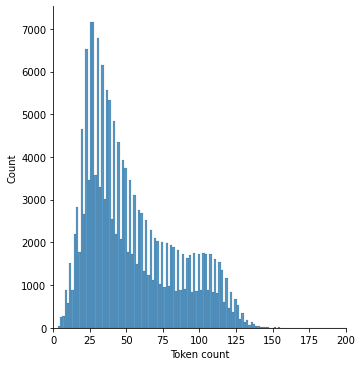

In [ ]:
token_lens = []
for txt in list(df.clean_message.values):
    tokens = tokenizer.encode(txt, max_length=512, truncation=True)
    token_lens.append(len(tokens))
    
sns.displot(token_lens)
plt.xlim([0, 200])
plt.xlabel('Token count')
plt.show()

In [ ]:
max_length = 160

### Encode messages

In [ ]:
encoded_data_train = tokenizer.batch_encode_plus(
    df_train["clean_message"].values.tolist(), 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=max_length, 
    return_tensors='pt'
)

encoded_data_val = tokenizer.batch_encode_plus(
    df[df.data_type=='val'].clean_message.values.tolist(), 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=max_length, 
    return_tensors='pt'
)


input_ids_train = encoded_data_train['input_ids']
attention_masks_train = encoded_data_train['attention_mask']
labels_train = torch.tensor(df_train.label.values)

input_ids_val = encoded_data_val['input_ids']
attention_masks_val = encoded_data_val['attention_mask']
labels_val = torch.tensor(df[df.data_type=='val'].label.values)

dataset_train = TensorDataset(input_ids_train, attention_masks_train, labels_train)
dataset_val = TensorDataset(input_ids_val, attention_masks_val, labels_val)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


/opt/conda/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2271: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [ ]:
len(dataset_train), len(dataset_val)

(116334, 26197)

# Model "google/electra-small-discriminator"

In [ ]:
model = ElectraForSequenceClassification.from_pretrained("google/electra-base-discriminator", num_labels = 3)

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at google/electra-base-discriminator were not used when initializing ElectraForSequenceClassification: ['discriminator_predictions.dense_prediction.weight', 'discriminator_predictions.dense.weight', 'discriminator_predictions.dense_prediction.bias', 'discriminator_predictions.dense.bias']
- This IS expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-base-discriminator and are newly initialized: ['classifier.out_proj.weight', 'classifier.out_proj.bias', 'classifier.dense.weight', 'classifier.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

batch_size = 32

dataloader_train = DataLoader(dataset_train, sampler=RandomSampler(dataset_train), batch_size=batch_size)
dataloader_validation = DataLoader(dataset_val, sampler=SequentialSampler(dataset_val), batch_size=batch_size)

In [ ]:
from transformers import get_linear_schedule_with_warmup

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5, eps=1e-8)

In [ ]:
epochs = 1

scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=len(dataloader_train)*epochs)

In [ ]:
# Function to measure weighted F1

from sklearn.metrics import f1_score

def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, preds_flat, average='weighted')

In [ ]:
import random

seed_val = 17
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cpu')
model.to(device)
print(device)

cuda


In [ ]:
# Function to evaluate model. Returns average validation loss, predictions, true values

def evaluate(dataloader_val):

    model.eval()
    
    loss_val_total = 0
    predictions, true_vals = [], []
    
    progress_bar = tqdm(dataloader_val, desc='Validating:', leave=False, disable=False)
    for batch in progress_bar:
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }

        with torch.no_grad():        
            outputs = model(**inputs)
            
        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)
    
    loss_val_avg = loss_val_total/len(dataloader_val) 
    
    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)
            
    return loss_val_avg, predictions, true_vals

# Train

In [ ]:
for epoch in tqdm(range(1, epochs+1)):
    
    model.train()
    
    loss_train_total = 0

    progress_bar = tqdm(dataloader_train, desc='Epoch {:1d}'.format(epoch), leave=False, disable=False)
    for batch in progress_bar:

        model.zero_grad()
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }       

        outputs = model(**inputs)
        
        loss = outputs[0]
        loss_train_total += loss.item()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()
        
        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})
         
        
    torch.save(model.state_dict(), f'modelsCleaned-pnn/finetuned_ELECTRA_epoch_{epoch}.model')
        
    tqdm.write(f'\nEpoch {epoch}')
    
    loss_train_avg = loss_train_total/len(dataloader_train)            
    tqdm.write(f'Training loss: {loss_train_avg}')
    
    val_loss, predictions, true_vals = evaluate(dataloader_validation)
    val_f1 = f1_score_func(predictions, true_vals)
    tqdm.write(f'Validation loss: {val_loss}')
    tqdm.write(f'F1 Score (Weighted): {val_f1}')
    
    preds_flat = np.argmax(predictions, axis=1).flatten()
    
    print('Classification report:')
    print(classification_report(true_vals, preds_flat))
    print('Confusion matrix:')
    print(pd.DataFrame(confusion_matrix(true_vals, preds_flat),
            index = [['actual', 'actual', 'actual'], ['neutral', 'positive', 'negative']],
            columns = [['predicted', 'predicted', 'predicted'], ['neutral', 'positive', 'negative']]))
    print('--------------------------------------------------------------')

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/3636 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/3636 [00:02<?, ?it/s, training_loss=0.368]

Epoch 1:   0%|          | 1/3636 [00:02<2:15:51,  2.24s/it, training_loss=0.368]

Epoch 1:   0%|          | 1/3636 [00:04<2:15:51,  2.24s/it, training_loss=0.371]

Epoch 1:   0%|          | 2/3636 [00:04<2:02:04,  2.02s/it, training_loss=0.371]

Epoch 1:   0%|          | 2/3636 [00:05<2:02:04,  2.02s/it, training_loss=0.367]

Epoch 1:   0%|          | 3/3636 [00:05<1:57:41,  1.94s/it, training_loss=0.367]

Epoch 1:   0%|          | 3/3636 [00:07<1:57:41,  1.94s/it, training_loss=0.365]

Epoch 1:   0%|          | 4/3636 [00:07<1:55:39,  1.91s/it, training_loss=0.365]

Epoch 1:   0%|          | 4/3636 [00:09<1:55:39,  1.91s/it, training_loss=0.369]

Epoch 1:   0%|          | 5/3636 [00:09<1:54:35,  1.89s/it, training_loss=0.369]

Epoch 1:   0%|          | 5/3636 [00:11<1:54:35,  1.89s/it, training_loss=0.367]

Epoch 1:   0%|          | 6/3636 [00:11<1:53:51,  1.88s/it, training_loss=0.367]

Epoch 1:   0%|          | 6/3636 [00:13<1:53:51,  1.88s/it, training_loss=0.365]

Epoch 1:   0%|          | 7/3636 [00:13<1:53:25,  1.88s/it, training_loss=0.365]

Epoch 1:   0%|          | 7/3636 [00:15<1:53:25,  1.88s/it, training_loss=0.367]

Epoch 1:   0%|          | 8/3636 [00:15<1:53:08,  1.87s/it, training_loss=0.367]

Epoch 1:   0%|          | 8/3636 [00:17<1:53:08,  1.87s/it, training_loss=0.368]

Epoch 1:   0%|          | 9/3636 [00:17<1:52:44,  1.87s/it, training_loss=0.368]

Epoch 1:   0%|          | 9/3636 [00:18<1:52:44,  1.87s/it, training_loss=0.364]

Epoch 1:   0%|          | 10/3636 [00:18<1:52:27,  1.86s/it, training_loss=0.364]

Epoch 1:   0%|          | 10/3636 [00:20<1:52:27,  1.86s/it, training_loss=0.366]

Epoch 1:   0%|          | 11/3636 [00:20<1:52:11,  1.86s/it, training_loss=0.366]

Epoch 1:   0%|          | 11/3636 [00:22<1:52:11,  1.86s/it, training_loss=0.372]

Epoch 1:   0%|          | 12/3636 [00:22<1:51:58,  1.85s/it, training_loss=0.372]

Epoch 1:   0%|          | 12/3636 [00:24<1:51:58,  1.85s/it, training_loss=0.369]

Epoch 1:   0%|          | 13/3636 [00:24<1:51:53,  1.85s/it, training_loss=0.369]

Epoch 1:   0%|          | 13/3636 [00:26<1:51:53,  1.85s/it, training_loss=0.370]

Epoch 1:   0%|          | 14/3636 [00:26<1:51:46,  1.85s/it, training_loss=0.370]

Epoch 1:   0%|          | 14/3636 [00:28<1:51:46,  1.85s/it, training_loss=0.368]

Epoch 1:   0%|          | 15/3636 [00:28<1:51:45,  1.85s/it, training_loss=0.368]

Epoch 1:   0%|          | 15/3636 [00:30<1:51:45,  1.85s/it, training_loss=0.368]

Epoch 1:   0%|          | 16/3636 [00:30<1:51:42,  1.85s/it, training_loss=0.368]

Epoch 1:   0%|          | 16/3636 [00:31<1:51:42,  1.85s/it, training_loss=0.366]

Epoch 1:   0%|          | 17/3636 [00:31<1:51:42,  1.85s/it, training_loss=0.366]

Epoch 1:   0%|          | 17/3636 [00:33<1:51:42,  1.85s/it, training_loss=0.360]

Epoch 1:   0%|          | 18/3636 [00:33<1:51:39,  1.85s/it, training_loss=0.360]

Epoch 1:   0%|          | 18/3636 [00:35<1:51:39,  1.85s/it, training_loss=0.364]

Epoch 1:   1%|          | 19/3636 [00:35<1:51:39,  1.85s/it, training_loss=0.364]

Epoch 1:   1%|          | 19/3636 [00:37<1:51:39,  1.85s/it, training_loss=0.365]

Epoch 1:   1%|          | 20/3636 [00:37<1:51:38,  1.85s/it, training_loss=0.365]

Epoch 1:   1%|          | 20/3636 [00:39<1:51:38,  1.85s/it, training_loss=0.365]

Epoch 1:   1%|          | 21/3636 [00:39<1:51:40,  1.85s/it, training_loss=0.365]

Epoch 1:   1%|          | 21/3636 [00:41<1:51:40,  1.85s/it, training_loss=0.366]

Epoch 1:   1%|          | 22/3636 [00:41<1:51:38,  1.85s/it, training_loss=0.366]

Epoch 1:   1%|          | 22/3636 [00:43<1:51:38,  1.85s/it, training_loss=0.364]

Epoch 1:   1%|          | 23/3636 [00:43<1:51:34,  1.85s/it, training_loss=0.364]

Epoch 1:   1%|          | 23/3636 [00:44<1:51:34,  1.85s/it, training_loss=0.363]

Epoch 1:   1%|          | 24/3636 [00:44<1:51:32,  1.85s/it, training_loss=0.363]

Epoch 1:   1%|          | 24/3636 [00:46<1:51:32,  1.85s/it, training_loss=0.362]

Epoch 1:   1%|          | 25/3636 [00:46<1:51:32,  1.85s/it, training_loss=0.362]

Epoch 1:   1%|          | 25/3636 [00:48<1:51:32,  1.85s/it, training_loss=0.362]

Epoch 1:   1%|          | 26/3636 [00:48<1:51:30,  1.85s/it, training_loss=0.362]

Epoch 1:   1%|          | 26/3636 [00:50<1:51:30,  1.85s/it, training_loss=0.366]

Epoch 1:   1%|          | 27/3636 [00:50<1:51:27,  1.85s/it, training_loss=0.366]

Epoch 1:   1%|          | 27/3636 [00:52<1:51:27,  1.85s/it, training_loss=0.358]

Epoch 1:   1%|          | 28/3636 [00:52<1:51:26,  1.85s/it, training_loss=0.358]

Epoch 1:   1%|          | 28/3636 [00:54<1:51:26,  1.85s/it, training_loss=0.364]

Epoch 1:   1%|          | 29/3636 [00:54<1:51:28,  1.85s/it, training_loss=0.364]

Epoch 1:   1%|          | 29/3636 [00:56<1:51:28,  1.85s/it, training_loss=0.361]

Epoch 1:   1%|          | 30/3636 [00:56<1:51:27,  1.85s/it, training_loss=0.361]

Epoch 1:   1%|          | 30/3636 [00:57<1:51:27,  1.85s/it, training_loss=0.363]

Epoch 1:   1%|          | 31/3636 [00:57<1:51:27,  1.86s/it, training_loss=0.363]

Epoch 1:   1%|          | 31/3636 [00:59<1:51:27,  1.86s/it, training_loss=0.364]

Epoch 1:   1%|          | 32/3636 [00:59<1:51:31,  1.86s/it, training_loss=0.364]

Epoch 1:   1%|          | 32/3636 [01:01<1:51:31,  1.86s/it, training_loss=0.358]

Epoch 1:   1%|          | 33/3636 [01:01<1:51:28,  1.86s/it, training_loss=0.358]

Epoch 1:   1%|          | 33/3636 [01:03<1:51:28,  1.86s/it, training_loss=0.365]

Epoch 1:   1%|          | 34/3636 [01:03<1:51:26,  1.86s/it, training_loss=0.365]

Epoch 1:   1%|          | 34/3636 [01:05<1:51:26,  1.86s/it, training_loss=0.365]

Epoch 1:   1%|          | 35/3636 [01:05<1:51:27,  1.86s/it, training_loss=0.365]

Epoch 1:   1%|          | 35/3636 [01:07<1:51:27,  1.86s/it, training_loss=0.363]

Epoch 1:   1%|          | 36/3636 [01:07<1:51:28,  1.86s/it, training_loss=0.363]

Epoch 1:   1%|          | 36/3636 [01:09<1:51:28,  1.86s/it, training_loss=0.361]

Epoch 1:   1%|          | 37/3636 [01:09<1:51:31,  1.86s/it, training_loss=0.361]

Epoch 1:   1%|          | 37/3636 [01:10<1:51:31,  1.86s/it, training_loss=0.363]

Epoch 1:   1%|          | 38/3636 [01:10<1:51:27,  1.86s/it, training_loss=0.363]

Epoch 1:   1%|          | 38/3636 [01:12<1:51:27,  1.86s/it, training_loss=0.359]

Epoch 1:   1%|          | 39/3636 [01:12<1:51:25,  1.86s/it, training_loss=0.359]

Epoch 1:   1%|          | 39/3636 [01:14<1:51:25,  1.86s/it, training_loss=0.352]

Epoch 1:   1%|          | 40/3636 [01:14<1:51:23,  1.86s/it, training_loss=0.352]

Epoch 1:   1%|          | 40/3636 [01:16<1:51:23,  1.86s/it, training_loss=0.357]

Epoch 1:   1%|          | 41/3636 [01:16<1:51:23,  1.86s/it, training_loss=0.357]

Epoch 1:   1%|          | 41/3636 [01:18<1:51:23,  1.86s/it, training_loss=0.362]

Epoch 1:   1%|          | 42/3636 [01:18<1:51:20,  1.86s/it, training_loss=0.362]

Epoch 1:   1%|          | 42/3636 [01:20<1:51:20,  1.86s/it, training_loss=0.367]

Epoch 1:   1%|          | 43/3636 [01:20<1:51:17,  1.86s/it, training_loss=0.367]

Epoch 1:   1%|          | 43/3636 [01:22<1:51:17,  1.86s/it, training_loss=0.354]

Epoch 1:   1%|          | 44/3636 [01:22<1:51:16,  1.86s/it, training_loss=0.354]

Epoch 1:   1%|          | 44/3636 [01:23<1:51:16,  1.86s/it, training_loss=0.371]

Epoch 1:   1%|          | 45/3636 [01:23<1:51:13,  1.86s/it, training_loss=0.371]

Epoch 1:   1%|          | 45/3636 [01:25<1:51:13,  1.86s/it, training_loss=0.355]

Epoch 1:   1%|▏         | 46/3636 [01:25<1:51:10,  1.86s/it, training_loss=0.355]

Epoch 1:   1%|▏         | 46/3636 [01:27<1:51:10,  1.86s/it, training_loss=0.357]

Epoch 1:   1%|▏         | 47/3636 [01:27<1:51:08,  1.86s/it, training_loss=0.357]

Epoch 1:   1%|▏         | 47/3636 [01:29<1:51:08,  1.86s/it, training_loss=0.352]

Epoch 1:   1%|▏         | 48/3636 [01:29<1:51:08,  1.86s/it, training_loss=0.352]

Epoch 1:   1%|▏         | 48/3636 [01:31<1:51:08,  1.86s/it, training_loss=0.365]

Epoch 1:   1%|▏         | 49/3636 [01:31<1:51:06,  1.86s/it, training_loss=0.365]

Epoch 1:   1%|▏         | 49/3636 [01:33<1:51:06,  1.86s/it, training_loss=0.364]

Epoch 1:   1%|▏         | 50/3636 [01:33<1:51:06,  1.86s/it, training_loss=0.364]

Epoch 1:   1%|▏         | 50/3636 [01:35<1:51:06,  1.86s/it, training_loss=0.366]

Epoch 1:   1%|▏         | 51/3636 [01:35<1:51:07,  1.86s/it, training_loss=0.366]

Epoch 1:   1%|▏         | 51/3636 [01:36<1:51:07,  1.86s/it, training_loss=0.353]

Epoch 1:   1%|▏         | 52/3636 [01:36<1:51:04,  1.86s/it, training_loss=0.353]

Epoch 1:   1%|▏         | 52/3636 [01:38<1:51:04,  1.86s/it, training_loss=0.355]

Epoch 1:   1%|▏         | 53/3636 [01:38<1:51:00,  1.86s/it, training_loss=0.355]

Epoch 1:   1%|▏         | 53/3636 [01:40<1:51:00,  1.86s/it, training_loss=0.366]

Epoch 1:   1%|▏         | 54/3636 [01:40<1:51:03,  1.86s/it, training_loss=0.366]

Epoch 1:   1%|▏         | 54/3636 [01:42<1:51:03,  1.86s/it, training_loss=0.341]

Epoch 1:   2%|▏         | 55/3636 [01:42<1:51:00,  1.86s/it, training_loss=0.341]

Epoch 1:   2%|▏         | 55/3636 [01:44<1:51:00,  1.86s/it, training_loss=0.358]

Epoch 1:   2%|▏         | 56/3636 [01:44<1:51:01,  1.86s/it, training_loss=0.358]

Epoch 1:   2%|▏         | 56/3636 [01:46<1:51:01,  1.86s/it, training_loss=0.363]

Epoch 1:   2%|▏         | 57/3636 [01:46<1:51:03,  1.86s/it, training_loss=0.363]

Epoch 1:   2%|▏         | 57/3636 [01:48<1:51:03,  1.86s/it, training_loss=0.377]

Epoch 1:   2%|▏         | 58/3636 [01:48<1:51:02,  1.86s/it, training_loss=0.377]

Epoch 1:   2%|▏         | 58/3636 [01:49<1:51:02,  1.86s/it, training_loss=0.353]

Epoch 1:   2%|▏         | 59/3636 [01:49<1:51:01,  1.86s/it, training_loss=0.353]

Epoch 1:   2%|▏         | 59/3636 [01:51<1:51:01,  1.86s/it, training_loss=0.348]

Epoch 1:   2%|▏         | 60/3636 [01:51<1:51:02,  1.86s/it, training_loss=0.348]

Epoch 1:   2%|▏         | 60/3636 [01:53<1:51:02,  1.86s/it, training_loss=0.353]

Epoch 1:   2%|▏         | 61/3636 [01:53<1:51:00,  1.86s/it, training_loss=0.353]

Epoch 1:   2%|▏         | 61/3636 [01:55<1:51:00,  1.86s/it, training_loss=0.343]

Epoch 1:   2%|▏         | 62/3636 [01:55<1:50:57,  1.86s/it, training_loss=0.343]

Epoch 1:   2%|▏         | 62/3636 [01:57<1:50:57,  1.86s/it, training_loss=0.369]

Epoch 1:   2%|▏         | 63/3636 [01:57<1:50:58,  1.86s/it, training_loss=0.369]

Epoch 1:   2%|▏         | 63/3636 [01:59<1:50:58,  1.86s/it, training_loss=0.359]

Epoch 1:   2%|▏         | 64/3636 [01:59<1:51:07,  1.87s/it, training_loss=0.359]

Epoch 1:   2%|▏         | 64/3636 [02:01<1:51:07,  1.87s/it, training_loss=0.351]

Epoch 1:   2%|▏         | 65/3636 [02:01<1:51:06,  1.87s/it, training_loss=0.351]

Epoch 1:   2%|▏         | 65/3636 [02:02<1:51:06,  1.87s/it, training_loss=0.368]

Epoch 1:   2%|▏         | 66/3636 [02:03<1:51:03,  1.87s/it, training_loss=0.368]

Epoch 1:   2%|▏         | 66/3636 [02:04<1:51:03,  1.87s/it, training_loss=0.355]

Epoch 1:   2%|▏         | 67/3636 [02:04<1:51:02,  1.87s/it, training_loss=0.355]

Epoch 1:   2%|▏         | 67/3636 [02:06<1:51:02,  1.87s/it, training_loss=0.351]

Epoch 1:   2%|▏         | 68/3636 [02:06<1:50:59,  1.87s/it, training_loss=0.351]

Epoch 1:   2%|▏         | 68/3636 [02:08<1:50:59,  1.87s/it, training_loss=0.357]

Epoch 1:   2%|▏         | 69/3636 [02:08<1:50:56,  1.87s/it, training_loss=0.357]

Epoch 1:   2%|▏         | 69/3636 [02:10<1:50:56,  1.87s/it, training_loss=0.340]

Epoch 1:   2%|▏         | 70/3636 [02:10<1:50:51,  1.87s/it, training_loss=0.340]

Epoch 1:   2%|▏         | 70/3636 [02:12<1:50:51,  1.87s/it, training_loss=0.342]

Epoch 1:   2%|▏         | 71/3636 [02:12<1:50:47,  1.86s/it, training_loss=0.342]

Epoch 1:   2%|▏         | 71/3636 [02:14<1:50:47,  1.86s/it, training_loss=0.355]

Epoch 1:   2%|▏         | 72/3636 [02:14<1:50:45,  1.86s/it, training_loss=0.355]

Epoch 1:   2%|▏         | 72/3636 [02:16<1:50:45,  1.86s/it, training_loss=0.344]

Epoch 1:   2%|▏         | 73/3636 [02:16<1:50:44,  1.86s/it, training_loss=0.344]

Epoch 1:   2%|▏         | 73/3636 [02:17<1:50:44,  1.86s/it, training_loss=0.357]

Epoch 1:   2%|▏         | 74/3636 [02:17<1:50:43,  1.86s/it, training_loss=0.357]

Epoch 1:   2%|▏         | 74/3636 [02:19<1:50:43,  1.86s/it, training_loss=0.368]

Epoch 1:   2%|▏         | 75/3636 [02:19<1:50:41,  1.87s/it, training_loss=0.368]

Epoch 1:   2%|▏         | 75/3636 [02:21<1:50:41,  1.87s/it, training_loss=0.363]

Epoch 1:   2%|▏         | 76/3636 [02:21<1:50:39,  1.87s/it, training_loss=0.363]

Epoch 1:   2%|▏         | 76/3636 [02:23<1:50:39,  1.87s/it, training_loss=0.360]

Epoch 1:   2%|▏         | 77/3636 [02:23<1:50:35,  1.86s/it, training_loss=0.360]

Epoch 1:   2%|▏         | 77/3636 [02:25<1:50:35,  1.86s/it, training_loss=0.344]

Epoch 1:   2%|▏         | 78/3636 [02:25<1:50:38,  1.87s/it, training_loss=0.344]

Epoch 1:   2%|▏         | 78/3636 [02:27<1:50:38,  1.87s/it, training_loss=0.332]

Epoch 1:   2%|▏         | 79/3636 [02:27<1:50:35,  1.87s/it, training_loss=0.332]

Epoch 1:   2%|▏         | 79/3636 [02:29<1:50:35,  1.87s/it, training_loss=0.352]

Epoch 1:   2%|▏         | 80/3636 [02:29<1:50:34,  1.87s/it, training_loss=0.352]

Epoch 1:   2%|▏         | 80/3636 [02:30<1:50:34,  1.87s/it, training_loss=0.357]

Epoch 1:   2%|▏         | 81/3636 [02:30<1:50:38,  1.87s/it, training_loss=0.357]

Epoch 1:   2%|▏         | 81/3636 [02:32<1:50:38,  1.87s/it, training_loss=0.358]

Epoch 1:   2%|▏         | 82/3636 [02:32<1:50:33,  1.87s/it, training_loss=0.358]

Epoch 1:   2%|▏         | 82/3636 [02:34<1:50:33,  1.87s/it, training_loss=0.374]

Epoch 1:   2%|▏         | 83/3636 [02:34<1:50:34,  1.87s/it, training_loss=0.374]

Epoch 1:   2%|▏         | 83/3636 [02:36<1:50:34,  1.87s/it, training_loss=0.344]

Epoch 1:   2%|▏         | 84/3636 [02:36<1:50:29,  1.87s/it, training_loss=0.344]

Epoch 1:   2%|▏         | 84/3636 [02:38<1:50:29,  1.87s/it, training_loss=0.368]

Epoch 1:   2%|▏         | 85/3636 [02:38<1:50:27,  1.87s/it, training_loss=0.368]

Epoch 1:   2%|▏         | 85/3636 [02:40<1:50:27,  1.87s/it, training_loss=0.331]

Epoch 1:   2%|▏         | 86/3636 [02:40<1:50:25,  1.87s/it, training_loss=0.331]

Epoch 1:   2%|▏         | 86/3636 [02:42<1:50:25,  1.87s/it, training_loss=0.343]

Epoch 1:   2%|▏         | 87/3636 [02:42<1:50:23,  1.87s/it, training_loss=0.343]

Epoch 1:   2%|▏         | 87/3636 [02:44<1:50:23,  1.87s/it, training_loss=0.343]

Epoch 1:   2%|▏         | 88/3636 [02:44<1:50:18,  1.87s/it, training_loss=0.343]

Epoch 1:   2%|▏         | 88/3636 [02:45<1:50:18,  1.87s/it, training_loss=0.360]

Epoch 1:   2%|▏         | 89/3636 [02:45<1:50:18,  1.87s/it, training_loss=0.360]

Epoch 1:   2%|▏         | 89/3636 [02:47<1:50:18,  1.87s/it, training_loss=0.352]

Epoch 1:   2%|▏         | 90/3636 [02:47<1:50:19,  1.87s/it, training_loss=0.352]

Epoch 1:   2%|▏         | 90/3636 [02:49<1:50:19,  1.87s/it, training_loss=0.363]

Epoch 1:   3%|▎         | 91/3636 [02:49<1:50:17,  1.87s/it, training_loss=0.363]

Epoch 1:   3%|▎         | 91/3636 [02:51<1:50:17,  1.87s/it, training_loss=0.347]

Epoch 1:   3%|▎         | 92/3636 [02:51<1:50:13,  1.87s/it, training_loss=0.347]

Epoch 1:   3%|▎         | 92/3636 [02:53<1:50:13,  1.87s/it, training_loss=0.360]

Epoch 1:   3%|▎         | 93/3636 [02:53<1:50:10,  1.87s/it, training_loss=0.360]

Epoch 1:   3%|▎         | 93/3636 [02:55<1:50:10,  1.87s/it, training_loss=0.348]

Epoch 1:   3%|▎         | 94/3636 [02:55<1:50:07,  1.87s/it, training_loss=0.348]

Epoch 1:   3%|▎         | 94/3636 [02:57<1:50:07,  1.87s/it, training_loss=0.345]

Epoch 1:   3%|▎         | 95/3636 [02:57<1:50:05,  1.87s/it, training_loss=0.345]

Epoch 1:   3%|▎         | 95/3636 [02:58<1:50:05,  1.87s/it, training_loss=0.345]

Epoch 1:   3%|▎         | 96/3636 [02:58<1:50:05,  1.87s/it, training_loss=0.345]

Epoch 1:   3%|▎         | 96/3636 [03:00<1:50:05,  1.87s/it, training_loss=0.366]

Epoch 1:   3%|▎         | 97/3636 [03:00<1:50:04,  1.87s/it, training_loss=0.366]

Epoch 1:   3%|▎         | 97/3636 [03:02<1:50:04,  1.87s/it, training_loss=0.339]

Epoch 1:   3%|▎         | 98/3636 [03:02<1:50:04,  1.87s/it, training_loss=0.339]

Epoch 1:   3%|▎         | 98/3636 [03:04<1:50:04,  1.87s/it, training_loss=0.354]

Epoch 1:   3%|▎         | 99/3636 [03:04<1:50:00,  1.87s/it, training_loss=0.354]

Epoch 1:   3%|▎         | 99/3636 [03:06<1:50:00,  1.87s/it, training_loss=0.362]

Epoch 1:   3%|▎         | 100/3636 [03:06<1:49:58,  1.87s/it, training_loss=0.362]

Epoch 1:   3%|▎         | 100/3636 [03:08<1:49:58,  1.87s/it, training_loss=0.364]

Epoch 1:   3%|▎         | 101/3636 [03:08<1:49:59,  1.87s/it, training_loss=0.364]

Epoch 1:   3%|▎         | 101/3636 [03:10<1:49:59,  1.87s/it, training_loss=0.354]

Epoch 1:   3%|▎         | 102/3636 [03:10<1:49:56,  1.87s/it, training_loss=0.354]

Epoch 1:   3%|▎         | 102/3636 [03:12<1:49:56,  1.87s/it, training_loss=0.332]

Epoch 1:   3%|▎         | 103/3636 [03:12<1:49:54,  1.87s/it, training_loss=0.332]

Epoch 1:   3%|▎         | 103/3636 [03:13<1:49:54,  1.87s/it, training_loss=0.338]

Epoch 1:   3%|▎         | 104/3636 [03:13<1:49:51,  1.87s/it, training_loss=0.338]

Epoch 1:   3%|▎         | 104/3636 [03:15<1:49:51,  1.87s/it, training_loss=0.368]

Epoch 1:   3%|▎         | 105/3636 [03:15<1:49:50,  1.87s/it, training_loss=0.368]

Epoch 1:   3%|▎         | 105/3636 [03:17<1:49:50,  1.87s/it, training_loss=0.377]

Epoch 1:   3%|▎         | 106/3636 [03:17<1:49:47,  1.87s/it, training_loss=0.377]

Epoch 1:   3%|▎         | 106/3636 [03:19<1:49:47,  1.87s/it, training_loss=0.353]

Epoch 1:   3%|▎         | 107/3636 [03:19<1:49:44,  1.87s/it, training_loss=0.353]

Epoch 1:   3%|▎         | 107/3636 [03:21<1:49:44,  1.87s/it, training_loss=0.339]

Epoch 1:   3%|▎         | 108/3636 [03:21<1:49:40,  1.87s/it, training_loss=0.339]

Epoch 1:   3%|▎         | 108/3636 [03:23<1:49:40,  1.87s/it, training_loss=0.346]

Epoch 1:   3%|▎         | 109/3636 [03:23<1:49:37,  1.86s/it, training_loss=0.346]

Epoch 1:   3%|▎         | 109/3636 [03:25<1:49:37,  1.86s/it, training_loss=0.349]

Epoch 1:   3%|▎         | 110/3636 [03:25<1:49:36,  1.87s/it, training_loss=0.349]

Epoch 1:   3%|▎         | 110/3636 [03:26<1:49:36,  1.87s/it, training_loss=0.339]

Epoch 1:   3%|▎         | 111/3636 [03:26<1:49:35,  1.87s/it, training_loss=0.339]

Epoch 1:   3%|▎         | 111/3636 [03:28<1:49:35,  1.87s/it, training_loss=0.333]

Epoch 1:   3%|▎         | 112/3636 [03:28<1:49:38,  1.87s/it, training_loss=0.333]

Epoch 1:   3%|▎         | 112/3636 [03:30<1:49:38,  1.87s/it, training_loss=0.377]

Epoch 1:   3%|▎         | 113/3636 [03:30<1:49:38,  1.87s/it, training_loss=0.377]

Epoch 1:   3%|▎         | 113/3636 [03:32<1:49:38,  1.87s/it, training_loss=0.370]

Epoch 1:   3%|▎         | 114/3636 [03:32<1:49:40,  1.87s/it, training_loss=0.370]

Epoch 1:   3%|▎         | 114/3636 [03:34<1:49:40,  1.87s/it, training_loss=0.323]

Epoch 1:   3%|▎         | 115/3636 [03:34<1:49:36,  1.87s/it, training_loss=0.323]

Epoch 1:   3%|▎         | 115/3636 [03:36<1:49:36,  1.87s/it, training_loss=0.336]

Epoch 1:   3%|▎         | 116/3636 [03:36<1:49:35,  1.87s/it, training_loss=0.336]

Epoch 1:   3%|▎         | 116/3636 [03:38<1:49:35,  1.87s/it, training_loss=0.335]

Epoch 1:   3%|▎         | 117/3636 [03:38<1:49:31,  1.87s/it, training_loss=0.335]

Epoch 1:   3%|▎         | 117/3636 [03:40<1:49:31,  1.87s/it, training_loss=0.330]

Epoch 1:   3%|▎         | 118/3636 [03:40<1:49:28,  1.87s/it, training_loss=0.330]

Epoch 1:   3%|▎         | 118/3636 [03:41<1:49:28,  1.87s/it, training_loss=0.339]

Epoch 1:   3%|▎         | 119/3636 [03:41<1:49:26,  1.87s/it, training_loss=0.339]

Epoch 1:   3%|▎         | 119/3636 [03:43<1:49:26,  1.87s/it, training_loss=0.336]

Epoch 1:   3%|▎         | 120/3636 [03:43<1:49:21,  1.87s/it, training_loss=0.336]

Epoch 1:   3%|▎         | 120/3636 [03:45<1:49:21,  1.87s/it, training_loss=0.337]

Epoch 1:   3%|▎         | 121/3636 [03:45<1:49:18,  1.87s/it, training_loss=0.337]

Epoch 1:   3%|▎         | 121/3636 [03:47<1:49:18,  1.87s/it, training_loss=0.337]

Epoch 1:   3%|▎         | 122/3636 [03:47<1:49:16,  1.87s/it, training_loss=0.337]

Epoch 1:   3%|▎         | 122/3636 [03:49<1:49:16,  1.87s/it, training_loss=0.381]

Epoch 1:   3%|▎         | 123/3636 [03:49<1:49:16,  1.87s/it, training_loss=0.381]

Epoch 1:   3%|▎         | 123/3636 [03:51<1:49:16,  1.87s/it, training_loss=0.356]

Epoch 1:   3%|▎         | 124/3636 [03:51<1:49:15,  1.87s/it, training_loss=0.356]

Epoch 1:   3%|▎         | 124/3636 [03:53<1:49:15,  1.87s/it, training_loss=0.329]

Epoch 1:   3%|▎         | 125/3636 [03:53<1:49:12,  1.87s/it, training_loss=0.329]

Epoch 1:   3%|▎         | 125/3636 [03:54<1:49:12,  1.87s/it, training_loss=0.355]

Epoch 1:   3%|▎         | 126/3636 [03:54<1:49:09,  1.87s/it, training_loss=0.355]

Epoch 1:   3%|▎         | 126/3636 [03:56<1:49:09,  1.87s/it, training_loss=0.368]

Epoch 1:   3%|▎         | 127/3636 [03:56<1:49:07,  1.87s/it, training_loss=0.368]

Epoch 1:   3%|▎         | 127/3636 [03:58<1:49:07,  1.87s/it, training_loss=0.358]

Epoch 1:   4%|▎         | 128/3636 [03:58<1:49:04,  1.87s/it, training_loss=0.358]

Epoch 1:   4%|▎         | 128/3636 [04:00<1:49:04,  1.87s/it, training_loss=0.317]

Epoch 1:   4%|▎         | 129/3636 [04:00<1:49:04,  1.87s/it, training_loss=0.317]

Epoch 1:   4%|▎         | 129/3636 [04:02<1:49:04,  1.87s/it, training_loss=0.326]

Epoch 1:   4%|▎         | 130/3636 [04:02<1:49:07,  1.87s/it, training_loss=0.326]

Epoch 1:   4%|▎         | 130/3636 [04:04<1:49:07,  1.87s/it, training_loss=0.349]

Epoch 1:   4%|▎         | 131/3636 [04:04<1:49:04,  1.87s/it, training_loss=0.349]

Epoch 1:   4%|▎         | 131/3636 [04:06<1:49:04,  1.87s/it, training_loss=0.363]

Epoch 1:   4%|▎         | 132/3636 [04:06<1:49:02,  1.87s/it, training_loss=0.363]

Epoch 1:   4%|▎         | 132/3636 [04:08<1:49:02,  1.87s/it, training_loss=0.338]

Epoch 1:   4%|▎         | 133/3636 [04:08<1:49:04,  1.87s/it, training_loss=0.338]

Epoch 1:   4%|▎         | 133/3636 [04:09<1:49:04,  1.87s/it, training_loss=0.354]

Epoch 1:   4%|▎         | 134/3636 [04:09<1:49:02,  1.87s/it, training_loss=0.354]

Epoch 1:   4%|▎         | 134/3636 [04:11<1:49:02,  1.87s/it, training_loss=0.332]

Epoch 1:   4%|▎         | 135/3636 [04:11<1:48:57,  1.87s/it, training_loss=0.332]

Epoch 1:   4%|▎         | 135/3636 [04:13<1:48:57,  1.87s/it, training_loss=0.347]

Epoch 1:   4%|▎         | 136/3636 [04:13<1:48:57,  1.87s/it, training_loss=0.347]

Epoch 1:   4%|▎         | 136/3636 [04:15<1:48:57,  1.87s/it, training_loss=0.324]

Epoch 1:   4%|▍         | 137/3636 [04:15<1:48:58,  1.87s/it, training_loss=0.324]

Epoch 1:   4%|▍         | 137/3636 [04:17<1:48:58,  1.87s/it, training_loss=0.363]

Epoch 1:   4%|▍         | 138/3636 [04:17<1:48:53,  1.87s/it, training_loss=0.363]

Epoch 1:   4%|▍         | 138/3636 [04:19<1:48:53,  1.87s/it, training_loss=0.367]

Epoch 1:   4%|▍         | 139/3636 [04:19<1:48:50,  1.87s/it, training_loss=0.367]

Epoch 1:   4%|▍         | 139/3636 [04:21<1:48:50,  1.87s/it, training_loss=0.365]

Epoch 1:   4%|▍         | 140/3636 [04:21<1:48:49,  1.87s/it, training_loss=0.365]

Epoch 1:   4%|▍         | 140/3636 [04:22<1:48:49,  1.87s/it, training_loss=0.352]

Epoch 1:   4%|▍         | 141/3636 [04:22<1:48:45,  1.87s/it, training_loss=0.352]

Epoch 1:   4%|▍         | 141/3636 [04:24<1:48:45,  1.87s/it, training_loss=0.328]

Epoch 1:   4%|▍         | 142/3636 [04:24<1:48:44,  1.87s/it, training_loss=0.328]

Epoch 1:   4%|▍         | 142/3636 [04:26<1:48:44,  1.87s/it, training_loss=0.324]

Epoch 1:   4%|▍         | 143/3636 [04:26<1:48:42,  1.87s/it, training_loss=0.324]

Epoch 1:   4%|▍         | 143/3636 [04:28<1:48:42,  1.87s/it, training_loss=0.333]

Epoch 1:   4%|▍         | 144/3636 [04:28<1:48:41,  1.87s/it, training_loss=0.333]

Epoch 1:   4%|▍         | 144/3636 [04:30<1:48:41,  1.87s/it, training_loss=0.326]

Epoch 1:   4%|▍         | 145/3636 [04:30<1:48:40,  1.87s/it, training_loss=0.326]

Epoch 1:   4%|▍         | 145/3636 [04:32<1:48:40,  1.87s/it, training_loss=0.351]

Epoch 1:   4%|▍         | 146/3636 [04:32<1:48:37,  1.87s/it, training_loss=0.351]

Epoch 1:   4%|▍         | 146/3636 [04:34<1:48:37,  1.87s/it, training_loss=0.339]

Epoch 1:   4%|▍         | 147/3636 [04:34<1:48:35,  1.87s/it, training_loss=0.339]

Epoch 1:   4%|▍         | 147/3636 [04:36<1:48:35,  1.87s/it, training_loss=0.362]

Epoch 1:   4%|▍         | 148/3636 [04:36<1:48:33,  1.87s/it, training_loss=0.362]

Epoch 1:   4%|▍         | 148/3636 [04:37<1:48:33,  1.87s/it, training_loss=0.390]

Epoch 1:   4%|▍         | 149/3636 [04:37<1:48:32,  1.87s/it, training_loss=0.390]

Epoch 1:   4%|▍         | 149/3636 [04:39<1:48:32,  1.87s/it, training_loss=0.338]

Epoch 1:   4%|▍         | 150/3636 [04:39<1:48:30,  1.87s/it, training_loss=0.338]

Epoch 1:   4%|▍         | 150/3636 [04:41<1:48:30,  1.87s/it, training_loss=0.354]

Epoch 1:   4%|▍         | 151/3636 [04:41<1:48:30,  1.87s/it, training_loss=0.354]

Epoch 1:   4%|▍         | 151/3636 [04:43<1:48:30,  1.87s/it, training_loss=0.336]

Epoch 1:   4%|▍         | 152/3636 [04:43<1:48:26,  1.87s/it, training_loss=0.336]

Epoch 1:   4%|▍         | 152/3636 [04:45<1:48:26,  1.87s/it, training_loss=0.346]

Epoch 1:   4%|▍         | 153/3636 [04:45<1:48:24,  1.87s/it, training_loss=0.346]

Epoch 1:   4%|▍         | 153/3636 [04:47<1:48:24,  1.87s/it, training_loss=0.350]

Epoch 1:   4%|▍         | 154/3636 [04:47<1:48:21,  1.87s/it, training_loss=0.350]

Epoch 1:   4%|▍         | 154/3636 [04:49<1:48:21,  1.87s/it, training_loss=0.328]

Epoch 1:   4%|▍         | 155/3636 [04:49<1:48:19,  1.87s/it, training_loss=0.328]

Epoch 1:   4%|▍         | 155/3636 [04:50<1:48:19,  1.87s/it, training_loss=0.340]

Epoch 1:   4%|▍         | 156/3636 [04:50<1:48:15,  1.87s/it, training_loss=0.340]

Epoch 1:   4%|▍         | 156/3636 [04:52<1:48:15,  1.87s/it, training_loss=0.331]

Epoch 1:   4%|▍         | 157/3636 [04:52<1:48:13,  1.87s/it, training_loss=0.331]

Epoch 1:   4%|▍         | 157/3636 [04:54<1:48:13,  1.87s/it, training_loss=0.339]

Epoch 1:   4%|▍         | 158/3636 [04:54<1:48:13,  1.87s/it, training_loss=0.339]

Epoch 1:   4%|▍         | 158/3636 [04:56<1:48:13,  1.87s/it, training_loss=0.324]

Epoch 1:   4%|▍         | 159/3636 [04:56<1:48:15,  1.87s/it, training_loss=0.324]

Epoch 1:   4%|▍         | 159/3636 [04:58<1:48:15,  1.87s/it, training_loss=0.321]

Epoch 1:   4%|▍         | 160/3636 [04:58<1:48:12,  1.87s/it, training_loss=0.321]

Epoch 1:   4%|▍         | 160/3636 [05:00<1:48:12,  1.87s/it, training_loss=0.361]

Epoch 1:   4%|▍         | 161/3636 [05:00<1:48:07,  1.87s/it, training_loss=0.361]

Epoch 1:   4%|▍         | 161/3636 [05:02<1:48:07,  1.87s/it, training_loss=0.300]

Epoch 1:   4%|▍         | 162/3636 [05:02<1:48:05,  1.87s/it, training_loss=0.300]

Epoch 1:   4%|▍         | 162/3636 [05:04<1:48:05,  1.87s/it, training_loss=0.309]

Epoch 1:   4%|▍         | 163/3636 [05:04<1:48:03,  1.87s/it, training_loss=0.309]

Epoch 1:   4%|▍         | 163/3636 [05:05<1:48:03,  1.87s/it, training_loss=0.356]

Epoch 1:   5%|▍         | 164/3636 [05:05<1:48:02,  1.87s/it, training_loss=0.356]

Epoch 1:   5%|▍         | 164/3636 [05:07<1:48:02,  1.87s/it, training_loss=0.338]

Epoch 1:   5%|▍         | 165/3636 [05:07<1:48:03,  1.87s/it, training_loss=0.338]

Epoch 1:   5%|▍         | 165/3636 [05:09<1:48:03,  1.87s/it, training_loss=0.330]

Epoch 1:   5%|▍         | 166/3636 [05:09<1:48:01,  1.87s/it, training_loss=0.330]

Epoch 1:   5%|▍         | 166/3636 [05:11<1:48:01,  1.87s/it, training_loss=0.321]

Epoch 1:   5%|▍         | 167/3636 [05:11<1:47:58,  1.87s/it, training_loss=0.321]

Epoch 1:   5%|▍         | 167/3636 [05:13<1:47:58,  1.87s/it, training_loss=0.319]

Epoch 1:   5%|▍         | 168/3636 [05:13<1:47:53,  1.87s/it, training_loss=0.319]

Epoch 1:   5%|▍         | 168/3636 [05:15<1:47:53,  1.87s/it, training_loss=0.334]

Epoch 1:   5%|▍         | 169/3636 [05:15<1:47:50,  1.87s/it, training_loss=0.334]

Epoch 1:   5%|▍         | 169/3636 [05:17<1:47:50,  1.87s/it, training_loss=0.360]

Epoch 1:   5%|▍         | 170/3636 [05:17<1:47:56,  1.87s/it, training_loss=0.360]

Epoch 1:   5%|▍         | 170/3636 [05:19<1:47:56,  1.87s/it, training_loss=0.335]

Epoch 1:   5%|▍         | 171/3636 [05:19<1:47:53,  1.87s/it, training_loss=0.335]

Epoch 1:   5%|▍         | 171/3636 [05:20<1:47:53,  1.87s/it, training_loss=0.325]

Epoch 1:   5%|▍         | 172/3636 [05:20<1:47:53,  1.87s/it, training_loss=0.325]

Epoch 1:   5%|▍         | 172/3636 [05:22<1:47:53,  1.87s/it, training_loss=0.361]

Epoch 1:   5%|▍         | 173/3636 [05:22<1:47:48,  1.87s/it, training_loss=0.361]

Epoch 1:   5%|▍         | 173/3636 [05:24<1:47:48,  1.87s/it, training_loss=0.313]

Epoch 1:   5%|▍         | 174/3636 [05:24<1:47:49,  1.87s/it, training_loss=0.313]

Epoch 1:   5%|▍         | 174/3636 [05:26<1:47:49,  1.87s/it, training_loss=0.344]

Epoch 1:   5%|▍         | 175/3636 [05:26<1:47:43,  1.87s/it, training_loss=0.344]

Epoch 1:   5%|▍         | 175/3636 [05:28<1:47:43,  1.87s/it, training_loss=0.331]

Epoch 1:   5%|▍         | 176/3636 [05:28<1:47:37,  1.87s/it, training_loss=0.331]

Epoch 1:   5%|▍         | 176/3636 [05:30<1:47:37,  1.87s/it, training_loss=0.341]

Epoch 1:   5%|▍         | 177/3636 [05:30<1:47:33,  1.87s/it, training_loss=0.341]

Epoch 1:   5%|▍         | 177/3636 [05:32<1:47:33,  1.87s/it, training_loss=0.339]

Epoch 1:   5%|▍         | 178/3636 [05:32<1:47:30,  1.87s/it, training_loss=0.339]

Epoch 1:   5%|▍         | 178/3636 [05:33<1:47:30,  1.87s/it, training_loss=0.320]

Epoch 1:   5%|▍         | 179/3636 [05:33<1:47:27,  1.87s/it, training_loss=0.320]

Epoch 1:   5%|▍         | 179/3636 [05:35<1:47:27,  1.87s/it, training_loss=0.373]

Epoch 1:   5%|▍         | 180/3636 [05:35<1:47:29,  1.87s/it, training_loss=0.373]

Epoch 1:   5%|▍         | 180/3636 [05:37<1:47:29,  1.87s/it, training_loss=0.334]

Epoch 1:   5%|▍         | 181/3636 [05:37<1:47:24,  1.87s/it, training_loss=0.334]

Epoch 1:   5%|▍         | 181/3636 [05:39<1:47:24,  1.87s/it, training_loss=0.335]

Epoch 1:   5%|▌         | 182/3636 [05:39<1:47:21,  1.86s/it, training_loss=0.335]

Epoch 1:   5%|▌         | 182/3636 [05:41<1:47:21,  1.86s/it, training_loss=0.336]

Epoch 1:   5%|▌         | 183/3636 [05:41<1:47:20,  1.87s/it, training_loss=0.336]

Epoch 1:   5%|▌         | 183/3636 [05:43<1:47:20,  1.87s/it, training_loss=0.328]

Epoch 1:   5%|▌         | 184/3636 [05:43<1:47:20,  1.87s/it, training_loss=0.328]

Epoch 1:   5%|▌         | 184/3636 [05:45<1:47:20,  1.87s/it, training_loss=0.324]

Epoch 1:   5%|▌         | 185/3636 [05:45<1:47:18,  1.87s/it, training_loss=0.324]

Epoch 1:   5%|▌         | 185/3636 [05:46<1:47:18,  1.87s/it, training_loss=0.313]

Epoch 1:   5%|▌         | 186/3636 [05:46<1:47:14,  1.87s/it, training_loss=0.313]

Epoch 1:   5%|▌         | 186/3636 [05:48<1:47:14,  1.87s/it, training_loss=0.320]

Epoch 1:   5%|▌         | 187/3636 [05:48<1:47:11,  1.86s/it, training_loss=0.320]

Epoch 1:   5%|▌         | 187/3636 [05:50<1:47:11,  1.86s/it, training_loss=0.316]

Epoch 1:   5%|▌         | 188/3636 [05:50<1:47:08,  1.86s/it, training_loss=0.316]

Epoch 1:   5%|▌         | 188/3636 [05:52<1:47:08,  1.86s/it, training_loss=0.323]

Epoch 1:   5%|▌         | 189/3636 [05:52<1:47:06,  1.86s/it, training_loss=0.323]

Epoch 1:   5%|▌         | 189/3636 [05:54<1:47:06,  1.86s/it, training_loss=0.321]

Epoch 1:   5%|▌         | 190/3636 [05:54<1:47:06,  1.87s/it, training_loss=0.321]

Epoch 1:   5%|▌         | 190/3636 [05:56<1:47:06,  1.87s/it, training_loss=0.357]

Epoch 1:   5%|▌         | 191/3636 [05:56<1:47:10,  1.87s/it, training_loss=0.357]

Epoch 1:   5%|▌         | 191/3636 [05:58<1:47:10,  1.87s/it, training_loss=0.345]

Epoch 1:   5%|▌         | 192/3636 [05:58<1:47:07,  1.87s/it, training_loss=0.345]

Epoch 1:   5%|▌         | 192/3636 [06:00<1:47:07,  1.87s/it, training_loss=0.299]

Epoch 1:   5%|▌         | 193/3636 [06:00<1:47:03,  1.87s/it, training_loss=0.299]

Epoch 1:   5%|▌         | 193/3636 [06:01<1:47:03,  1.87s/it, training_loss=0.385]

Epoch 1:   5%|▌         | 194/3636 [06:01<1:47:01,  1.87s/it, training_loss=0.385]

Epoch 1:   5%|▌         | 194/3636 [06:03<1:47:01,  1.87s/it, training_loss=0.311]

Epoch 1:   5%|▌         | 195/3636 [06:03<1:46:58,  1.87s/it, training_loss=0.311]

Epoch 1:   5%|▌         | 195/3636 [06:05<1:46:58,  1.87s/it, training_loss=0.292]

Epoch 1:   5%|▌         | 196/3636 [06:05<1:46:57,  1.87s/it, training_loss=0.292]

Epoch 1:   5%|▌         | 196/3636 [06:07<1:46:57,  1.87s/it, training_loss=0.358]

Epoch 1:   5%|▌         | 197/3636 [06:07<1:46:51,  1.86s/it, training_loss=0.358]

Epoch 1:   5%|▌         | 197/3636 [06:09<1:46:51,  1.86s/it, training_loss=0.344]

Epoch 1:   5%|▌         | 198/3636 [06:09<1:46:50,  1.86s/it, training_loss=0.344]

Epoch 1:   5%|▌         | 198/3636 [06:11<1:46:50,  1.86s/it, training_loss=0.332]

Epoch 1:   5%|▌         | 199/3636 [06:11<1:46:49,  1.86s/it, training_loss=0.332]

Epoch 1:   5%|▌         | 199/3636 [06:13<1:46:49,  1.86s/it, training_loss=0.355]

Epoch 1:   6%|▌         | 200/3636 [06:13<1:46:46,  1.86s/it, training_loss=0.355]

Epoch 1:   6%|▌         | 200/3636 [06:14<1:46:46,  1.86s/it, training_loss=0.332]

Epoch 1:   6%|▌         | 201/3636 [06:14<1:46:46,  1.86s/it, training_loss=0.332]

Epoch 1:   6%|▌         | 201/3636 [06:16<1:46:46,  1.86s/it, training_loss=0.324]

Epoch 1:   6%|▌         | 202/3636 [06:16<1:46:45,  1.87s/it, training_loss=0.324]

Epoch 1:   6%|▌         | 202/3636 [06:18<1:46:45,  1.87s/it, training_loss=0.354]

Epoch 1:   6%|▌         | 203/3636 [06:18<1:46:45,  1.87s/it, training_loss=0.354]

Epoch 1:   6%|▌         | 203/3636 [06:20<1:46:45,  1.87s/it, training_loss=0.343]

Epoch 1:   6%|▌         | 204/3636 [06:20<1:46:45,  1.87s/it, training_loss=0.343]

Epoch 1:   6%|▌         | 204/3636 [06:22<1:46:45,  1.87s/it, training_loss=0.318]

Epoch 1:   6%|▌         | 205/3636 [06:22<1:46:45,  1.87s/it, training_loss=0.318]

Epoch 1:   6%|▌         | 205/3636 [06:24<1:46:45,  1.87s/it, training_loss=0.322]

Epoch 1:   6%|▌         | 206/3636 [06:24<1:46:40,  1.87s/it, training_loss=0.322]

Epoch 1:   6%|▌         | 206/3636 [06:26<1:46:40,  1.87s/it, training_loss=0.306]

Epoch 1:   6%|▌         | 207/3636 [06:26<1:46:36,  1.87s/it, training_loss=0.306]

Epoch 1:   6%|▌         | 207/3636 [06:28<1:46:36,  1.87s/it, training_loss=0.332]

Epoch 1:   6%|▌         | 208/3636 [06:28<1:46:33,  1.87s/it, training_loss=0.332]

Epoch 1:   6%|▌         | 208/3636 [06:29<1:46:33,  1.87s/it, training_loss=0.310]

Epoch 1:   6%|▌         | 209/3636 [06:29<1:46:30,  1.86s/it, training_loss=0.310]

Epoch 1:   6%|▌         | 209/3636 [06:31<1:46:30,  1.86s/it, training_loss=0.329]

Epoch 1:   6%|▌         | 210/3636 [06:31<1:46:28,  1.86s/it, training_loss=0.329]

Epoch 1:   6%|▌         | 210/3636 [06:33<1:46:28,  1.86s/it, training_loss=0.375]

Epoch 1:   6%|▌         | 211/3636 [06:33<1:46:28,  1.87s/it, training_loss=0.375]

Epoch 1:   6%|▌         | 211/3636 [06:35<1:46:28,  1.87s/it, training_loss=0.344]

Epoch 1:   6%|▌         | 212/3636 [06:35<1:46:29,  1.87s/it, training_loss=0.344]

Epoch 1:   6%|▌         | 212/3636 [06:37<1:46:29,  1.87s/it, training_loss=0.338]

Epoch 1:   6%|▌         | 213/3636 [06:37<1:46:23,  1.86s/it, training_loss=0.338]

Epoch 1:   6%|▌         | 213/3636 [06:39<1:46:23,  1.86s/it, training_loss=0.341]

Epoch 1:   6%|▌         | 214/3636 [06:39<1:46:18,  1.86s/it, training_loss=0.341]

Epoch 1:   6%|▌         | 214/3636 [06:41<1:46:18,  1.86s/it, training_loss=0.329]

Epoch 1:   6%|▌         | 215/3636 [06:41<1:46:16,  1.86s/it, training_loss=0.329]

Epoch 1:   6%|▌         | 215/3636 [06:42<1:46:16,  1.86s/it, training_loss=0.340]

Epoch 1:   6%|▌         | 216/3636 [06:42<1:46:15,  1.86s/it, training_loss=0.340]

Epoch 1:   6%|▌         | 216/3636 [06:44<1:46:15,  1.86s/it, training_loss=0.327]

Epoch 1:   6%|▌         | 217/3636 [06:44<1:46:14,  1.86s/it, training_loss=0.327]

Epoch 1:   6%|▌         | 217/3636 [06:46<1:46:14,  1.86s/it, training_loss=0.333]

Epoch 1:   6%|▌         | 218/3636 [06:46<1:46:11,  1.86s/it, training_loss=0.333]

Epoch 1:   6%|▌         | 218/3636 [06:48<1:46:11,  1.86s/it, training_loss=0.338]

Epoch 1:   6%|▌         | 219/3636 [06:48<1:46:09,  1.86s/it, training_loss=0.338]

Epoch 1:   6%|▌         | 219/3636 [06:50<1:46:09,  1.86s/it, training_loss=0.334]

Epoch 1:   6%|▌         | 220/3636 [06:50<1:46:07,  1.86s/it, training_loss=0.334]

Epoch 1:   6%|▌         | 220/3636 [06:52<1:46:07,  1.86s/it, training_loss=0.364]

Epoch 1:   6%|▌         | 221/3636 [06:52<1:46:05,  1.86s/it, training_loss=0.364]

Epoch 1:   6%|▌         | 221/3636 [06:54<1:46:05,  1.86s/it, training_loss=0.349]

Epoch 1:   6%|▌         | 222/3636 [06:54<1:46:04,  1.86s/it, training_loss=0.349]

Epoch 1:   6%|▌         | 222/3636 [06:55<1:46:04,  1.86s/it, training_loss=0.343]

Epoch 1:   6%|▌         | 223/3636 [06:55<1:46:03,  1.86s/it, training_loss=0.343]

Epoch 1:   6%|▌         | 223/3636 [06:57<1:46:03,  1.86s/it, training_loss=0.330]

Epoch 1:   6%|▌         | 224/3636 [06:57<1:45:59,  1.86s/it, training_loss=0.330]

Epoch 1:   6%|▌         | 224/3636 [06:59<1:45:59,  1.86s/it, training_loss=0.372]

Epoch 1:   6%|▌         | 225/3636 [06:59<1:45:59,  1.86s/it, training_loss=0.372]

Epoch 1:   6%|▌         | 225/3636 [07:01<1:45:59,  1.86s/it, training_loss=0.327]

Epoch 1:   6%|▌         | 226/3636 [07:01<1:45:54,  1.86s/it, training_loss=0.327]

Epoch 1:   6%|▌         | 226/3636 [07:03<1:45:54,  1.86s/it, training_loss=0.337]

Epoch 1:   6%|▌         | 227/3636 [07:03<1:45:52,  1.86s/it, training_loss=0.337]

Epoch 1:   6%|▌         | 227/3636 [07:05<1:45:52,  1.86s/it, training_loss=0.346]

Epoch 1:   6%|▋         | 228/3636 [07:05<1:45:51,  1.86s/it, training_loss=0.346]

Epoch 1:   6%|▋         | 228/3636 [07:07<1:45:51,  1.86s/it, training_loss=0.327]

Epoch 1:   6%|▋         | 229/3636 [07:07<1:45:46,  1.86s/it, training_loss=0.327]

Epoch 1:   6%|▋         | 229/3636 [07:09<1:45:46,  1.86s/it, training_loss=0.350]

Epoch 1:   6%|▋         | 230/3636 [07:09<1:45:44,  1.86s/it, training_loss=0.350]

Epoch 1:   6%|▋         | 230/3636 [07:10<1:45:44,  1.86s/it, training_loss=0.346]

Epoch 1:   6%|▋         | 231/3636 [07:10<1:45:40,  1.86s/it, training_loss=0.346]

Epoch 1:   6%|▋         | 231/3636 [07:12<1:45:40,  1.86s/it, training_loss=0.353]

Epoch 1:   6%|▋         | 232/3636 [07:12<1:45:39,  1.86s/it, training_loss=0.353]

Epoch 1:   6%|▋         | 232/3636 [07:14<1:45:39,  1.86s/it, training_loss=0.352]

Epoch 1:   6%|▋         | 233/3636 [07:14<1:45:39,  1.86s/it, training_loss=0.352]

Epoch 1:   6%|▋         | 233/3636 [07:16<1:45:39,  1.86s/it, training_loss=0.313]

Epoch 1:   6%|▋         | 234/3636 [07:16<1:45:37,  1.86s/it, training_loss=0.313]

Epoch 1:   6%|▋         | 234/3636 [07:18<1:45:37,  1.86s/it, training_loss=0.357]

Epoch 1:   6%|▋         | 235/3636 [07:18<1:45:34,  1.86s/it, training_loss=0.357]

Epoch 1:   6%|▋         | 235/3636 [07:20<1:45:34,  1.86s/it, training_loss=0.317]

Epoch 1:   6%|▋         | 236/3636 [07:20<1:45:29,  1.86s/it, training_loss=0.317]

Epoch 1:   6%|▋         | 236/3636 [07:22<1:45:29,  1.86s/it, training_loss=0.359]

Epoch 1:   7%|▋         | 237/3636 [07:22<1:45:31,  1.86s/it, training_loss=0.359]

Epoch 1:   7%|▋         | 237/3636 [07:23<1:45:31,  1.86s/it, training_loss=0.339]

Epoch 1:   7%|▋         | 238/3636 [07:23<1:45:28,  1.86s/it, training_loss=0.339]

Epoch 1:   7%|▋         | 238/3636 [07:25<1:45:28,  1.86s/it, training_loss=0.341]

Epoch 1:   7%|▋         | 239/3636 [07:25<1:45:27,  1.86s/it, training_loss=0.341]

Epoch 1:   7%|▋         | 239/3636 [07:27<1:45:27,  1.86s/it, training_loss=0.336]

Epoch 1:   7%|▋         | 240/3636 [07:27<1:45:22,  1.86s/it, training_loss=0.336]

Epoch 1:   7%|▋         | 240/3636 [07:29<1:45:22,  1.86s/it, training_loss=0.331]

Epoch 1:   7%|▋         | 241/3636 [07:29<1:45:18,  1.86s/it, training_loss=0.331]

Epoch 1:   7%|▋         | 241/3636 [07:31<1:45:18,  1.86s/it, training_loss=0.323]

Epoch 1:   7%|▋         | 242/3636 [07:31<1:45:16,  1.86s/it, training_loss=0.323]

Epoch 1:   7%|▋         | 242/3636 [07:33<1:45:16,  1.86s/it, training_loss=0.326]

Epoch 1:   7%|▋         | 243/3636 [07:33<1:45:14,  1.86s/it, training_loss=0.326]

Epoch 1:   7%|▋         | 243/3636 [07:35<1:45:14,  1.86s/it, training_loss=0.336]

Epoch 1:   7%|▋         | 244/3636 [07:35<1:45:11,  1.86s/it, training_loss=0.336]

Epoch 1:   7%|▋         | 244/3636 [07:36<1:45:11,  1.86s/it, training_loss=0.320]

Epoch 1:   7%|▋         | 245/3636 [07:36<1:45:13,  1.86s/it, training_loss=0.320]

Epoch 1:   7%|▋         | 245/3636 [07:38<1:45:13,  1.86s/it, training_loss=0.327]

Epoch 1:   7%|▋         | 246/3636 [07:38<1:45:10,  1.86s/it, training_loss=0.327]

Epoch 1:   7%|▋         | 246/3636 [07:40<1:45:10,  1.86s/it, training_loss=0.316]

Epoch 1:   7%|▋         | 247/3636 [07:40<1:45:07,  1.86s/it, training_loss=0.316]

Epoch 1:   7%|▋         | 247/3636 [07:42<1:45:07,  1.86s/it, training_loss=0.317]

Epoch 1:   7%|▋         | 248/3636 [07:42<1:45:03,  1.86s/it, training_loss=0.317]

Epoch 1:   7%|▋         | 248/3636 [07:44<1:45:03,  1.86s/it, training_loss=0.322]

Epoch 1:   7%|▋         | 249/3636 [07:44<1:45:02,  1.86s/it, training_loss=0.322]

Epoch 1:   7%|▋         | 249/3636 [07:46<1:45:02,  1.86s/it, training_loss=0.332]

Epoch 1:   7%|▋         | 250/3636 [07:46<1:44:58,  1.86s/it, training_loss=0.332]

Epoch 1:   7%|▋         | 250/3636 [07:48<1:44:58,  1.86s/it, training_loss=0.306]

Epoch 1:   7%|▋         | 251/3636 [07:48<1:44:55,  1.86s/it, training_loss=0.306]

Epoch 1:   7%|▋         | 251/3636 [07:49<1:44:55,  1.86s/it, training_loss=0.324]

Epoch 1:   7%|▋         | 252/3636 [07:49<1:44:52,  1.86s/it, training_loss=0.324]

Epoch 1:   7%|▋         | 252/3636 [07:51<1:44:52,  1.86s/it, training_loss=0.336]

Epoch 1:   7%|▋         | 253/3636 [07:51<1:44:50,  1.86s/it, training_loss=0.336]

Epoch 1:   7%|▋         | 253/3636 [07:53<1:44:50,  1.86s/it, training_loss=0.291]

Epoch 1:   7%|▋         | 254/3636 [07:53<1:44:50,  1.86s/it, training_loss=0.291]

Epoch 1:   7%|▋         | 254/3636 [07:55<1:44:50,  1.86s/it, training_loss=0.341]

Epoch 1:   7%|▋         | 255/3636 [07:55<1:44:46,  1.86s/it, training_loss=0.341]

Epoch 1:   7%|▋         | 255/3636 [07:57<1:44:46,  1.86s/it, training_loss=0.301]

Epoch 1:   7%|▋         | 256/3636 [07:57<1:44:44,  1.86s/it, training_loss=0.301]

Epoch 1:   7%|▋         | 256/3636 [07:59<1:44:44,  1.86s/it, training_loss=0.314]

Epoch 1:   7%|▋         | 257/3636 [07:59<1:44:40,  1.86s/it, training_loss=0.314]

Epoch 1:   7%|▋         | 257/3636 [08:01<1:44:40,  1.86s/it, training_loss=0.304]

Epoch 1:   7%|▋         | 258/3636 [08:01<1:44:42,  1.86s/it, training_loss=0.304]

Epoch 1:   7%|▋         | 258/3636 [08:03<1:44:42,  1.86s/it, training_loss=0.326]

Epoch 1:   7%|▋         | 259/3636 [08:03<1:44:49,  1.86s/it, training_loss=0.326]

Epoch 1:   7%|▋         | 259/3636 [08:04<1:44:49,  1.86s/it, training_loss=0.317]

Epoch 1:   7%|▋         | 260/3636 [08:04<1:44:45,  1.86s/it, training_loss=0.317]

Epoch 1:   7%|▋         | 260/3636 [08:06<1:44:45,  1.86s/it, training_loss=0.316]

Epoch 1:   7%|▋         | 261/3636 [08:06<1:44:39,  1.86s/it, training_loss=0.316]

Epoch 1:   7%|▋         | 261/3636 [08:08<1:44:39,  1.86s/it, training_loss=0.350]

Epoch 1:   7%|▋         | 262/3636 [08:08<1:44:36,  1.86s/it, training_loss=0.350]

Epoch 1:   7%|▋         | 262/3636 [08:10<1:44:36,  1.86s/it, training_loss=0.321]

Epoch 1:   7%|▋         | 263/3636 [08:10<1:44:30,  1.86s/it, training_loss=0.321]

Epoch 1:   7%|▋         | 263/3636 [08:12<1:44:30,  1.86s/it, training_loss=0.354]

Epoch 1:   7%|▋         | 264/3636 [08:12<1:44:28,  1.86s/it, training_loss=0.354]

Epoch 1:   7%|▋         | 264/3636 [08:14<1:44:28,  1.86s/it, training_loss=0.331]

Epoch 1:   7%|▋         | 265/3636 [08:14<1:44:25,  1.86s/it, training_loss=0.331]

Epoch 1:   7%|▋         | 265/3636 [08:16<1:44:25,  1.86s/it, training_loss=0.377]

Epoch 1:   7%|▋         | 266/3636 [08:16<1:44:24,  1.86s/it, training_loss=0.377]

Epoch 1:   7%|▋         | 266/3636 [08:17<1:44:24,  1.86s/it, training_loss=0.366]

Epoch 1:   7%|▋         | 267/3636 [08:17<1:44:24,  1.86s/it, training_loss=0.366]

Epoch 1:   7%|▋         | 267/3636 [08:19<1:44:24,  1.86s/it, training_loss=0.362]

Epoch 1:   7%|▋         | 268/3636 [08:19<1:44:20,  1.86s/it, training_loss=0.362]

Epoch 1:   7%|▋         | 268/3636 [08:21<1:44:20,  1.86s/it, training_loss=0.337]

Epoch 1:   7%|▋         | 269/3636 [08:21<1:44:19,  1.86s/it, training_loss=0.337]

Epoch 1:   7%|▋         | 269/3636 [08:23<1:44:19,  1.86s/it, training_loss=0.313]

Epoch 1:   7%|▋         | 270/3636 [08:23<1:44:17,  1.86s/it, training_loss=0.313]

Epoch 1:   7%|▋         | 270/3636 [08:25<1:44:17,  1.86s/it, training_loss=0.311]

Epoch 1:   7%|▋         | 271/3636 [08:25<1:44:13,  1.86s/it, training_loss=0.311]

Epoch 1:   7%|▋         | 271/3636 [08:27<1:44:13,  1.86s/it, training_loss=0.327]

Epoch 1:   7%|▋         | 272/3636 [08:27<1:44:11,  1.86s/it, training_loss=0.327]

Epoch 1:   7%|▋         | 272/3636 [08:29<1:44:11,  1.86s/it, training_loss=0.319]

Epoch 1:   8%|▊         | 273/3636 [08:29<1:44:09,  1.86s/it, training_loss=0.319]

Epoch 1:   8%|▊         | 273/3636 [08:30<1:44:09,  1.86s/it, training_loss=0.342]

Epoch 1:   8%|▊         | 274/3636 [08:30<1:44:12,  1.86s/it, training_loss=0.342]

Epoch 1:   8%|▊         | 274/3636 [08:32<1:44:12,  1.86s/it, training_loss=0.341]

Epoch 1:   8%|▊         | 275/3636 [08:32<1:44:10,  1.86s/it, training_loss=0.341]

Epoch 1:   8%|▊         | 275/3636 [08:34<1:44:10,  1.86s/it, training_loss=0.309]

Epoch 1:   8%|▊         | 276/3636 [08:34<1:44:09,  1.86s/it, training_loss=0.309]

Epoch 1:   8%|▊         | 276/3636 [08:36<1:44:09,  1.86s/it, training_loss=0.326]

Epoch 1:   8%|▊         | 277/3636 [08:36<1:44:08,  1.86s/it, training_loss=0.326]

Epoch 1:   8%|▊         | 277/3636 [08:38<1:44:08,  1.86s/it, training_loss=0.316]

Epoch 1:   8%|▊         | 278/3636 [08:38<1:44:03,  1.86s/it, training_loss=0.316]

Epoch 1:   8%|▊         | 278/3636 [08:40<1:44:03,  1.86s/it, training_loss=0.312]

Epoch 1:   8%|▊         | 279/3636 [08:40<1:43:59,  1.86s/it, training_loss=0.312]

Epoch 1:   8%|▊         | 279/3636 [08:42<1:43:59,  1.86s/it, training_loss=0.331]

Epoch 1:   8%|▊         | 280/3636 [08:42<1:43:59,  1.86s/it, training_loss=0.331]

Epoch 1:   8%|▊         | 280/3636 [08:43<1:43:59,  1.86s/it, training_loss=0.320]

Epoch 1:   8%|▊         | 281/3636 [08:43<1:43:56,  1.86s/it, training_loss=0.320]

Epoch 1:   8%|▊         | 281/3636 [08:45<1:43:56,  1.86s/it, training_loss=0.326]

Epoch 1:   8%|▊         | 282/3636 [08:45<1:43:55,  1.86s/it, training_loss=0.326]

Epoch 1:   8%|▊         | 282/3636 [08:47<1:43:55,  1.86s/it, training_loss=0.337]

Epoch 1:   8%|▊         | 283/3636 [08:47<1:43:55,  1.86s/it, training_loss=0.337]

Epoch 1:   8%|▊         | 283/3636 [08:49<1:43:55,  1.86s/it, training_loss=0.327]

Epoch 1:   8%|▊         | 284/3636 [08:49<1:43:54,  1.86s/it, training_loss=0.327]

Epoch 1:   8%|▊         | 284/3636 [08:51<1:43:54,  1.86s/it, training_loss=0.287]

Epoch 1:   8%|▊         | 285/3636 [08:51<1:43:54,  1.86s/it, training_loss=0.287]

Epoch 1:   8%|▊         | 285/3636 [08:53<1:43:54,  1.86s/it, training_loss=0.332]

Epoch 1:   8%|▊         | 286/3636 [08:53<1:43:55,  1.86s/it, training_loss=0.332]

Epoch 1:   8%|▊         | 286/3636 [08:55<1:43:55,  1.86s/it, training_loss=0.314]

Epoch 1:   8%|▊         | 287/3636 [08:55<1:43:53,  1.86s/it, training_loss=0.314]

Epoch 1:   8%|▊         | 287/3636 [08:56<1:43:53,  1.86s/it, training_loss=0.311]

Epoch 1:   8%|▊         | 288/3636 [08:56<1:43:56,  1.86s/it, training_loss=0.311]

Epoch 1:   8%|▊         | 288/3636 [08:58<1:43:56,  1.86s/it, training_loss=0.332]

Epoch 1:   8%|▊         | 289/3636 [08:58<1:43:56,  1.86s/it, training_loss=0.332]

Epoch 1:   8%|▊         | 289/3636 [09:00<1:43:56,  1.86s/it, training_loss=0.300]

Epoch 1:   8%|▊         | 290/3636 [09:00<1:43:52,  1.86s/it, training_loss=0.300]

Epoch 1:   8%|▊         | 290/3636 [09:02<1:43:52,  1.86s/it, training_loss=0.335]

Epoch 1:   8%|▊         | 291/3636 [09:02<1:43:50,  1.86s/it, training_loss=0.335]

Epoch 1:   8%|▊         | 291/3636 [09:04<1:43:50,  1.86s/it, training_loss=0.279]

Epoch 1:   8%|▊         | 292/3636 [09:04<1:43:49,  1.86s/it, training_loss=0.279]

Epoch 1:   8%|▊         | 292/3636 [09:06<1:43:49,  1.86s/it, training_loss=0.313]

Epoch 1:   8%|▊         | 293/3636 [09:06<1:43:47,  1.86s/it, training_loss=0.313]

Epoch 1:   8%|▊         | 293/3636 [09:08<1:43:47,  1.86s/it, training_loss=0.322]

Epoch 1:   8%|▊         | 294/3636 [09:08<1:43:43,  1.86s/it, training_loss=0.322]

Epoch 1:   8%|▊         | 294/3636 [09:09<1:43:43,  1.86s/it, training_loss=0.339]

Epoch 1:   8%|▊         | 295/3636 [09:09<1:43:41,  1.86s/it, training_loss=0.339]

Epoch 1:   8%|▊         | 295/3636 [09:11<1:43:41,  1.86s/it, training_loss=0.287]

Epoch 1:   8%|▊         | 296/3636 [09:11<1:43:38,  1.86s/it, training_loss=0.287]

Epoch 1:   8%|▊         | 296/3636 [09:13<1:43:38,  1.86s/it, training_loss=0.353]

Epoch 1:   8%|▊         | 297/3636 [09:13<1:43:39,  1.86s/it, training_loss=0.353]

Epoch 1:   8%|▊         | 297/3636 [09:15<1:43:39,  1.86s/it, training_loss=0.296]

Epoch 1:   8%|▊         | 298/3636 [09:15<1:43:43,  1.86s/it, training_loss=0.296]

Epoch 1:   8%|▊         | 298/3636 [09:17<1:43:43,  1.86s/it, training_loss=0.364]

Epoch 1:   8%|▊         | 299/3636 [09:17<1:43:40,  1.86s/it, training_loss=0.364]

Epoch 1:   8%|▊         | 299/3636 [09:19<1:43:40,  1.86s/it, training_loss=0.380]

Epoch 1:   8%|▊         | 300/3636 [09:19<1:43:36,  1.86s/it, training_loss=0.380]

Epoch 1:   8%|▊         | 300/3636 [09:21<1:43:36,  1.86s/it, training_loss=0.338]

Epoch 1:   8%|▊         | 301/3636 [09:21<1:43:35,  1.86s/it, training_loss=0.338]

Epoch 1:   8%|▊         | 301/3636 [09:23<1:43:35,  1.86s/it, training_loss=0.346]

Epoch 1:   8%|▊         | 302/3636 [09:23<1:43:36,  1.86s/it, training_loss=0.346]

Epoch 1:   8%|▊         | 302/3636 [09:24<1:43:36,  1.86s/it, training_loss=0.313]

Epoch 1:   8%|▊         | 303/3636 [09:24<1:43:36,  1.87s/it, training_loss=0.313]

Epoch 1:   8%|▊         | 303/3636 [09:26<1:43:36,  1.87s/it, training_loss=0.320]

Epoch 1:   8%|▊         | 304/3636 [09:26<1:43:35,  1.87s/it, training_loss=0.320]

Epoch 1:   8%|▊         | 304/3636 [09:28<1:43:35,  1.87s/it, training_loss=0.343]

Epoch 1:   8%|▊         | 305/3636 [09:28<1:43:35,  1.87s/it, training_loss=0.343]

Epoch 1:   8%|▊         | 305/3636 [09:30<1:43:35,  1.87s/it, training_loss=0.274]

Epoch 1:   8%|▊         | 306/3636 [09:30<1:43:38,  1.87s/it, training_loss=0.274]

Epoch 1:   8%|▊         | 306/3636 [09:32<1:43:38,  1.87s/it, training_loss=0.312]

Epoch 1:   8%|▊         | 307/3636 [09:32<1:43:33,  1.87s/it, training_loss=0.312]

Epoch 1:   8%|▊         | 307/3636 [09:34<1:43:33,  1.87s/it, training_loss=0.329]

Epoch 1:   8%|▊         | 308/3636 [09:34<1:43:29,  1.87s/it, training_loss=0.329]

Epoch 1:   8%|▊         | 308/3636 [09:36<1:43:29,  1.87s/it, training_loss=0.327]

Epoch 1:   8%|▊         | 309/3636 [09:36<1:43:26,  1.87s/it, training_loss=0.327]

Epoch 1:   8%|▊         | 309/3636 [09:37<1:43:26,  1.87s/it, training_loss=0.326]

Epoch 1:   9%|▊         | 310/3636 [09:37<1:43:22,  1.86s/it, training_loss=0.326]

Epoch 1:   9%|▊         | 310/3636 [09:39<1:43:22,  1.86s/it, training_loss=0.337]

Epoch 1:   9%|▊         | 311/3636 [09:39<1:43:20,  1.86s/it, training_loss=0.337]

Epoch 1:   9%|▊         | 311/3636 [09:41<1:43:20,  1.86s/it, training_loss=0.309]

Epoch 1:   9%|▊         | 312/3636 [09:41<1:43:17,  1.86s/it, training_loss=0.309]

Epoch 1:   9%|▊         | 312/3636 [09:43<1:43:17,  1.86s/it, training_loss=0.300]

Epoch 1:   9%|▊         | 313/3636 [09:43<1:43:14,  1.86s/it, training_loss=0.300]

Epoch 1:   9%|▊         | 313/3636 [09:45<1:43:14,  1.86s/it, training_loss=0.354]

Epoch 1:   9%|▊         | 314/3636 [09:45<1:43:16,  1.87s/it, training_loss=0.354]

Epoch 1:   9%|▊         | 314/3636 [09:47<1:43:16,  1.87s/it, training_loss=0.352]

Epoch 1:   9%|▊         | 315/3636 [09:47<1:43:17,  1.87s/it, training_loss=0.352]

Epoch 1:   9%|▊         | 315/3636 [09:49<1:43:17,  1.87s/it, training_loss=0.374]

Epoch 1:   9%|▊         | 316/3636 [09:49<1:43:14,  1.87s/it, training_loss=0.374]

Epoch 1:   9%|▊         | 316/3636 [09:51<1:43:14,  1.87s/it, training_loss=0.317]

Epoch 1:   9%|▊         | 317/3636 [09:51<1:43:12,  1.87s/it, training_loss=0.317]

Epoch 1:   9%|▊         | 317/3636 [09:52<1:43:12,  1.87s/it, training_loss=0.332]

Epoch 1:   9%|▊         | 318/3636 [09:52<1:43:12,  1.87s/it, training_loss=0.332]

Epoch 1:   9%|▊         | 318/3636 [09:54<1:43:12,  1.87s/it, training_loss=0.263]

Epoch 1:   9%|▉         | 319/3636 [09:54<1:43:09,  1.87s/it, training_loss=0.263]

Epoch 1:   9%|▉         | 319/3636 [09:56<1:43:09,  1.87s/it, training_loss=0.304]

Epoch 1:   9%|▉         | 320/3636 [09:56<1:43:07,  1.87s/it, training_loss=0.304]

Epoch 1:   9%|▉         | 320/3636 [09:58<1:43:07,  1.87s/it, training_loss=0.301]

Epoch 1:   9%|▉         | 321/3636 [09:58<1:43:03,  1.87s/it, training_loss=0.301]

Epoch 1:   9%|▉         | 321/3636 [10:00<1:43:03,  1.87s/it, training_loss=0.316]

Epoch 1:   9%|▉         | 322/3636 [10:00<1:43:02,  1.87s/it, training_loss=0.316]

Epoch 1:   9%|▉         | 322/3636 [10:02<1:43:02,  1.87s/it, training_loss=0.340]

Epoch 1:   9%|▉         | 323/3636 [10:02<1:43:02,  1.87s/it, training_loss=0.340]

Epoch 1:   9%|▉         | 323/3636 [10:04<1:43:02,  1.87s/it, training_loss=0.291]

Epoch 1:   9%|▉         | 324/3636 [10:04<1:43:01,  1.87s/it, training_loss=0.291]

Epoch 1:   9%|▉         | 324/3636 [10:05<1:43:01,  1.87s/it, training_loss=0.296]

Epoch 1:   9%|▉         | 325/3636 [10:05<1:42:59,  1.87s/it, training_loss=0.296]

Epoch 1:   9%|▉         | 325/3636 [10:07<1:42:59,  1.87s/it, training_loss=0.317]

Epoch 1:   9%|▉         | 326/3636 [10:07<1:42:57,  1.87s/it, training_loss=0.317]

Epoch 1:   9%|▉         | 326/3636 [10:09<1:42:57,  1.87s/it, training_loss=0.307]

Epoch 1:   9%|▉         | 327/3636 [10:09<1:43:00,  1.87s/it, training_loss=0.307]

Epoch 1:   9%|▉         | 327/3636 [10:11<1:43:00,  1.87s/it, training_loss=0.341]

Epoch 1:   9%|▉         | 328/3636 [10:11<1:42:57,  1.87s/it, training_loss=0.341]

Epoch 1:   9%|▉         | 328/3636 [10:13<1:42:57,  1.87s/it, training_loss=0.320]

Epoch 1:   9%|▉         | 329/3636 [10:13<1:42:54,  1.87s/it, training_loss=0.320]

Epoch 1:   9%|▉         | 329/3636 [10:15<1:42:54,  1.87s/it, training_loss=0.284]

Epoch 1:   9%|▉         | 330/3636 [10:15<1:42:54,  1.87s/it, training_loss=0.284]

Epoch 1:   9%|▉         | 330/3636 [10:17<1:42:54,  1.87s/it, training_loss=0.291]

Epoch 1:   9%|▉         | 331/3636 [10:17<1:42:55,  1.87s/it, training_loss=0.291]

Epoch 1:   9%|▉         | 331/3636 [10:19<1:42:55,  1.87s/it, training_loss=0.323]

Epoch 1:   9%|▉         | 332/3636 [10:19<1:42:52,  1.87s/it, training_loss=0.323]

Epoch 1:   9%|▉         | 332/3636 [10:20<1:42:52,  1.87s/it, training_loss=0.348]

Epoch 1:   9%|▉         | 333/3636 [10:20<1:42:52,  1.87s/it, training_loss=0.348]

Epoch 1:   9%|▉         | 333/3636 [10:22<1:42:52,  1.87s/it, training_loss=0.372]

Epoch 1:   9%|▉         | 334/3636 [10:22<1:42:52,  1.87s/it, training_loss=0.372]

Epoch 1:   9%|▉         | 334/3636 [10:24<1:42:52,  1.87s/it, training_loss=0.334]

Epoch 1:   9%|▉         | 335/3636 [10:24<1:42:50,  1.87s/it, training_loss=0.334]

Epoch 1:   9%|▉         | 335/3636 [10:26<1:42:50,  1.87s/it, training_loss=0.359]

Epoch 1:   9%|▉         | 336/3636 [10:26<1:42:48,  1.87s/it, training_loss=0.359]

Epoch 1:   9%|▉         | 336/3636 [10:28<1:42:48,  1.87s/it, training_loss=0.330]

Epoch 1:   9%|▉         | 337/3636 [10:28<1:42:48,  1.87s/it, training_loss=0.330]

Epoch 1:   9%|▉         | 337/3636 [10:30<1:42:48,  1.87s/it, training_loss=0.333]

Epoch 1:   9%|▉         | 338/3636 [10:30<1:42:48,  1.87s/it, training_loss=0.333]

Epoch 1:   9%|▉         | 338/3636 [10:32<1:42:48,  1.87s/it, training_loss=0.332]

Epoch 1:   9%|▉         | 339/3636 [10:32<1:42:44,  1.87s/it, training_loss=0.332]

Epoch 1:   9%|▉         | 339/3636 [10:33<1:42:44,  1.87s/it, training_loss=0.296]

Epoch 1:   9%|▉         | 340/3636 [10:33<1:42:43,  1.87s/it, training_loss=0.296]

Epoch 1:   9%|▉         | 340/3636 [10:35<1:42:43,  1.87s/it, training_loss=0.299]

Epoch 1:   9%|▉         | 341/3636 [10:35<1:42:38,  1.87s/it, training_loss=0.299]

Epoch 1:   9%|▉         | 341/3636 [10:37<1:42:38,  1.87s/it, training_loss=0.317]

Epoch 1:   9%|▉         | 342/3636 [10:37<1:42:34,  1.87s/it, training_loss=0.317]

Epoch 1:   9%|▉         | 342/3636 [10:39<1:42:34,  1.87s/it, training_loss=0.324]

Epoch 1:   9%|▉         | 343/3636 [10:39<1:42:30,  1.87s/it, training_loss=0.324]

Epoch 1:   9%|▉         | 343/3636 [10:41<1:42:30,  1.87s/it, training_loss=0.303]

Epoch 1:   9%|▉         | 344/3636 [10:41<1:42:32,  1.87s/it, training_loss=0.303]

Epoch 1:   9%|▉         | 344/3636 [10:43<1:42:32,  1.87s/it, training_loss=0.348]

Epoch 1:   9%|▉         | 345/3636 [10:43<1:42:30,  1.87s/it, training_loss=0.348]

Epoch 1:   9%|▉         | 345/3636 [10:45<1:42:30,  1.87s/it, training_loss=0.296]

Epoch 1:  10%|▉         | 346/3636 [10:45<1:42:27,  1.87s/it, training_loss=0.296]

Epoch 1:  10%|▉         | 346/3636 [10:47<1:42:27,  1.87s/it, training_loss=0.358]

Epoch 1:  10%|▉         | 347/3636 [10:47<1:42:24,  1.87s/it, training_loss=0.358]

Epoch 1:  10%|▉         | 347/3636 [10:48<1:42:24,  1.87s/it, training_loss=0.286]

Epoch 1:  10%|▉         | 348/3636 [10:48<1:42:22,  1.87s/it, training_loss=0.286]

Epoch 1:  10%|▉         | 348/3636 [10:50<1:42:22,  1.87s/it, training_loss=0.321]

Epoch 1:  10%|▉         | 349/3636 [10:50<1:42:18,  1.87s/it, training_loss=0.321]

Epoch 1:  10%|▉         | 349/3636 [10:52<1:42:18,  1.87s/it, training_loss=0.323]

Epoch 1:  10%|▉         | 350/3636 [10:52<1:42:16,  1.87s/it, training_loss=0.323]

Epoch 1:  10%|▉         | 350/3636 [10:54<1:42:16,  1.87s/it, training_loss=0.285]

Epoch 1:  10%|▉         | 351/3636 [10:54<1:42:16,  1.87s/it, training_loss=0.285]

Epoch 1:  10%|▉         | 351/3636 [10:56<1:42:16,  1.87s/it, training_loss=0.337]

Epoch 1:  10%|▉         | 352/3636 [10:56<1:42:13,  1.87s/it, training_loss=0.337]

Epoch 1:  10%|▉         | 352/3636 [10:58<1:42:13,  1.87s/it, training_loss=0.344]

Epoch 1:  10%|▉         | 353/3636 [10:58<1:42:12,  1.87s/it, training_loss=0.344]

Epoch 1:  10%|▉         | 353/3636 [11:00<1:42:12,  1.87s/it, training_loss=0.332]

Epoch 1:  10%|▉         | 354/3636 [11:00<1:42:11,  1.87s/it, training_loss=0.332]

Epoch 1:  10%|▉         | 354/3636 [11:01<1:42:11,  1.87s/it, training_loss=0.326]

Epoch 1:  10%|▉         | 355/3636 [11:02<1:42:11,  1.87s/it, training_loss=0.326]

Epoch 1:  10%|▉         | 355/3636 [11:03<1:42:11,  1.87s/it, training_loss=0.325]

Epoch 1:  10%|▉         | 356/3636 [11:03<1:42:07,  1.87s/it, training_loss=0.325]

Epoch 1:  10%|▉         | 356/3636 [11:05<1:42:07,  1.87s/it, training_loss=0.339]

Epoch 1:  10%|▉         | 357/3636 [11:05<1:42:03,  1.87s/it, training_loss=0.339]

Epoch 1:  10%|▉         | 357/3636 [11:07<1:42:03,  1.87s/it, training_loss=0.319]

Epoch 1:  10%|▉         | 358/3636 [11:07<1:42:04,  1.87s/it, training_loss=0.319]

Epoch 1:  10%|▉         | 358/3636 [11:09<1:42:04,  1.87s/it, training_loss=0.316]

Epoch 1:  10%|▉         | 359/3636 [11:09<1:42:03,  1.87s/it, training_loss=0.316]

Epoch 1:  10%|▉         | 359/3636 [11:11<1:42:03,  1.87s/it, training_loss=0.270]

Epoch 1:  10%|▉         | 360/3636 [11:11<1:42:00,  1.87s/it, training_loss=0.270]

Epoch 1:  10%|▉         | 360/3636 [11:13<1:42:00,  1.87s/it, training_loss=0.316]

Epoch 1:  10%|▉         | 361/3636 [11:13<1:41:56,  1.87s/it, training_loss=0.316]

Epoch 1:  10%|▉         | 361/3636 [11:15<1:41:56,  1.87s/it, training_loss=0.342]

Epoch 1:  10%|▉         | 362/3636 [11:15<1:41:53,  1.87s/it, training_loss=0.342]

Epoch 1:  10%|▉         | 362/3636 [11:16<1:41:53,  1.87s/it, training_loss=0.366]

Epoch 1:  10%|▉         | 363/3636 [11:16<1:41:54,  1.87s/it, training_loss=0.366]

Epoch 1:  10%|▉         | 363/3636 [11:18<1:41:54,  1.87s/it, training_loss=0.322]

Epoch 1:  10%|█         | 364/3636 [11:18<1:41:53,  1.87s/it, training_loss=0.322]

Epoch 1:  10%|█         | 364/3636 [11:20<1:41:53,  1.87s/it, training_loss=0.332]

Epoch 1:  10%|█         | 365/3636 [11:20<1:41:49,  1.87s/it, training_loss=0.332]

Epoch 1:  10%|█         | 365/3636 [11:22<1:41:49,  1.87s/it, training_loss=0.319]

Epoch 1:  10%|█         | 366/3636 [11:22<1:41:46,  1.87s/it, training_loss=0.319]

Epoch 1:  10%|█         | 366/3636 [11:24<1:41:46,  1.87s/it, training_loss=0.295]

Epoch 1:  10%|█         | 367/3636 [11:24<1:41:44,  1.87s/it, training_loss=0.295]

Epoch 1:  10%|█         | 367/3636 [11:26<1:41:44,  1.87s/it, training_loss=0.293]

Epoch 1:  10%|█         | 368/3636 [11:26<1:41:41,  1.87s/it, training_loss=0.293]

Epoch 1:  10%|█         | 368/3636 [11:28<1:41:41,  1.87s/it, training_loss=0.296]

Epoch 1:  10%|█         | 369/3636 [11:28<1:41:39,  1.87s/it, training_loss=0.296]

Epoch 1:  10%|█         | 369/3636 [11:30<1:41:39,  1.87s/it, training_loss=0.362]

Epoch 1:  10%|█         | 370/3636 [11:30<1:41:38,  1.87s/it, training_loss=0.362]

Epoch 1:  10%|█         | 370/3636 [11:31<1:41:38,  1.87s/it, training_loss=0.330]

Epoch 1:  10%|█         | 371/3636 [11:31<1:41:36,  1.87s/it, training_loss=0.330]

Epoch 1:  10%|█         | 371/3636 [11:33<1:41:36,  1.87s/it, training_loss=0.346]

Epoch 1:  10%|█         | 372/3636 [11:33<1:41:36,  1.87s/it, training_loss=0.346]

Epoch 1:  10%|█         | 372/3636 [11:35<1:41:36,  1.87s/it, training_loss=0.384]

Epoch 1:  10%|█         | 373/3636 [11:35<1:41:36,  1.87s/it, training_loss=0.384]

Epoch 1:  10%|█         | 373/3636 [11:37<1:41:36,  1.87s/it, training_loss=0.328]

Epoch 1:  10%|█         | 374/3636 [11:37<1:41:32,  1.87s/it, training_loss=0.328]

Epoch 1:  10%|█         | 374/3636 [11:39<1:41:32,  1.87s/it, training_loss=0.332]

Epoch 1:  10%|█         | 375/3636 [11:39<1:41:29,  1.87s/it, training_loss=0.332]

Epoch 1:  10%|█         | 375/3636 [11:41<1:41:29,  1.87s/it, training_loss=0.313]

Epoch 1:  10%|█         | 376/3636 [11:41<1:41:27,  1.87s/it, training_loss=0.313]

Epoch 1:  10%|█         | 376/3636 [11:43<1:41:27,  1.87s/it, training_loss=0.305]

Epoch 1:  10%|█         | 377/3636 [11:43<1:41:28,  1.87s/it, training_loss=0.305]

Epoch 1:  10%|█         | 377/3636 [11:44<1:41:28,  1.87s/it, training_loss=0.346]

Epoch 1:  10%|█         | 378/3636 [11:44<1:41:28,  1.87s/it, training_loss=0.346]

Epoch 1:  10%|█         | 378/3636 [11:46<1:41:28,  1.87s/it, training_loss=0.312]

Epoch 1:  10%|█         | 379/3636 [11:46<1:41:33,  1.87s/it, training_loss=0.312]

Epoch 1:  10%|█         | 379/3636 [11:48<1:41:33,  1.87s/it, training_loss=0.345]

Epoch 1:  10%|█         | 380/3636 [11:48<1:41:30,  1.87s/it, training_loss=0.345]

Epoch 1:  10%|█         | 380/3636 [11:50<1:41:30,  1.87s/it, training_loss=0.311]

Epoch 1:  10%|█         | 381/3636 [11:50<1:41:30,  1.87s/it, training_loss=0.311]

Epoch 1:  10%|█         | 381/3636 [11:52<1:41:30,  1.87s/it, training_loss=0.350]

Epoch 1:  11%|█         | 382/3636 [11:52<1:41:28,  1.87s/it, training_loss=0.350]

Epoch 1:  11%|█         | 382/3636 [11:54<1:41:28,  1.87s/it, training_loss=0.306]

Epoch 1:  11%|█         | 383/3636 [11:54<1:41:24,  1.87s/it, training_loss=0.306]

Epoch 1:  11%|█         | 383/3636 [11:56<1:41:24,  1.87s/it, training_loss=0.365]

Epoch 1:  11%|█         | 384/3636 [11:56<1:41:22,  1.87s/it, training_loss=0.365]

Epoch 1:  11%|█         | 384/3636 [11:58<1:41:22,  1.87s/it, training_loss=0.276]

Epoch 1:  11%|█         | 385/3636 [11:58<1:41:24,  1.87s/it, training_loss=0.276]

Epoch 1:  11%|█         | 385/3636 [11:59<1:41:24,  1.87s/it, training_loss=0.307]

Epoch 1:  11%|█         | 386/3636 [11:59<1:41:23,  1.87s/it, training_loss=0.307]

Epoch 1:  11%|█         | 386/3636 [12:01<1:41:23,  1.87s/it, training_loss=0.340]

Epoch 1:  11%|█         | 387/3636 [12:01<1:41:17,  1.87s/it, training_loss=0.340]

Epoch 1:  11%|█         | 387/3636 [12:03<1:41:17,  1.87s/it, training_loss=0.291]

Epoch 1:  11%|█         | 388/3636 [12:03<1:41:12,  1.87s/it, training_loss=0.291]

Epoch 1:  11%|█         | 388/3636 [12:05<1:41:12,  1.87s/it, training_loss=0.288]

Epoch 1:  11%|█         | 389/3636 [12:05<1:41:08,  1.87s/it, training_loss=0.288]

Epoch 1:  11%|█         | 389/3636 [12:07<1:41:08,  1.87s/it, training_loss=0.272]

Epoch 1:  11%|█         | 390/3636 [12:07<1:41:04,  1.87s/it, training_loss=0.272]

Epoch 1:  11%|█         | 390/3636 [12:09<1:41:04,  1.87s/it, training_loss=0.314]

Epoch 1:  11%|█         | 391/3636 [12:09<1:41:06,  1.87s/it, training_loss=0.314]

Epoch 1:  11%|█         | 391/3636 [12:11<1:41:06,  1.87s/it, training_loss=0.301]

Epoch 1:  11%|█         | 392/3636 [12:11<1:41:03,  1.87s/it, training_loss=0.301]

Epoch 1:  11%|█         | 392/3636 [12:13<1:41:03,  1.87s/it, training_loss=0.313]

Epoch 1:  11%|█         | 393/3636 [12:13<1:41:00,  1.87s/it, training_loss=0.313]

Epoch 1:  11%|█         | 393/3636 [12:14<1:41:00,  1.87s/it, training_loss=0.286]

Epoch 1:  11%|█         | 394/3636 [12:14<1:40:57,  1.87s/it, training_loss=0.286]

Epoch 1:  11%|█         | 394/3636 [12:16<1:40:57,  1.87s/it, training_loss=0.340]

Epoch 1:  11%|█         | 395/3636 [12:16<1:40:55,  1.87s/it, training_loss=0.340]

Epoch 1:  11%|█         | 395/3636 [12:18<1:40:55,  1.87s/it, training_loss=0.356]

Epoch 1:  11%|█         | 396/3636 [12:18<1:40:56,  1.87s/it, training_loss=0.356]

Epoch 1:  11%|█         | 396/3636 [12:20<1:40:56,  1.87s/it, training_loss=0.336]

Epoch 1:  11%|█         | 397/3636 [12:20<1:40:55,  1.87s/it, training_loss=0.336]

Epoch 1:  11%|█         | 397/3636 [12:22<1:40:55,  1.87s/it, training_loss=0.313]

Epoch 1:  11%|█         | 398/3636 [12:22<1:40:57,  1.87s/it, training_loss=0.313]

Epoch 1:  11%|█         | 398/3636 [12:24<1:40:57,  1.87s/it, training_loss=0.320]

Epoch 1:  11%|█         | 399/3636 [12:24<1:41:01,  1.87s/it, training_loss=0.320]

Epoch 1:  11%|█         | 399/3636 [12:26<1:41:01,  1.87s/it, training_loss=0.328]

Epoch 1:  11%|█         | 400/3636 [12:26<1:41:02,  1.87s/it, training_loss=0.328]

Epoch 1:  11%|█         | 400/3636 [12:27<1:41:02,  1.87s/it, training_loss=0.298]

Epoch 1:  11%|█         | 401/3636 [12:27<1:40:58,  1.87s/it, training_loss=0.298]

Epoch 1:  11%|█         | 401/3636 [12:29<1:40:58,  1.87s/it, training_loss=0.348]

Epoch 1:  11%|█         | 402/3636 [12:29<1:40:52,  1.87s/it, training_loss=0.348]

Epoch 1:  11%|█         | 402/3636 [12:31<1:40:52,  1.87s/it, training_loss=0.292]

Epoch 1:  11%|█         | 403/3636 [12:31<1:40:46,  1.87s/it, training_loss=0.292]

Epoch 1:  11%|█         | 403/3636 [12:33<1:40:46,  1.87s/it, training_loss=0.336]

Epoch 1:  11%|█         | 404/3636 [12:33<1:40:42,  1.87s/it, training_loss=0.336]

Epoch 1:  11%|█         | 404/3636 [12:35<1:40:42,  1.87s/it, training_loss=0.317]

Epoch 1:  11%|█         | 405/3636 [12:35<1:40:38,  1.87s/it, training_loss=0.317]

Epoch 1:  11%|█         | 405/3636 [12:37<1:40:38,  1.87s/it, training_loss=0.297]

Epoch 1:  11%|█         | 406/3636 [12:37<1:40:33,  1.87s/it, training_loss=0.297]

Epoch 1:  11%|█         | 406/3636 [12:39<1:40:33,  1.87s/it, training_loss=0.354]

Epoch 1:  11%|█         | 407/3636 [12:39<1:40:33,  1.87s/it, training_loss=0.354]

Epoch 1:  11%|█         | 407/3636 [12:41<1:40:33,  1.87s/it, training_loss=0.360]

Epoch 1:  11%|█         | 408/3636 [12:41<1:40:28,  1.87s/it, training_loss=0.360]

Epoch 1:  11%|█         | 408/3636 [12:42<1:40:28,  1.87s/it, training_loss=0.361]

Epoch 1:  11%|█         | 409/3636 [12:42<1:40:27,  1.87s/it, training_loss=0.361]

Epoch 1:  11%|█         | 409/3636 [12:44<1:40:27,  1.87s/it, training_loss=0.263]

Epoch 1:  11%|█▏        | 410/3636 [12:44<1:40:24,  1.87s/it, training_loss=0.263]

Epoch 1:  11%|█▏        | 410/3636 [12:46<1:40:24,  1.87s/it, training_loss=0.306]

Epoch 1:  11%|█▏        | 411/3636 [12:46<1:40:22,  1.87s/it, training_loss=0.306]

Epoch 1:  11%|█▏        | 411/3636 [12:48<1:40:22,  1.87s/it, training_loss=0.353]

Epoch 1:  11%|█▏        | 412/3636 [12:48<1:40:20,  1.87s/it, training_loss=0.353]

Epoch 1:  11%|█▏        | 412/3636 [12:50<1:40:20,  1.87s/it, training_loss=0.347]

Epoch 1:  11%|█▏        | 413/3636 [12:50<1:40:18,  1.87s/it, training_loss=0.347]

Epoch 1:  11%|█▏        | 413/3636 [12:52<1:40:18,  1.87s/it, training_loss=0.387]

Epoch 1:  11%|█▏        | 414/3636 [12:52<1:40:18,  1.87s/it, training_loss=0.387]

Epoch 1:  11%|█▏        | 414/3636 [12:54<1:40:18,  1.87s/it, training_loss=0.320]

Epoch 1:  11%|█▏        | 415/3636 [12:54<1:40:14,  1.87s/it, training_loss=0.320]

Epoch 1:  11%|█▏        | 415/3636 [12:55<1:40:14,  1.87s/it, training_loss=0.277]

Epoch 1:  11%|█▏        | 416/3636 [12:55<1:40:12,  1.87s/it, training_loss=0.277]

Epoch 1:  11%|█▏        | 416/3636 [12:57<1:40:12,  1.87s/it, training_loss=0.336]

Epoch 1:  11%|█▏        | 417/3636 [12:57<1:40:16,  1.87s/it, training_loss=0.336]

Epoch 1:  11%|█▏        | 417/3636 [12:59<1:40:16,  1.87s/it, training_loss=0.307]

Epoch 1:  11%|█▏        | 418/3636 [12:59<1:40:12,  1.87s/it, training_loss=0.307]

Epoch 1:  11%|█▏        | 418/3636 [13:01<1:40:12,  1.87s/it, training_loss=0.344]

Epoch 1:  12%|█▏        | 419/3636 [13:01<1:40:11,  1.87s/it, training_loss=0.344]

Epoch 1:  12%|█▏        | 419/3636 [13:03<1:40:11,  1.87s/it, training_loss=0.339]

Epoch 1:  12%|█▏        | 420/3636 [13:03<1:40:10,  1.87s/it, training_loss=0.339]

Epoch 1:  12%|█▏        | 420/3636 [13:05<1:40:10,  1.87s/it, training_loss=0.298]

Epoch 1:  12%|█▏        | 421/3636 [13:05<1:40:07,  1.87s/it, training_loss=0.298]

Epoch 1:  12%|█▏        | 421/3636 [13:07<1:40:07,  1.87s/it, training_loss=0.318]

Epoch 1:  12%|█▏        | 422/3636 [13:07<1:40:03,  1.87s/it, training_loss=0.318]

Epoch 1:  12%|█▏        | 422/3636 [13:09<1:40:03,  1.87s/it, training_loss=0.286]

Epoch 1:  12%|█▏        | 423/3636 [13:09<1:40:03,  1.87s/it, training_loss=0.286]

Epoch 1:  12%|█▏        | 423/3636 [13:10<1:40:03,  1.87s/it, training_loss=0.293]

Epoch 1:  12%|█▏        | 424/3636 [13:10<1:40:00,  1.87s/it, training_loss=0.293]

Epoch 1:  12%|█▏        | 424/3636 [13:12<1:40:00,  1.87s/it, training_loss=0.301]

Epoch 1:  12%|█▏        | 425/3636 [13:12<1:40:00,  1.87s/it, training_loss=0.301]

Epoch 1:  12%|█▏        | 425/3636 [13:14<1:40:00,  1.87s/it, training_loss=0.316]

Epoch 1:  12%|█▏        | 426/3636 [13:14<1:39:58,  1.87s/it, training_loss=0.316]

Epoch 1:  12%|█▏        | 426/3636 [13:16<1:39:58,  1.87s/it, training_loss=0.312]

Epoch 1:  12%|█▏        | 427/3636 [13:16<1:39:54,  1.87s/it, training_loss=0.312]

Epoch 1:  12%|█▏        | 427/3636 [13:18<1:39:54,  1.87s/it, training_loss=0.274]

Epoch 1:  12%|█▏        | 428/3636 [13:18<1:39:53,  1.87s/it, training_loss=0.274]

Epoch 1:  12%|█▏        | 428/3636 [13:20<1:39:53,  1.87s/it, training_loss=0.295]

Epoch 1:  12%|█▏        | 429/3636 [13:20<1:39:54,  1.87s/it, training_loss=0.295]

Epoch 1:  12%|█▏        | 429/3636 [13:22<1:39:54,  1.87s/it, training_loss=0.385]

Epoch 1:  12%|█▏        | 430/3636 [13:22<1:40:02,  1.87s/it, training_loss=0.385]

Epoch 1:  12%|█▏        | 430/3636 [13:24<1:40:02,  1.87s/it, training_loss=0.306]

Epoch 1:  12%|█▏        | 431/3636 [13:24<1:40:06,  1.87s/it, training_loss=0.306]

Epoch 1:  12%|█▏        | 431/3636 [13:25<1:40:06,  1.87s/it, training_loss=0.339]

Epoch 1:  12%|█▏        | 432/3636 [13:25<1:40:03,  1.87s/it, training_loss=0.339]

Epoch 1:  12%|█▏        | 432/3636 [13:27<1:40:03,  1.87s/it, training_loss=0.287]

Epoch 1:  12%|█▏        | 433/3636 [13:27<1:39:57,  1.87s/it, training_loss=0.287]

Epoch 1:  12%|█▏        | 433/3636 [13:29<1:39:57,  1.87s/it, training_loss=0.315]

Epoch 1:  12%|█▏        | 434/3636 [13:29<1:39:53,  1.87s/it, training_loss=0.315]

Epoch 1:  12%|█▏        | 434/3636 [13:31<1:39:53,  1.87s/it, training_loss=0.323]

Epoch 1:  12%|█▏        | 435/3636 [13:31<1:39:47,  1.87s/it, training_loss=0.323]

Epoch 1:  12%|█▏        | 435/3636 [13:33<1:39:47,  1.87s/it, training_loss=0.288]

Epoch 1:  12%|█▏        | 436/3636 [13:33<1:39:44,  1.87s/it, training_loss=0.288]

Epoch 1:  12%|█▏        | 436/3636 [13:35<1:39:44,  1.87s/it, training_loss=0.323]

Epoch 1:  12%|█▏        | 437/3636 [13:35<1:39:53,  1.87s/it, training_loss=0.323]

Epoch 1:  12%|█▏        | 437/3636 [13:37<1:39:53,  1.87s/it, training_loss=0.345]

Epoch 1:  12%|█▏        | 438/3636 [13:37<1:39:48,  1.87s/it, training_loss=0.345]

Epoch 1:  12%|█▏        | 438/3636 [13:39<1:39:48,  1.87s/it, training_loss=0.325]

Epoch 1:  12%|█▏        | 439/3636 [13:39<1:39:43,  1.87s/it, training_loss=0.325]

Epoch 1:  12%|█▏        | 439/3636 [13:40<1:39:43,  1.87s/it, training_loss=0.339]

Epoch 1:  12%|█▏        | 440/3636 [13:40<1:39:44,  1.87s/it, training_loss=0.339]

Epoch 1:  12%|█▏        | 440/3636 [13:42<1:39:44,  1.87s/it, training_loss=0.332]

Epoch 1:  12%|█▏        | 441/3636 [13:42<1:39:42,  1.87s/it, training_loss=0.332]

Epoch 1:  12%|█▏        | 441/3636 [13:44<1:39:42,  1.87s/it, training_loss=0.338]

Epoch 1:  12%|█▏        | 442/3636 [13:44<1:39:40,  1.87s/it, training_loss=0.338]

Epoch 1:  12%|█▏        | 442/3636 [13:46<1:39:40,  1.87s/it, training_loss=0.288]

Epoch 1:  12%|█▏        | 443/3636 [13:46<1:39:34,  1.87s/it, training_loss=0.288]

Epoch 1:  12%|█▏        | 443/3636 [13:48<1:39:34,  1.87s/it, training_loss=0.338]

Epoch 1:  12%|█▏        | 444/3636 [13:48<1:39:32,  1.87s/it, training_loss=0.338]

Epoch 1:  12%|█▏        | 444/3636 [13:50<1:39:32,  1.87s/it, training_loss=0.324]

Epoch 1:  12%|█▏        | 445/3636 [13:50<1:39:27,  1.87s/it, training_loss=0.324]

Epoch 1:  12%|█▏        | 445/3636 [13:52<1:39:27,  1.87s/it, training_loss=0.316]

Epoch 1:  12%|█▏        | 446/3636 [13:52<1:39:24,  1.87s/it, training_loss=0.316]

Epoch 1:  12%|█▏        | 446/3636 [13:53<1:39:24,  1.87s/it, training_loss=0.326]

Epoch 1:  12%|█▏        | 447/3636 [13:53<1:39:22,  1.87s/it, training_loss=0.326]

Epoch 1:  12%|█▏        | 447/3636 [13:55<1:39:22,  1.87s/it, training_loss=0.335]

Epoch 1:  12%|█▏        | 448/3636 [13:55<1:39:20,  1.87s/it, training_loss=0.335]

Epoch 1:  12%|█▏        | 448/3636 [13:57<1:39:20,  1.87s/it, training_loss=0.341]

Epoch 1:  12%|█▏        | 449/3636 [13:57<1:39:17,  1.87s/it, training_loss=0.341]

Epoch 1:  12%|█▏        | 449/3636 [13:59<1:39:17,  1.87s/it, training_loss=0.280]

Epoch 1:  12%|█▏        | 450/3636 [13:59<1:39:19,  1.87s/it, training_loss=0.280]

Epoch 1:  12%|█▏        | 450/3636 [14:01<1:39:19,  1.87s/it, training_loss=0.320]

Epoch 1:  12%|█▏        | 451/3636 [14:01<1:39:16,  1.87s/it, training_loss=0.320]

Epoch 1:  12%|█▏        | 451/3636 [14:03<1:39:16,  1.87s/it, training_loss=0.305]

Epoch 1:  12%|█▏        | 452/3636 [14:03<1:39:13,  1.87s/it, training_loss=0.305]

Epoch 1:  12%|█▏        | 452/3636 [14:05<1:39:13,  1.87s/it, training_loss=0.357]

Epoch 1:  12%|█▏        | 453/3636 [14:05<1:39:12,  1.87s/it, training_loss=0.357]

Epoch 1:  12%|█▏        | 453/3636 [14:07<1:39:12,  1.87s/it, training_loss=0.301]

Epoch 1:  12%|█▏        | 454/3636 [14:07<1:39:09,  1.87s/it, training_loss=0.301]

Epoch 1:  12%|█▏        | 454/3636 [14:08<1:39:09,  1.87s/it, training_loss=0.317]

Epoch 1:  13%|█▎        | 455/3636 [14:08<1:39:09,  1.87s/it, training_loss=0.317]

Epoch 1:  13%|█▎        | 455/3636 [14:10<1:39:09,  1.87s/it, training_loss=0.355]

Epoch 1:  13%|█▎        | 456/3636 [14:10<1:39:06,  1.87s/it, training_loss=0.355]

Epoch 1:  13%|█▎        | 456/3636 [14:12<1:39:06,  1.87s/it, training_loss=0.350]

Epoch 1:  13%|█▎        | 457/3636 [14:12<1:39:04,  1.87s/it, training_loss=0.350]

Epoch 1:  13%|█▎        | 457/3636 [14:14<1:39:04,  1.87s/it, training_loss=0.309]

Epoch 1:  13%|█▎        | 458/3636 [14:14<1:39:02,  1.87s/it, training_loss=0.309]

Epoch 1:  13%|█▎        | 458/3636 [14:16<1:39:02,  1.87s/it, training_loss=0.343]

Epoch 1:  13%|█▎        | 459/3636 [14:16<1:38:59,  1.87s/it, training_loss=0.343]

Epoch 1:  13%|█▎        | 459/3636 [14:18<1:38:59,  1.87s/it, training_loss=0.299]

Epoch 1:  13%|█▎        | 460/3636 [14:18<1:38:56,  1.87s/it, training_loss=0.299]

Epoch 1:  13%|█▎        | 460/3636 [14:20<1:38:56,  1.87s/it, training_loss=0.365]

Epoch 1:  13%|█▎        | 461/3636 [14:20<1:38:54,  1.87s/it, training_loss=0.365]

Epoch 1:  13%|█▎        | 461/3636 [14:22<1:38:54,  1.87s/it, training_loss=0.320]

Epoch 1:  13%|█▎        | 462/3636 [14:22<1:38:50,  1.87s/it, training_loss=0.320]

Epoch 1:  13%|█▎        | 462/3636 [14:23<1:38:50,  1.87s/it, training_loss=0.291]

Epoch 1:  13%|█▎        | 463/3636 [14:23<1:38:49,  1.87s/it, training_loss=0.291]

Epoch 1:  13%|█▎        | 463/3636 [14:25<1:38:49,  1.87s/it, training_loss=0.307]

Epoch 1:  13%|█▎        | 464/3636 [14:25<1:38:49,  1.87s/it, training_loss=0.307]

Epoch 1:  13%|█▎        | 464/3636 [14:27<1:38:49,  1.87s/it, training_loss=0.285]

Epoch 1:  13%|█▎        | 465/3636 [14:27<1:38:47,  1.87s/it, training_loss=0.285]

Epoch 1:  13%|█▎        | 465/3636 [14:29<1:38:47,  1.87s/it, training_loss=0.315]

Epoch 1:  13%|█▎        | 466/3636 [14:29<1:38:44,  1.87s/it, training_loss=0.315]

Epoch 1:  13%|█▎        | 466/3636 [14:31<1:38:44,  1.87s/it, training_loss=0.304]

Epoch 1:  13%|█▎        | 467/3636 [14:31<1:38:43,  1.87s/it, training_loss=0.304]

Epoch 1:  13%|█▎        | 467/3636 [14:33<1:38:43,  1.87s/it, training_loss=0.319]

Epoch 1:  13%|█▎        | 468/3636 [14:33<1:38:46,  1.87s/it, training_loss=0.319]

Epoch 1:  13%|█▎        | 468/3636 [14:35<1:38:46,  1.87s/it, training_loss=0.270]

Epoch 1:  13%|█▎        | 469/3636 [14:35<1:38:41,  1.87s/it, training_loss=0.270]

Epoch 1:  13%|█▎        | 469/3636 [14:36<1:38:41,  1.87s/it, training_loss=0.310]

Epoch 1:  13%|█▎        | 470/3636 [14:36<1:38:35,  1.87s/it, training_loss=0.310]

Epoch 1:  13%|█▎        | 470/3636 [14:38<1:38:35,  1.87s/it, training_loss=0.278]

Epoch 1:  13%|█▎        | 471/3636 [14:38<1:38:36,  1.87s/it, training_loss=0.278]

Epoch 1:  13%|█▎        | 471/3636 [14:40<1:38:36,  1.87s/it, training_loss=0.291]

Epoch 1:  13%|█▎        | 472/3636 [14:40<1:38:31,  1.87s/it, training_loss=0.291]

Epoch 1:  13%|█▎        | 472/3636 [14:42<1:38:31,  1.87s/it, training_loss=0.329]

Epoch 1:  13%|█▎        | 473/3636 [14:42<1:38:29,  1.87s/it, training_loss=0.329]

Epoch 1:  13%|█▎        | 473/3636 [14:44<1:38:29,  1.87s/it, training_loss=0.321]

Epoch 1:  13%|█▎        | 474/3636 [14:44<1:38:28,  1.87s/it, training_loss=0.321]

Epoch 1:  13%|█▎        | 474/3636 [14:46<1:38:28,  1.87s/it, training_loss=0.364]

Epoch 1:  13%|█▎        | 475/3636 [14:46<1:38:25,  1.87s/it, training_loss=0.364]

Epoch 1:  13%|█▎        | 475/3636 [14:48<1:38:25,  1.87s/it, training_loss=0.284]

Epoch 1:  13%|█▎        | 476/3636 [14:48<1:38:22,  1.87s/it, training_loss=0.284]

Epoch 1:  13%|█▎        | 476/3636 [14:50<1:38:22,  1.87s/it, training_loss=0.298]

Epoch 1:  13%|█▎        | 477/3636 [14:50<1:38:19,  1.87s/it, training_loss=0.298]

Epoch 1:  13%|█▎        | 477/3636 [14:51<1:38:19,  1.87s/it, training_loss=0.277]

Epoch 1:  13%|█▎        | 478/3636 [14:51<1:38:15,  1.87s/it, training_loss=0.277]

Epoch 1:  13%|█▎        | 478/3636 [14:53<1:38:15,  1.87s/it, training_loss=0.319]

Epoch 1:  13%|█▎        | 479/3636 [14:53<1:38:12,  1.87s/it, training_loss=0.319]

Epoch 1:  13%|█▎        | 479/3636 [14:55<1:38:12,  1.87s/it, training_loss=0.311]

Epoch 1:  13%|█▎        | 480/3636 [14:55<1:38:13,  1.87s/it, training_loss=0.311]

Epoch 1:  13%|█▎        | 480/3636 [14:57<1:38:13,  1.87s/it, training_loss=0.280]

Epoch 1:  13%|█▎        | 481/3636 [14:57<1:38:14,  1.87s/it, training_loss=0.280]

Epoch 1:  13%|█▎        | 481/3636 [14:59<1:38:14,  1.87s/it, training_loss=0.315]

Epoch 1:  13%|█▎        | 482/3636 [14:59<1:38:13,  1.87s/it, training_loss=0.315]

Epoch 1:  13%|█▎        | 482/3636 [15:01<1:38:13,  1.87s/it, training_loss=0.369]

Epoch 1:  13%|█▎        | 483/3636 [15:01<1:38:08,  1.87s/it, training_loss=0.369]

Epoch 1:  13%|█▎        | 483/3636 [15:03<1:38:08,  1.87s/it, training_loss=0.365]

Epoch 1:  13%|█▎        | 484/3636 [15:03<1:38:05,  1.87s/it, training_loss=0.365]

Epoch 1:  13%|█▎        | 484/3636 [15:04<1:38:05,  1.87s/it, training_loss=0.260]

Epoch 1:  13%|█▎        | 485/3636 [15:04<1:38:02,  1.87s/it, training_loss=0.260]

Epoch 1:  13%|█▎        | 485/3636 [15:06<1:38:02,  1.87s/it, training_loss=0.284]

Epoch 1:  13%|█▎        | 486/3636 [15:06<1:38:02,  1.87s/it, training_loss=0.284]

Epoch 1:  13%|█▎        | 486/3636 [15:08<1:38:02,  1.87s/it, training_loss=0.344]

Epoch 1:  13%|█▎        | 487/3636 [15:08<1:37:59,  1.87s/it, training_loss=0.344]

Epoch 1:  13%|█▎        | 487/3636 [15:10<1:37:59,  1.87s/it, training_loss=0.318]

Epoch 1:  13%|█▎        | 488/3636 [15:10<1:38:01,  1.87s/it, training_loss=0.318]

Epoch 1:  13%|█▎        | 488/3636 [15:12<1:38:01,  1.87s/it, training_loss=0.297]

Epoch 1:  13%|█▎        | 489/3636 [15:12<1:37:57,  1.87s/it, training_loss=0.297]

Epoch 1:  13%|█▎        | 489/3636 [15:14<1:37:57,  1.87s/it, training_loss=0.271]

Epoch 1:  13%|█▎        | 490/3636 [15:14<1:37:55,  1.87s/it, training_loss=0.271]

Epoch 1:  13%|█▎        | 490/3636 [15:16<1:37:55,  1.87s/it, training_loss=0.280]

Epoch 1:  14%|█▎        | 491/3636 [15:16<1:37:51,  1.87s/it, training_loss=0.280]

Epoch 1:  14%|█▎        | 491/3636 [15:18<1:37:51,  1.87s/it, training_loss=0.324]

Epoch 1:  14%|█▎        | 492/3636 [15:18<1:37:52,  1.87s/it, training_loss=0.324]

Epoch 1:  14%|█▎        | 492/3636 [15:19<1:37:52,  1.87s/it, training_loss=0.254]

Epoch 1:  14%|█▎        | 493/3636 [15:19<1:37:52,  1.87s/it, training_loss=0.254]

Epoch 1:  14%|█▎        | 493/3636 [15:21<1:37:52,  1.87s/it, training_loss=0.370]

Epoch 1:  14%|█▎        | 494/3636 [15:21<1:37:48,  1.87s/it, training_loss=0.370]

Epoch 1:  14%|█▎        | 494/3636 [15:23<1:37:48,  1.87s/it, training_loss=0.351]

Epoch 1:  14%|█▎        | 495/3636 [15:23<1:37:44,  1.87s/it, training_loss=0.351]

Epoch 1:  14%|█▎        | 495/3636 [15:25<1:37:44,  1.87s/it, training_loss=0.317]

Epoch 1:  14%|█▎        | 496/3636 [15:25<1:37:42,  1.87s/it, training_loss=0.317]

Epoch 1:  14%|█▎        | 496/3636 [15:27<1:37:42,  1.87s/it, training_loss=0.271]

Epoch 1:  14%|█▎        | 497/3636 [15:27<1:37:40,  1.87s/it, training_loss=0.271]

Epoch 1:  14%|█▎        | 497/3636 [15:29<1:37:40,  1.87s/it, training_loss=0.307]

Epoch 1:  14%|█▎        | 498/3636 [15:29<1:37:37,  1.87s/it, training_loss=0.307]

Epoch 1:  14%|█▎        | 498/3636 [15:31<1:37:37,  1.87s/it, training_loss=0.317]

Epoch 1:  14%|█▎        | 499/3636 [15:31<1:37:35,  1.87s/it, training_loss=0.317]

Epoch 1:  14%|█▎        | 499/3636 [15:33<1:37:35,  1.87s/it, training_loss=0.326]

Epoch 1:  14%|█▍        | 500/3636 [15:33<1:37:36,  1.87s/it, training_loss=0.326]

Epoch 1:  14%|█▍        | 500/3636 [15:34<1:37:36,  1.87s/it, training_loss=0.267]

Epoch 1:  14%|█▍        | 501/3636 [15:34<1:37:33,  1.87s/it, training_loss=0.267]

Epoch 1:  14%|█▍        | 501/3636 [15:36<1:37:33,  1.87s/it, training_loss=0.322]

Epoch 1:  14%|█▍        | 502/3636 [15:36<1:37:30,  1.87s/it, training_loss=0.322]

Epoch 1:  14%|█▍        | 502/3636 [15:38<1:37:30,  1.87s/it, training_loss=0.287]

Epoch 1:  14%|█▍        | 503/3636 [15:38<1:37:28,  1.87s/it, training_loss=0.287]

Epoch 1:  14%|█▍        | 503/3636 [15:40<1:37:28,  1.87s/it, training_loss=0.352]

Epoch 1:  14%|█▍        | 504/3636 [15:40<1:37:34,  1.87s/it, training_loss=0.352]

Epoch 1:  14%|█▍        | 504/3636 [15:42<1:37:34,  1.87s/it, training_loss=0.297]

Epoch 1:  14%|█▍        | 505/3636 [15:42<1:37:29,  1.87s/it, training_loss=0.297]

Epoch 1:  14%|█▍        | 505/3636 [15:44<1:37:29,  1.87s/it, training_loss=0.344]

Epoch 1:  14%|█▍        | 506/3636 [15:44<1:37:25,  1.87s/it, training_loss=0.344]

Epoch 1:  14%|█▍        | 506/3636 [15:46<1:37:25,  1.87s/it, training_loss=0.282]

Epoch 1:  14%|█▍        | 507/3636 [15:46<1:37:22,  1.87s/it, training_loss=0.282]

Epoch 1:  14%|█▍        | 507/3636 [15:47<1:37:22,  1.87s/it, training_loss=0.258]

Epoch 1:  14%|█▍        | 508/3636 [15:47<1:37:19,  1.87s/it, training_loss=0.258]

Epoch 1:  14%|█▍        | 508/3636 [15:49<1:37:19,  1.87s/it, training_loss=0.314]

Epoch 1:  14%|█▍        | 509/3636 [15:49<1:37:15,  1.87s/it, training_loss=0.314]

Epoch 1:  14%|█▍        | 509/3636 [15:51<1:37:15,  1.87s/it, training_loss=0.320]

Epoch 1:  14%|█▍        | 510/3636 [15:51<1:37:14,  1.87s/it, training_loss=0.320]

Epoch 1:  14%|█▍        | 510/3636 [15:53<1:37:14,  1.87s/it, training_loss=0.266]

Epoch 1:  14%|█▍        | 511/3636 [15:53<1:37:11,  1.87s/it, training_loss=0.266]

Epoch 1:  14%|█▍        | 511/3636 [15:55<1:37:11,  1.87s/it, training_loss=0.252]

Epoch 1:  14%|█▍        | 512/3636 [15:55<1:37:10,  1.87s/it, training_loss=0.252]

Epoch 1:  14%|█▍        | 512/3636 [15:57<1:37:10,  1.87s/it, training_loss=0.287]

Epoch 1:  14%|█▍        | 513/3636 [15:57<1:37:08,  1.87s/it, training_loss=0.287]

Epoch 1:  14%|█▍        | 513/3636 [15:59<1:37:08,  1.87s/it, training_loss=0.297]

Epoch 1:  14%|█▍        | 514/3636 [15:59<1:37:08,  1.87s/it, training_loss=0.297]

Epoch 1:  14%|█▍        | 514/3636 [16:01<1:37:08,  1.87s/it, training_loss=0.305]

Epoch 1:  14%|█▍        | 515/3636 [16:01<1:37:08,  1.87s/it, training_loss=0.305]

Epoch 1:  14%|█▍        | 515/3636 [16:02<1:37:08,  1.87s/it, training_loss=0.359]

Epoch 1:  14%|█▍        | 516/3636 [16:02<1:37:09,  1.87s/it, training_loss=0.359]

Epoch 1:  14%|█▍        | 516/3636 [16:04<1:37:09,  1.87s/it, training_loss=0.284]

Epoch 1:  14%|█▍        | 517/3636 [16:04<1:37:05,  1.87s/it, training_loss=0.284]

Epoch 1:  14%|█▍        | 517/3636 [16:06<1:37:05,  1.87s/it, training_loss=0.288]

Epoch 1:  14%|█▍        | 518/3636 [16:06<1:37:03,  1.87s/it, training_loss=0.288]

Epoch 1:  14%|█▍        | 518/3636 [16:08<1:37:03,  1.87s/it, training_loss=0.354]

Epoch 1:  14%|█▍        | 519/3636 [16:08<1:37:00,  1.87s/it, training_loss=0.354]

Epoch 1:  14%|█▍        | 519/3636 [16:10<1:37:00,  1.87s/it, training_loss=0.327]

Epoch 1:  14%|█▍        | 520/3636 [16:10<1:36:56,  1.87s/it, training_loss=0.327]

Epoch 1:  14%|█▍        | 520/3636 [16:12<1:36:56,  1.87s/it, training_loss=0.291]

Epoch 1:  14%|█▍        | 521/3636 [16:12<1:36:54,  1.87s/it, training_loss=0.291]

Epoch 1:  14%|█▍        | 521/3636 [16:14<1:36:54,  1.87s/it, training_loss=0.296]

Epoch 1:  14%|█▍        | 522/3636 [16:14<1:36:52,  1.87s/it, training_loss=0.296]

Epoch 1:  14%|█▍        | 522/3636 [16:15<1:36:52,  1.87s/it, training_loss=0.277]

Epoch 1:  14%|█▍        | 523/3636 [16:15<1:36:53,  1.87s/it, training_loss=0.277]

Epoch 1:  14%|█▍        | 523/3636 [16:17<1:36:53,  1.87s/it, training_loss=0.309]

Epoch 1:  14%|█▍        | 524/3636 [16:17<1:36:51,  1.87s/it, training_loss=0.309]

Epoch 1:  14%|█▍        | 524/3636 [16:19<1:36:51,  1.87s/it, training_loss=0.344]

Epoch 1:  14%|█▍        | 525/3636 [16:19<1:36:49,  1.87s/it, training_loss=0.344]

Epoch 1:  14%|█▍        | 525/3636 [16:21<1:36:49,  1.87s/it, training_loss=0.308]

Epoch 1:  14%|█▍        | 526/3636 [16:21<1:36:48,  1.87s/it, training_loss=0.308]

Epoch 1:  14%|█▍        | 526/3636 [16:23<1:36:48,  1.87s/it, training_loss=0.301]

Epoch 1:  14%|█▍        | 527/3636 [16:23<1:36:44,  1.87s/it, training_loss=0.301]

Epoch 1:  14%|█▍        | 527/3636 [16:25<1:36:44,  1.87s/it, training_loss=0.271]

Epoch 1:  15%|█▍        | 528/3636 [16:25<1:36:41,  1.87s/it, training_loss=0.271]

Epoch 1:  15%|█▍        | 528/3636 [16:27<1:36:41,  1.87s/it, training_loss=0.326]

Epoch 1:  15%|█▍        | 529/3636 [16:27<1:36:39,  1.87s/it, training_loss=0.326]

Epoch 1:  15%|█▍        | 529/3636 [16:29<1:36:39,  1.87s/it, training_loss=0.328]

Epoch 1:  15%|█▍        | 530/3636 [16:29<1:36:37,  1.87s/it, training_loss=0.328]

Epoch 1:  15%|█▍        | 530/3636 [16:30<1:36:37,  1.87s/it, training_loss=0.298]

Epoch 1:  15%|█▍        | 531/3636 [16:30<1:36:37,  1.87s/it, training_loss=0.298]

Epoch 1:  15%|█▍        | 531/3636 [16:32<1:36:37,  1.87s/it, training_loss=0.355]

Epoch 1:  15%|█▍        | 532/3636 [16:32<1:36:36,  1.87s/it, training_loss=0.355]

Epoch 1:  15%|█▍        | 532/3636 [16:34<1:36:36,  1.87s/it, training_loss=0.322]

Epoch 1:  15%|█▍        | 533/3636 [16:34<1:36:35,  1.87s/it, training_loss=0.322]

Epoch 1:  15%|█▍        | 533/3636 [16:36<1:36:35,  1.87s/it, training_loss=0.335]

Epoch 1:  15%|█▍        | 534/3636 [16:36<1:36:31,  1.87s/it, training_loss=0.335]

Epoch 1:  15%|█▍        | 534/3636 [16:38<1:36:31,  1.87s/it, training_loss=0.280]

Epoch 1:  15%|█▍        | 535/3636 [16:38<1:36:29,  1.87s/it, training_loss=0.280]

Epoch 1:  15%|█▍        | 535/3636 [16:40<1:36:29,  1.87s/it, training_loss=0.280]

Epoch 1:  15%|█▍        | 536/3636 [16:40<1:36:25,  1.87s/it, training_loss=0.280]

Epoch 1:  15%|█▍        | 536/3636 [16:42<1:36:25,  1.87s/it, training_loss=0.304]

Epoch 1:  15%|█▍        | 537/3636 [16:42<1:36:24,  1.87s/it, training_loss=0.304]

Epoch 1:  15%|█▍        | 537/3636 [16:43<1:36:24,  1.87s/it, training_loss=0.295]

Epoch 1:  15%|█▍        | 538/3636 [16:43<1:36:22,  1.87s/it, training_loss=0.295]

Epoch 1:  15%|█▍        | 538/3636 [16:45<1:36:22,  1.87s/it, training_loss=0.345]

Epoch 1:  15%|█▍        | 539/3636 [16:45<1:36:21,  1.87s/it, training_loss=0.345]

Epoch 1:  15%|█▍        | 539/3636 [16:47<1:36:21,  1.87s/it, training_loss=0.305]

Epoch 1:  15%|█▍        | 540/3636 [16:47<1:36:18,  1.87s/it, training_loss=0.305]

Epoch 1:  15%|█▍        | 540/3636 [16:49<1:36:18,  1.87s/it, training_loss=0.274]

Epoch 1:  15%|█▍        | 541/3636 [16:49<1:36:16,  1.87s/it, training_loss=0.274]

Epoch 1:  15%|█▍        | 541/3636 [16:51<1:36:16,  1.87s/it, training_loss=0.254]

Epoch 1:  15%|█▍        | 542/3636 [16:51<1:36:13,  1.87s/it, training_loss=0.254]

Epoch 1:  15%|█▍        | 542/3636 [16:53<1:36:13,  1.87s/it, training_loss=0.271]

Epoch 1:  15%|█▍        | 543/3636 [16:53<1:36:13,  1.87s/it, training_loss=0.271]

Epoch 1:  15%|█▍        | 543/3636 [16:55<1:36:13,  1.87s/it, training_loss=0.316]

Epoch 1:  15%|█▍        | 544/3636 [16:55<1:36:10,  1.87s/it, training_loss=0.316]

Epoch 1:  15%|█▍        | 544/3636 [16:57<1:36:10,  1.87s/it, training_loss=0.261]

Epoch 1:  15%|█▍        | 545/3636 [16:57<1:36:08,  1.87s/it, training_loss=0.261]

Epoch 1:  15%|█▍        | 545/3636 [16:58<1:36:08,  1.87s/it, training_loss=0.341]

Epoch 1:  15%|█▌        | 546/3636 [16:58<1:36:05,  1.87s/it, training_loss=0.341]

Epoch 1:  15%|█▌        | 546/3636 [17:00<1:36:05,  1.87s/it, training_loss=0.310]

Epoch 1:  15%|█▌        | 547/3636 [17:00<1:36:05,  1.87s/it, training_loss=0.310]

Epoch 1:  15%|█▌        | 547/3636 [17:02<1:36:05,  1.87s/it, training_loss=0.307]

Epoch 1:  15%|█▌        | 548/3636 [17:02<1:36:02,  1.87s/it, training_loss=0.307]

Epoch 1:  15%|█▌        | 548/3636 [17:04<1:36:02,  1.87s/it, training_loss=0.327]

Epoch 1:  15%|█▌        | 549/3636 [17:04<1:36:02,  1.87s/it, training_loss=0.327]

Epoch 1:  15%|█▌        | 549/3636 [17:06<1:36:02,  1.87s/it, training_loss=0.259]

Epoch 1:  15%|█▌        | 550/3636 [17:06<1:35:57,  1.87s/it, training_loss=0.259]

Epoch 1:  15%|█▌        | 550/3636 [17:08<1:35:57,  1.87s/it, training_loss=0.324]

Epoch 1:  15%|█▌        | 551/3636 [17:08<1:35:56,  1.87s/it, training_loss=0.324]

Epoch 1:  15%|█▌        | 551/3636 [17:10<1:35:56,  1.87s/it, training_loss=0.284]

Epoch 1:  15%|█▌        | 552/3636 [17:10<1:35:57,  1.87s/it, training_loss=0.284]

Epoch 1:  15%|█▌        | 552/3636 [17:11<1:35:57,  1.87s/it, training_loss=0.306]

Epoch 1:  15%|█▌        | 553/3636 [17:11<1:35:57,  1.87s/it, training_loss=0.306]

Epoch 1:  15%|█▌        | 553/3636 [17:13<1:35:57,  1.87s/it, training_loss=0.300]

Epoch 1:  15%|█▌        | 554/3636 [17:13<1:36:01,  1.87s/it, training_loss=0.300]

Epoch 1:  15%|█▌        | 554/3636 [17:15<1:36:01,  1.87s/it, training_loss=0.342]

Epoch 1:  15%|█▌        | 555/3636 [17:15<1:35:58,  1.87s/it, training_loss=0.342]

Epoch 1:  15%|█▌        | 555/3636 [17:17<1:35:58,  1.87s/it, training_loss=0.317]

Epoch 1:  15%|█▌        | 556/3636 [17:17<1:35:56,  1.87s/it, training_loss=0.317]

Epoch 1:  15%|█▌        | 556/3636 [17:19<1:35:56,  1.87s/it, training_loss=0.309]

Epoch 1:  15%|█▌        | 557/3636 [17:19<1:35:54,  1.87s/it, training_loss=0.309]

Epoch 1:  15%|█▌        | 557/3636 [17:21<1:35:54,  1.87s/it, training_loss=0.316]

Epoch 1:  15%|█▌        | 558/3636 [17:21<1:35:51,  1.87s/it, training_loss=0.316]

Epoch 1:  15%|█▌        | 558/3636 [17:23<1:35:51,  1.87s/it, training_loss=0.254]

Epoch 1:  15%|█▌        | 559/3636 [17:23<1:35:51,  1.87s/it, training_loss=0.254]

Epoch 1:  15%|█▌        | 559/3636 [17:25<1:35:51,  1.87s/it, training_loss=0.285]

Epoch 1:  15%|█▌        | 560/3636 [17:25<1:35:47,  1.87s/it, training_loss=0.285]

Epoch 1:  15%|█▌        | 560/3636 [17:26<1:35:47,  1.87s/it, training_loss=0.347]

Epoch 1:  15%|█▌        | 561/3636 [17:26<1:35:46,  1.87s/it, training_loss=0.347]

Epoch 1:  15%|█▌        | 561/3636 [17:28<1:35:46,  1.87s/it, training_loss=0.293]

Epoch 1:  15%|█▌        | 562/3636 [17:28<1:35:44,  1.87s/it, training_loss=0.293]

Epoch 1:  15%|█▌        | 562/3636 [17:30<1:35:44,  1.87s/it, training_loss=0.317]

Epoch 1:  15%|█▌        | 563/3636 [17:30<1:35:43,  1.87s/it, training_loss=0.317]

Epoch 1:  15%|█▌        | 563/3636 [17:32<1:35:43,  1.87s/it, training_loss=0.326]

Epoch 1:  16%|█▌        | 564/3636 [17:32<1:35:42,  1.87s/it, training_loss=0.326]

Epoch 1:  16%|█▌        | 564/3636 [17:34<1:35:42,  1.87s/it, training_loss=0.323]

Epoch 1:  16%|█▌        | 565/3636 [17:34<1:35:38,  1.87s/it, training_loss=0.323]

Epoch 1:  16%|█▌        | 565/3636 [17:36<1:35:38,  1.87s/it, training_loss=0.309]

Epoch 1:  16%|█▌        | 566/3636 [17:36<1:35:39,  1.87s/it, training_loss=0.309]

Epoch 1:  16%|█▌        | 566/3636 [17:38<1:35:39,  1.87s/it, training_loss=0.327]

Epoch 1:  16%|█▌        | 567/3636 [17:38<1:35:36,  1.87s/it, training_loss=0.327]

Epoch 1:  16%|█▌        | 567/3636 [17:39<1:35:36,  1.87s/it, training_loss=0.315]

Epoch 1:  16%|█▌        | 568/3636 [17:39<1:35:34,  1.87s/it, training_loss=0.315]

Epoch 1:  16%|█▌        | 568/3636 [17:41<1:35:34,  1.87s/it, training_loss=0.298]

Epoch 1:  16%|█▌        | 569/3636 [17:41<1:35:32,  1.87s/it, training_loss=0.298]

Epoch 1:  16%|█▌        | 569/3636 [17:43<1:35:32,  1.87s/it, training_loss=0.309]

Epoch 1:  16%|█▌        | 570/3636 [17:43<1:35:31,  1.87s/it, training_loss=0.309]

Epoch 1:  16%|█▌        | 570/3636 [17:45<1:35:31,  1.87s/it, training_loss=0.339]

Epoch 1:  16%|█▌        | 571/3636 [17:45<1:35:28,  1.87s/it, training_loss=0.339]

Epoch 1:  16%|█▌        | 571/3636 [17:47<1:35:28,  1.87s/it, training_loss=0.308]

Epoch 1:  16%|█▌        | 572/3636 [17:47<1:35:29,  1.87s/it, training_loss=0.308]

Epoch 1:  16%|█▌        | 572/3636 [17:49<1:35:29,  1.87s/it, training_loss=0.372]

Epoch 1:  16%|█▌        | 573/3636 [17:49<1:35:31,  1.87s/it, training_loss=0.372]

Epoch 1:  16%|█▌        | 573/3636 [17:51<1:35:31,  1.87s/it, training_loss=0.321]

Epoch 1:  16%|█▌        | 574/3636 [17:51<1:35:32,  1.87s/it, training_loss=0.321]

Epoch 1:  16%|█▌        | 574/3636 [17:53<1:35:32,  1.87s/it, training_loss=0.314]

Epoch 1:  16%|█▌        | 575/3636 [17:53<1:35:34,  1.87s/it, training_loss=0.314]

Epoch 1:  16%|█▌        | 575/3636 [17:54<1:35:34,  1.87s/it, training_loss=0.279]

Epoch 1:  16%|█▌        | 576/3636 [17:54<1:35:29,  1.87s/it, training_loss=0.279]

Epoch 1:  16%|█▌        | 576/3636 [17:56<1:35:29,  1.87s/it, training_loss=0.320]

Epoch 1:  16%|█▌        | 577/3636 [17:56<1:35:23,  1.87s/it, training_loss=0.320]

Epoch 1:  16%|█▌        | 577/3636 [17:58<1:35:23,  1.87s/it, training_loss=0.317]

Epoch 1:  16%|█▌        | 578/3636 [17:58<1:35:18,  1.87s/it, training_loss=0.317]

Epoch 1:  16%|█▌        | 578/3636 [18:00<1:35:18,  1.87s/it, training_loss=0.317]

Epoch 1:  16%|█▌        | 579/3636 [18:00<1:35:17,  1.87s/it, training_loss=0.317]

Epoch 1:  16%|█▌        | 579/3636 [18:02<1:35:17,  1.87s/it, training_loss=0.325]

Epoch 1:  16%|█▌        | 580/3636 [18:02<1:35:17,  1.87s/it, training_loss=0.325]

Epoch 1:  16%|█▌        | 580/3636 [18:04<1:35:17,  1.87s/it, training_loss=0.310]

Epoch 1:  16%|█▌        | 581/3636 [18:04<1:35:20,  1.87s/it, training_loss=0.310]

Epoch 1:  16%|█▌        | 581/3636 [18:06<1:35:20,  1.87s/it, training_loss=0.312]

Epoch 1:  16%|█▌        | 582/3636 [18:06<1:35:19,  1.87s/it, training_loss=0.312]

Epoch 1:  16%|█▌        | 582/3636 [18:08<1:35:19,  1.87s/it, training_loss=0.314]

Epoch 1:  16%|█▌        | 583/3636 [18:08<1:35:20,  1.87s/it, training_loss=0.314]

Epoch 1:  16%|█▌        | 583/3636 [18:09<1:35:20,  1.87s/it, training_loss=0.292]

Epoch 1:  16%|█▌        | 584/3636 [18:09<1:35:15,  1.87s/it, training_loss=0.292]

Epoch 1:  16%|█▌        | 584/3636 [18:11<1:35:15,  1.87s/it, training_loss=0.325]

Epoch 1:  16%|█▌        | 585/3636 [18:11<1:35:12,  1.87s/it, training_loss=0.325]

Epoch 1:  16%|█▌        | 585/3636 [18:13<1:35:12,  1.87s/it, training_loss=0.331]

Epoch 1:  16%|█▌        | 586/3636 [18:13<1:35:12,  1.87s/it, training_loss=0.331]

Epoch 1:  16%|█▌        | 586/3636 [18:15<1:35:12,  1.87s/it, training_loss=0.312]

Epoch 1:  16%|█▌        | 587/3636 [18:15<1:35:12,  1.87s/it, training_loss=0.312]

Epoch 1:  16%|█▌        | 587/3636 [18:17<1:35:12,  1.87s/it, training_loss=0.301]

Epoch 1:  16%|█▌        | 588/3636 [18:17<1:35:10,  1.87s/it, training_loss=0.301]

Epoch 1:  16%|█▌        | 588/3636 [18:19<1:35:10,  1.87s/it, training_loss=0.297]

Epoch 1:  16%|█▌        | 589/3636 [18:19<1:35:08,  1.87s/it, training_loss=0.297]

Epoch 1:  16%|█▌        | 589/3636 [18:21<1:35:08,  1.87s/it, training_loss=0.351]

Epoch 1:  16%|█▌        | 590/3636 [18:21<1:35:03,  1.87s/it, training_loss=0.351]

Epoch 1:  16%|█▌        | 590/3636 [18:23<1:35:03,  1.87s/it, training_loss=0.267]

Epoch 1:  16%|█▋        | 591/3636 [18:23<1:35:01,  1.87s/it, training_loss=0.267]

Epoch 1:  16%|█▋        | 591/3636 [18:24<1:35:01,  1.87s/it, training_loss=0.294]

Epoch 1:  16%|█▋        | 592/3636 [18:24<1:34:56,  1.87s/it, training_loss=0.294]

Epoch 1:  16%|█▋        | 592/3636 [18:26<1:34:56,  1.87s/it, training_loss=0.257]

Epoch 1:  16%|█▋        | 593/3636 [18:26<1:34:53,  1.87s/it, training_loss=0.257]

Epoch 1:  16%|█▋        | 593/3636 [18:28<1:34:53,  1.87s/it, training_loss=0.308]

Epoch 1:  16%|█▋        | 594/3636 [18:28<1:34:55,  1.87s/it, training_loss=0.308]

Epoch 1:  16%|█▋        | 594/3636 [18:30<1:34:55,  1.87s/it, training_loss=0.317]

Epoch 1:  16%|█▋        | 595/3636 [18:30<1:34:53,  1.87s/it, training_loss=0.317]

Epoch 1:  16%|█▋        | 595/3636 [18:32<1:34:53,  1.87s/it, training_loss=0.337]

Epoch 1:  16%|█▋        | 596/3636 [18:32<1:34:51,  1.87s/it, training_loss=0.337]

Epoch 1:  16%|█▋        | 596/3636 [18:34<1:34:51,  1.87s/it, training_loss=0.312]

Epoch 1:  16%|█▋        | 597/3636 [18:34<1:34:48,  1.87s/it, training_loss=0.312]

Epoch 1:  16%|█▋        | 597/3636 [18:36<1:34:48,  1.87s/it, training_loss=0.348]

Epoch 1:  16%|█▋        | 598/3636 [18:36<1:34:49,  1.87s/it, training_loss=0.348]

Epoch 1:  16%|█▋        | 598/3636 [18:38<1:34:49,  1.87s/it, training_loss=0.343]

Epoch 1:  16%|█▋        | 599/3636 [18:38<1:34:49,  1.87s/it, training_loss=0.343]

Epoch 1:  16%|█▋        | 599/3636 [18:39<1:34:49,  1.87s/it, training_loss=0.332]

Epoch 1:  17%|█▋        | 600/3636 [18:39<1:34:46,  1.87s/it, training_loss=0.332]

Epoch 1:  17%|█▋        | 600/3636 [18:41<1:34:46,  1.87s/it, training_loss=0.298]

Epoch 1:  17%|█▋        | 601/3636 [18:41<1:34:44,  1.87s/it, training_loss=0.298]

Epoch 1:  17%|█▋        | 601/3636 [18:43<1:34:44,  1.87s/it, training_loss=0.263]

Epoch 1:  17%|█▋        | 602/3636 [18:43<1:34:41,  1.87s/it, training_loss=0.263]

Epoch 1:  17%|█▋        | 602/3636 [18:45<1:34:41,  1.87s/it, training_loss=0.265]

Epoch 1:  17%|█▋        | 603/3636 [18:45<1:34:36,  1.87s/it, training_loss=0.265]

Epoch 1:  17%|█▋        | 603/3636 [18:47<1:34:36,  1.87s/it, training_loss=0.314]

Epoch 1:  17%|█▋        | 604/3636 [18:47<1:34:37,  1.87s/it, training_loss=0.314]

Epoch 1:  17%|█▋        | 604/3636 [18:49<1:34:37,  1.87s/it, training_loss=0.302]

Epoch 1:  17%|█▋        | 605/3636 [18:49<1:34:34,  1.87s/it, training_loss=0.302]

Epoch 1:  17%|█▋        | 605/3636 [18:51<1:34:34,  1.87s/it, training_loss=0.254]

Epoch 1:  17%|█▋        | 606/3636 [18:51<1:34:32,  1.87s/it, training_loss=0.254]

Epoch 1:  17%|█▋        | 606/3636 [18:53<1:34:32,  1.87s/it, training_loss=0.294]

Epoch 1:  17%|█▋        | 607/3636 [18:53<1:34:32,  1.87s/it, training_loss=0.294]

Epoch 1:  17%|█▋        | 607/3636 [18:54<1:34:32,  1.87s/it, training_loss=0.292]

Epoch 1:  17%|█▋        | 608/3636 [18:54<1:34:28,  1.87s/it, training_loss=0.292]

Epoch 1:  17%|█▋        | 608/3636 [18:56<1:34:28,  1.87s/it, training_loss=0.310]

Epoch 1:  17%|█▋        | 609/3636 [18:56<1:34:26,  1.87s/it, training_loss=0.310]

Epoch 1:  17%|█▋        | 609/3636 [18:58<1:34:26,  1.87s/it, training_loss=0.300]

Epoch 1:  17%|█▋        | 610/3636 [18:58<1:34:25,  1.87s/it, training_loss=0.300]

Epoch 1:  17%|█▋        | 610/3636 [19:00<1:34:25,  1.87s/it, training_loss=0.310]

Epoch 1:  17%|█▋        | 611/3636 [19:00<1:34:22,  1.87s/it, training_loss=0.310]

Epoch 1:  17%|█▋        | 611/3636 [19:02<1:34:22,  1.87s/it, training_loss=0.291]

Epoch 1:  17%|█▋        | 612/3636 [19:02<1:34:19,  1.87s/it, training_loss=0.291]

Epoch 1:  17%|█▋        | 612/3636 [19:04<1:34:19,  1.87s/it, training_loss=0.311]

Epoch 1:  17%|█▋        | 613/3636 [19:04<1:34:16,  1.87s/it, training_loss=0.311]

Epoch 1:  17%|█▋        | 613/3636 [19:06<1:34:16,  1.87s/it, training_loss=0.313]

Epoch 1:  17%|█▋        | 614/3636 [19:06<1:34:14,  1.87s/it, training_loss=0.313]

Epoch 1:  17%|█▋        | 614/3636 [19:07<1:34:14,  1.87s/it, training_loss=0.322]

Epoch 1:  17%|█▋        | 615/3636 [19:07<1:34:13,  1.87s/it, training_loss=0.322]

Epoch 1:  17%|█▋        | 615/3636 [19:09<1:34:13,  1.87s/it, training_loss=0.292]

Epoch 1:  17%|█▋        | 616/3636 [19:09<1:34:16,  1.87s/it, training_loss=0.292]

Epoch 1:  17%|█▋        | 616/3636 [19:11<1:34:16,  1.87s/it, training_loss=0.305]

Epoch 1:  17%|█▋        | 617/3636 [19:11<1:34:17,  1.87s/it, training_loss=0.305]

Epoch 1:  17%|█▋        | 617/3636 [19:13<1:34:17,  1.87s/it, training_loss=0.307]

Epoch 1:  17%|█▋        | 618/3636 [19:13<1:34:19,  1.88s/it, training_loss=0.307]

Epoch 1:  17%|█▋        | 618/3636 [19:15<1:34:19,  1.88s/it, training_loss=0.308]

Epoch 1:  17%|█▋        | 619/3636 [19:15<1:34:14,  1.87s/it, training_loss=0.308]

Epoch 1:  17%|█▋        | 619/3636 [19:17<1:34:14,  1.87s/it, training_loss=0.313]

Epoch 1:  17%|█▋        | 620/3636 [19:17<1:34:10,  1.87s/it, training_loss=0.313]

Epoch 1:  17%|█▋        | 620/3636 [19:19<1:34:10,  1.87s/it, training_loss=0.284]

Epoch 1:  17%|█▋        | 621/3636 [19:19<1:34:05,  1.87s/it, training_loss=0.284]

Epoch 1:  17%|█▋        | 621/3636 [19:21<1:34:05,  1.87s/it, training_loss=0.345]

Epoch 1:  17%|█▋        | 622/3636 [19:21<1:34:00,  1.87s/it, training_loss=0.345]

Epoch 1:  17%|█▋        | 622/3636 [19:22<1:34:00,  1.87s/it, training_loss=0.345]

Epoch 1:  17%|█▋        | 623/3636 [19:22<1:33:59,  1.87s/it, training_loss=0.345]

Epoch 1:  17%|█▋        | 623/3636 [19:24<1:33:59,  1.87s/it, training_loss=0.283]

Epoch 1:  17%|█▋        | 624/3636 [19:24<1:33:55,  1.87s/it, training_loss=0.283]

Epoch 1:  17%|█▋        | 624/3636 [19:26<1:33:55,  1.87s/it, training_loss=0.288]

Epoch 1:  17%|█▋        | 625/3636 [19:26<1:33:54,  1.87s/it, training_loss=0.288]

Epoch 1:  17%|█▋        | 625/3636 [19:28<1:33:54,  1.87s/it, training_loss=0.345]

Epoch 1:  17%|█▋        | 626/3636 [19:28<1:33:54,  1.87s/it, training_loss=0.345]

Epoch 1:  17%|█▋        | 626/3636 [19:30<1:33:54,  1.87s/it, training_loss=0.284]

Epoch 1:  17%|█▋        | 627/3636 [19:30<1:33:51,  1.87s/it, training_loss=0.284]

Epoch 1:  17%|█▋        | 627/3636 [19:32<1:33:51,  1.87s/it, training_loss=0.232]

Epoch 1:  17%|█▋        | 628/3636 [19:32<1:33:49,  1.87s/it, training_loss=0.232]

Epoch 1:  17%|█▋        | 628/3636 [19:34<1:33:49,  1.87s/it, training_loss=0.322]

Epoch 1:  17%|█▋        | 629/3636 [19:34<1:33:47,  1.87s/it, training_loss=0.322]

Epoch 1:  17%|█▋        | 629/3636 [19:36<1:33:47,  1.87s/it, training_loss=0.309]

Epoch 1:  17%|█▋        | 630/3636 [19:36<1:33:48,  1.87s/it, training_loss=0.309]

Epoch 1:  17%|█▋        | 630/3636 [19:37<1:33:48,  1.87s/it, training_loss=0.308]

Epoch 1:  17%|█▋        | 631/3636 [19:37<1:33:46,  1.87s/it, training_loss=0.308]

Epoch 1:  17%|█▋        | 631/3636 [19:39<1:33:46,  1.87s/it, training_loss=0.328]

Epoch 1:  17%|█▋        | 632/3636 [19:39<1:33:44,  1.87s/it, training_loss=0.328]

Epoch 1:  17%|█▋        | 632/3636 [19:41<1:33:44,  1.87s/it, training_loss=0.279]

Epoch 1:  17%|█▋        | 633/3636 [19:41<1:33:40,  1.87s/it, training_loss=0.279]

Epoch 1:  17%|█▋        | 633/3636 [19:43<1:33:40,  1.87s/it, training_loss=0.307]

Epoch 1:  17%|█▋        | 634/3636 [19:43<1:33:38,  1.87s/it, training_loss=0.307]

Epoch 1:  17%|█▋        | 634/3636 [19:45<1:33:38,  1.87s/it, training_loss=0.361]

Epoch 1:  17%|█▋        | 635/3636 [19:45<1:33:36,  1.87s/it, training_loss=0.361]

Epoch 1:  17%|█▋        | 635/3636 [19:47<1:33:36,  1.87s/it, training_loss=0.270]

Epoch 1:  17%|█▋        | 636/3636 [19:47<1:33:33,  1.87s/it, training_loss=0.270]

Epoch 1:  17%|█▋        | 636/3636 [19:49<1:33:33,  1.87s/it, training_loss=0.231]

Epoch 1:  18%|█▊        | 637/3636 [19:49<1:33:33,  1.87s/it, training_loss=0.231]

Epoch 1:  18%|█▊        | 637/3636 [19:51<1:33:33,  1.87s/it, training_loss=0.252]

Epoch 1:  18%|█▊        | 638/3636 [19:51<1:33:33,  1.87s/it, training_loss=0.252]

Epoch 1:  18%|█▊        | 638/3636 [19:52<1:33:33,  1.87s/it, training_loss=0.328]

Epoch 1:  18%|█▊        | 639/3636 [19:52<1:33:30,  1.87s/it, training_loss=0.328]

Epoch 1:  18%|█▊        | 639/3636 [19:54<1:33:30,  1.87s/it, training_loss=0.308]

Epoch 1:  18%|█▊        | 640/3636 [19:54<1:33:26,  1.87s/it, training_loss=0.308]

Epoch 1:  18%|█▊        | 640/3636 [19:56<1:33:26,  1.87s/it, training_loss=0.291]

Epoch 1:  18%|█▊        | 641/3636 [19:56<1:33:25,  1.87s/it, training_loss=0.291]

Epoch 1:  18%|█▊        | 641/3636 [19:58<1:33:25,  1.87s/it, training_loss=0.272]

Epoch 1:  18%|█▊        | 642/3636 [19:58<1:33:26,  1.87s/it, training_loss=0.272]

Epoch 1:  18%|█▊        | 642/3636 [20:00<1:33:26,  1.87s/it, training_loss=0.311]

Epoch 1:  18%|█▊        | 643/3636 [20:00<1:33:23,  1.87s/it, training_loss=0.311]

Epoch 1:  18%|█▊        | 643/3636 [20:02<1:33:23,  1.87s/it, training_loss=0.281]

Epoch 1:  18%|█▊        | 644/3636 [20:02<1:33:20,  1.87s/it, training_loss=0.281]

Epoch 1:  18%|█▊        | 644/3636 [20:04<1:33:20,  1.87s/it, training_loss=0.293]

Epoch 1:  18%|█▊        | 645/3636 [20:04<1:33:19,  1.87s/it, training_loss=0.293]

Epoch 1:  18%|█▊        | 645/3636 [20:06<1:33:19,  1.87s/it, training_loss=0.339]

Epoch 1:  18%|█▊        | 646/3636 [20:06<1:33:16,  1.87s/it, training_loss=0.339]

Epoch 1:  18%|█▊        | 646/3636 [20:07<1:33:16,  1.87s/it, training_loss=0.335]

Epoch 1:  18%|█▊        | 647/3636 [20:07<1:33:15,  1.87s/it, training_loss=0.335]

Epoch 1:  18%|█▊        | 647/3636 [20:09<1:33:15,  1.87s/it, training_loss=0.342]

Epoch 1:  18%|█▊        | 648/3636 [20:09<1:33:17,  1.87s/it, training_loss=0.342]

Epoch 1:  18%|█▊        | 648/3636 [20:11<1:33:17,  1.87s/it, training_loss=0.290]

Epoch 1:  18%|█▊        | 649/3636 [20:11<1:33:15,  1.87s/it, training_loss=0.290]

Epoch 1:  18%|█▊        | 649/3636 [20:13<1:33:15,  1.87s/it, training_loss=0.264]

Epoch 1:  18%|█▊        | 650/3636 [20:13<1:33:13,  1.87s/it, training_loss=0.264]

Epoch 1:  18%|█▊        | 650/3636 [20:15<1:33:13,  1.87s/it, training_loss=0.290]

Epoch 1:  18%|█▊        | 651/3636 [20:15<1:33:13,  1.87s/it, training_loss=0.290]

Epoch 1:  18%|█▊        | 651/3636 [20:17<1:33:13,  1.87s/it, training_loss=0.281]

Epoch 1:  18%|█▊        | 652/3636 [20:17<1:33:09,  1.87s/it, training_loss=0.281]

Epoch 1:  18%|█▊        | 652/3636 [20:19<1:33:09,  1.87s/it, training_loss=0.343]

Epoch 1:  18%|█▊        | 653/3636 [20:19<1:33:08,  1.87s/it, training_loss=0.343]

Epoch 1:  18%|█▊        | 653/3636 [20:21<1:33:08,  1.87s/it, training_loss=0.298]

Epoch 1:  18%|█▊        | 654/3636 [20:21<1:33:04,  1.87s/it, training_loss=0.298]

Epoch 1:  18%|█▊        | 654/3636 [20:22<1:33:04,  1.87s/it, training_loss=0.315]

Epoch 1:  18%|█▊        | 655/3636 [20:22<1:33:05,  1.87s/it, training_loss=0.315]

Epoch 1:  18%|█▊        | 655/3636 [20:24<1:33:05,  1.87s/it, training_loss=0.256]

Epoch 1:  18%|█▊        | 656/3636 [20:24<1:33:04,  1.87s/it, training_loss=0.256]

Epoch 1:  18%|█▊        | 656/3636 [20:26<1:33:04,  1.87s/it, training_loss=0.282]

Epoch 1:  18%|█▊        | 657/3636 [20:26<1:33:01,  1.87s/it, training_loss=0.282]

Epoch 1:  18%|█▊        | 657/3636 [20:28<1:33:01,  1.87s/it, training_loss=0.301]

Epoch 1:  18%|█▊        | 658/3636 [20:28<1:32:58,  1.87s/it, training_loss=0.301]

Epoch 1:  18%|█▊        | 658/3636 [20:30<1:32:58,  1.87s/it, training_loss=0.292]

Epoch 1:  18%|█▊        | 659/3636 [20:30<1:32:58,  1.87s/it, training_loss=0.292]

Epoch 1:  18%|█▊        | 659/3636 [20:32<1:32:58,  1.87s/it, training_loss=0.247]

Epoch 1:  18%|█▊        | 660/3636 [20:32<1:32:55,  1.87s/it, training_loss=0.247]

Epoch 1:  18%|█▊        | 660/3636 [20:34<1:32:55,  1.87s/it, training_loss=0.314]

Epoch 1:  18%|█▊        | 661/3636 [20:34<1:32:51,  1.87s/it, training_loss=0.314]

Epoch 1:  18%|█▊        | 661/3636 [20:35<1:32:51,  1.87s/it, training_loss=0.326]

Epoch 1:  18%|█▊        | 662/3636 [20:35<1:32:50,  1.87s/it, training_loss=0.326]

Epoch 1:  18%|█▊        | 662/3636 [20:37<1:32:50,  1.87s/it, training_loss=0.269]

Epoch 1:  18%|█▊        | 663/3636 [20:37<1:32:50,  1.87s/it, training_loss=0.269]

Epoch 1:  18%|█▊        | 663/3636 [20:39<1:32:50,  1.87s/it, training_loss=0.278]

Epoch 1:  18%|█▊        | 664/3636 [20:39<1:32:47,  1.87s/it, training_loss=0.278]

Epoch 1:  18%|█▊        | 664/3636 [20:41<1:32:47,  1.87s/it, training_loss=0.284]

Epoch 1:  18%|█▊        | 665/3636 [20:41<1:32:42,  1.87s/it, training_loss=0.284]

Epoch 1:  18%|█▊        | 665/3636 [20:43<1:32:42,  1.87s/it, training_loss=0.278]

Epoch 1:  18%|█▊        | 666/3636 [20:43<1:32:39,  1.87s/it, training_loss=0.278]

Epoch 1:  18%|█▊        | 666/3636 [20:45<1:32:39,  1.87s/it, training_loss=0.287]

Epoch 1:  18%|█▊        | 667/3636 [20:45<1:32:38,  1.87s/it, training_loss=0.287]

Epoch 1:  18%|█▊        | 667/3636 [20:47<1:32:38,  1.87s/it, training_loss=0.292]

Epoch 1:  18%|█▊        | 668/3636 [20:47<1:32:39,  1.87s/it, training_loss=0.292]

Epoch 1:  18%|█▊        | 668/3636 [20:49<1:32:39,  1.87s/it, training_loss=0.301]

Epoch 1:  18%|█▊        | 669/3636 [20:49<1:32:37,  1.87s/it, training_loss=0.301]

Epoch 1:  18%|█▊        | 669/3636 [20:50<1:32:37,  1.87s/it, training_loss=0.299]

Epoch 1:  18%|█▊        | 670/3636 [20:50<1:32:33,  1.87s/it, training_loss=0.299]

Epoch 1:  18%|█▊        | 670/3636 [20:52<1:32:33,  1.87s/it, training_loss=0.295]

Epoch 1:  18%|█▊        | 671/3636 [20:52<1:32:31,  1.87s/it, training_loss=0.295]

Epoch 1:  18%|█▊        | 671/3636 [20:54<1:32:31,  1.87s/it, training_loss=0.298]

Epoch 1:  18%|█▊        | 672/3636 [20:54<1:32:29,  1.87s/it, training_loss=0.298]

Epoch 1:  18%|█▊        | 672/3636 [20:56<1:32:29,  1.87s/it, training_loss=0.355]

Epoch 1:  19%|█▊        | 673/3636 [20:56<1:32:26,  1.87s/it, training_loss=0.355]

Epoch 1:  19%|█▊        | 673/3636 [20:58<1:32:26,  1.87s/it, training_loss=0.391]

Epoch 1:  19%|█▊        | 674/3636 [20:58<1:32:26,  1.87s/it, training_loss=0.391]

Epoch 1:  19%|█▊        | 674/3636 [21:00<1:32:26,  1.87s/it, training_loss=0.256]

Epoch 1:  19%|█▊        | 675/3636 [21:00<1:32:24,  1.87s/it, training_loss=0.256]

Epoch 1:  19%|█▊        | 675/3636 [21:02<1:32:24,  1.87s/it, training_loss=0.284]

Epoch 1:  19%|█▊        | 676/3636 [21:02<1:32:22,  1.87s/it, training_loss=0.284]

Epoch 1:  19%|█▊        | 676/3636 [21:04<1:32:22,  1.87s/it, training_loss=0.308]

Epoch 1:  19%|█▊        | 677/3636 [21:04<1:32:22,  1.87s/it, training_loss=0.308]

Epoch 1:  19%|█▊        | 677/3636 [21:05<1:32:22,  1.87s/it, training_loss=0.307]

Epoch 1:  19%|█▊        | 678/3636 [21:05<1:32:18,  1.87s/it, training_loss=0.307]

Epoch 1:  19%|█▊        | 678/3636 [21:07<1:32:18,  1.87s/it, training_loss=0.287]

Epoch 1:  19%|█▊        | 679/3636 [21:07<1:32:18,  1.87s/it, training_loss=0.287]

Epoch 1:  19%|█▊        | 679/3636 [21:09<1:32:18,  1.87s/it, training_loss=0.280]

Epoch 1:  19%|█▊        | 680/3636 [21:09<1:32:17,  1.87s/it, training_loss=0.280]

Epoch 1:  19%|█▊        | 680/3636 [21:11<1:32:17,  1.87s/it, training_loss=0.311]

Epoch 1:  19%|█▊        | 681/3636 [21:11<1:32:15,  1.87s/it, training_loss=0.311]

Epoch 1:  19%|█▊        | 681/3636 [21:13<1:32:15,  1.87s/it, training_loss=0.309]

Epoch 1:  19%|█▉        | 682/3636 [21:13<1:32:15,  1.87s/it, training_loss=0.309]

Epoch 1:  19%|█▉        | 682/3636 [21:15<1:32:15,  1.87s/it, training_loss=0.247]

Epoch 1:  19%|█▉        | 683/3636 [21:15<1:32:13,  1.87s/it, training_loss=0.247]

Epoch 1:  19%|█▉        | 683/3636 [21:17<1:32:13,  1.87s/it, training_loss=0.307]

Epoch 1:  19%|█▉        | 684/3636 [21:17<1:32:08,  1.87s/it, training_loss=0.307]

Epoch 1:  19%|█▉        | 684/3636 [21:19<1:32:08,  1.87s/it, training_loss=0.286]

Epoch 1:  19%|█▉        | 685/3636 [21:19<1:32:06,  1.87s/it, training_loss=0.286]

Epoch 1:  19%|█▉        | 685/3636 [21:20<1:32:06,  1.87s/it, training_loss=0.281]

Epoch 1:  19%|█▉        | 686/3636 [21:20<1:32:04,  1.87s/it, training_loss=0.281]

Epoch 1:  19%|█▉        | 686/3636 [21:22<1:32:04,  1.87s/it, training_loss=0.304]

Epoch 1:  19%|█▉        | 687/3636 [21:22<1:32:04,  1.87s/it, training_loss=0.304]

Epoch 1:  19%|█▉        | 687/3636 [21:24<1:32:04,  1.87s/it, training_loss=0.301]

Epoch 1:  19%|█▉        | 688/3636 [21:24<1:32:00,  1.87s/it, training_loss=0.301]

Epoch 1:  19%|█▉        | 688/3636 [21:26<1:32:00,  1.87s/it, training_loss=0.309]

Epoch 1:  19%|█▉        | 689/3636 [21:26<1:31:57,  1.87s/it, training_loss=0.309]

Epoch 1:  19%|█▉        | 689/3636 [21:28<1:31:57,  1.87s/it, training_loss=0.353]

Epoch 1:  19%|█▉        | 690/3636 [21:28<1:31:52,  1.87s/it, training_loss=0.353]

Epoch 1:  19%|█▉        | 690/3636 [21:30<1:31:52,  1.87s/it, training_loss=0.321]

Epoch 1:  19%|█▉        | 691/3636 [21:30<1:31:52,  1.87s/it, training_loss=0.321]

Epoch 1:  19%|█▉        | 691/3636 [21:32<1:31:52,  1.87s/it, training_loss=0.289]

Epoch 1:  19%|█▉        | 692/3636 [21:32<1:31:48,  1.87s/it, training_loss=0.289]

Epoch 1:  19%|█▉        | 692/3636 [21:34<1:31:48,  1.87s/it, training_loss=0.335]

Epoch 1:  19%|█▉        | 693/3636 [21:34<1:31:47,  1.87s/it, training_loss=0.335]

Epoch 1:  19%|█▉        | 693/3636 [21:35<1:31:47,  1.87s/it, training_loss=0.273]

Epoch 1:  19%|█▉        | 694/3636 [21:35<1:31:48,  1.87s/it, training_loss=0.273]

Epoch 1:  19%|█▉        | 694/3636 [21:37<1:31:48,  1.87s/it, training_loss=0.284]

Epoch 1:  19%|█▉        | 695/3636 [21:37<1:31:45,  1.87s/it, training_loss=0.284]

Epoch 1:  19%|█▉        | 695/3636 [21:39<1:31:45,  1.87s/it, training_loss=0.339]

Epoch 1:  19%|█▉        | 696/3636 [21:39<1:31:43,  1.87s/it, training_loss=0.339]

Epoch 1:  19%|█▉        | 696/3636 [21:41<1:31:43,  1.87s/it, training_loss=0.287]

Epoch 1:  19%|█▉        | 697/3636 [21:41<1:31:42,  1.87s/it, training_loss=0.287]

Epoch 1:  19%|█▉        | 697/3636 [21:43<1:31:42,  1.87s/it, training_loss=0.338]

Epoch 1:  19%|█▉        | 698/3636 [21:43<1:31:39,  1.87s/it, training_loss=0.338]

Epoch 1:  19%|█▉        | 698/3636 [21:45<1:31:39,  1.87s/it, training_loss=0.301]

Epoch 1:  19%|█▉        | 699/3636 [21:45<1:31:37,  1.87s/it, training_loss=0.301]

Epoch 1:  19%|█▉        | 699/3636 [21:47<1:31:37,  1.87s/it, training_loss=0.268]

Epoch 1:  19%|█▉        | 700/3636 [21:47<1:31:35,  1.87s/it, training_loss=0.268]

Epoch 1:  19%|█▉        | 700/3636 [21:49<1:31:35,  1.87s/it, training_loss=0.335]

Epoch 1:  19%|█▉        | 701/3636 [21:49<1:31:32,  1.87s/it, training_loss=0.335]

Epoch 1:  19%|█▉        | 701/3636 [21:50<1:31:32,  1.87s/it, training_loss=0.285]

Epoch 1:  19%|█▉        | 702/3636 [21:50<1:31:29,  1.87s/it, training_loss=0.285]

Epoch 1:  19%|█▉        | 702/3636 [21:52<1:31:29,  1.87s/it, training_loss=0.274]

Epoch 1:  19%|█▉        | 703/3636 [21:52<1:31:27,  1.87s/it, training_loss=0.274]

Epoch 1:  19%|█▉        | 703/3636 [21:54<1:31:27,  1.87s/it, training_loss=0.299]

Epoch 1:  19%|█▉        | 704/3636 [21:54<1:31:28,  1.87s/it, training_loss=0.299]

Epoch 1:  19%|█▉        | 704/3636 [21:56<1:31:28,  1.87s/it, training_loss=0.268]

Epoch 1:  19%|█▉        | 705/3636 [21:56<1:31:27,  1.87s/it, training_loss=0.268]

Epoch 1:  19%|█▉        | 705/3636 [21:58<1:31:27,  1.87s/it, training_loss=0.275]

Epoch 1:  19%|█▉        | 706/3636 [21:58<1:31:24,  1.87s/it, training_loss=0.275]

Epoch 1:  19%|█▉        | 706/3636 [22:00<1:31:24,  1.87s/it, training_loss=0.246]

Epoch 1:  19%|█▉        | 707/3636 [22:00<1:31:21,  1.87s/it, training_loss=0.246]

Epoch 1:  19%|█▉        | 707/3636 [22:02<1:31:21,  1.87s/it, training_loss=0.342]

Epoch 1:  19%|█▉        | 708/3636 [22:02<1:31:19,  1.87s/it, training_loss=0.342]

Epoch 1:  19%|█▉        | 708/3636 [22:03<1:31:19,  1.87s/it, training_loss=0.312]

Epoch 1:  19%|█▉        | 709/3636 [22:03<1:31:16,  1.87s/it, training_loss=0.312]

Epoch 1:  19%|█▉        | 709/3636 [22:05<1:31:16,  1.87s/it, training_loss=0.279]

Epoch 1:  20%|█▉        | 710/3636 [22:05<1:31:13,  1.87s/it, training_loss=0.279]

Epoch 1:  20%|█▉        | 710/3636 [22:07<1:31:13,  1.87s/it, training_loss=0.318]

Epoch 1:  20%|█▉        | 711/3636 [22:07<1:31:12,  1.87s/it, training_loss=0.318]

Epoch 1:  20%|█▉        | 711/3636 [22:09<1:31:12,  1.87s/it, training_loss=0.324]

Epoch 1:  20%|█▉        | 712/3636 [22:09<1:31:11,  1.87s/it, training_loss=0.324]

Epoch 1:  20%|█▉        | 712/3636 [22:11<1:31:11,  1.87s/it, training_loss=0.263]

Epoch 1:  20%|█▉        | 713/3636 [22:11<1:31:12,  1.87s/it, training_loss=0.263]

Epoch 1:  20%|█▉        | 713/3636 [22:13<1:31:12,  1.87s/it, training_loss=0.339]

Epoch 1:  20%|█▉        | 714/3636 [22:13<1:31:09,  1.87s/it, training_loss=0.339]

Epoch 1:  20%|█▉        | 714/3636 [22:15<1:31:09,  1.87s/it, training_loss=0.315]

Epoch 1:  20%|█▉        | 715/3636 [22:15<1:31:08,  1.87s/it, training_loss=0.315]

Epoch 1:  20%|█▉        | 715/3636 [22:17<1:31:08,  1.87s/it, training_loss=0.334]

Epoch 1:  20%|█▉        | 716/3636 [22:17<1:31:08,  1.87s/it, training_loss=0.334]

Epoch 1:  20%|█▉        | 716/3636 [22:18<1:31:08,  1.87s/it, training_loss=0.360]

Epoch 1:  20%|█▉        | 717/3636 [22:18<1:31:06,  1.87s/it, training_loss=0.360]

Epoch 1:  20%|█▉        | 717/3636 [22:20<1:31:06,  1.87s/it, training_loss=0.306]

Epoch 1:  20%|█▉        | 718/3636 [22:20<1:31:03,  1.87s/it, training_loss=0.306]

Epoch 1:  20%|█▉        | 718/3636 [22:22<1:31:03,  1.87s/it, training_loss=0.238]

Epoch 1:  20%|█▉        | 719/3636 [22:22<1:31:09,  1.87s/it, training_loss=0.238]

Epoch 1:  20%|█▉        | 719/3636 [22:24<1:31:09,  1.87s/it, training_loss=0.343]

Epoch 1:  20%|█▉        | 720/3636 [22:24<1:31:06,  1.87s/it, training_loss=0.343]

Epoch 1:  20%|█▉        | 720/3636 [22:26<1:31:06,  1.87s/it, training_loss=0.263]

Epoch 1:  20%|█▉        | 721/3636 [22:26<1:31:00,  1.87s/it, training_loss=0.263]

Epoch 1:  20%|█▉        | 721/3636 [22:28<1:31:00,  1.87s/it, training_loss=0.299]

Epoch 1:  20%|█▉        | 722/3636 [22:28<1:30:56,  1.87s/it, training_loss=0.299]

Epoch 1:  20%|█▉        | 722/3636 [22:30<1:30:56,  1.87s/it, training_loss=0.279]

Epoch 1:  20%|█▉        | 723/3636 [22:30<1:30:52,  1.87s/it, training_loss=0.279]

Epoch 1:  20%|█▉        | 723/3636 [22:32<1:30:52,  1.87s/it, training_loss=0.309]

Epoch 1:  20%|█▉        | 724/3636 [22:32<1:30:54,  1.87s/it, training_loss=0.309]

Epoch 1:  20%|█▉        | 724/3636 [22:33<1:30:54,  1.87s/it, training_loss=0.227]

Epoch 1:  20%|█▉        | 725/3636 [22:33<1:30:48,  1.87s/it, training_loss=0.227]

Epoch 1:  20%|█▉        | 725/3636 [22:35<1:30:48,  1.87s/it, training_loss=0.301]

Epoch 1:  20%|█▉        | 726/3636 [22:35<1:30:45,  1.87s/it, training_loss=0.301]

Epoch 1:  20%|█▉        | 726/3636 [22:37<1:30:45,  1.87s/it, training_loss=0.301]

Epoch 1:  20%|█▉        | 727/3636 [22:37<1:30:42,  1.87s/it, training_loss=0.301]

Epoch 1:  20%|█▉        | 727/3636 [22:39<1:30:42,  1.87s/it, training_loss=0.351]

Epoch 1:  20%|██        | 728/3636 [22:39<1:30:39,  1.87s/it, training_loss=0.351]

Epoch 1:  20%|██        | 728/3636 [22:41<1:30:39,  1.87s/it, training_loss=0.367]

Epoch 1:  20%|██        | 729/3636 [22:41<1:30:36,  1.87s/it, training_loss=0.367]

Epoch 1:  20%|██        | 729/3636 [22:43<1:30:36,  1.87s/it, training_loss=0.304]

Epoch 1:  20%|██        | 730/3636 [22:43<1:30:33,  1.87s/it, training_loss=0.304]

Epoch 1:  20%|██        | 730/3636 [22:45<1:30:33,  1.87s/it, training_loss=0.297]

Epoch 1:  20%|██        | 731/3636 [22:45<1:30:30,  1.87s/it, training_loss=0.297]

Epoch 1:  20%|██        | 731/3636 [22:47<1:30:30,  1.87s/it, training_loss=0.337]

Epoch 1:  20%|██        | 732/3636 [22:47<1:30:26,  1.87s/it, training_loss=0.337]

Epoch 1:  20%|██        | 732/3636 [22:48<1:30:26,  1.87s/it, training_loss=0.299]

Epoch 1:  20%|██        | 733/3636 [22:48<1:30:24,  1.87s/it, training_loss=0.299]

Epoch 1:  20%|██        | 733/3636 [22:50<1:30:24,  1.87s/it, training_loss=0.301]

Epoch 1:  20%|██        | 734/3636 [22:50<1:30:21,  1.87s/it, training_loss=0.301]

Epoch 1:  20%|██        | 734/3636 [22:52<1:30:21,  1.87s/it, training_loss=0.295]

Epoch 1:  20%|██        | 735/3636 [22:52<1:30:18,  1.87s/it, training_loss=0.295]

Epoch 1:  20%|██        | 735/3636 [22:54<1:30:18,  1.87s/it, training_loss=0.304]

Epoch 1:  20%|██        | 736/3636 [22:54<1:30:16,  1.87s/it, training_loss=0.304]

Epoch 1:  20%|██        | 736/3636 [22:56<1:30:16,  1.87s/it, training_loss=0.314]

Epoch 1:  20%|██        | 737/3636 [22:56<1:30:14,  1.87s/it, training_loss=0.314]

Epoch 1:  20%|██        | 737/3636 [22:58<1:30:14,  1.87s/it, training_loss=0.271]

Epoch 1:  20%|██        | 738/3636 [22:58<1:30:13,  1.87s/it, training_loss=0.271]

Epoch 1:  20%|██        | 738/3636 [23:00<1:30:13,  1.87s/it, training_loss=0.284]

Epoch 1:  20%|██        | 739/3636 [23:00<1:30:10,  1.87s/it, training_loss=0.284]

Epoch 1:  20%|██        | 739/3636 [23:01<1:30:10,  1.87s/it, training_loss=0.313]

Epoch 1:  20%|██        | 740/3636 [23:01<1:30:08,  1.87s/it, training_loss=0.313]

Epoch 1:  20%|██        | 740/3636 [23:03<1:30:08,  1.87s/it, training_loss=0.336]

Epoch 1:  20%|██        | 741/3636 [23:03<1:30:07,  1.87s/it, training_loss=0.336]

Epoch 1:  20%|██        | 741/3636 [23:05<1:30:07,  1.87s/it, training_loss=0.324]

Epoch 1:  20%|██        | 742/3636 [23:05<1:30:07,  1.87s/it, training_loss=0.324]

Epoch 1:  20%|██        | 742/3636 [23:07<1:30:07,  1.87s/it, training_loss=0.318]

Epoch 1:  20%|██        | 743/3636 [23:07<1:30:06,  1.87s/it, training_loss=0.318]

Epoch 1:  20%|██        | 743/3636 [23:09<1:30:06,  1.87s/it, training_loss=0.295]

Epoch 1:  20%|██        | 744/3636 [23:09<1:30:04,  1.87s/it, training_loss=0.295]

Epoch 1:  20%|██        | 744/3636 [23:11<1:30:04,  1.87s/it, training_loss=0.361]

Epoch 1:  20%|██        | 745/3636 [23:11<1:30:02,  1.87s/it, training_loss=0.361]

Epoch 1:  20%|██        | 745/3636 [23:13<1:30:02,  1.87s/it, training_loss=0.279]

Epoch 1:  21%|██        | 746/3636 [23:13<1:29:58,  1.87s/it, training_loss=0.279]

Epoch 1:  21%|██        | 746/3636 [23:15<1:29:58,  1.87s/it, training_loss=0.241]

Epoch 1:  21%|██        | 747/3636 [23:15<1:29:59,  1.87s/it, training_loss=0.241]

Epoch 1:  21%|██        | 747/3636 [23:16<1:29:59,  1.87s/it, training_loss=0.242]

Epoch 1:  21%|██        | 748/3636 [23:16<1:29:58,  1.87s/it, training_loss=0.242]

Epoch 1:  21%|██        | 748/3636 [23:18<1:29:58,  1.87s/it, training_loss=0.298]

Epoch 1:  21%|██        | 749/3636 [23:18<1:29:57,  1.87s/it, training_loss=0.298]

Epoch 1:  21%|██        | 749/3636 [23:20<1:29:57,  1.87s/it, training_loss=0.289]

Epoch 1:  21%|██        | 750/3636 [23:20<1:29:55,  1.87s/it, training_loss=0.289]

Epoch 1:  21%|██        | 750/3636 [23:22<1:29:55,  1.87s/it, training_loss=0.266]

Epoch 1:  21%|██        | 751/3636 [23:22<1:29:53,  1.87s/it, training_loss=0.266]

Epoch 1:  21%|██        | 751/3636 [23:24<1:29:53,  1.87s/it, training_loss=0.254]

Epoch 1:  21%|██        | 752/3636 [23:24<1:29:49,  1.87s/it, training_loss=0.254]

Epoch 1:  21%|██        | 752/3636 [23:26<1:29:49,  1.87s/it, training_loss=0.263]

Epoch 1:  21%|██        | 753/3636 [23:26<1:29:49,  1.87s/it, training_loss=0.263]

Epoch 1:  21%|██        | 753/3636 [23:28<1:29:49,  1.87s/it, training_loss=0.275]

Epoch 1:  21%|██        | 754/3636 [23:28<1:29:47,  1.87s/it, training_loss=0.275]

Epoch 1:  21%|██        | 754/3636 [23:30<1:29:47,  1.87s/it, training_loss=0.322]

Epoch 1:  21%|██        | 755/3636 [23:30<1:29:46,  1.87s/it, training_loss=0.322]

Epoch 1:  21%|██        | 755/3636 [23:31<1:29:46,  1.87s/it, training_loss=0.333]

Epoch 1:  21%|██        | 756/3636 [23:31<1:29:44,  1.87s/it, training_loss=0.333]

Epoch 1:  21%|██        | 756/3636 [23:33<1:29:44,  1.87s/it, training_loss=0.311]

Epoch 1:  21%|██        | 757/3636 [23:33<1:29:41,  1.87s/it, training_loss=0.311]

Epoch 1:  21%|██        | 757/3636 [23:35<1:29:41,  1.87s/it, training_loss=0.336]

Epoch 1:  21%|██        | 758/3636 [23:35<1:29:38,  1.87s/it, training_loss=0.336]

Epoch 1:  21%|██        | 758/3636 [23:37<1:29:38,  1.87s/it, training_loss=0.308]

Epoch 1:  21%|██        | 759/3636 [23:37<1:29:38,  1.87s/it, training_loss=0.308]

Epoch 1:  21%|██        | 759/3636 [23:39<1:29:38,  1.87s/it, training_loss=0.311]

Epoch 1:  21%|██        | 760/3636 [23:39<1:29:36,  1.87s/it, training_loss=0.311]

Epoch 1:  21%|██        | 760/3636 [23:41<1:29:36,  1.87s/it, training_loss=0.318]

Epoch 1:  21%|██        | 761/3636 [23:41<1:29:34,  1.87s/it, training_loss=0.318]

Epoch 1:  21%|██        | 761/3636 [23:43<1:29:34,  1.87s/it, training_loss=0.255]

Epoch 1:  21%|██        | 762/3636 [23:43<1:29:33,  1.87s/it, training_loss=0.255]

Epoch 1:  21%|██        | 762/3636 [23:44<1:29:33,  1.87s/it, training_loss=0.279]

Epoch 1:  21%|██        | 763/3636 [23:44<1:29:32,  1.87s/it, training_loss=0.279]

Epoch 1:  21%|██        | 763/3636 [23:46<1:29:32,  1.87s/it, training_loss=0.278]

Epoch 1:  21%|██        | 764/3636 [23:46<1:29:31,  1.87s/it, training_loss=0.278]

Epoch 1:  21%|██        | 764/3636 [23:48<1:29:31,  1.87s/it, training_loss=0.281]

Epoch 1:  21%|██        | 765/3636 [23:48<1:29:27,  1.87s/it, training_loss=0.281]

Epoch 1:  21%|██        | 765/3636 [23:50<1:29:27,  1.87s/it, training_loss=0.299]

Epoch 1:  21%|██        | 766/3636 [23:50<1:29:25,  1.87s/it, training_loss=0.299]

Epoch 1:  21%|██        | 766/3636 [23:52<1:29:25,  1.87s/it, training_loss=0.258]

Epoch 1:  21%|██        | 767/3636 [23:52<1:29:24,  1.87s/it, training_loss=0.258]

Epoch 1:  21%|██        | 767/3636 [23:54<1:29:24,  1.87s/it, training_loss=0.299]

Epoch 1:  21%|██        | 768/3636 [23:54<1:29:22,  1.87s/it, training_loss=0.299]

Epoch 1:  21%|██        | 768/3636 [23:56<1:29:22,  1.87s/it, training_loss=0.301]

Epoch 1:  21%|██        | 769/3636 [23:56<1:29:19,  1.87s/it, training_loss=0.301]

Epoch 1:  21%|██        | 769/3636 [23:58<1:29:19,  1.87s/it, training_loss=0.314]

Epoch 1:  21%|██        | 770/3636 [23:58<1:29:17,  1.87s/it, training_loss=0.314]

Epoch 1:  21%|██        | 770/3636 [23:59<1:29:17,  1.87s/it, training_loss=0.318]

Epoch 1:  21%|██        | 771/3636 [23:59<1:29:14,  1.87s/it, training_loss=0.318]

Epoch 1:  21%|██        | 771/3636 [24:01<1:29:14,  1.87s/it, training_loss=0.319]

Epoch 1:  21%|██        | 772/3636 [24:01<1:29:14,  1.87s/it, training_loss=0.319]

Epoch 1:  21%|██        | 772/3636 [24:03<1:29:14,  1.87s/it, training_loss=0.254]

Epoch 1:  21%|██▏       | 773/3636 [24:03<1:29:11,  1.87s/it, training_loss=0.254]

Epoch 1:  21%|██▏       | 773/3636 [24:05<1:29:11,  1.87s/it, training_loss=0.261]

Epoch 1:  21%|██▏       | 774/3636 [24:05<1:29:08,  1.87s/it, training_loss=0.261]

Epoch 1:  21%|██▏       | 774/3636 [24:07<1:29:08,  1.87s/it, training_loss=0.299]

Epoch 1:  21%|██▏       | 775/3636 [24:07<1:29:07,  1.87s/it, training_loss=0.299]

Epoch 1:  21%|██▏       | 775/3636 [24:09<1:29:07,  1.87s/it, training_loss=0.313]

Epoch 1:  21%|██▏       | 776/3636 [24:09<1:29:07,  1.87s/it, training_loss=0.313]

Epoch 1:  21%|██▏       | 776/3636 [24:11<1:29:07,  1.87s/it, training_loss=0.283]

Epoch 1:  21%|██▏       | 777/3636 [24:11<1:29:05,  1.87s/it, training_loss=0.283]

Epoch 1:  21%|██▏       | 777/3636 [24:13<1:29:05,  1.87s/it, training_loss=0.348]

Epoch 1:  21%|██▏       | 778/3636 [24:13<1:29:04,  1.87s/it, training_loss=0.348]

Epoch 1:  21%|██▏       | 778/3636 [24:14<1:29:04,  1.87s/it, training_loss=0.269]

Epoch 1:  21%|██▏       | 779/3636 [24:14<1:29:04,  1.87s/it, training_loss=0.269]

Epoch 1:  21%|██▏       | 779/3636 [24:16<1:29:04,  1.87s/it, training_loss=0.263]

Epoch 1:  21%|██▏       | 780/3636 [24:16<1:29:01,  1.87s/it, training_loss=0.263]

Epoch 1:  21%|██▏       | 780/3636 [24:18<1:29:01,  1.87s/it, training_loss=0.342]

Epoch 1:  21%|██▏       | 781/3636 [24:18<1:28:58,  1.87s/it, training_loss=0.342]

Epoch 1:  21%|██▏       | 781/3636 [24:20<1:28:58,  1.87s/it, training_loss=0.276]

Epoch 1:  22%|██▏       | 782/3636 [24:20<1:28:56,  1.87s/it, training_loss=0.276]

Epoch 1:  22%|██▏       | 782/3636 [24:22<1:28:56,  1.87s/it, training_loss=0.336]

Epoch 1:  22%|██▏       | 783/3636 [24:22<1:28:51,  1.87s/it, training_loss=0.336]

Epoch 1:  22%|██▏       | 783/3636 [24:24<1:28:51,  1.87s/it, training_loss=0.352]

Epoch 1:  22%|██▏       | 784/3636 [24:24<1:28:46,  1.87s/it, training_loss=0.352]

Epoch 1:  22%|██▏       | 784/3636 [24:26<1:28:46,  1.87s/it, training_loss=0.286]

Epoch 1:  22%|██▏       | 785/3636 [24:26<1:28:45,  1.87s/it, training_loss=0.286]

Epoch 1:  22%|██▏       | 785/3636 [24:27<1:28:45,  1.87s/it, training_loss=0.284]

Epoch 1:  22%|██▏       | 786/3636 [24:27<1:28:45,  1.87s/it, training_loss=0.284]

Epoch 1:  22%|██▏       | 786/3636 [24:29<1:28:45,  1.87s/it, training_loss=0.253]

Epoch 1:  22%|██▏       | 787/3636 [24:29<1:28:41,  1.87s/it, training_loss=0.253]

Epoch 1:  22%|██▏       | 787/3636 [24:31<1:28:41,  1.87s/it, training_loss=0.290]

Epoch 1:  22%|██▏       | 788/3636 [24:31<1:28:41,  1.87s/it, training_loss=0.290]

Epoch 1:  22%|██▏       | 788/3636 [24:33<1:28:41,  1.87s/it, training_loss=0.272]

Epoch 1:  22%|██▏       | 789/3636 [24:33<1:28:38,  1.87s/it, training_loss=0.272]

Epoch 1:  22%|██▏       | 789/3636 [24:35<1:28:38,  1.87s/it, training_loss=0.273]

Epoch 1:  22%|██▏       | 790/3636 [24:35<1:28:36,  1.87s/it, training_loss=0.273]

Epoch 1:  22%|██▏       | 790/3636 [24:37<1:28:36,  1.87s/it, training_loss=0.309]

Epoch 1:  22%|██▏       | 791/3636 [24:37<1:28:33,  1.87s/it, training_loss=0.309]

Epoch 1:  22%|██▏       | 791/3636 [24:39<1:28:33,  1.87s/it, training_loss=0.305]

Epoch 1:  22%|██▏       | 792/3636 [24:39<1:28:29,  1.87s/it, training_loss=0.305]

Epoch 1:  22%|██▏       | 792/3636 [24:41<1:28:29,  1.87s/it, training_loss=0.258]

Epoch 1:  22%|██▏       | 793/3636 [24:41<1:28:28,  1.87s/it, training_loss=0.258]

Epoch 1:  22%|██▏       | 793/3636 [24:42<1:28:28,  1.87s/it, training_loss=0.276]

Epoch 1:  22%|██▏       | 794/3636 [24:42<1:28:31,  1.87s/it, training_loss=0.276]

Epoch 1:  22%|██▏       | 794/3636 [24:44<1:28:31,  1.87s/it, training_loss=0.323]

Epoch 1:  22%|██▏       | 795/3636 [24:44<1:28:30,  1.87s/it, training_loss=0.323]

Epoch 1:  22%|██▏       | 795/3636 [24:46<1:28:30,  1.87s/it, training_loss=0.270]

Epoch 1:  22%|██▏       | 796/3636 [24:46<1:28:26,  1.87s/it, training_loss=0.270]

Epoch 1:  22%|██▏       | 796/3636 [24:48<1:28:26,  1.87s/it, training_loss=0.321]

Epoch 1:  22%|██▏       | 797/3636 [24:48<1:28:26,  1.87s/it, training_loss=0.321]

Epoch 1:  22%|██▏       | 797/3636 [24:50<1:28:26,  1.87s/it, training_loss=0.283]

Epoch 1:  22%|██▏       | 798/3636 [24:50<1:28:23,  1.87s/it, training_loss=0.283]

Epoch 1:  22%|██▏       | 798/3636 [24:52<1:28:23,  1.87s/it, training_loss=0.270]

Epoch 1:  22%|██▏       | 799/3636 [24:52<1:28:22,  1.87s/it, training_loss=0.270]

Epoch 1:  22%|██▏       | 799/3636 [24:54<1:28:22,  1.87s/it, training_loss=0.290]

Epoch 1:  22%|██▏       | 800/3636 [24:54<1:28:18,  1.87s/it, training_loss=0.290]

Epoch 1:  22%|██▏       | 800/3636 [24:55<1:28:18,  1.87s/it, training_loss=0.273]

Epoch 1:  22%|██▏       | 801/3636 [24:55<1:28:17,  1.87s/it, training_loss=0.273]

Epoch 1:  22%|██▏       | 801/3636 [24:57<1:28:17,  1.87s/it, training_loss=0.277]

Epoch 1:  22%|██▏       | 802/3636 [24:57<1:28:18,  1.87s/it, training_loss=0.277]

Epoch 1:  22%|██▏       | 802/3636 [24:59<1:28:18,  1.87s/it, training_loss=0.290]

Epoch 1:  22%|██▏       | 803/3636 [24:59<1:28:17,  1.87s/it, training_loss=0.290]

Epoch 1:  22%|██▏       | 803/3636 [25:01<1:28:17,  1.87s/it, training_loss=0.310]

Epoch 1:  22%|██▏       | 804/3636 [25:01<1:28:14,  1.87s/it, training_loss=0.310]

Epoch 1:  22%|██▏       | 804/3636 [25:03<1:28:14,  1.87s/it, training_loss=0.277]

Epoch 1:  22%|██▏       | 805/3636 [25:03<1:28:11,  1.87s/it, training_loss=0.277]

Epoch 1:  22%|██▏       | 805/3636 [25:05<1:28:11,  1.87s/it, training_loss=0.380]

Epoch 1:  22%|██▏       | 806/3636 [25:05<1:28:08,  1.87s/it, training_loss=0.380]

Epoch 1:  22%|██▏       | 806/3636 [25:07<1:28:08,  1.87s/it, training_loss=0.336]

Epoch 1:  22%|██▏       | 807/3636 [25:07<1:28:04,  1.87s/it, training_loss=0.336]

Epoch 1:  22%|██▏       | 807/3636 [25:09<1:28:04,  1.87s/it, training_loss=0.294]

Epoch 1:  22%|██▏       | 808/3636 [25:09<1:28:03,  1.87s/it, training_loss=0.294]

Epoch 1:  22%|██▏       | 808/3636 [25:10<1:28:03,  1.87s/it, training_loss=0.300]

Epoch 1:  22%|██▏       | 809/3636 [25:10<1:28:00,  1.87s/it, training_loss=0.300]

Epoch 1:  22%|██▏       | 809/3636 [25:12<1:28:00,  1.87s/it, training_loss=0.254]

Epoch 1:  22%|██▏       | 810/3636 [25:12<1:27:59,  1.87s/it, training_loss=0.254]

Epoch 1:  22%|██▏       | 810/3636 [25:14<1:27:59,  1.87s/it, training_loss=0.249]

Epoch 1:  22%|██▏       | 811/3636 [25:14<1:27:58,  1.87s/it, training_loss=0.249]

Epoch 1:  22%|██▏       | 811/3636 [25:16<1:27:58,  1.87s/it, training_loss=0.277]

Epoch 1:  22%|██▏       | 812/3636 [25:16<1:27:56,  1.87s/it, training_loss=0.277]

Epoch 1:  22%|██▏       | 812/3636 [25:18<1:27:56,  1.87s/it, training_loss=0.290]

Epoch 1:  22%|██▏       | 813/3636 [25:18<1:27:54,  1.87s/it, training_loss=0.290]

Epoch 1:  22%|██▏       | 813/3636 [25:20<1:27:54,  1.87s/it, training_loss=0.364]

Epoch 1:  22%|██▏       | 814/3636 [25:20<1:27:53,  1.87s/it, training_loss=0.364]

Epoch 1:  22%|██▏       | 814/3636 [25:22<1:27:53,  1.87s/it, training_loss=0.261]

Epoch 1:  22%|██▏       | 815/3636 [25:22<1:27:50,  1.87s/it, training_loss=0.261]

Epoch 1:  22%|██▏       | 815/3636 [25:24<1:27:50,  1.87s/it, training_loss=0.288]

Epoch 1:  22%|██▏       | 816/3636 [25:24<1:27:47,  1.87s/it, training_loss=0.288]

Epoch 1:  22%|██▏       | 816/3636 [25:25<1:27:47,  1.87s/it, training_loss=0.279]

Epoch 1:  22%|██▏       | 817/3636 [25:25<1:27:44,  1.87s/it, training_loss=0.279]

Epoch 1:  22%|██▏       | 817/3636 [25:27<1:27:44,  1.87s/it, training_loss=0.293]

Epoch 1:  22%|██▏       | 818/3636 [25:27<1:27:45,  1.87s/it, training_loss=0.293]

Epoch 1:  22%|██▏       | 818/3636 [25:29<1:27:45,  1.87s/it, training_loss=0.297]

Epoch 1:  23%|██▎       | 819/3636 [25:29<1:27:43,  1.87s/it, training_loss=0.297]

Epoch 1:  23%|██▎       | 819/3636 [25:31<1:27:43,  1.87s/it, training_loss=0.253]

Epoch 1:  23%|██▎       | 820/3636 [25:31<1:27:41,  1.87s/it, training_loss=0.253]

Epoch 1:  23%|██▎       | 820/3636 [25:33<1:27:41,  1.87s/it, training_loss=0.300]

Epoch 1:  23%|██▎       | 821/3636 [25:33<1:27:41,  1.87s/it, training_loss=0.300]

Epoch 1:  23%|██▎       | 821/3636 [25:35<1:27:41,  1.87s/it, training_loss=0.313]

Epoch 1:  23%|██▎       | 822/3636 [25:35<1:27:35,  1.87s/it, training_loss=0.313]

Epoch 1:  23%|██▎       | 822/3636 [25:37<1:27:35,  1.87s/it, training_loss=0.341]

Epoch 1:  23%|██▎       | 823/3636 [25:37<1:27:35,  1.87s/it, training_loss=0.341]

Epoch 1:  23%|██▎       | 823/3636 [25:38<1:27:35,  1.87s/it, training_loss=0.345]

Epoch 1:  23%|██▎       | 824/3636 [25:38<1:27:34,  1.87s/it, training_loss=0.345]

Epoch 1:  23%|██▎       | 824/3636 [25:40<1:27:34,  1.87s/it, training_loss=0.311]

Epoch 1:  23%|██▎       | 825/3636 [25:40<1:27:31,  1.87s/it, training_loss=0.311]

Epoch 1:  23%|██▎       | 825/3636 [25:42<1:27:31,  1.87s/it, training_loss=0.303]

Epoch 1:  23%|██▎       | 826/3636 [25:42<1:27:30,  1.87s/it, training_loss=0.303]

Epoch 1:  23%|██▎       | 826/3636 [25:44<1:27:30,  1.87s/it, training_loss=0.332]

Epoch 1:  23%|██▎       | 827/3636 [25:44<1:27:31,  1.87s/it, training_loss=0.332]

Epoch 1:  23%|██▎       | 827/3636 [25:46<1:27:31,  1.87s/it, training_loss=0.319]

Epoch 1:  23%|██▎       | 828/3636 [25:46<1:27:29,  1.87s/it, training_loss=0.319]

Epoch 1:  23%|██▎       | 828/3636 [25:48<1:27:29,  1.87s/it, training_loss=0.276]

Epoch 1:  23%|██▎       | 829/3636 [25:48<1:27:26,  1.87s/it, training_loss=0.276]

Epoch 1:  23%|██▎       | 829/3636 [25:50<1:27:26,  1.87s/it, training_loss=0.306]

Epoch 1:  23%|██▎       | 830/3636 [25:50<1:27:25,  1.87s/it, training_loss=0.306]

Epoch 1:  23%|██▎       | 830/3636 [25:52<1:27:25,  1.87s/it, training_loss=0.244]

Epoch 1:  23%|██▎       | 831/3636 [25:52<1:27:26,  1.87s/it, training_loss=0.244]

Epoch 1:  23%|██▎       | 831/3636 [25:53<1:27:26,  1.87s/it, training_loss=0.339]

Epoch 1:  23%|██▎       | 832/3636 [25:53<1:27:26,  1.87s/it, training_loss=0.339]

Epoch 1:  23%|██▎       | 832/3636 [25:55<1:27:26,  1.87s/it, training_loss=0.271]

Epoch 1:  23%|██▎       | 833/3636 [25:55<1:27:25,  1.87s/it, training_loss=0.271]

Epoch 1:  23%|██▎       | 833/3636 [25:57<1:27:25,  1.87s/it, training_loss=0.287]

Epoch 1:  23%|██▎       | 834/3636 [25:57<1:27:23,  1.87s/it, training_loss=0.287]

Epoch 1:  23%|██▎       | 834/3636 [25:59<1:27:23,  1.87s/it, training_loss=0.254]

Epoch 1:  23%|██▎       | 835/3636 [25:59<1:27:21,  1.87s/it, training_loss=0.254]

Epoch 1:  23%|██▎       | 835/3636 [26:01<1:27:21,  1.87s/it, training_loss=0.269]

Epoch 1:  23%|██▎       | 836/3636 [26:01<1:27:20,  1.87s/it, training_loss=0.269]

Epoch 1:  23%|██▎       | 836/3636 [26:03<1:27:20,  1.87s/it, training_loss=0.325]

Epoch 1:  23%|██▎       | 837/3636 [26:03<1:27:17,  1.87s/it, training_loss=0.325]

Epoch 1:  23%|██▎       | 837/3636 [26:05<1:27:17,  1.87s/it, training_loss=0.252]

Epoch 1:  23%|██▎       | 838/3636 [26:05<1:27:16,  1.87s/it, training_loss=0.252]

Epoch 1:  23%|██▎       | 838/3636 [26:07<1:27:16,  1.87s/it, training_loss=0.298]

Epoch 1:  23%|██▎       | 839/3636 [26:07<1:27:15,  1.87s/it, training_loss=0.298]

Epoch 1:  23%|██▎       | 839/3636 [26:08<1:27:15,  1.87s/it, training_loss=0.293]

Epoch 1:  23%|██▎       | 840/3636 [26:08<1:27:11,  1.87s/it, training_loss=0.293]

Epoch 1:  23%|██▎       | 840/3636 [26:10<1:27:11,  1.87s/it, training_loss=0.253]

Epoch 1:  23%|██▎       | 841/3636 [26:10<1:27:07,  1.87s/it, training_loss=0.253]

Epoch 1:  23%|██▎       | 841/3636 [26:12<1:27:07,  1.87s/it, training_loss=0.258]

Epoch 1:  23%|██▎       | 842/3636 [26:12<1:27:05,  1.87s/it, training_loss=0.258]

Epoch 1:  23%|██▎       | 842/3636 [26:14<1:27:05,  1.87s/it, training_loss=0.377]

Epoch 1:  23%|██▎       | 843/3636 [26:14<1:27:10,  1.87s/it, training_loss=0.377]

Epoch 1:  23%|██▎       | 843/3636 [26:16<1:27:10,  1.87s/it, training_loss=0.316]

Epoch 1:  23%|██▎       | 844/3636 [26:16<1:27:07,  1.87s/it, training_loss=0.316]

Epoch 1:  23%|██▎       | 844/3636 [26:18<1:27:07,  1.87s/it, training_loss=0.302]

Epoch 1:  23%|██▎       | 845/3636 [26:18<1:27:05,  1.87s/it, training_loss=0.302]

Epoch 1:  23%|██▎       | 845/3636 [26:20<1:27:05,  1.87s/it, training_loss=0.297]

Epoch 1:  23%|██▎       | 846/3636 [26:20<1:27:04,  1.87s/it, training_loss=0.297]

Epoch 1:  23%|██▎       | 846/3636 [26:22<1:27:04,  1.87s/it, training_loss=0.291]

Epoch 1:  23%|██▎       | 847/3636 [26:22<1:27:02,  1.87s/it, training_loss=0.291]

Epoch 1:  23%|██▎       | 847/3636 [26:23<1:27:02,  1.87s/it, training_loss=0.283]

Epoch 1:  23%|██▎       | 848/3636 [26:23<1:27:01,  1.87s/it, training_loss=0.283]

Epoch 1:  23%|██▎       | 848/3636 [26:25<1:27:01,  1.87s/it, training_loss=0.279]

Epoch 1:  23%|██▎       | 849/3636 [26:25<1:26:58,  1.87s/it, training_loss=0.279]

Epoch 1:  23%|██▎       | 849/3636 [26:27<1:26:58,  1.87s/it, training_loss=0.294]

Epoch 1:  23%|██▎       | 850/3636 [26:27<1:26:55,  1.87s/it, training_loss=0.294]

Epoch 1:  23%|██▎       | 850/3636 [26:29<1:26:55,  1.87s/it, training_loss=0.296]

Epoch 1:  23%|██▎       | 851/3636 [26:29<1:26:54,  1.87s/it, training_loss=0.296]

Epoch 1:  23%|██▎       | 851/3636 [26:31<1:26:54,  1.87s/it, training_loss=0.298]

Epoch 1:  23%|██▎       | 852/3636 [26:31<1:26:54,  1.87s/it, training_loss=0.298]

Epoch 1:  23%|██▎       | 852/3636 [26:33<1:26:54,  1.87s/it, training_loss=0.347]

Epoch 1:  23%|██▎       | 853/3636 [26:33<1:26:52,  1.87s/it, training_loss=0.347]

Epoch 1:  23%|██▎       | 853/3636 [26:35<1:26:52,  1.87s/it, training_loss=0.319]

Epoch 1:  23%|██▎       | 854/3636 [26:35<1:26:51,  1.87s/it, training_loss=0.319]

Epoch 1:  23%|██▎       | 854/3636 [26:36<1:26:51,  1.87s/it, training_loss=0.312]

Epoch 1:  24%|██▎       | 855/3636 [26:36<1:26:48,  1.87s/it, training_loss=0.312]

Epoch 1:  24%|██▎       | 855/3636 [26:38<1:26:48,  1.87s/it, training_loss=0.301]

Epoch 1:  24%|██▎       | 856/3636 [26:38<1:26:46,  1.87s/it, training_loss=0.301]

Epoch 1:  24%|██▎       | 856/3636 [26:40<1:26:46,  1.87s/it, training_loss=0.344]

Epoch 1:  24%|██▎       | 857/3636 [26:40<1:26:44,  1.87s/it, training_loss=0.344]

Epoch 1:  24%|██▎       | 857/3636 [26:42<1:26:44,  1.87s/it, training_loss=0.288]

Epoch 1:  24%|██▎       | 858/3636 [26:42<1:26:42,  1.87s/it, training_loss=0.288]

Epoch 1:  24%|██▎       | 858/3636 [26:44<1:26:42,  1.87s/it, training_loss=0.295]

Epoch 1:  24%|██▎       | 859/3636 [26:44<1:26:43,  1.87s/it, training_loss=0.295]

Epoch 1:  24%|██▎       | 859/3636 [26:46<1:26:43,  1.87s/it, training_loss=0.277]

Epoch 1:  24%|██▎       | 860/3636 [26:46<1:26:41,  1.87s/it, training_loss=0.277]

Epoch 1:  24%|██▎       | 860/3636 [26:48<1:26:41,  1.87s/it, training_loss=0.308]

Epoch 1:  24%|██▎       | 861/3636 [26:48<1:26:40,  1.87s/it, training_loss=0.308]

Epoch 1:  24%|██▎       | 861/3636 [26:50<1:26:40,  1.87s/it, training_loss=0.231]

Epoch 1:  24%|██▎       | 862/3636 [26:50<1:26:37,  1.87s/it, training_loss=0.231]

Epoch 1:  24%|██▎       | 862/3636 [26:51<1:26:37,  1.87s/it, training_loss=0.391]

Epoch 1:  24%|██▎       | 863/3636 [26:51<1:26:33,  1.87s/it, training_loss=0.391]

Epoch 1:  24%|██▎       | 863/3636 [26:53<1:26:33,  1.87s/it, training_loss=0.330]

Epoch 1:  24%|██▍       | 864/3636 [26:53<1:26:33,  1.87s/it, training_loss=0.330]

Epoch 1:  24%|██▍       | 864/3636 [26:55<1:26:33,  1.87s/it, training_loss=0.320]

Epoch 1:  24%|██▍       | 865/3636 [26:55<1:26:32,  1.87s/it, training_loss=0.320]

Epoch 1:  24%|██▍       | 865/3636 [26:57<1:26:32,  1.87s/it, training_loss=0.368]

Epoch 1:  24%|██▍       | 866/3636 [26:57<1:26:30,  1.87s/it, training_loss=0.368]

Epoch 1:  24%|██▍       | 866/3636 [26:59<1:26:30,  1.87s/it, training_loss=0.320]

Epoch 1:  24%|██▍       | 867/3636 [26:59<1:26:30,  1.87s/it, training_loss=0.320]

Epoch 1:  24%|██▍       | 867/3636 [27:01<1:26:30,  1.87s/it, training_loss=0.268]

Epoch 1:  24%|██▍       | 868/3636 [27:01<1:26:29,  1.87s/it, training_loss=0.268]

Epoch 1:  24%|██▍       | 868/3636 [27:03<1:26:29,  1.87s/it, training_loss=0.306]

Epoch 1:  24%|██▍       | 869/3636 [27:03<1:26:26,  1.87s/it, training_loss=0.306]

Epoch 1:  24%|██▍       | 869/3636 [27:05<1:26:26,  1.87s/it, training_loss=0.292]

Epoch 1:  24%|██▍       | 870/3636 [27:05<1:26:24,  1.87s/it, training_loss=0.292]

Epoch 1:  24%|██▍       | 870/3636 [27:06<1:26:24,  1.87s/it, training_loss=0.302]

Epoch 1:  24%|██▍       | 871/3636 [27:06<1:26:23,  1.87s/it, training_loss=0.302]

Epoch 1:  24%|██▍       | 871/3636 [27:08<1:26:23,  1.87s/it, training_loss=0.267]

Epoch 1:  24%|██▍       | 872/3636 [27:08<1:26:21,  1.87s/it, training_loss=0.267]

Epoch 1:  24%|██▍       | 872/3636 [27:10<1:26:21,  1.87s/it, training_loss=0.263]

Epoch 1:  24%|██▍       | 873/3636 [27:10<1:26:19,  1.87s/it, training_loss=0.263]

Epoch 1:  24%|██▍       | 873/3636 [27:12<1:26:19,  1.87s/it, training_loss=0.329]

Epoch 1:  24%|██▍       | 874/3636 [27:12<1:26:16,  1.87s/it, training_loss=0.329]

Epoch 1:  24%|██▍       | 874/3636 [27:14<1:26:16,  1.87s/it, training_loss=0.300]

Epoch 1:  24%|██▍       | 875/3636 [27:14<1:26:15,  1.87s/it, training_loss=0.300]

Epoch 1:  24%|██▍       | 875/3636 [27:16<1:26:15,  1.87s/it, training_loss=0.353]

Epoch 1:  24%|██▍       | 876/3636 [27:16<1:26:12,  1.87s/it, training_loss=0.353]

Epoch 1:  24%|██▍       | 876/3636 [27:18<1:26:12,  1.87s/it, training_loss=0.271]

Epoch 1:  24%|██▍       | 877/3636 [27:18<1:26:12,  1.87s/it, training_loss=0.271]

Epoch 1:  24%|██▍       | 877/3636 [27:20<1:26:12,  1.87s/it, training_loss=0.296]

Epoch 1:  24%|██▍       | 878/3636 [27:20<1:26:12,  1.88s/it, training_loss=0.296]

Epoch 1:  24%|██▍       | 878/3636 [27:21<1:26:12,  1.88s/it, training_loss=0.281]

Epoch 1:  24%|██▍       | 879/3636 [27:21<1:26:11,  1.88s/it, training_loss=0.281]

Epoch 1:  24%|██▍       | 879/3636 [27:23<1:26:11,  1.88s/it, training_loss=0.246]

Epoch 1:  24%|██▍       | 880/3636 [27:23<1:26:10,  1.88s/it, training_loss=0.246]

Epoch 1:  24%|██▍       | 880/3636 [27:25<1:26:10,  1.88s/it, training_loss=0.294]

Epoch 1:  24%|██▍       | 881/3636 [27:25<1:26:07,  1.88s/it, training_loss=0.294]

Epoch 1:  24%|██▍       | 881/3636 [27:27<1:26:07,  1.88s/it, training_loss=0.267]

Epoch 1:  24%|██▍       | 882/3636 [27:27<1:26:06,  1.88s/it, training_loss=0.267]

Epoch 1:  24%|██▍       | 882/3636 [27:29<1:26:06,  1.88s/it, training_loss=0.260]

Epoch 1:  24%|██▍       | 883/3636 [27:29<1:26:01,  1.88s/it, training_loss=0.260]

Epoch 1:  24%|██▍       | 883/3636 [27:31<1:26:01,  1.88s/it, training_loss=0.242]

Epoch 1:  24%|██▍       | 884/3636 [27:31<1:26:01,  1.88s/it, training_loss=0.242]

Epoch 1:  24%|██▍       | 884/3636 [27:33<1:26:01,  1.88s/it, training_loss=0.327]

Epoch 1:  24%|██▍       | 885/3636 [27:33<1:25:58,  1.88s/it, training_loss=0.327]

Epoch 1:  24%|██▍       | 885/3636 [27:35<1:25:58,  1.88s/it, training_loss=0.269]

Epoch 1:  24%|██▍       | 886/3636 [27:35<1:25:56,  1.88s/it, training_loss=0.269]

Epoch 1:  24%|██▍       | 886/3636 [27:36<1:25:56,  1.88s/it, training_loss=0.294]

Epoch 1:  24%|██▍       | 887/3636 [27:36<1:25:54,  1.87s/it, training_loss=0.294]

Epoch 1:  24%|██▍       | 887/3636 [27:38<1:25:54,  1.87s/it, training_loss=0.347]

Epoch 1:  24%|██▍       | 888/3636 [27:38<1:25:51,  1.87s/it, training_loss=0.347]

Epoch 1:  24%|██▍       | 888/3636 [27:40<1:25:51,  1.87s/it, training_loss=0.288]

Epoch 1:  24%|██▍       | 889/3636 [27:40<1:25:49,  1.87s/it, training_loss=0.288]

Epoch 1:  24%|██▍       | 889/3636 [27:42<1:25:49,  1.87s/it, training_loss=0.258]

Epoch 1:  24%|██▍       | 890/3636 [27:42<1:25:50,  1.88s/it, training_loss=0.258]

Epoch 1:  24%|██▍       | 890/3636 [27:44<1:25:50,  1.88s/it, training_loss=0.292]

Epoch 1:  25%|██▍       | 891/3636 [27:44<1:25:47,  1.88s/it, training_loss=0.292]

Epoch 1:  25%|██▍       | 891/3636 [27:46<1:25:47,  1.88s/it, training_loss=0.292]

Epoch 1:  25%|██▍       | 892/3636 [27:46<1:25:46,  1.88s/it, training_loss=0.292]

Epoch 1:  25%|██▍       | 892/3636 [27:48<1:25:46,  1.88s/it, training_loss=0.285]

Epoch 1:  25%|██▍       | 893/3636 [27:48<1:25:43,  1.88s/it, training_loss=0.285]

Epoch 1:  25%|██▍       | 893/3636 [27:50<1:25:43,  1.88s/it, training_loss=0.272]

Epoch 1:  25%|██▍       | 894/3636 [27:50<1:25:40,  1.87s/it, training_loss=0.272]

Epoch 1:  25%|██▍       | 894/3636 [27:51<1:25:40,  1.87s/it, training_loss=0.308]

Epoch 1:  25%|██▍       | 895/3636 [27:51<1:25:38,  1.87s/it, training_loss=0.308]

Epoch 1:  25%|██▍       | 895/3636 [27:53<1:25:38,  1.87s/it, training_loss=0.261]

Epoch 1:  25%|██▍       | 896/3636 [27:53<1:25:35,  1.87s/it, training_loss=0.261]

Epoch 1:  25%|██▍       | 896/3636 [27:55<1:25:35,  1.87s/it, training_loss=0.297]

Epoch 1:  25%|██▍       | 897/3636 [27:55<1:25:32,  1.87s/it, training_loss=0.297]

Epoch 1:  25%|██▍       | 897/3636 [27:57<1:25:32,  1.87s/it, training_loss=0.255]

Epoch 1:  25%|██▍       | 898/3636 [27:57<1:25:32,  1.87s/it, training_loss=0.255]

Epoch 1:  25%|██▍       | 898/3636 [27:59<1:25:32,  1.87s/it, training_loss=0.336]

Epoch 1:  25%|██▍       | 899/3636 [27:59<1:25:28,  1.87s/it, training_loss=0.336]

Epoch 1:  25%|██▍       | 899/3636 [28:01<1:25:28,  1.87s/it, training_loss=0.305]

Epoch 1:  25%|██▍       | 900/3636 [28:01<1:25:30,  1.88s/it, training_loss=0.305]

Epoch 1:  25%|██▍       | 900/3636 [28:03<1:25:30,  1.88s/it, training_loss=0.333]

Epoch 1:  25%|██▍       | 901/3636 [28:03<1:25:27,  1.87s/it, training_loss=0.333]

Epoch 1:  25%|██▍       | 901/3636 [28:05<1:25:27,  1.87s/it, training_loss=0.323]

Epoch 1:  25%|██▍       | 902/3636 [28:05<1:25:25,  1.87s/it, training_loss=0.323]

Epoch 1:  25%|██▍       | 902/3636 [28:06<1:25:25,  1.87s/it, training_loss=0.293]

Epoch 1:  25%|██▍       | 903/3636 [28:06<1:25:24,  1.88s/it, training_loss=0.293]

Epoch 1:  25%|██▍       | 903/3636 [28:08<1:25:24,  1.88s/it, training_loss=0.285]

Epoch 1:  25%|██▍       | 904/3636 [28:08<1:25:23,  1.88s/it, training_loss=0.285]

Epoch 1:  25%|██▍       | 904/3636 [28:10<1:25:23,  1.88s/it, training_loss=0.262]

Epoch 1:  25%|██▍       | 905/3636 [28:10<1:25:19,  1.87s/it, training_loss=0.262]

Epoch 1:  25%|██▍       | 905/3636 [28:12<1:25:19,  1.87s/it, training_loss=0.234]

Epoch 1:  25%|██▍       | 906/3636 [28:12<1:25:16,  1.87s/it, training_loss=0.234]

Epoch 1:  25%|██▍       | 906/3636 [28:14<1:25:16,  1.87s/it, training_loss=0.253]

Epoch 1:  25%|██▍       | 907/3636 [28:14<1:25:17,  1.88s/it, training_loss=0.253]

Epoch 1:  25%|██▍       | 907/3636 [28:16<1:25:17,  1.88s/it, training_loss=0.293]

Epoch 1:  25%|██▍       | 908/3636 [28:16<1:25:17,  1.88s/it, training_loss=0.293]

Epoch 1:  25%|██▍       | 908/3636 [28:18<1:25:17,  1.88s/it, training_loss=0.247]

Epoch 1:  25%|██▌       | 909/3636 [28:18<1:25:14,  1.88s/it, training_loss=0.247]

Epoch 1:  25%|██▌       | 909/3636 [28:20<1:25:14,  1.88s/it, training_loss=0.303]

Epoch 1:  25%|██▌       | 910/3636 [28:20<1:25:14,  1.88s/it, training_loss=0.303]

Epoch 1:  25%|██▌       | 910/3636 [28:21<1:25:14,  1.88s/it, training_loss=0.221]

Epoch 1:  25%|██▌       | 911/3636 [28:21<1:25:12,  1.88s/it, training_loss=0.221]

Epoch 1:  25%|██▌       | 911/3636 [28:23<1:25:12,  1.88s/it, training_loss=0.233]

Epoch 1:  25%|██▌       | 912/3636 [28:23<1:25:07,  1.88s/it, training_loss=0.233]

Epoch 1:  25%|██▌       | 912/3636 [28:25<1:25:07,  1.88s/it, training_loss=0.278]

Epoch 1:  25%|██▌       | 913/3636 [28:25<1:25:04,  1.87s/it, training_loss=0.278]

Epoch 1:  25%|██▌       | 913/3636 [28:27<1:25:04,  1.87s/it, training_loss=0.301]

Epoch 1:  25%|██▌       | 914/3636 [28:27<1:25:01,  1.87s/it, training_loss=0.301]

Epoch 1:  25%|██▌       | 914/3636 [28:29<1:25:01,  1.87s/it, training_loss=0.258]

Epoch 1:  25%|██▌       | 915/3636 [28:29<1:25:01,  1.87s/it, training_loss=0.258]

Epoch 1:  25%|██▌       | 915/3636 [28:31<1:25:01,  1.87s/it, training_loss=0.257]

Epoch 1:  25%|██▌       | 916/3636 [28:31<1:24:58,  1.87s/it, training_loss=0.257]

Epoch 1:  25%|██▌       | 916/3636 [28:33<1:24:58,  1.87s/it, training_loss=0.277]

Epoch 1:  25%|██▌       | 917/3636 [28:33<1:24:56,  1.87s/it, training_loss=0.277]

Epoch 1:  25%|██▌       | 917/3636 [28:35<1:24:56,  1.87s/it, training_loss=0.281]

Epoch 1:  25%|██▌       | 918/3636 [28:35<1:24:55,  1.87s/it, training_loss=0.281]

Epoch 1:  25%|██▌       | 918/3636 [28:36<1:24:55,  1.87s/it, training_loss=0.274]

Epoch 1:  25%|██▌       | 919/3636 [28:36<1:24:53,  1.87s/it, training_loss=0.274]

Epoch 1:  25%|██▌       | 919/3636 [28:38<1:24:53,  1.87s/it, training_loss=0.265]

Epoch 1:  25%|██▌       | 920/3636 [28:38<1:24:50,  1.87s/it, training_loss=0.265]

Epoch 1:  25%|██▌       | 920/3636 [28:40<1:24:50,  1.87s/it, training_loss=0.328]

Epoch 1:  25%|██▌       | 921/3636 [28:40<1:24:48,  1.87s/it, training_loss=0.328]

Epoch 1:  25%|██▌       | 921/3636 [28:42<1:24:48,  1.87s/it, training_loss=0.305]

Epoch 1:  25%|██▌       | 922/3636 [28:42<1:24:45,  1.87s/it, training_loss=0.305]

Epoch 1:  25%|██▌       | 922/3636 [28:44<1:24:45,  1.87s/it, training_loss=0.382]

Epoch 1:  25%|██▌       | 923/3636 [28:44<1:24:42,  1.87s/it, training_loss=0.382]

Epoch 1:  25%|██▌       | 923/3636 [28:46<1:24:42,  1.87s/it, training_loss=0.210]

Epoch 1:  25%|██▌       | 924/3636 [28:46<1:24:41,  1.87s/it, training_loss=0.210]

Epoch 1:  25%|██▌       | 924/3636 [28:48<1:24:41,  1.87s/it, training_loss=0.282]

Epoch 1:  25%|██▌       | 925/3636 [28:48<1:24:40,  1.87s/it, training_loss=0.282]

Epoch 1:  25%|██▌       | 925/3636 [28:50<1:24:40,  1.87s/it, training_loss=0.239]

Epoch 1:  25%|██▌       | 926/3636 [28:50<1:24:38,  1.87s/it, training_loss=0.239]

Epoch 1:  25%|██▌       | 926/3636 [28:51<1:24:38,  1.87s/it, training_loss=0.302]

Epoch 1:  25%|██▌       | 927/3636 [28:51<1:24:36,  1.87s/it, training_loss=0.302]

Epoch 1:  25%|██▌       | 927/3636 [28:53<1:24:36,  1.87s/it, training_loss=0.311]

Epoch 1:  26%|██▌       | 928/3636 [28:53<1:24:36,  1.87s/it, training_loss=0.311]

Epoch 1:  26%|██▌       | 928/3636 [28:55<1:24:36,  1.87s/it, training_loss=0.268]

Epoch 1:  26%|██▌       | 929/3636 [28:55<1:24:33,  1.87s/it, training_loss=0.268]

Epoch 1:  26%|██▌       | 929/3636 [28:57<1:24:33,  1.87s/it, training_loss=0.337]

Epoch 1:  26%|██▌       | 930/3636 [28:57<1:24:31,  1.87s/it, training_loss=0.337]

Epoch 1:  26%|██▌       | 930/3636 [28:59<1:24:31,  1.87s/it, training_loss=0.349]

Epoch 1:  26%|██▌       | 931/3636 [28:59<1:24:28,  1.87s/it, training_loss=0.349]

Epoch 1:  26%|██▌       | 931/3636 [29:01<1:24:28,  1.87s/it, training_loss=0.361]

Epoch 1:  26%|██▌       | 932/3636 [29:01<1:24:28,  1.87s/it, training_loss=0.361]

Epoch 1:  26%|██▌       | 932/3636 [29:03<1:24:28,  1.87s/it, training_loss=0.334]

Epoch 1:  26%|██▌       | 933/3636 [29:03<1:24:26,  1.87s/it, training_loss=0.334]

Epoch 1:  26%|██▌       | 933/3636 [29:05<1:24:26,  1.87s/it, training_loss=0.327]

Epoch 1:  26%|██▌       | 934/3636 [29:05<1:24:24,  1.87s/it, training_loss=0.327]

Epoch 1:  26%|██▌       | 934/3636 [29:06<1:24:24,  1.87s/it, training_loss=0.294]

Epoch 1:  26%|██▌       | 935/3636 [29:06<1:24:21,  1.87s/it, training_loss=0.294]

Epoch 1:  26%|██▌       | 935/3636 [29:08<1:24:21,  1.87s/it, training_loss=0.303]

Epoch 1:  26%|██▌       | 936/3636 [29:08<1:24:20,  1.87s/it, training_loss=0.303]

Epoch 1:  26%|██▌       | 936/3636 [29:10<1:24:20,  1.87s/it, training_loss=0.255]

Epoch 1:  26%|██▌       | 937/3636 [29:10<1:24:18,  1.87s/it, training_loss=0.255]

Epoch 1:  26%|██▌       | 937/3636 [29:12<1:24:18,  1.87s/it, training_loss=0.277]

Epoch 1:  26%|██▌       | 938/3636 [29:12<1:24:14,  1.87s/it, training_loss=0.277]

Epoch 1:  26%|██▌       | 938/3636 [29:14<1:24:14,  1.87s/it, training_loss=0.264]

Epoch 1:  26%|██▌       | 939/3636 [29:14<1:24:10,  1.87s/it, training_loss=0.264]

Epoch 1:  26%|██▌       | 939/3636 [29:16<1:24:10,  1.87s/it, training_loss=0.276]

Epoch 1:  26%|██▌       | 940/3636 [29:16<1:24:06,  1.87s/it, training_loss=0.276]

Epoch 1:  26%|██▌       | 940/3636 [29:18<1:24:06,  1.87s/it, training_loss=0.274]

Epoch 1:  26%|██▌       | 941/3636 [29:18<1:24:05,  1.87s/it, training_loss=0.274]

Epoch 1:  26%|██▌       | 941/3636 [29:20<1:24:05,  1.87s/it, training_loss=0.294]

Epoch 1:  26%|██▌       | 942/3636 [29:20<1:24:06,  1.87s/it, training_loss=0.294]

Epoch 1:  26%|██▌       | 942/3636 [29:21<1:24:06,  1.87s/it, training_loss=0.343]

Epoch 1:  26%|██▌       | 943/3636 [29:21<1:24:04,  1.87s/it, training_loss=0.343]

Epoch 1:  26%|██▌       | 943/3636 [29:23<1:24:04,  1.87s/it, training_loss=0.306]

Epoch 1:  26%|██▌       | 944/3636 [29:23<1:24:01,  1.87s/it, training_loss=0.306]

Epoch 1:  26%|██▌       | 944/3636 [29:25<1:24:01,  1.87s/it, training_loss=0.271]

Epoch 1:  26%|██▌       | 945/3636 [29:25<1:23:59,  1.87s/it, training_loss=0.271]

Epoch 1:  26%|██▌       | 945/3636 [29:27<1:23:59,  1.87s/it, training_loss=0.253]

Epoch 1:  26%|██▌       | 946/3636 [29:27<1:23:59,  1.87s/it, training_loss=0.253]

Epoch 1:  26%|██▌       | 946/3636 [29:29<1:23:59,  1.87s/it, training_loss=0.278]

Epoch 1:  26%|██▌       | 947/3636 [29:29<1:23:55,  1.87s/it, training_loss=0.278]

Epoch 1:  26%|██▌       | 947/3636 [29:31<1:23:55,  1.87s/it, training_loss=0.255]

Epoch 1:  26%|██▌       | 948/3636 [29:31<1:23:53,  1.87s/it, training_loss=0.255]

Epoch 1:  26%|██▌       | 948/3636 [29:33<1:23:53,  1.87s/it, training_loss=0.271]

Epoch 1:  26%|██▌       | 949/3636 [29:33<1:23:51,  1.87s/it, training_loss=0.271]

Epoch 1:  26%|██▌       | 949/3636 [29:35<1:23:51,  1.87s/it, training_loss=0.285]

Epoch 1:  26%|██▌       | 950/3636 [29:35<1:23:50,  1.87s/it, training_loss=0.285]

Epoch 1:  26%|██▌       | 950/3636 [29:36<1:23:50,  1.87s/it, training_loss=0.289]

Epoch 1:  26%|██▌       | 951/3636 [29:36<1:23:48,  1.87s/it, training_loss=0.289]

Epoch 1:  26%|██▌       | 951/3636 [29:38<1:23:48,  1.87s/it, training_loss=0.266]

Epoch 1:  26%|██▌       | 952/3636 [29:38<1:23:45,  1.87s/it, training_loss=0.266]

Epoch 1:  26%|██▌       | 952/3636 [29:40<1:23:45,  1.87s/it, training_loss=0.369]

Epoch 1:  26%|██▌       | 953/3636 [29:40<1:23:42,  1.87s/it, training_loss=0.369]

Epoch 1:  26%|██▌       | 953/3636 [29:42<1:23:42,  1.87s/it, training_loss=0.285]

Epoch 1:  26%|██▌       | 954/3636 [29:42<1:23:38,  1.87s/it, training_loss=0.285]

Epoch 1:  26%|██▌       | 954/3636 [29:44<1:23:38,  1.87s/it, training_loss=0.372]

Epoch 1:  26%|██▋       | 955/3636 [29:44<1:23:40,  1.87s/it, training_loss=0.372]

Epoch 1:  26%|██▋       | 955/3636 [29:46<1:23:40,  1.87s/it, training_loss=0.306]

Epoch 1:  26%|██▋       | 956/3636 [29:46<1:23:39,  1.87s/it, training_loss=0.306]

Epoch 1:  26%|██▋       | 956/3636 [29:48<1:23:39,  1.87s/it, training_loss=0.265]

Epoch 1:  26%|██▋       | 957/3636 [29:48<1:23:37,  1.87s/it, training_loss=0.265]

Epoch 1:  26%|██▋       | 957/3636 [29:50<1:23:37,  1.87s/it, training_loss=0.292]

Epoch 1:  26%|██▋       | 958/3636 [29:50<1:23:34,  1.87s/it, training_loss=0.292]

Epoch 1:  26%|██▋       | 958/3636 [29:51<1:23:34,  1.87s/it, training_loss=0.261]

Epoch 1:  26%|██▋       | 959/3636 [29:51<1:23:33,  1.87s/it, training_loss=0.261]

Epoch 1:  26%|██▋       | 959/3636 [29:53<1:23:33,  1.87s/it, training_loss=0.338]

Epoch 1:  26%|██▋       | 960/3636 [29:53<1:23:34,  1.87s/it, training_loss=0.338]

Epoch 1:  26%|██▋       | 960/3636 [29:55<1:23:34,  1.87s/it, training_loss=0.308]

Epoch 1:  26%|██▋       | 961/3636 [29:55<1:23:30,  1.87s/it, training_loss=0.308]

Epoch 1:  26%|██▋       | 961/3636 [29:57<1:23:30,  1.87s/it, training_loss=0.316]

Epoch 1:  26%|██▋       | 962/3636 [29:57<1:23:28,  1.87s/it, training_loss=0.316]

Epoch 1:  26%|██▋       | 962/3636 [29:59<1:23:28,  1.87s/it, training_loss=0.262]

Epoch 1:  26%|██▋       | 963/3636 [29:59<1:23:24,  1.87s/it, training_loss=0.262]

Epoch 1:  26%|██▋       | 963/3636 [30:01<1:23:24,  1.87s/it, training_loss=0.269]

Epoch 1:  27%|██▋       | 964/3636 [30:01<1:23:21,  1.87s/it, training_loss=0.269]

Epoch 1:  27%|██▋       | 964/3636 [30:03<1:23:21,  1.87s/it, training_loss=0.279]

Epoch 1:  27%|██▋       | 965/3636 [30:03<1:23:20,  1.87s/it, training_loss=0.279]

Epoch 1:  27%|██▋       | 965/3636 [30:05<1:23:20,  1.87s/it, training_loss=0.280]

Epoch 1:  27%|██▋       | 966/3636 [30:05<1:23:18,  1.87s/it, training_loss=0.280]

Epoch 1:  27%|██▋       | 966/3636 [30:06<1:23:18,  1.87s/it, training_loss=0.313]

Epoch 1:  27%|██▋       | 967/3636 [30:06<1:23:16,  1.87s/it, training_loss=0.313]

Epoch 1:  27%|██▋       | 967/3636 [30:08<1:23:16,  1.87s/it, training_loss=0.264]

Epoch 1:  27%|██▋       | 968/3636 [30:08<1:23:14,  1.87s/it, training_loss=0.264]

Epoch 1:  27%|██▋       | 968/3636 [30:10<1:23:14,  1.87s/it, training_loss=0.239]

Epoch 1:  27%|██▋       | 969/3636 [30:10<1:23:10,  1.87s/it, training_loss=0.239]

Epoch 1:  27%|██▋       | 969/3636 [30:12<1:23:10,  1.87s/it, training_loss=0.266]

Epoch 1:  27%|██▋       | 970/3636 [30:12<1:23:08,  1.87s/it, training_loss=0.266]

Epoch 1:  27%|██▋       | 970/3636 [30:14<1:23:08,  1.87s/it, training_loss=0.290]

Epoch 1:  27%|██▋       | 971/3636 [30:14<1:23:06,  1.87s/it, training_loss=0.290]

Epoch 1:  27%|██▋       | 971/3636 [30:16<1:23:06,  1.87s/it, training_loss=0.304]

Epoch 1:  27%|██▋       | 972/3636 [30:16<1:23:04,  1.87s/it, training_loss=0.304]

Epoch 1:  27%|██▋       | 972/3636 [30:18<1:23:04,  1.87s/it, training_loss=0.269]

Epoch 1:  27%|██▋       | 973/3636 [30:18<1:23:00,  1.87s/it, training_loss=0.269]

Epoch 1:  27%|██▋       | 973/3636 [30:19<1:23:00,  1.87s/it, training_loss=0.299]

Epoch 1:  27%|██▋       | 974/3636 [30:19<1:23:01,  1.87s/it, training_loss=0.299]

Epoch 1:  27%|██▋       | 974/3636 [30:21<1:23:01,  1.87s/it, training_loss=0.311]

Epoch 1:  27%|██▋       | 975/3636 [30:21<1:23:00,  1.87s/it, training_loss=0.311]

Epoch 1:  27%|██▋       | 975/3636 [30:23<1:23:00,  1.87s/it, training_loss=0.213]

Epoch 1:  27%|██▋       | 976/3636 [30:23<1:22:59,  1.87s/it, training_loss=0.213]

Epoch 1:  27%|██▋       | 976/3636 [30:25<1:22:59,  1.87s/it, training_loss=0.300]

Epoch 1:  27%|██▋       | 977/3636 [30:25<1:22:57,  1.87s/it, training_loss=0.300]

Epoch 1:  27%|██▋       | 977/3636 [30:27<1:22:57,  1.87s/it, training_loss=0.250]

Epoch 1:  27%|██▋       | 978/3636 [30:27<1:22:55,  1.87s/it, training_loss=0.250]

Epoch 1:  27%|██▋       | 978/3636 [30:29<1:22:55,  1.87s/it, training_loss=0.315]

Epoch 1:  27%|██▋       | 979/3636 [30:29<1:22:54,  1.87s/it, training_loss=0.315]

Epoch 1:  27%|██▋       | 979/3636 [30:31<1:22:54,  1.87s/it, training_loss=0.266]

Epoch 1:  27%|██▋       | 980/3636 [30:31<1:22:51,  1.87s/it, training_loss=0.266]

Epoch 1:  27%|██▋       | 980/3636 [30:33<1:22:51,  1.87s/it, training_loss=0.355]

Epoch 1:  27%|██▋       | 981/3636 [30:33<1:22:46,  1.87s/it, training_loss=0.355]

Epoch 1:  27%|██▋       | 981/3636 [30:34<1:22:46,  1.87s/it, training_loss=0.238]

Epoch 1:  27%|██▋       | 982/3636 [30:34<1:22:44,  1.87s/it, training_loss=0.238]

Epoch 1:  27%|██▋       | 982/3636 [30:36<1:22:44,  1.87s/it, training_loss=0.281]

Epoch 1:  27%|██▋       | 983/3636 [30:36<1:22:42,  1.87s/it, training_loss=0.281]

Epoch 1:  27%|██▋       | 983/3636 [30:38<1:22:42,  1.87s/it, training_loss=0.305]

Epoch 1:  27%|██▋       | 984/3636 [30:38<1:22:41,  1.87s/it, training_loss=0.305]

Epoch 1:  27%|██▋       | 984/3636 [30:40<1:22:41,  1.87s/it, training_loss=0.304]

Epoch 1:  27%|██▋       | 985/3636 [30:40<1:22:39,  1.87s/it, training_loss=0.304]

Epoch 1:  27%|██▋       | 985/3636 [30:42<1:22:39,  1.87s/it, training_loss=0.264]

Epoch 1:  27%|██▋       | 986/3636 [30:42<1:22:35,  1.87s/it, training_loss=0.264]

Epoch 1:  27%|██▋       | 986/3636 [30:44<1:22:35,  1.87s/it, training_loss=0.295]

Epoch 1:  27%|██▋       | 987/3636 [30:44<1:22:33,  1.87s/it, training_loss=0.295]

Epoch 1:  27%|██▋       | 987/3636 [30:46<1:22:33,  1.87s/it, training_loss=0.330]

Epoch 1:  27%|██▋       | 988/3636 [30:46<1:22:32,  1.87s/it, training_loss=0.330]

Epoch 1:  27%|██▋       | 988/3636 [30:48<1:22:32,  1.87s/it, training_loss=0.364]

Epoch 1:  27%|██▋       | 989/3636 [30:48<1:22:31,  1.87s/it, training_loss=0.364]

Epoch 1:  27%|██▋       | 989/3636 [30:49<1:22:31,  1.87s/it, training_loss=0.276]

Epoch 1:  27%|██▋       | 990/3636 [30:49<1:22:31,  1.87s/it, training_loss=0.276]

Epoch 1:  27%|██▋       | 990/3636 [30:51<1:22:31,  1.87s/it, training_loss=0.249]

Epoch 1:  27%|██▋       | 991/3636 [30:51<1:22:28,  1.87s/it, training_loss=0.249]

Epoch 1:  27%|██▋       | 991/3636 [30:53<1:22:28,  1.87s/it, training_loss=0.297]

Epoch 1:  27%|██▋       | 992/3636 [30:53<1:22:26,  1.87s/it, training_loss=0.297]

Epoch 1:  27%|██▋       | 992/3636 [30:55<1:22:26,  1.87s/it, training_loss=0.318]

Epoch 1:  27%|██▋       | 993/3636 [30:55<1:22:26,  1.87s/it, training_loss=0.318]

Epoch 1:  27%|██▋       | 993/3636 [30:57<1:22:26,  1.87s/it, training_loss=0.311]

Epoch 1:  27%|██▋       | 994/3636 [30:57<1:22:25,  1.87s/it, training_loss=0.311]

Epoch 1:  27%|██▋       | 994/3636 [30:59<1:22:25,  1.87s/it, training_loss=0.267]

Epoch 1:  27%|██▋       | 995/3636 [30:59<1:22:22,  1.87s/it, training_loss=0.267]

Epoch 1:  27%|██▋       | 995/3636 [31:01<1:22:22,  1.87s/it, training_loss=0.276]

Epoch 1:  27%|██▋       | 996/3636 [31:01<1:22:20,  1.87s/it, training_loss=0.276]

Epoch 1:  27%|██▋       | 996/3636 [31:03<1:22:20,  1.87s/it, training_loss=0.258]

Epoch 1:  27%|██▋       | 997/3636 [31:03<1:22:16,  1.87s/it, training_loss=0.258]

Epoch 1:  27%|██▋       | 997/3636 [31:04<1:22:16,  1.87s/it, training_loss=0.297]

Epoch 1:  27%|██▋       | 998/3636 [31:04<1:22:14,  1.87s/it, training_loss=0.297]

Epoch 1:  27%|██▋       | 998/3636 [31:06<1:22:14,  1.87s/it, training_loss=0.274]

Epoch 1:  27%|██▋       | 999/3636 [31:06<1:22:12,  1.87s/it, training_loss=0.274]

Epoch 1:  27%|██▋       | 999/3636 [31:08<1:22:12,  1.87s/it, training_loss=0.298]

Epoch 1:  28%|██▊       | 1000/3636 [31:08<1:22:10,  1.87s/it, training_loss=0.298]

Epoch 1:  28%|██▊       | 1000/3636 [31:10<1:22:10,  1.87s/it, training_loss=0.293]

Epoch 1:  28%|██▊       | 1001/3636 [31:10<1:22:09,  1.87s/it, training_loss=0.293]

Epoch 1:  28%|██▊       | 1001/3636 [31:12<1:22:09,  1.87s/it, training_loss=0.270]

Epoch 1:  28%|██▊       | 1002/3636 [31:12<1:22:07,  1.87s/it, training_loss=0.270]

Epoch 1:  28%|██▊       | 1002/3636 [31:14<1:22:07,  1.87s/it, training_loss=0.276]

Epoch 1:  28%|██▊       | 1003/3636 [31:14<1:22:05,  1.87s/it, training_loss=0.276]

Epoch 1:  28%|██▊       | 1003/3636 [31:16<1:22:05,  1.87s/it, training_loss=0.260]

Epoch 1:  28%|██▊       | 1004/3636 [31:16<1:22:03,  1.87s/it, training_loss=0.260]

Epoch 1:  28%|██▊       | 1004/3636 [31:17<1:22:03,  1.87s/it, training_loss=0.270]

Epoch 1:  28%|██▊       | 1005/3636 [31:17<1:22:01,  1.87s/it, training_loss=0.270]

Epoch 1:  28%|██▊       | 1005/3636 [31:19<1:22:01,  1.87s/it, training_loss=0.330]

Epoch 1:  28%|██▊       | 1006/3636 [31:19<1:21:59,  1.87s/it, training_loss=0.330]

Epoch 1:  28%|██▊       | 1006/3636 [31:21<1:21:59,  1.87s/it, training_loss=0.268]

Epoch 1:  28%|██▊       | 1007/3636 [31:21<1:21:57,  1.87s/it, training_loss=0.268]

Epoch 1:  28%|██▊       | 1007/3636 [31:23<1:21:57,  1.87s/it, training_loss=0.287]

Epoch 1:  28%|██▊       | 1008/3636 [31:23<1:21:56,  1.87s/it, training_loss=0.287]

Epoch 1:  28%|██▊       | 1008/3636 [31:25<1:21:56,  1.87s/it, training_loss=0.219]

Epoch 1:  28%|██▊       | 1009/3636 [31:25<1:21:54,  1.87s/it, training_loss=0.219]

Epoch 1:  28%|██▊       | 1009/3636 [31:27<1:21:54,  1.87s/it, training_loss=0.345]

Epoch 1:  28%|██▊       | 1010/3636 [31:27<1:21:53,  1.87s/it, training_loss=0.345]

Epoch 1:  28%|██▊       | 1010/3636 [31:29<1:21:53,  1.87s/it, training_loss=0.272]

Epoch 1:  28%|██▊       | 1011/3636 [31:29<1:21:52,  1.87s/it, training_loss=0.272]

Epoch 1:  28%|██▊       | 1011/3636 [31:31<1:21:52,  1.87s/it, training_loss=0.287]

Epoch 1:  28%|██▊       | 1012/3636 [31:31<1:21:49,  1.87s/it, training_loss=0.287]

Epoch 1:  28%|██▊       | 1012/3636 [31:32<1:21:49,  1.87s/it, training_loss=0.310]

Epoch 1:  28%|██▊       | 1013/3636 [31:32<1:21:47,  1.87s/it, training_loss=0.310]

Epoch 1:  28%|██▊       | 1013/3636 [31:34<1:21:47,  1.87s/it, training_loss=0.289]

Epoch 1:  28%|██▊       | 1014/3636 [31:34<1:21:45,  1.87s/it, training_loss=0.289]

Epoch 1:  28%|██▊       | 1014/3636 [31:36<1:21:45,  1.87s/it, training_loss=0.285]

Epoch 1:  28%|██▊       | 1015/3636 [31:36<1:21:43,  1.87s/it, training_loss=0.285]

Epoch 1:  28%|██▊       | 1015/3636 [31:38<1:21:43,  1.87s/it, training_loss=0.291]

Epoch 1:  28%|██▊       | 1016/3636 [31:38<1:21:41,  1.87s/it, training_loss=0.291]

Epoch 1:  28%|██▊       | 1016/3636 [31:40<1:21:41,  1.87s/it, training_loss=0.248]

Epoch 1:  28%|██▊       | 1017/3636 [31:40<1:21:38,  1.87s/it, training_loss=0.248]

Epoch 1:  28%|██▊       | 1017/3636 [31:42<1:21:38,  1.87s/it, training_loss=0.276]

Epoch 1:  28%|██▊       | 1018/3636 [31:42<1:21:36,  1.87s/it, training_loss=0.276]

Epoch 1:  28%|██▊       | 1018/3636 [31:44<1:21:36,  1.87s/it, training_loss=0.332]

Epoch 1:  28%|██▊       | 1019/3636 [31:44<1:21:35,  1.87s/it, training_loss=0.332]

Epoch 1:  28%|██▊       | 1019/3636 [31:46<1:21:35,  1.87s/it, training_loss=0.214]

Epoch 1:  28%|██▊       | 1020/3636 [31:46<1:21:33,  1.87s/it, training_loss=0.214]

Epoch 1:  28%|██▊       | 1020/3636 [31:47<1:21:33,  1.87s/it, training_loss=0.329]

Epoch 1:  28%|██▊       | 1021/3636 [31:47<1:21:32,  1.87s/it, training_loss=0.329]

Epoch 1:  28%|██▊       | 1021/3636 [31:49<1:21:32,  1.87s/it, training_loss=0.300]

Epoch 1:  28%|██▊       | 1022/3636 [31:49<1:21:28,  1.87s/it, training_loss=0.300]

Epoch 1:  28%|██▊       | 1022/3636 [31:51<1:21:28,  1.87s/it, training_loss=0.329]

Epoch 1:  28%|██▊       | 1023/3636 [31:51<1:21:27,  1.87s/it, training_loss=0.329]

Epoch 1:  28%|██▊       | 1023/3636 [31:53<1:21:27,  1.87s/it, training_loss=0.262]

Epoch 1:  28%|██▊       | 1024/3636 [31:53<1:21:24,  1.87s/it, training_loss=0.262]

Epoch 1:  28%|██▊       | 1024/3636 [31:55<1:21:24,  1.87s/it, training_loss=0.359]

Epoch 1:  28%|██▊       | 1025/3636 [31:55<1:21:24,  1.87s/it, training_loss=0.359]

Epoch 1:  28%|██▊       | 1025/3636 [31:57<1:21:24,  1.87s/it, training_loss=0.283]

Epoch 1:  28%|██▊       | 1026/3636 [31:57<1:21:22,  1.87s/it, training_loss=0.283]

Epoch 1:  28%|██▊       | 1026/3636 [31:59<1:21:22,  1.87s/it, training_loss=0.291]

Epoch 1:  28%|██▊       | 1027/3636 [31:59<1:21:23,  1.87s/it, training_loss=0.291]

Epoch 1:  28%|██▊       | 1027/3636 [32:01<1:21:23,  1.87s/it, training_loss=0.292]

Epoch 1:  28%|██▊       | 1028/3636 [32:01<1:21:22,  1.87s/it, training_loss=0.292]

Epoch 1:  28%|██▊       | 1028/3636 [32:02<1:21:22,  1.87s/it, training_loss=0.239]

Epoch 1:  28%|██▊       | 1029/3636 [32:02<1:21:21,  1.87s/it, training_loss=0.239]

Epoch 1:  28%|██▊       | 1029/3636 [32:04<1:21:21,  1.87s/it, training_loss=0.297]

Epoch 1:  28%|██▊       | 1030/3636 [32:04<1:21:17,  1.87s/it, training_loss=0.297]

Epoch 1:  28%|██▊       | 1030/3636 [32:06<1:21:17,  1.87s/it, training_loss=0.284]

Epoch 1:  28%|██▊       | 1031/3636 [32:06<1:21:16,  1.87s/it, training_loss=0.284]

Epoch 1:  28%|██▊       | 1031/3636 [32:08<1:21:16,  1.87s/it, training_loss=0.303]

Epoch 1:  28%|██▊       | 1032/3636 [32:08<1:21:13,  1.87s/it, training_loss=0.303]

Epoch 1:  28%|██▊       | 1032/3636 [32:10<1:21:13,  1.87s/it, training_loss=0.232]

Epoch 1:  28%|██▊       | 1033/3636 [32:10<1:21:11,  1.87s/it, training_loss=0.232]

Epoch 1:  28%|██▊       | 1033/3636 [32:12<1:21:11,  1.87s/it, training_loss=0.322]

Epoch 1:  28%|██▊       | 1034/3636 [32:12<1:21:10,  1.87s/it, training_loss=0.322]

Epoch 1:  28%|██▊       | 1034/3636 [32:14<1:21:10,  1.87s/it, training_loss=0.377]

Epoch 1:  28%|██▊       | 1035/3636 [32:14<1:21:08,  1.87s/it, training_loss=0.377]

Epoch 1:  28%|██▊       | 1035/3636 [32:15<1:21:08,  1.87s/it, training_loss=0.327]

Epoch 1:  28%|██▊       | 1036/3636 [32:15<1:21:05,  1.87s/it, training_loss=0.327]

Epoch 1:  28%|██▊       | 1036/3636 [32:17<1:21:05,  1.87s/it, training_loss=0.203]

Epoch 1:  29%|██▊       | 1037/3636 [32:17<1:21:05,  1.87s/it, training_loss=0.203]

Epoch 1:  29%|██▊       | 1037/3636 [32:19<1:21:05,  1.87s/it, training_loss=0.208]

Epoch 1:  29%|██▊       | 1038/3636 [32:19<1:21:03,  1.87s/it, training_loss=0.208]

Epoch 1:  29%|██▊       | 1038/3636 [32:21<1:21:03,  1.87s/it, training_loss=0.286]

Epoch 1:  29%|██▊       | 1039/3636 [32:21<1:21:02,  1.87s/it, training_loss=0.286]

Epoch 1:  29%|██▊       | 1039/3636 [32:23<1:21:02,  1.87s/it, training_loss=0.276]

Epoch 1:  29%|██▊       | 1040/3636 [32:23<1:21:01,  1.87s/it, training_loss=0.276]

Epoch 1:  29%|██▊       | 1040/3636 [32:25<1:21:01,  1.87s/it, training_loss=0.338]

Epoch 1:  29%|██▊       | 1041/3636 [32:25<1:20:58,  1.87s/it, training_loss=0.338]

Epoch 1:  29%|██▊       | 1041/3636 [32:27<1:20:58,  1.87s/it, training_loss=0.269]

Epoch 1:  29%|██▊       | 1042/3636 [32:27<1:20:59,  1.87s/it, training_loss=0.269]

Epoch 1:  29%|██▊       | 1042/3636 [32:29<1:20:59,  1.87s/it, training_loss=0.304]

Epoch 1:  29%|██▊       | 1043/3636 [32:29<1:20:57,  1.87s/it, training_loss=0.304]

Epoch 1:  29%|██▊       | 1043/3636 [32:30<1:20:57,  1.87s/it, training_loss=0.347]

Epoch 1:  29%|██▊       | 1044/3636 [32:30<1:20:56,  1.87s/it, training_loss=0.347]

Epoch 1:  29%|██▊       | 1044/3636 [32:32<1:20:56,  1.87s/it, training_loss=0.308]

Epoch 1:  29%|██▊       | 1045/3636 [32:32<1:20:53,  1.87s/it, training_loss=0.308]

Epoch 1:  29%|██▊       | 1045/3636 [32:34<1:20:53,  1.87s/it, training_loss=0.332]

Epoch 1:  29%|██▉       | 1046/3636 [32:34<1:20:51,  1.87s/it, training_loss=0.332]

Epoch 1:  29%|██▉       | 1046/3636 [32:36<1:20:51,  1.87s/it, training_loss=0.243]

Epoch 1:  29%|██▉       | 1047/3636 [32:36<1:20:47,  1.87s/it, training_loss=0.243]

Epoch 1:  29%|██▉       | 1047/3636 [32:38<1:20:47,  1.87s/it, training_loss=0.370]

Epoch 1:  29%|██▉       | 1048/3636 [32:38<1:20:44,  1.87s/it, training_loss=0.370]

Epoch 1:  29%|██▉       | 1048/3636 [32:40<1:20:44,  1.87s/it, training_loss=0.314]

Epoch 1:  29%|██▉       | 1049/3636 [32:40<1:20:42,  1.87s/it, training_loss=0.314]

Epoch 1:  29%|██▉       | 1049/3636 [32:42<1:20:42,  1.87s/it, training_loss=0.307]

Epoch 1:  29%|██▉       | 1050/3636 [32:42<1:20:38,  1.87s/it, training_loss=0.307]

Epoch 1:  29%|██▉       | 1050/3636 [32:44<1:20:38,  1.87s/it, training_loss=0.287]

Epoch 1:  29%|██▉       | 1051/3636 [32:44<1:20:36,  1.87s/it, training_loss=0.287]

Epoch 1:  29%|██▉       | 1051/3636 [32:45<1:20:36,  1.87s/it, training_loss=0.251]

Epoch 1:  29%|██▉       | 1052/3636 [32:45<1:20:35,  1.87s/it, training_loss=0.251]

Epoch 1:  29%|██▉       | 1052/3636 [32:47<1:20:35,  1.87s/it, training_loss=0.317]

Epoch 1:  29%|██▉       | 1053/3636 [32:47<1:20:37,  1.87s/it, training_loss=0.317]

Epoch 1:  29%|██▉       | 1053/3636 [32:49<1:20:37,  1.87s/it, training_loss=0.285]

Epoch 1:  29%|██▉       | 1054/3636 [32:49<1:20:33,  1.87s/it, training_loss=0.285]

Epoch 1:  29%|██▉       | 1054/3636 [32:51<1:20:33,  1.87s/it, training_loss=0.236]

Epoch 1:  29%|██▉       | 1055/3636 [32:51<1:20:31,  1.87s/it, training_loss=0.236]

Epoch 1:  29%|██▉       | 1055/3636 [32:53<1:20:31,  1.87s/it, training_loss=0.308]

Epoch 1:  29%|██▉       | 1056/3636 [32:53<1:20:27,  1.87s/it, training_loss=0.308]

Epoch 1:  29%|██▉       | 1056/3636 [32:55<1:20:27,  1.87s/it, training_loss=0.297]

Epoch 1:  29%|██▉       | 1057/3636 [32:55<1:20:27,  1.87s/it, training_loss=0.297]

Epoch 1:  29%|██▉       | 1057/3636 [32:57<1:20:27,  1.87s/it, training_loss=0.264]

Epoch 1:  29%|██▉       | 1058/3636 [32:57<1:20:23,  1.87s/it, training_loss=0.264]

Epoch 1:  29%|██▉       | 1058/3636 [32:59<1:20:23,  1.87s/it, training_loss=0.338]

Epoch 1:  29%|██▉       | 1059/3636 [32:59<1:20:22,  1.87s/it, training_loss=0.338]

Epoch 1:  29%|██▉       | 1059/3636 [33:00<1:20:22,  1.87s/it, training_loss=0.310]

Epoch 1:  29%|██▉       | 1060/3636 [33:00<1:20:20,  1.87s/it, training_loss=0.310]

Epoch 1:  29%|██▉       | 1060/3636 [33:02<1:20:20,  1.87s/it, training_loss=0.263]

Epoch 1:  29%|██▉       | 1061/3636 [33:02<1:20:16,  1.87s/it, training_loss=0.263]

Epoch 1:  29%|██▉       | 1061/3636 [33:04<1:20:16,  1.87s/it, training_loss=0.309]

Epoch 1:  29%|██▉       | 1062/3636 [33:04<1:20:13,  1.87s/it, training_loss=0.309]

Epoch 1:  29%|██▉       | 1062/3636 [33:06<1:20:13,  1.87s/it, training_loss=0.313]

Epoch 1:  29%|██▉       | 1063/3636 [33:06<1:20:12,  1.87s/it, training_loss=0.313]

Epoch 1:  29%|██▉       | 1063/3636 [33:08<1:20:12,  1.87s/it, training_loss=0.254]

Epoch 1:  29%|██▉       | 1064/3636 [33:08<1:20:10,  1.87s/it, training_loss=0.254]

Epoch 1:  29%|██▉       | 1064/3636 [33:10<1:20:10,  1.87s/it, training_loss=0.279]

Epoch 1:  29%|██▉       | 1065/3636 [33:10<1:20:07,  1.87s/it, training_loss=0.279]

Epoch 1:  29%|██▉       | 1065/3636 [33:12<1:20:07,  1.87s/it, training_loss=0.296]

Epoch 1:  29%|██▉       | 1066/3636 [33:12<1:20:07,  1.87s/it, training_loss=0.296]

Epoch 1:  29%|██▉       | 1066/3636 [33:13<1:20:07,  1.87s/it, training_loss=0.273]

Epoch 1:  29%|██▉       | 1067/3636 [33:13<1:20:02,  1.87s/it, training_loss=0.273]

Epoch 1:  29%|██▉       | 1067/3636 [33:15<1:20:02,  1.87s/it, training_loss=0.312]

Epoch 1:  29%|██▉       | 1068/3636 [33:15<1:20:00,  1.87s/it, training_loss=0.312]

Epoch 1:  29%|██▉       | 1068/3636 [33:17<1:20:00,  1.87s/it, training_loss=0.272]

Epoch 1:  29%|██▉       | 1069/3636 [33:17<1:20:01,  1.87s/it, training_loss=0.272]

Epoch 1:  29%|██▉       | 1069/3636 [33:19<1:20:01,  1.87s/it, training_loss=0.258]

Epoch 1:  29%|██▉       | 1070/3636 [33:19<1:19:58,  1.87s/it, training_loss=0.258]

Epoch 1:  29%|██▉       | 1070/3636 [33:21<1:19:58,  1.87s/it, training_loss=0.289]

Epoch 1:  29%|██▉       | 1071/3636 [33:21<1:19:55,  1.87s/it, training_loss=0.289]

Epoch 1:  29%|██▉       | 1071/3636 [33:23<1:19:55,  1.87s/it, training_loss=0.308]

Epoch 1:  29%|██▉       | 1072/3636 [33:23<1:19:55,  1.87s/it, training_loss=0.308]

Epoch 1:  29%|██▉       | 1072/3636 [33:25<1:19:55,  1.87s/it, training_loss=0.269]

Epoch 1:  30%|██▉       | 1073/3636 [33:25<1:19:55,  1.87s/it, training_loss=0.269]

Epoch 1:  30%|██▉       | 1073/3636 [33:27<1:19:55,  1.87s/it, training_loss=0.287]

Epoch 1:  30%|██▉       | 1074/3636 [33:27<1:19:54,  1.87s/it, training_loss=0.287]

Epoch 1:  30%|██▉       | 1074/3636 [33:28<1:19:54,  1.87s/it, training_loss=0.286]

Epoch 1:  30%|██▉       | 1075/3636 [33:28<1:19:50,  1.87s/it, training_loss=0.286]

Epoch 1:  30%|██▉       | 1075/3636 [33:30<1:19:50,  1.87s/it, training_loss=0.293]

Epoch 1:  30%|██▉       | 1076/3636 [33:30<1:19:50,  1.87s/it, training_loss=0.293]

Epoch 1:  30%|██▉       | 1076/3636 [33:32<1:19:50,  1.87s/it, training_loss=0.271]

Epoch 1:  30%|██▉       | 1077/3636 [33:32<1:19:48,  1.87s/it, training_loss=0.271]

Epoch 1:  30%|██▉       | 1077/3636 [33:34<1:19:48,  1.87s/it, training_loss=0.280]

Epoch 1:  30%|██▉       | 1078/3636 [33:34<1:19:43,  1.87s/it, training_loss=0.280]

Epoch 1:  30%|██▉       | 1078/3636 [33:36<1:19:43,  1.87s/it, training_loss=0.287]

Epoch 1:  30%|██▉       | 1079/3636 [33:36<1:19:40,  1.87s/it, training_loss=0.287]

Epoch 1:  30%|██▉       | 1079/3636 [33:38<1:19:40,  1.87s/it, training_loss=0.348]

Epoch 1:  30%|██▉       | 1080/3636 [33:38<1:19:36,  1.87s/it, training_loss=0.348]

Epoch 1:  30%|██▉       | 1080/3636 [33:40<1:19:36,  1.87s/it, training_loss=0.281]

Epoch 1:  30%|██▉       | 1081/3636 [33:40<1:19:33,  1.87s/it, training_loss=0.281]

Epoch 1:  30%|██▉       | 1081/3636 [33:42<1:19:33,  1.87s/it, training_loss=0.271]

Epoch 1:  30%|██▉       | 1082/3636 [33:42<1:19:33,  1.87s/it, training_loss=0.271]

Epoch 1:  30%|██▉       | 1082/3636 [33:43<1:19:33,  1.87s/it, training_loss=0.239]

Epoch 1:  30%|██▉       | 1083/3636 [33:43<1:19:29,  1.87s/it, training_loss=0.239]

Epoch 1:  30%|██▉       | 1083/3636 [33:45<1:19:29,  1.87s/it, training_loss=0.293]

Epoch 1:  30%|██▉       | 1084/3636 [33:45<1:19:26,  1.87s/it, training_loss=0.293]

Epoch 1:  30%|██▉       | 1084/3636 [33:47<1:19:26,  1.87s/it, training_loss=0.231]

Epoch 1:  30%|██▉       | 1085/3636 [33:47<1:19:26,  1.87s/it, training_loss=0.231]

Epoch 1:  30%|██▉       | 1085/3636 [33:49<1:19:26,  1.87s/it, training_loss=0.320]

Epoch 1:  30%|██▉       | 1086/3636 [33:49<1:19:23,  1.87s/it, training_loss=0.320]

Epoch 1:  30%|██▉       | 1086/3636 [33:51<1:19:23,  1.87s/it, training_loss=0.250]

Epoch 1:  30%|██▉       | 1087/3636 [33:51<1:19:23,  1.87s/it, training_loss=0.250]

Epoch 1:  30%|██▉       | 1087/3636 [33:53<1:19:23,  1.87s/it, training_loss=0.263]

Epoch 1:  30%|██▉       | 1088/3636 [33:53<1:19:21,  1.87s/it, training_loss=0.263]

Epoch 1:  30%|██▉       | 1088/3636 [33:55<1:19:21,  1.87s/it, training_loss=0.330]

Epoch 1:  30%|██▉       | 1089/3636 [33:55<1:19:18,  1.87s/it, training_loss=0.330]

Epoch 1:  30%|██▉       | 1089/3636 [33:56<1:19:18,  1.87s/it, training_loss=0.263]

Epoch 1:  30%|██▉       | 1090/3636 [33:56<1:19:15,  1.87s/it, training_loss=0.263]

Epoch 1:  30%|██▉       | 1090/3636 [33:58<1:19:15,  1.87s/it, training_loss=0.344]

Epoch 1:  30%|███       | 1091/3636 [33:58<1:19:15,  1.87s/it, training_loss=0.344]

Epoch 1:  30%|███       | 1091/3636 [34:00<1:19:15,  1.87s/it, training_loss=0.284]

Epoch 1:  30%|███       | 1092/3636 [34:00<1:19:13,  1.87s/it, training_loss=0.284]

Epoch 1:  30%|███       | 1092/3636 [34:02<1:19:13,  1.87s/it, training_loss=0.245]

Epoch 1:  30%|███       | 1093/3636 [34:02<1:19:09,  1.87s/it, training_loss=0.245]

Epoch 1:  30%|███       | 1093/3636 [34:04<1:19:09,  1.87s/it, training_loss=0.257]

Epoch 1:  30%|███       | 1094/3636 [34:04<1:19:07,  1.87s/it, training_loss=0.257]

Epoch 1:  30%|███       | 1094/3636 [34:06<1:19:07,  1.87s/it, training_loss=0.329]

Epoch 1:  30%|███       | 1095/3636 [34:06<1:19:08,  1.87s/it, training_loss=0.329]

Epoch 1:  30%|███       | 1095/3636 [34:08<1:19:08,  1.87s/it, training_loss=0.270]

Epoch 1:  30%|███       | 1096/3636 [34:08<1:19:06,  1.87s/it, training_loss=0.270]

Epoch 1:  30%|███       | 1096/3636 [34:10<1:19:06,  1.87s/it, training_loss=0.271]

Epoch 1:  30%|███       | 1097/3636 [34:10<1:19:04,  1.87s/it, training_loss=0.271]

Epoch 1:  30%|███       | 1097/3636 [34:11<1:19:04,  1.87s/it, training_loss=0.309]

Epoch 1:  30%|███       | 1098/3636 [34:11<1:19:02,  1.87s/it, training_loss=0.309]

Epoch 1:  30%|███       | 1098/3636 [34:13<1:19:02,  1.87s/it, training_loss=0.345]

Epoch 1:  30%|███       | 1099/3636 [34:13<1:19:00,  1.87s/it, training_loss=0.345]

Epoch 1:  30%|███       | 1099/3636 [34:15<1:19:00,  1.87s/it, training_loss=0.309]

Epoch 1:  30%|███       | 1100/3636 [34:15<1:18:57,  1.87s/it, training_loss=0.309]

Epoch 1:  30%|███       | 1100/3636 [34:17<1:18:57,  1.87s/it, training_loss=0.277]

Epoch 1:  30%|███       | 1101/3636 [34:17<1:18:55,  1.87s/it, training_loss=0.277]

Epoch 1:  30%|███       | 1101/3636 [34:19<1:18:55,  1.87s/it, training_loss=0.332]

Epoch 1:  30%|███       | 1102/3636 [34:19<1:18:52,  1.87s/it, training_loss=0.332]

Epoch 1:  30%|███       | 1102/3636 [34:21<1:18:52,  1.87s/it, training_loss=0.263]

Epoch 1:  30%|███       | 1103/3636 [34:21<1:18:51,  1.87s/it, training_loss=0.263]

Epoch 1:  30%|███       | 1103/3636 [34:23<1:18:51,  1.87s/it, training_loss=0.273]

Epoch 1:  30%|███       | 1104/3636 [34:23<1:18:51,  1.87s/it, training_loss=0.273]

Epoch 1:  30%|███       | 1104/3636 [34:25<1:18:51,  1.87s/it, training_loss=0.258]

Epoch 1:  30%|███       | 1105/3636 [34:25<1:18:52,  1.87s/it, training_loss=0.258]

Epoch 1:  30%|███       | 1105/3636 [34:26<1:18:52,  1.87s/it, training_loss=0.298]

Epoch 1:  30%|███       | 1106/3636 [34:26<1:18:52,  1.87s/it, training_loss=0.298]

Epoch 1:  30%|███       | 1106/3636 [34:28<1:18:52,  1.87s/it, training_loss=0.269]

Epoch 1:  30%|███       | 1107/3636 [34:28<1:18:51,  1.87s/it, training_loss=0.269]

Epoch 1:  30%|███       | 1107/3636 [34:30<1:18:51,  1.87s/it, training_loss=0.335]

Epoch 1:  30%|███       | 1108/3636 [34:30<1:18:49,  1.87s/it, training_loss=0.335]

Epoch 1:  30%|███       | 1108/3636 [34:32<1:18:49,  1.87s/it, training_loss=0.285]

Epoch 1:  31%|███       | 1109/3636 [34:32<1:18:47,  1.87s/it, training_loss=0.285]

Epoch 1:  31%|███       | 1109/3636 [34:34<1:18:47,  1.87s/it, training_loss=0.252]

Epoch 1:  31%|███       | 1110/3636 [34:34<1:18:44,  1.87s/it, training_loss=0.252]

Epoch 1:  31%|███       | 1110/3636 [34:36<1:18:44,  1.87s/it, training_loss=0.296]

Epoch 1:  31%|███       | 1111/3636 [34:36<1:18:43,  1.87s/it, training_loss=0.296]

Epoch 1:  31%|███       | 1111/3636 [34:38<1:18:43,  1.87s/it, training_loss=0.288]

Epoch 1:  31%|███       | 1112/3636 [34:38<1:18:43,  1.87s/it, training_loss=0.288]

Epoch 1:  31%|███       | 1112/3636 [34:39<1:18:43,  1.87s/it, training_loss=0.329]

Epoch 1:  31%|███       | 1113/3636 [34:39<1:18:39,  1.87s/it, training_loss=0.329]

Epoch 1:  31%|███       | 1113/3636 [34:41<1:18:39,  1.87s/it, training_loss=0.286]

Epoch 1:  31%|███       | 1114/3636 [34:41<1:18:36,  1.87s/it, training_loss=0.286]

Epoch 1:  31%|███       | 1114/3636 [34:43<1:18:36,  1.87s/it, training_loss=0.371]

Epoch 1:  31%|███       | 1115/3636 [34:43<1:18:36,  1.87s/it, training_loss=0.371]

Epoch 1:  31%|███       | 1115/3636 [34:45<1:18:36,  1.87s/it, training_loss=0.347]

Epoch 1:  31%|███       | 1116/3636 [34:45<1:18:32,  1.87s/it, training_loss=0.347]

Epoch 1:  31%|███       | 1116/3636 [34:47<1:18:32,  1.87s/it, training_loss=0.310]

Epoch 1:  31%|███       | 1117/3636 [34:47<1:18:32,  1.87s/it, training_loss=0.310]

Epoch 1:  31%|███       | 1117/3636 [34:49<1:18:32,  1.87s/it, training_loss=0.241]

Epoch 1:  31%|███       | 1118/3636 [34:49<1:18:29,  1.87s/it, training_loss=0.241]

Epoch 1:  31%|███       | 1118/3636 [34:51<1:18:29,  1.87s/it, training_loss=0.335]

Epoch 1:  31%|███       | 1119/3636 [34:51<1:18:29,  1.87s/it, training_loss=0.335]

Epoch 1:  31%|███       | 1119/3636 [34:53<1:18:29,  1.87s/it, training_loss=0.251]

Epoch 1:  31%|███       | 1120/3636 [34:53<1:18:26,  1.87s/it, training_loss=0.251]

Epoch 1:  31%|███       | 1120/3636 [34:54<1:18:26,  1.87s/it, training_loss=0.244]

Epoch 1:  31%|███       | 1121/3636 [34:54<1:18:27,  1.87s/it, training_loss=0.244]

Epoch 1:  31%|███       | 1121/3636 [34:56<1:18:27,  1.87s/it, training_loss=0.298]

Epoch 1:  31%|███       | 1122/3636 [34:56<1:18:25,  1.87s/it, training_loss=0.298]

Epoch 1:  31%|███       | 1122/3636 [34:58<1:18:25,  1.87s/it, training_loss=0.290]

Epoch 1:  31%|███       | 1123/3636 [34:58<1:18:22,  1.87s/it, training_loss=0.290]

Epoch 1:  31%|███       | 1123/3636 [35:00<1:18:22,  1.87s/it, training_loss=0.318]

Epoch 1:  31%|███       | 1124/3636 [35:00<1:18:21,  1.87s/it, training_loss=0.318]

Epoch 1:  31%|███       | 1124/3636 [35:02<1:18:21,  1.87s/it, training_loss=0.277]

Epoch 1:  31%|███       | 1125/3636 [35:02<1:18:19,  1.87s/it, training_loss=0.277]

Epoch 1:  31%|███       | 1125/3636 [35:04<1:18:19,  1.87s/it, training_loss=0.235]

Epoch 1:  31%|███       | 1126/3636 [35:04<1:18:16,  1.87s/it, training_loss=0.235]

Epoch 1:  31%|███       | 1126/3636 [35:06<1:18:16,  1.87s/it, training_loss=0.339]

Epoch 1:  31%|███       | 1127/3636 [35:06<1:18:13,  1.87s/it, training_loss=0.339]

Epoch 1:  31%|███       | 1127/3636 [35:08<1:18:13,  1.87s/it, training_loss=0.240]

Epoch 1:  31%|███       | 1128/3636 [35:08<1:18:10,  1.87s/it, training_loss=0.240]

Epoch 1:  31%|███       | 1128/3636 [35:09<1:18:10,  1.87s/it, training_loss=0.255]

Epoch 1:  31%|███       | 1129/3636 [35:09<1:18:09,  1.87s/it, training_loss=0.255]

Epoch 1:  31%|███       | 1129/3636 [35:11<1:18:09,  1.87s/it, training_loss=0.360]

Epoch 1:  31%|███       | 1130/3636 [35:11<1:18:09,  1.87s/it, training_loss=0.360]

Epoch 1:  31%|███       | 1130/3636 [35:13<1:18:09,  1.87s/it, training_loss=0.249]

Epoch 1:  31%|███       | 1131/3636 [35:13<1:18:10,  1.87s/it, training_loss=0.249]

Epoch 1:  31%|███       | 1131/3636 [35:15<1:18:10,  1.87s/it, training_loss=0.220]

Epoch 1:  31%|███       | 1132/3636 [35:15<1:18:06,  1.87s/it, training_loss=0.220]

Epoch 1:  31%|███       | 1132/3636 [35:17<1:18:06,  1.87s/it, training_loss=0.281]

Epoch 1:  31%|███       | 1133/3636 [35:17<1:18:05,  1.87s/it, training_loss=0.281]

Epoch 1:  31%|███       | 1133/3636 [35:19<1:18:05,  1.87s/it, training_loss=0.241]

Epoch 1:  31%|███       | 1134/3636 [35:19<1:18:10,  1.87s/it, training_loss=0.241]

Epoch 1:  31%|███       | 1134/3636 [35:21<1:18:10,  1.87s/it, training_loss=0.316]

Epoch 1:  31%|███       | 1135/3636 [35:21<1:18:06,  1.87s/it, training_loss=0.316]

Epoch 1:  31%|███       | 1135/3636 [35:23<1:18:06,  1.87s/it, training_loss=0.358]

Epoch 1:  31%|███       | 1136/3636 [35:23<1:18:02,  1.87s/it, training_loss=0.358]

Epoch 1:  31%|███       | 1136/3636 [35:24<1:18:02,  1.87s/it, training_loss=0.279]

Epoch 1:  31%|███▏      | 1137/3636 [35:24<1:17:59,  1.87s/it, training_loss=0.279]

Epoch 1:  31%|███▏      | 1137/3636 [35:26<1:17:59,  1.87s/it, training_loss=0.246]

Epoch 1:  31%|███▏      | 1138/3636 [35:26<1:17:55,  1.87s/it, training_loss=0.246]

Epoch 1:  31%|███▏      | 1138/3636 [35:28<1:17:55,  1.87s/it, training_loss=0.254]

Epoch 1:  31%|███▏      | 1139/3636 [35:28<1:17:54,  1.87s/it, training_loss=0.254]

Epoch 1:  31%|███▏      | 1139/3636 [35:30<1:17:54,  1.87s/it, training_loss=0.329]

Epoch 1:  31%|███▏      | 1140/3636 [35:30<1:17:50,  1.87s/it, training_loss=0.329]

Epoch 1:  31%|███▏      | 1140/3636 [35:32<1:17:50,  1.87s/it, training_loss=0.329]

Epoch 1:  31%|███▏      | 1141/3636 [35:32<1:17:48,  1.87s/it, training_loss=0.329]

Epoch 1:  31%|███▏      | 1141/3636 [35:34<1:17:48,  1.87s/it, training_loss=0.328]

Epoch 1:  31%|███▏      | 1142/3636 [35:34<1:17:47,  1.87s/it, training_loss=0.328]

Epoch 1:  31%|███▏      | 1142/3636 [35:36<1:17:47,  1.87s/it, training_loss=0.325]

Epoch 1:  31%|███▏      | 1143/3636 [35:36<1:17:46,  1.87s/it, training_loss=0.325]

Epoch 1:  31%|███▏      | 1143/3636 [35:38<1:17:46,  1.87s/it, training_loss=0.280]

Epoch 1:  31%|███▏      | 1144/3636 [35:38<1:17:44,  1.87s/it, training_loss=0.280]

Epoch 1:  31%|███▏      | 1144/3636 [35:39<1:17:44,  1.87s/it, training_loss=0.280]

Epoch 1:  31%|███▏      | 1145/3636 [35:39<1:17:45,  1.87s/it, training_loss=0.280]

Epoch 1:  31%|███▏      | 1145/3636 [35:41<1:17:45,  1.87s/it, training_loss=0.274]

Epoch 1:  32%|███▏      | 1146/3636 [35:41<1:17:43,  1.87s/it, training_loss=0.274]

Epoch 1:  32%|███▏      | 1146/3636 [35:43<1:17:43,  1.87s/it, training_loss=0.306]

Epoch 1:  32%|███▏      | 1147/3636 [35:43<1:17:41,  1.87s/it, training_loss=0.306]

Epoch 1:  32%|███▏      | 1147/3636 [35:45<1:17:41,  1.87s/it, training_loss=0.236]

Epoch 1:  32%|███▏      | 1148/3636 [35:45<1:17:40,  1.87s/it, training_loss=0.236]

Epoch 1:  32%|███▏      | 1148/3636 [35:47<1:17:40,  1.87s/it, training_loss=0.312]

Epoch 1:  32%|███▏      | 1149/3636 [35:47<1:17:41,  1.87s/it, training_loss=0.312]

Epoch 1:  32%|███▏      | 1149/3636 [35:49<1:17:41,  1.87s/it, training_loss=0.328]

Epoch 1:  32%|███▏      | 1150/3636 [35:49<1:17:39,  1.87s/it, training_loss=0.328]

Epoch 1:  32%|███▏      | 1150/3636 [35:51<1:17:39,  1.87s/it, training_loss=0.279]

Epoch 1:  32%|███▏      | 1151/3636 [35:51<1:17:37,  1.87s/it, training_loss=0.279]

Epoch 1:  32%|███▏      | 1151/3636 [35:53<1:17:37,  1.87s/it, training_loss=0.267]

Epoch 1:  32%|███▏      | 1152/3636 [35:53<1:17:36,  1.87s/it, training_loss=0.267]

Epoch 1:  32%|███▏      | 1152/3636 [35:54<1:17:36,  1.87s/it, training_loss=0.289]

Epoch 1:  32%|███▏      | 1153/3636 [35:54<1:17:35,  1.88s/it, training_loss=0.289]

Epoch 1:  32%|███▏      | 1153/3636 [35:56<1:17:35,  1.88s/it, training_loss=0.258]

Epoch 1:  32%|███▏      | 1154/3636 [35:56<1:17:34,  1.88s/it, training_loss=0.258]

Epoch 1:  32%|███▏      | 1154/3636 [35:58<1:17:34,  1.88s/it, training_loss=0.334]

Epoch 1:  32%|███▏      | 1155/3636 [35:58<1:17:31,  1.87s/it, training_loss=0.334]

Epoch 1:  32%|███▏      | 1155/3636 [36:00<1:17:31,  1.87s/it, training_loss=0.223]

Epoch 1:  32%|███▏      | 1156/3636 [36:00<1:17:27,  1.87s/it, training_loss=0.223]

Epoch 1:  32%|███▏      | 1156/3636 [36:02<1:17:27,  1.87s/it, training_loss=0.272]

Epoch 1:  32%|███▏      | 1157/3636 [36:02<1:17:25,  1.87s/it, training_loss=0.272]

Epoch 1:  32%|███▏      | 1157/3636 [36:04<1:17:25,  1.87s/it, training_loss=0.240]

Epoch 1:  32%|███▏      | 1158/3636 [36:04<1:17:23,  1.87s/it, training_loss=0.240]

Epoch 1:  32%|███▏      | 1158/3636 [36:06<1:17:23,  1.87s/it, training_loss=0.218]

Epoch 1:  32%|███▏      | 1159/3636 [36:06<1:17:20,  1.87s/it, training_loss=0.218]

Epoch 1:  32%|███▏      | 1159/3636 [36:07<1:17:20,  1.87s/it, training_loss=0.289]

Epoch 1:  32%|███▏      | 1160/3636 [36:07<1:17:20,  1.87s/it, training_loss=0.289]

Epoch 1:  32%|███▏      | 1160/3636 [36:09<1:17:20,  1.87s/it, training_loss=0.215]

Epoch 1:  32%|███▏      | 1161/3636 [36:09<1:17:18,  1.87s/it, training_loss=0.215]

Epoch 1:  32%|███▏      | 1161/3636 [36:11<1:17:18,  1.87s/it, training_loss=0.261]

Epoch 1:  32%|███▏      | 1162/3636 [36:11<1:17:16,  1.87s/it, training_loss=0.261]

Epoch 1:  32%|███▏      | 1162/3636 [36:13<1:17:16,  1.87s/it, training_loss=0.250]

Epoch 1:  32%|███▏      | 1163/3636 [36:13<1:17:13,  1.87s/it, training_loss=0.250]

Epoch 1:  32%|███▏      | 1163/3636 [36:15<1:17:13,  1.87s/it, training_loss=0.315]

Epoch 1:  32%|███▏      | 1164/3636 [36:15<1:17:11,  1.87s/it, training_loss=0.315]

Epoch 1:  32%|███▏      | 1164/3636 [36:17<1:17:11,  1.87s/it, training_loss=0.276]

Epoch 1:  32%|███▏      | 1165/3636 [36:17<1:17:12,  1.87s/it, training_loss=0.276]

Epoch 1:  32%|███▏      | 1165/3636 [36:19<1:17:12,  1.87s/it, training_loss=0.271]

Epoch 1:  32%|███▏      | 1166/3636 [36:19<1:17:09,  1.87s/it, training_loss=0.271]

Epoch 1:  32%|███▏      | 1166/3636 [36:21<1:17:09,  1.87s/it, training_loss=0.267]

Epoch 1:  32%|███▏      | 1167/3636 [36:21<1:17:07,  1.87s/it, training_loss=0.267]

Epoch 1:  32%|███▏      | 1167/3636 [36:22<1:17:07,  1.87s/it, training_loss=0.332]

Epoch 1:  32%|███▏      | 1168/3636 [36:22<1:17:06,  1.87s/it, training_loss=0.332]

Epoch 1:  32%|███▏      | 1168/3636 [36:24<1:17:06,  1.87s/it, training_loss=0.300]

Epoch 1:  32%|███▏      | 1169/3636 [36:24<1:17:06,  1.88s/it, training_loss=0.300]

Epoch 1:  32%|███▏      | 1169/3636 [36:26<1:17:06,  1.88s/it, training_loss=0.271]

Epoch 1:  32%|███▏      | 1170/3636 [36:26<1:17:03,  1.87s/it, training_loss=0.271]

Epoch 1:  32%|███▏      | 1170/3636 [36:28<1:17:03,  1.87s/it, training_loss=0.303]

Epoch 1:  32%|███▏      | 1171/3636 [36:28<1:17:00,  1.87s/it, training_loss=0.303]

Epoch 1:  32%|███▏      | 1171/3636 [36:30<1:17:00,  1.87s/it, training_loss=0.237]

Epoch 1:  32%|███▏      | 1172/3636 [36:30<1:17:00,  1.88s/it, training_loss=0.237]

Epoch 1:  32%|███▏      | 1172/3636 [36:32<1:17:00,  1.88s/it, training_loss=0.320]

Epoch 1:  32%|███▏      | 1173/3636 [36:32<1:16:56,  1.87s/it, training_loss=0.320]

Epoch 1:  32%|███▏      | 1173/3636 [36:34<1:16:56,  1.87s/it, training_loss=0.257]

Epoch 1:  32%|███▏      | 1174/3636 [36:34<1:16:55,  1.87s/it, training_loss=0.257]

Epoch 1:  32%|███▏      | 1174/3636 [36:36<1:16:55,  1.87s/it, training_loss=0.344]

Epoch 1:  32%|███▏      | 1175/3636 [36:36<1:16:52,  1.87s/it, training_loss=0.344]

Epoch 1:  32%|███▏      | 1175/3636 [36:37<1:16:52,  1.87s/it, training_loss=0.279]

Epoch 1:  32%|███▏      | 1176/3636 [36:37<1:16:50,  1.87s/it, training_loss=0.279]

Epoch 1:  32%|███▏      | 1176/3636 [36:39<1:16:50,  1.87s/it, training_loss=0.240]

Epoch 1:  32%|███▏      | 1177/3636 [36:39<1:16:48,  1.87s/it, training_loss=0.240]

Epoch 1:  32%|███▏      | 1177/3636 [36:41<1:16:48,  1.87s/it, training_loss=0.317]

Epoch 1:  32%|███▏      | 1178/3636 [36:41<1:16:45,  1.87s/it, training_loss=0.317]

Epoch 1:  32%|███▏      | 1178/3636 [36:43<1:16:45,  1.87s/it, training_loss=0.274]

Epoch 1:  32%|███▏      | 1179/3636 [36:43<1:16:43,  1.87s/it, training_loss=0.274]

Epoch 1:  32%|███▏      | 1179/3636 [36:45<1:16:43,  1.87s/it, training_loss=0.292]

Epoch 1:  32%|███▏      | 1180/3636 [36:45<1:16:40,  1.87s/it, training_loss=0.292]

Epoch 1:  32%|███▏      | 1180/3636 [36:47<1:16:40,  1.87s/it, training_loss=0.270]

Epoch 1:  32%|███▏      | 1181/3636 [36:47<1:16:37,  1.87s/it, training_loss=0.270]

Epoch 1:  32%|███▏      | 1181/3636 [36:49<1:16:37,  1.87s/it, training_loss=0.260]

Epoch 1:  33%|███▎      | 1182/3636 [36:49<1:16:36,  1.87s/it, training_loss=0.260]

Epoch 1:  33%|███▎      | 1182/3636 [36:51<1:16:36,  1.87s/it, training_loss=0.336]

Epoch 1:  33%|███▎      | 1183/3636 [36:51<1:16:35,  1.87s/it, training_loss=0.336]

Epoch 1:  33%|███▎      | 1183/3636 [36:52<1:16:35,  1.87s/it, training_loss=0.220]

Epoch 1:  33%|███▎      | 1184/3636 [36:52<1:16:33,  1.87s/it, training_loss=0.220]

Epoch 1:  33%|███▎      | 1184/3636 [36:54<1:16:33,  1.87s/it, training_loss=0.309]

Epoch 1:  33%|███▎      | 1185/3636 [36:54<1:16:33,  1.87s/it, training_loss=0.309]

Epoch 1:  33%|███▎      | 1185/3636 [36:56<1:16:33,  1.87s/it, training_loss=0.299]

Epoch 1:  33%|███▎      | 1186/3636 [36:56<1:16:32,  1.87s/it, training_loss=0.299]

Epoch 1:  33%|███▎      | 1186/3636 [36:58<1:16:32,  1.87s/it, training_loss=0.294]

Epoch 1:  33%|███▎      | 1187/3636 [36:58<1:16:32,  1.88s/it, training_loss=0.294]

Epoch 1:  33%|███▎      | 1187/3636 [37:00<1:16:32,  1.88s/it, training_loss=0.299]

Epoch 1:  33%|███▎      | 1188/3636 [37:00<1:16:28,  1.87s/it, training_loss=0.299]

Epoch 1:  33%|███▎      | 1188/3636 [37:02<1:16:28,  1.87s/it, training_loss=0.259]

Epoch 1:  33%|███▎      | 1189/3636 [37:02<1:16:26,  1.87s/it, training_loss=0.259]

Epoch 1:  33%|███▎      | 1189/3636 [37:04<1:16:26,  1.87s/it, training_loss=0.307]

Epoch 1:  33%|███▎      | 1190/3636 [37:04<1:16:23,  1.87s/it, training_loss=0.307]

Epoch 1:  33%|███▎      | 1190/3636 [37:06<1:16:23,  1.87s/it, training_loss=0.243]

Epoch 1:  33%|███▎      | 1191/3636 [37:06<1:16:21,  1.87s/it, training_loss=0.243]

Epoch 1:  33%|███▎      | 1191/3636 [37:07<1:16:21,  1.87s/it, training_loss=0.315]

Epoch 1:  33%|███▎      | 1192/3636 [37:07<1:16:22,  1.87s/it, training_loss=0.315]

Epoch 1:  33%|███▎      | 1192/3636 [37:09<1:16:22,  1.87s/it, training_loss=0.256]

Epoch 1:  33%|███▎      | 1193/3636 [37:09<1:16:20,  1.87s/it, training_loss=0.256]

Epoch 1:  33%|███▎      | 1193/3636 [37:11<1:16:20,  1.87s/it, training_loss=0.294]

Epoch 1:  33%|███▎      | 1194/3636 [37:11<1:16:17,  1.87s/it, training_loss=0.294]

Epoch 1:  33%|███▎      | 1194/3636 [37:13<1:16:17,  1.87s/it, training_loss=0.258]

Epoch 1:  33%|███▎      | 1195/3636 [37:13<1:16:16,  1.87s/it, training_loss=0.258]

Epoch 1:  33%|███▎      | 1195/3636 [37:15<1:16:16,  1.87s/it, training_loss=0.296]

Epoch 1:  33%|███▎      | 1196/3636 [37:15<1:16:12,  1.87s/it, training_loss=0.296]

Epoch 1:  33%|███▎      | 1196/3636 [37:17<1:16:12,  1.87s/it, training_loss=0.318]

Epoch 1:  33%|███▎      | 1197/3636 [37:17<1:16:08,  1.87s/it, training_loss=0.318]

Epoch 1:  33%|███▎      | 1197/3636 [37:19<1:16:08,  1.87s/it, training_loss=0.262]

Epoch 1:  33%|███▎      | 1198/3636 [37:19<1:16:07,  1.87s/it, training_loss=0.262]

Epoch 1:  33%|███▎      | 1198/3636 [37:21<1:16:07,  1.87s/it, training_loss=0.264]

Epoch 1:  33%|███▎      | 1199/3636 [37:21<1:16:03,  1.87s/it, training_loss=0.264]

Epoch 1:  33%|███▎      | 1199/3636 [37:22<1:16:03,  1.87s/it, training_loss=0.271]

Epoch 1:  33%|███▎      | 1200/3636 [37:22<1:16:02,  1.87s/it, training_loss=0.271]

Epoch 1:  33%|███▎      | 1200/3636 [37:24<1:16:02,  1.87s/it, training_loss=0.358]

Epoch 1:  33%|███▎      | 1201/3636 [37:24<1:16:03,  1.87s/it, training_loss=0.358]

Epoch 1:  33%|███▎      | 1201/3636 [37:26<1:16:03,  1.87s/it, training_loss=0.275]

Epoch 1:  33%|███▎      | 1202/3636 [37:26<1:16:01,  1.87s/it, training_loss=0.275]

Epoch 1:  33%|███▎      | 1202/3636 [37:28<1:16:01,  1.87s/it, training_loss=0.269]

Epoch 1:  33%|███▎      | 1203/3636 [37:28<1:15:58,  1.87s/it, training_loss=0.269]

Epoch 1:  33%|███▎      | 1203/3636 [37:30<1:15:58,  1.87s/it, training_loss=0.307]

Epoch 1:  33%|███▎      | 1204/3636 [37:30<1:15:55,  1.87s/it, training_loss=0.307]

Epoch 1:  33%|███▎      | 1204/3636 [37:32<1:15:55,  1.87s/it, training_loss=0.260]

Epoch 1:  33%|███▎      | 1205/3636 [37:32<1:15:54,  1.87s/it, training_loss=0.260]

Epoch 1:  33%|███▎      | 1205/3636 [37:34<1:15:54,  1.87s/it, training_loss=0.304]

Epoch 1:  33%|███▎      | 1206/3636 [37:34<1:15:52,  1.87s/it, training_loss=0.304]

Epoch 1:  33%|███▎      | 1206/3636 [37:36<1:15:52,  1.87s/it, training_loss=0.236]

Epoch 1:  33%|███▎      | 1207/3636 [37:36<1:15:51,  1.87s/it, training_loss=0.236]

Epoch 1:  33%|███▎      | 1207/3636 [37:37<1:15:51,  1.87s/it, training_loss=0.265]

Epoch 1:  33%|███▎      | 1208/3636 [37:37<1:15:48,  1.87s/it, training_loss=0.265]

Epoch 1:  33%|███▎      | 1208/3636 [37:39<1:15:48,  1.87s/it, training_loss=0.334]

Epoch 1:  33%|███▎      | 1209/3636 [37:39<1:15:47,  1.87s/it, training_loss=0.334]

Epoch 1:  33%|███▎      | 1209/3636 [37:41<1:15:47,  1.87s/it, training_loss=0.290]

Epoch 1:  33%|███▎      | 1210/3636 [37:41<1:15:47,  1.87s/it, training_loss=0.290]

Epoch 1:  33%|███▎      | 1210/3636 [37:43<1:15:47,  1.87s/it, training_loss=0.246]

Epoch 1:  33%|███▎      | 1211/3636 [37:43<1:15:46,  1.87s/it, training_loss=0.246]

Epoch 1:  33%|███▎      | 1211/3636 [37:45<1:15:46,  1.87s/it, training_loss=0.303]

Epoch 1:  33%|███▎      | 1212/3636 [37:45<1:15:42,  1.87s/it, training_loss=0.303]

Epoch 1:  33%|███▎      | 1212/3636 [37:47<1:15:42,  1.87s/it, training_loss=0.278]

Epoch 1:  33%|███▎      | 1213/3636 [37:47<1:15:39,  1.87s/it, training_loss=0.278]

Epoch 1:  33%|███▎      | 1213/3636 [37:49<1:15:39,  1.87s/it, training_loss=0.218]

Epoch 1:  33%|███▎      | 1214/3636 [37:49<1:15:37,  1.87s/it, training_loss=0.218]

Epoch 1:  33%|███▎      | 1214/3636 [37:51<1:15:37,  1.87s/it, training_loss=0.249]

Epoch 1:  33%|███▎      | 1215/3636 [37:51<1:15:35,  1.87s/it, training_loss=0.249]

Epoch 1:  33%|███▎      | 1215/3636 [37:52<1:15:35,  1.87s/it, training_loss=0.276]

Epoch 1:  33%|███▎      | 1216/3636 [37:52<1:15:34,  1.87s/it, training_loss=0.276]

Epoch 1:  33%|███▎      | 1216/3636 [37:54<1:15:34,  1.87s/it, training_loss=0.349]

Epoch 1:  33%|███▎      | 1217/3636 [37:54<1:15:33,  1.87s/it, training_loss=0.349]

Epoch 1:  33%|███▎      | 1217/3636 [37:56<1:15:33,  1.87s/it, training_loss=0.294]

Epoch 1:  33%|███▎      | 1218/3636 [37:56<1:15:31,  1.87s/it, training_loss=0.294]

Epoch 1:  33%|███▎      | 1218/3636 [37:58<1:15:31,  1.87s/it, training_loss=0.275]

Epoch 1:  34%|███▎      | 1219/3636 [37:58<1:15:31,  1.87s/it, training_loss=0.275]

Epoch 1:  34%|███▎      | 1219/3636 [38:00<1:15:31,  1.87s/it, training_loss=0.298]

Epoch 1:  34%|███▎      | 1220/3636 [38:00<1:15:28,  1.87s/it, training_loss=0.298]

Epoch 1:  34%|███▎      | 1220/3636 [38:02<1:15:28,  1.87s/it, training_loss=0.291]

Epoch 1:  34%|███▎      | 1221/3636 [38:02<1:15:24,  1.87s/it, training_loss=0.291]

Epoch 1:  34%|███▎      | 1221/3636 [38:04<1:15:24,  1.87s/it, training_loss=0.254]

Epoch 1:  34%|███▎      | 1222/3636 [38:04<1:15:21,  1.87s/it, training_loss=0.254]

Epoch 1:  34%|███▎      | 1222/3636 [38:06<1:15:21,  1.87s/it, training_loss=0.298]

Epoch 1:  34%|███▎      | 1223/3636 [38:06<1:15:19,  1.87s/it, training_loss=0.298]

Epoch 1:  34%|███▎      | 1223/3636 [38:07<1:15:19,  1.87s/it, training_loss=0.280]

Epoch 1:  34%|███▎      | 1224/3636 [38:07<1:15:19,  1.87s/it, training_loss=0.280]

Epoch 1:  34%|███▎      | 1224/3636 [38:09<1:15:19,  1.87s/it, training_loss=0.299]

Epoch 1:  34%|███▎      | 1225/3636 [38:09<1:15:16,  1.87s/it, training_loss=0.299]

Epoch 1:  34%|███▎      | 1225/3636 [38:11<1:15:16,  1.87s/it, training_loss=0.321]

Epoch 1:  34%|███▎      | 1226/3636 [38:11<1:15:12,  1.87s/it, training_loss=0.321]

Epoch 1:  34%|███▎      | 1226/3636 [38:13<1:15:12,  1.87s/it, training_loss=0.287]

Epoch 1:  34%|███▎      | 1227/3636 [38:13<1:15:11,  1.87s/it, training_loss=0.287]

Epoch 1:  34%|███▎      | 1227/3636 [38:15<1:15:11,  1.87s/it, training_loss=0.357]

Epoch 1:  34%|███▍      | 1228/3636 [38:15<1:15:08,  1.87s/it, training_loss=0.357]

Epoch 1:  34%|███▍      | 1228/3636 [38:17<1:15:08,  1.87s/it, training_loss=0.301]

Epoch 1:  34%|███▍      | 1229/3636 [38:17<1:15:06,  1.87s/it, training_loss=0.301]

Epoch 1:  34%|███▍      | 1229/3636 [38:19<1:15:06,  1.87s/it, training_loss=0.290]

Epoch 1:  34%|███▍      | 1230/3636 [38:19<1:15:04,  1.87s/it, training_loss=0.290]

Epoch 1:  34%|███▍      | 1230/3636 [38:21<1:15:04,  1.87s/it, training_loss=0.238]

Epoch 1:  34%|███▍      | 1231/3636 [38:21<1:15:04,  1.87s/it, training_loss=0.238]

Epoch 1:  34%|███▍      | 1231/3636 [38:22<1:15:04,  1.87s/it, training_loss=0.304]

Epoch 1:  34%|███▍      | 1232/3636 [38:22<1:15:03,  1.87s/it, training_loss=0.304]

Epoch 1:  34%|███▍      | 1232/3636 [38:24<1:15:03,  1.87s/it, training_loss=0.280]

Epoch 1:  34%|███▍      | 1233/3636 [38:24<1:15:02,  1.87s/it, training_loss=0.280]

Epoch 1:  34%|███▍      | 1233/3636 [38:26<1:15:02,  1.87s/it, training_loss=0.267]

Epoch 1:  34%|███▍      | 1234/3636 [38:26<1:14:59,  1.87s/it, training_loss=0.267]

Epoch 1:  34%|███▍      | 1234/3636 [38:28<1:14:59,  1.87s/it, training_loss=0.301]

Epoch 1:  34%|███▍      | 1235/3636 [38:28<1:14:58,  1.87s/it, training_loss=0.301]

Epoch 1:  34%|███▍      | 1235/3636 [38:30<1:14:58,  1.87s/it, training_loss=0.262]

Epoch 1:  34%|███▍      | 1236/3636 [38:30<1:14:56,  1.87s/it, training_loss=0.262]

Epoch 1:  34%|███▍      | 1236/3636 [38:32<1:14:56,  1.87s/it, training_loss=0.244]

Epoch 1:  34%|███▍      | 1237/3636 [38:32<1:14:52,  1.87s/it, training_loss=0.244]

Epoch 1:  34%|███▍      | 1237/3636 [38:34<1:14:52,  1.87s/it, training_loss=0.221]

Epoch 1:  34%|███▍      | 1238/3636 [38:34<1:14:52,  1.87s/it, training_loss=0.221]

Epoch 1:  34%|███▍      | 1238/3636 [38:36<1:14:52,  1.87s/it, training_loss=0.271]

Epoch 1:  34%|███▍      | 1239/3636 [38:36<1:14:49,  1.87s/it, training_loss=0.271]

Epoch 1:  34%|███▍      | 1239/3636 [38:37<1:14:49,  1.87s/it, training_loss=0.280]

Epoch 1:  34%|███▍      | 1240/3636 [38:37<1:14:48,  1.87s/it, training_loss=0.280]

Epoch 1:  34%|███▍      | 1240/3636 [38:39<1:14:48,  1.87s/it, training_loss=0.262]

Epoch 1:  34%|███▍      | 1241/3636 [38:39<1:14:48,  1.87s/it, training_loss=0.262]

Epoch 1:  34%|███▍      | 1241/3636 [38:41<1:14:48,  1.87s/it, training_loss=0.278]

Epoch 1:  34%|███▍      | 1242/3636 [38:41<1:14:43,  1.87s/it, training_loss=0.278]

Epoch 1:  34%|███▍      | 1242/3636 [38:43<1:14:43,  1.87s/it, training_loss=0.312]

Epoch 1:  34%|███▍      | 1243/3636 [38:43<1:14:39,  1.87s/it, training_loss=0.312]

Epoch 1:  34%|███▍      | 1243/3636 [38:45<1:14:39,  1.87s/it, training_loss=0.265]

Epoch 1:  34%|███▍      | 1244/3636 [38:45<1:14:35,  1.87s/it, training_loss=0.265]

Epoch 1:  34%|███▍      | 1244/3636 [38:47<1:14:35,  1.87s/it, training_loss=0.295]

Epoch 1:  34%|███▍      | 1245/3636 [38:47<1:14:33,  1.87s/it, training_loss=0.295]

Epoch 1:  34%|███▍      | 1245/3636 [38:49<1:14:33,  1.87s/it, training_loss=0.247]

Epoch 1:  34%|███▍      | 1246/3636 [38:49<1:14:28,  1.87s/it, training_loss=0.247]

Epoch 1:  34%|███▍      | 1246/3636 [38:50<1:14:28,  1.87s/it, training_loss=0.282]

Epoch 1:  34%|███▍      | 1247/3636 [38:50<1:14:26,  1.87s/it, training_loss=0.282]

Epoch 1:  34%|███▍      | 1247/3636 [38:52<1:14:26,  1.87s/it, training_loss=0.336]

Epoch 1:  34%|███▍      | 1248/3636 [38:52<1:14:25,  1.87s/it, training_loss=0.336]

Epoch 1:  34%|███▍      | 1248/3636 [38:54<1:14:25,  1.87s/it, training_loss=0.298]

Epoch 1:  34%|███▍      | 1249/3636 [38:54<1:14:23,  1.87s/it, training_loss=0.298]

Epoch 1:  34%|███▍      | 1249/3636 [38:56<1:14:23,  1.87s/it, training_loss=0.244]

Epoch 1:  34%|███▍      | 1250/3636 [38:56<1:14:21,  1.87s/it, training_loss=0.244]

Epoch 1:  34%|███▍      | 1250/3636 [38:58<1:14:21,  1.87s/it, training_loss=0.291]

Epoch 1:  34%|███▍      | 1251/3636 [38:58<1:14:21,  1.87s/it, training_loss=0.291]

Epoch 1:  34%|███▍      | 1251/3636 [39:00<1:14:21,  1.87s/it, training_loss=0.235]

Epoch 1:  34%|███▍      | 1252/3636 [39:00<1:14:22,  1.87s/it, training_loss=0.235]

Epoch 1:  34%|███▍      | 1252/3636 [39:02<1:14:22,  1.87s/it, training_loss=0.320]

Epoch 1:  34%|███▍      | 1253/3636 [39:02<1:14:19,  1.87s/it, training_loss=0.320]

Epoch 1:  34%|███▍      | 1253/3636 [39:04<1:14:19,  1.87s/it, training_loss=0.299]

Epoch 1:  34%|███▍      | 1254/3636 [39:04<1:14:17,  1.87s/it, training_loss=0.299]

Epoch 1:  34%|███▍      | 1254/3636 [39:05<1:14:17,  1.87s/it, training_loss=0.256]

Epoch 1:  35%|███▍      | 1255/3636 [39:05<1:14:16,  1.87s/it, training_loss=0.256]

Epoch 1:  35%|███▍      | 1255/3636 [39:07<1:14:16,  1.87s/it, training_loss=0.308]

Epoch 1:  35%|███▍      | 1256/3636 [39:07<1:14:16,  1.87s/it, training_loss=0.308]

Epoch 1:  35%|███▍      | 1256/3636 [39:09<1:14:16,  1.87s/it, training_loss=0.236]

Epoch 1:  35%|███▍      | 1257/3636 [39:09<1:14:13,  1.87s/it, training_loss=0.236]

Epoch 1:  35%|███▍      | 1257/3636 [39:11<1:14:13,  1.87s/it, training_loss=0.236]

Epoch 1:  35%|███▍      | 1258/3636 [39:11<1:14:10,  1.87s/it, training_loss=0.236]

Epoch 1:  35%|███▍      | 1258/3636 [39:13<1:14:10,  1.87s/it, training_loss=0.268]

Epoch 1:  35%|███▍      | 1259/3636 [39:13<1:14:10,  1.87s/it, training_loss=0.268]

Epoch 1:  35%|███▍      | 1259/3636 [39:15<1:14:10,  1.87s/it, training_loss=0.385]

Epoch 1:  35%|███▍      | 1260/3636 [39:15<1:14:07,  1.87s/it, training_loss=0.385]

Epoch 1:  35%|███▍      | 1260/3636 [39:17<1:14:07,  1.87s/it, training_loss=0.201]

Epoch 1:  35%|███▍      | 1261/3636 [39:17<1:14:05,  1.87s/it, training_loss=0.201]

Epoch 1:  35%|███▍      | 1261/3636 [39:19<1:14:05,  1.87s/it, training_loss=0.207]

Epoch 1:  35%|███▍      | 1262/3636 [39:19<1:14:02,  1.87s/it, training_loss=0.207]

Epoch 1:  35%|███▍      | 1262/3636 [39:20<1:14:02,  1.87s/it, training_loss=0.235]

Epoch 1:  35%|███▍      | 1263/3636 [39:20<1:14:00,  1.87s/it, training_loss=0.235]

Epoch 1:  35%|███▍      | 1263/3636 [39:22<1:14:00,  1.87s/it, training_loss=0.245]

Epoch 1:  35%|███▍      | 1264/3636 [39:22<1:14:00,  1.87s/it, training_loss=0.245]

Epoch 1:  35%|███▍      | 1264/3636 [39:24<1:14:00,  1.87s/it, training_loss=0.308]

Epoch 1:  35%|███▍      | 1265/3636 [39:24<1:14:00,  1.87s/it, training_loss=0.308]

Epoch 1:  35%|███▍      | 1265/3636 [39:26<1:14:00,  1.87s/it, training_loss=0.328]

Epoch 1:  35%|███▍      | 1266/3636 [39:26<1:13:56,  1.87s/it, training_loss=0.328]

Epoch 1:  35%|███▍      | 1266/3636 [39:28<1:13:56,  1.87s/it, training_loss=0.262]

Epoch 1:  35%|███▍      | 1267/3636 [39:28<1:13:57,  1.87s/it, training_loss=0.262]

Epoch 1:  35%|███▍      | 1267/3636 [39:30<1:13:57,  1.87s/it, training_loss=0.297]

Epoch 1:  35%|███▍      | 1268/3636 [39:30<1:13:54,  1.87s/it, training_loss=0.297]

Epoch 1:  35%|███▍      | 1268/3636 [39:32<1:13:54,  1.87s/it, training_loss=0.264]

Epoch 1:  35%|███▍      | 1269/3636 [39:32<1:13:51,  1.87s/it, training_loss=0.264]

Epoch 1:  35%|███▍      | 1269/3636 [39:34<1:13:51,  1.87s/it, training_loss=0.275]

Epoch 1:  35%|███▍      | 1270/3636 [39:34<1:13:48,  1.87s/it, training_loss=0.275]

Epoch 1:  35%|███▍      | 1270/3636 [39:35<1:13:48,  1.87s/it, training_loss=0.346]

Epoch 1:  35%|███▍      | 1271/3636 [39:35<1:13:46,  1.87s/it, training_loss=0.346]

Epoch 1:  35%|███▍      | 1271/3636 [39:37<1:13:46,  1.87s/it, training_loss=0.271]

Epoch 1:  35%|███▍      | 1272/3636 [39:37<1:13:48,  1.87s/it, training_loss=0.271]

Epoch 1:  35%|███▍      | 1272/3636 [39:39<1:13:48,  1.87s/it, training_loss=0.266]

Epoch 1:  35%|███▌      | 1273/3636 [39:39<1:13:45,  1.87s/it, training_loss=0.266]

Epoch 1:  35%|███▌      | 1273/3636 [39:41<1:13:45,  1.87s/it, training_loss=0.281]

Epoch 1:  35%|███▌      | 1274/3636 [39:41<1:13:43,  1.87s/it, training_loss=0.281]

Epoch 1:  35%|███▌      | 1274/3636 [39:43<1:13:43,  1.87s/it, training_loss=0.249]

Epoch 1:  35%|███▌      | 1275/3636 [39:43<1:13:39,  1.87s/it, training_loss=0.249]

Epoch 1:  35%|███▌      | 1275/3636 [39:45<1:13:39,  1.87s/it, training_loss=0.283]

Epoch 1:  35%|███▌      | 1276/3636 [39:45<1:13:37,  1.87s/it, training_loss=0.283]

Epoch 1:  35%|███▌      | 1276/3636 [39:47<1:13:37,  1.87s/it, training_loss=0.283]

Epoch 1:  35%|███▌      | 1277/3636 [39:47<1:13:36,  1.87s/it, training_loss=0.283]

Epoch 1:  35%|███▌      | 1277/3636 [39:49<1:13:36,  1.87s/it, training_loss=0.257]

Epoch 1:  35%|███▌      | 1278/3636 [39:49<1:13:34,  1.87s/it, training_loss=0.257]

Epoch 1:  35%|███▌      | 1278/3636 [39:50<1:13:34,  1.87s/it, training_loss=0.302]

Epoch 1:  35%|███▌      | 1279/3636 [39:50<1:13:31,  1.87s/it, training_loss=0.302]

Epoch 1:  35%|███▌      | 1279/3636 [39:52<1:13:31,  1.87s/it, training_loss=0.327]

Epoch 1:  35%|███▌      | 1280/3636 [39:52<1:13:30,  1.87s/it, training_loss=0.327]

Epoch 1:  35%|███▌      | 1280/3636 [39:54<1:13:30,  1.87s/it, training_loss=0.239]

Epoch 1:  35%|███▌      | 1281/3636 [39:54<1:13:30,  1.87s/it, training_loss=0.239]

Epoch 1:  35%|███▌      | 1281/3636 [39:56<1:13:30,  1.87s/it, training_loss=0.256]

Epoch 1:  35%|███▌      | 1282/3636 [39:56<1:13:27,  1.87s/it, training_loss=0.256]

Epoch 1:  35%|███▌      | 1282/3636 [39:58<1:13:27,  1.87s/it, training_loss=0.310]

Epoch 1:  35%|███▌      | 1283/3636 [39:58<1:13:26,  1.87s/it, training_loss=0.310]

Epoch 1:  35%|███▌      | 1283/3636 [40:00<1:13:26,  1.87s/it, training_loss=0.284]

Epoch 1:  35%|███▌      | 1284/3636 [40:00<1:13:24,  1.87s/it, training_loss=0.284]

Epoch 1:  35%|███▌      | 1284/3636 [40:02<1:13:24,  1.87s/it, training_loss=0.233]

Epoch 1:  35%|███▌      | 1285/3636 [40:02<1:13:22,  1.87s/it, training_loss=0.233]

Epoch 1:  35%|███▌      | 1285/3636 [40:03<1:13:22,  1.87s/it, training_loss=0.222]

Epoch 1:  35%|███▌      | 1286/3636 [40:03<1:13:19,  1.87s/it, training_loss=0.222]

Epoch 1:  35%|███▌      | 1286/3636 [40:05<1:13:19,  1.87s/it, training_loss=0.285]

Epoch 1:  35%|███▌      | 1287/3636 [40:05<1:13:20,  1.87s/it, training_loss=0.285]

Epoch 1:  35%|███▌      | 1287/3636 [40:07<1:13:20,  1.87s/it, training_loss=0.243]

Epoch 1:  35%|███▌      | 1288/3636 [40:07<1:13:21,  1.87s/it, training_loss=0.243]

Epoch 1:  35%|███▌      | 1288/3636 [40:09<1:13:21,  1.87s/it, training_loss=0.273]

Epoch 1:  35%|███▌      | 1289/3636 [40:09<1:13:17,  1.87s/it, training_loss=0.273]

Epoch 1:  35%|███▌      | 1289/3636 [40:11<1:13:17,  1.87s/it, training_loss=0.234]

Epoch 1:  35%|███▌      | 1290/3636 [40:11<1:13:15,  1.87s/it, training_loss=0.234]

Epoch 1:  35%|███▌      | 1290/3636 [40:13<1:13:15,  1.87s/it, training_loss=0.281]

Epoch 1:  36%|███▌      | 1291/3636 [40:13<1:13:12,  1.87s/it, training_loss=0.281]

Epoch 1:  36%|███▌      | 1291/3636 [40:15<1:13:12,  1.87s/it, training_loss=0.293]

Epoch 1:  36%|███▌      | 1292/3636 [40:15<1:13:08,  1.87s/it, training_loss=0.293]

Epoch 1:  36%|███▌      | 1292/3636 [40:17<1:13:08,  1.87s/it, training_loss=0.279]

Epoch 1:  36%|███▌      | 1293/3636 [40:17<1:13:07,  1.87s/it, training_loss=0.279]

Epoch 1:  36%|███▌      | 1293/3636 [40:18<1:13:07,  1.87s/it, training_loss=0.275]

Epoch 1:  36%|███▌      | 1294/3636 [40:18<1:13:09,  1.87s/it, training_loss=0.275]

Epoch 1:  36%|███▌      | 1294/3636 [40:20<1:13:09,  1.87s/it, training_loss=0.243]

Epoch 1:  36%|███▌      | 1295/3636 [40:20<1:13:08,  1.87s/it, training_loss=0.243]

Epoch 1:  36%|███▌      | 1295/3636 [40:22<1:13:08,  1.87s/it, training_loss=0.285]

Epoch 1:  36%|███▌      | 1296/3636 [40:22<1:13:07,  1.87s/it, training_loss=0.285]

Epoch 1:  36%|███▌      | 1296/3636 [40:24<1:13:07,  1.87s/it, training_loss=0.279]

Epoch 1:  36%|███▌      | 1297/3636 [40:24<1:13:03,  1.87s/it, training_loss=0.279]

Epoch 1:  36%|███▌      | 1297/3636 [40:26<1:13:03,  1.87s/it, training_loss=0.240]

Epoch 1:  36%|███▌      | 1298/3636 [40:26<1:13:02,  1.87s/it, training_loss=0.240]

Epoch 1:  36%|███▌      | 1298/3636 [40:28<1:13:02,  1.87s/it, training_loss=0.296]

Epoch 1:  36%|███▌      | 1299/3636 [40:28<1:12:59,  1.87s/it, training_loss=0.296]

Epoch 1:  36%|███▌      | 1299/3636 [40:30<1:12:59,  1.87s/it, training_loss=0.255]

Epoch 1:  36%|███▌      | 1300/3636 [40:30<1:12:56,  1.87s/it, training_loss=0.255]

Epoch 1:  36%|███▌      | 1300/3636 [40:32<1:12:56,  1.87s/it, training_loss=0.222]

Epoch 1:  36%|███▌      | 1301/3636 [40:32<1:12:52,  1.87s/it, training_loss=0.222]

Epoch 1:  36%|███▌      | 1301/3636 [40:33<1:12:52,  1.87s/it, training_loss=0.346]

Epoch 1:  36%|███▌      | 1302/3636 [40:33<1:12:49,  1.87s/it, training_loss=0.346]

Epoch 1:  36%|███▌      | 1302/3636 [40:35<1:12:49,  1.87s/it, training_loss=0.249]

Epoch 1:  36%|███▌      | 1303/3636 [40:35<1:12:48,  1.87s/it, training_loss=0.249]

Epoch 1:  36%|███▌      | 1303/3636 [40:37<1:12:48,  1.87s/it, training_loss=0.294]

Epoch 1:  36%|███▌      | 1304/3636 [40:37<1:12:48,  1.87s/it, training_loss=0.294]

Epoch 1:  36%|███▌      | 1304/3636 [40:39<1:12:48,  1.87s/it, training_loss=0.252]

Epoch 1:  36%|███▌      | 1305/3636 [40:39<1:12:48,  1.87s/it, training_loss=0.252]

Epoch 1:  36%|███▌      | 1305/3636 [40:41<1:12:48,  1.87s/it, training_loss=0.218]

Epoch 1:  36%|███▌      | 1306/3636 [40:41<1:12:44,  1.87s/it, training_loss=0.218]

Epoch 1:  36%|███▌      | 1306/3636 [40:43<1:12:44,  1.87s/it, training_loss=0.290]

Epoch 1:  36%|███▌      | 1307/3636 [40:43<1:12:40,  1.87s/it, training_loss=0.290]

Epoch 1:  36%|███▌      | 1307/3636 [40:45<1:12:40,  1.87s/it, training_loss=0.253]

Epoch 1:  36%|███▌      | 1308/3636 [40:45<1:12:38,  1.87s/it, training_loss=0.253]

Epoch 1:  36%|███▌      | 1308/3636 [40:47<1:12:38,  1.87s/it, training_loss=0.309]

Epoch 1:  36%|███▌      | 1309/3636 [40:47<1:12:36,  1.87s/it, training_loss=0.309]

Epoch 1:  36%|███▌      | 1309/3636 [40:48<1:12:36,  1.87s/it, training_loss=0.257]

Epoch 1:  36%|███▌      | 1310/3636 [40:48<1:12:35,  1.87s/it, training_loss=0.257]

Epoch 1:  36%|███▌      | 1310/3636 [40:50<1:12:35,  1.87s/it, training_loss=0.262]

Epoch 1:  36%|███▌      | 1311/3636 [40:50<1:12:32,  1.87s/it, training_loss=0.262]

Epoch 1:  36%|███▌      | 1311/3636 [40:52<1:12:32,  1.87s/it, training_loss=0.273]

Epoch 1:  36%|███▌      | 1312/3636 [40:52<1:12:32,  1.87s/it, training_loss=0.273]

Epoch 1:  36%|███▌      | 1312/3636 [40:54<1:12:32,  1.87s/it, training_loss=0.261]

Epoch 1:  36%|███▌      | 1313/3636 [40:54<1:12:31,  1.87s/it, training_loss=0.261]

Epoch 1:  36%|███▌      | 1313/3636 [40:56<1:12:31,  1.87s/it, training_loss=0.272]

Epoch 1:  36%|███▌      | 1314/3636 [40:56<1:12:29,  1.87s/it, training_loss=0.272]

Epoch 1:  36%|███▌      | 1314/3636 [40:58<1:12:29,  1.87s/it, training_loss=0.284]

Epoch 1:  36%|███▌      | 1315/3636 [40:58<1:12:27,  1.87s/it, training_loss=0.284]

Epoch 1:  36%|███▌      | 1315/3636 [41:00<1:12:27,  1.87s/it, training_loss=0.264]

Epoch 1:  36%|███▌      | 1316/3636 [41:00<1:12:23,  1.87s/it, training_loss=0.264]

Epoch 1:  36%|███▌      | 1316/3636 [41:02<1:12:23,  1.87s/it, training_loss=0.249]

Epoch 1:  36%|███▌      | 1317/3636 [41:02<1:12:22,  1.87s/it, training_loss=0.249]

Epoch 1:  36%|███▌      | 1317/3636 [41:03<1:12:22,  1.87s/it, training_loss=0.256]

Epoch 1:  36%|███▌      | 1318/3636 [41:03<1:12:20,  1.87s/it, training_loss=0.256]

Epoch 1:  36%|███▌      | 1318/3636 [41:05<1:12:20,  1.87s/it, training_loss=0.266]

Epoch 1:  36%|███▋      | 1319/3636 [41:05<1:12:20,  1.87s/it, training_loss=0.266]

Epoch 1:  36%|███▋      | 1319/3636 [41:07<1:12:20,  1.87s/it, training_loss=0.295]

Epoch 1:  36%|███▋      | 1320/3636 [41:07<1:12:19,  1.87s/it, training_loss=0.295]

Epoch 1:  36%|███▋      | 1320/3636 [41:09<1:12:19,  1.87s/it, training_loss=0.283]

Epoch 1:  36%|███▋      | 1321/3636 [41:09<1:12:15,  1.87s/it, training_loss=0.283]

Epoch 1:  36%|███▋      | 1321/3636 [41:11<1:12:15,  1.87s/it, training_loss=0.387]

Epoch 1:  36%|███▋      | 1322/3636 [41:11<1:12:13,  1.87s/it, training_loss=0.387]

Epoch 1:  36%|███▋      | 1322/3636 [41:13<1:12:13,  1.87s/it, training_loss=0.253]

Epoch 1:  36%|███▋      | 1323/3636 [41:13<1:12:11,  1.87s/it, training_loss=0.253]

Epoch 1:  36%|███▋      | 1323/3636 [41:15<1:12:11,  1.87s/it, training_loss=0.262]

Epoch 1:  36%|███▋      | 1324/3636 [41:15<1:12:07,  1.87s/it, training_loss=0.262]

Epoch 1:  36%|███▋      | 1324/3636 [41:17<1:12:07,  1.87s/it, training_loss=0.194]

Epoch 1:  36%|███▋      | 1325/3636 [41:17<1:12:05,  1.87s/it, training_loss=0.194]

Epoch 1:  36%|███▋      | 1325/3636 [41:18<1:12:05,  1.87s/it, training_loss=0.279]

Epoch 1:  36%|███▋      | 1326/3636 [41:18<1:12:05,  1.87s/it, training_loss=0.279]

Epoch 1:  36%|███▋      | 1326/3636 [41:20<1:12:05,  1.87s/it, training_loss=0.230]

Epoch 1:  36%|███▋      | 1327/3636 [41:20<1:12:03,  1.87s/it, training_loss=0.230]

Epoch 1:  36%|███▋      | 1327/3636 [41:22<1:12:03,  1.87s/it, training_loss=0.227]

Epoch 1:  37%|███▋      | 1328/3636 [41:22<1:12:00,  1.87s/it, training_loss=0.227]

Epoch 1:  37%|███▋      | 1328/3636 [41:24<1:12:00,  1.87s/it, training_loss=0.275]

Epoch 1:  37%|███▋      | 1329/3636 [41:24<1:11:57,  1.87s/it, training_loss=0.275]

Epoch 1:  37%|███▋      | 1329/3636 [41:26<1:11:57,  1.87s/it, training_loss=0.305]

Epoch 1:  37%|███▋      | 1330/3636 [41:26<1:11:56,  1.87s/it, training_loss=0.305]

Epoch 1:  37%|███▋      | 1330/3636 [41:28<1:11:56,  1.87s/it, training_loss=0.262]

Epoch 1:  37%|███▋      | 1331/3636 [41:28<1:11:55,  1.87s/it, training_loss=0.262]

Epoch 1:  37%|███▋      | 1331/3636 [41:30<1:11:55,  1.87s/it, training_loss=0.278]

Epoch 1:  37%|███▋      | 1332/3636 [41:30<1:11:51,  1.87s/it, training_loss=0.278]

Epoch 1:  37%|███▋      | 1332/3636 [41:32<1:11:51,  1.87s/it, training_loss=0.275]

Epoch 1:  37%|███▋      | 1333/3636 [41:32<1:11:53,  1.87s/it, training_loss=0.275]

Epoch 1:  37%|███▋      | 1333/3636 [41:33<1:11:53,  1.87s/it, training_loss=0.291]

Epoch 1:  37%|███▋      | 1334/3636 [41:33<1:11:49,  1.87s/it, training_loss=0.291]

Epoch 1:  37%|███▋      | 1334/3636 [41:35<1:11:49,  1.87s/it, training_loss=0.282]

Epoch 1:  37%|███▋      | 1335/3636 [41:35<1:11:47,  1.87s/it, training_loss=0.282]

Epoch 1:  37%|███▋      | 1335/3636 [41:37<1:11:47,  1.87s/it, training_loss=0.239]

Epoch 1:  37%|███▋      | 1336/3636 [41:37<1:11:44,  1.87s/it, training_loss=0.239]

Epoch 1:  37%|███▋      | 1336/3636 [41:39<1:11:44,  1.87s/it, training_loss=0.277]

Epoch 1:  37%|███▋      | 1337/3636 [41:39<1:11:41,  1.87s/it, training_loss=0.277]

Epoch 1:  37%|███▋      | 1337/3636 [41:41<1:11:41,  1.87s/it, training_loss=0.232]

Epoch 1:  37%|███▋      | 1338/3636 [41:41<1:11:39,  1.87s/it, training_loss=0.232]

Epoch 1:  37%|███▋      | 1338/3636 [41:43<1:11:39,  1.87s/it, training_loss=0.227]

Epoch 1:  37%|███▋      | 1339/3636 [41:43<1:11:38,  1.87s/it, training_loss=0.227]

Epoch 1:  37%|███▋      | 1339/3636 [41:45<1:11:38,  1.87s/it, training_loss=0.249]

Epoch 1:  37%|███▋      | 1340/3636 [41:45<1:11:35,  1.87s/it, training_loss=0.249]

Epoch 1:  37%|███▋      | 1340/3636 [41:46<1:11:35,  1.87s/it, training_loss=0.238]

Epoch 1:  37%|███▋      | 1341/3636 [41:46<1:11:34,  1.87s/it, training_loss=0.238]

Epoch 1:  37%|███▋      | 1341/3636 [41:48<1:11:34,  1.87s/it, training_loss=0.294]

Epoch 1:  37%|███▋      | 1342/3636 [41:48<1:11:34,  1.87s/it, training_loss=0.294]

Epoch 1:  37%|███▋      | 1342/3636 [41:50<1:11:34,  1.87s/it, training_loss=0.251]

Epoch 1:  37%|███▋      | 1343/3636 [41:50<1:11:33,  1.87s/it, training_loss=0.251]

Epoch 1:  37%|███▋      | 1343/3636 [41:52<1:11:33,  1.87s/it, training_loss=0.208]

Epoch 1:  37%|███▋      | 1344/3636 [41:52<1:11:29,  1.87s/it, training_loss=0.208]

Epoch 1:  37%|███▋      | 1344/3636 [41:54<1:11:29,  1.87s/it, training_loss=0.301]

Epoch 1:  37%|███▋      | 1345/3636 [41:54<1:11:27,  1.87s/it, training_loss=0.301]

Epoch 1:  37%|███▋      | 1345/3636 [41:56<1:11:27,  1.87s/it, training_loss=0.273]

Epoch 1:  37%|███▋      | 1346/3636 [41:56<1:11:25,  1.87s/it, training_loss=0.273]

Epoch 1:  37%|███▋      | 1346/3636 [41:58<1:11:25,  1.87s/it, training_loss=0.283]

Epoch 1:  37%|███▋      | 1347/3636 [41:58<1:11:25,  1.87s/it, training_loss=0.283]

Epoch 1:  37%|███▋      | 1347/3636 [42:00<1:11:25,  1.87s/it, training_loss=0.271]

Epoch 1:  37%|███▋      | 1348/3636 [42:00<1:11:22,  1.87s/it, training_loss=0.271]

Epoch 1:  37%|███▋      | 1348/3636 [42:01<1:11:22,  1.87s/it, training_loss=0.258]

Epoch 1:  37%|███▋      | 1349/3636 [42:01<1:11:19,  1.87s/it, training_loss=0.258]

Epoch 1:  37%|███▋      | 1349/3636 [42:03<1:11:19,  1.87s/it, training_loss=0.308]

Epoch 1:  37%|███▋      | 1350/3636 [42:03<1:11:17,  1.87s/it, training_loss=0.308]

Epoch 1:  37%|███▋      | 1350/3636 [42:05<1:11:17,  1.87s/it, training_loss=0.280]

Epoch 1:  37%|███▋      | 1351/3636 [42:05<1:11:15,  1.87s/it, training_loss=0.280]

Epoch 1:  37%|███▋      | 1351/3636 [42:07<1:11:15,  1.87s/it, training_loss=0.274]

Epoch 1:  37%|███▋      | 1352/3636 [42:07<1:11:12,  1.87s/it, training_loss=0.274]

Epoch 1:  37%|███▋      | 1352/3636 [42:09<1:11:12,  1.87s/it, training_loss=0.254]

Epoch 1:  37%|███▋      | 1353/3636 [42:09<1:11:10,  1.87s/it, training_loss=0.254]

Epoch 1:  37%|███▋      | 1353/3636 [42:11<1:11:10,  1.87s/it, training_loss=0.329]

Epoch 1:  37%|███▋      | 1354/3636 [42:11<1:11:09,  1.87s/it, training_loss=0.329]

Epoch 1:  37%|███▋      | 1354/3636 [42:13<1:11:09,  1.87s/it, training_loss=0.322]

Epoch 1:  37%|███▋      | 1355/3636 [42:13<1:11:07,  1.87s/it, training_loss=0.322]

Epoch 1:  37%|███▋      | 1355/3636 [42:15<1:11:07,  1.87s/it, training_loss=0.245]

Epoch 1:  37%|███▋      | 1356/3636 [42:15<1:11:05,  1.87s/it, training_loss=0.245]

Epoch 1:  37%|███▋      | 1356/3636 [42:16<1:11:05,  1.87s/it, training_loss=0.249]

Epoch 1:  37%|███▋      | 1357/3636 [42:16<1:11:01,  1.87s/it, training_loss=0.249]

Epoch 1:  37%|███▋      | 1357/3636 [42:18<1:11:01,  1.87s/it, training_loss=0.347]

Epoch 1:  37%|███▋      | 1358/3636 [42:18<1:10:59,  1.87s/it, training_loss=0.347]

Epoch 1:  37%|███▋      | 1358/3636 [42:20<1:10:59,  1.87s/it, training_loss=0.255]

Epoch 1:  37%|███▋      | 1359/3636 [42:20<1:10:58,  1.87s/it, training_loss=0.255]

Epoch 1:  37%|███▋      | 1359/3636 [42:22<1:10:58,  1.87s/it, training_loss=0.244]

Epoch 1:  37%|███▋      | 1360/3636 [42:22<1:10:53,  1.87s/it, training_loss=0.244]

Epoch 1:  37%|███▋      | 1360/3636 [42:24<1:10:53,  1.87s/it, training_loss=0.278]

Epoch 1:  37%|███▋      | 1361/3636 [42:24<1:10:50,  1.87s/it, training_loss=0.278]

Epoch 1:  37%|███▋      | 1361/3636 [42:26<1:10:50,  1.87s/it, training_loss=0.292]

Epoch 1:  37%|███▋      | 1362/3636 [42:26<1:10:49,  1.87s/it, training_loss=0.292]

Epoch 1:  37%|███▋      | 1362/3636 [42:28<1:10:49,  1.87s/it, training_loss=0.320]

Epoch 1:  37%|███▋      | 1363/3636 [42:28<1:10:47,  1.87s/it, training_loss=0.320]

Epoch 1:  37%|███▋      | 1363/3636 [42:30<1:10:47,  1.87s/it, training_loss=0.328]

Epoch 1:  38%|███▊      | 1364/3636 [42:30<1:10:45,  1.87s/it, training_loss=0.328]

Epoch 1:  38%|███▊      | 1364/3636 [42:31<1:10:45,  1.87s/it, training_loss=0.310]

Epoch 1:  38%|███▊      | 1365/3636 [42:31<1:10:45,  1.87s/it, training_loss=0.310]

Epoch 1:  38%|███▊      | 1365/3636 [42:33<1:10:45,  1.87s/it, training_loss=0.255]

Epoch 1:  38%|███▊      | 1366/3636 [42:33<1:10:42,  1.87s/it, training_loss=0.255]

Epoch 1:  38%|███▊      | 1366/3636 [42:35<1:10:42,  1.87s/it, training_loss=0.259]

Epoch 1:  38%|███▊      | 1367/3636 [42:35<1:10:40,  1.87s/it, training_loss=0.259]

Epoch 1:  38%|███▊      | 1367/3636 [42:37<1:10:40,  1.87s/it, training_loss=0.247]

Epoch 1:  38%|███▊      | 1368/3636 [42:37<1:10:38,  1.87s/it, training_loss=0.247]

Epoch 1:  38%|███▊      | 1368/3636 [42:39<1:10:38,  1.87s/it, training_loss=0.258]

Epoch 1:  38%|███▊      | 1369/3636 [42:39<1:10:39,  1.87s/it, training_loss=0.258]

Epoch 1:  38%|███▊      | 1369/3636 [42:41<1:10:39,  1.87s/it, training_loss=0.300]

Epoch 1:  38%|███▊      | 1370/3636 [42:41<1:10:36,  1.87s/it, training_loss=0.300]

Epoch 1:  38%|███▊      | 1370/3636 [42:43<1:10:36,  1.87s/it, training_loss=0.311]

Epoch 1:  38%|███▊      | 1371/3636 [42:43<1:10:36,  1.87s/it, training_loss=0.311]

Epoch 1:  38%|███▊      | 1371/3636 [42:44<1:10:36,  1.87s/it, training_loss=0.280]

Epoch 1:  38%|███▊      | 1372/3636 [42:44<1:10:32,  1.87s/it, training_loss=0.280]

Epoch 1:  38%|███▊      | 1372/3636 [42:46<1:10:32,  1.87s/it, training_loss=0.260]

Epoch 1:  38%|███▊      | 1373/3636 [42:46<1:10:27,  1.87s/it, training_loss=0.260]

Epoch 1:  38%|███▊      | 1373/3636 [42:48<1:10:27,  1.87s/it, training_loss=0.242]

Epoch 1:  38%|███▊      | 1374/3636 [42:48<1:10:27,  1.87s/it, training_loss=0.242]

Epoch 1:  38%|███▊      | 1374/3636 [42:50<1:10:27,  1.87s/it, training_loss=0.249]

Epoch 1:  38%|███▊      | 1375/3636 [42:50<1:10:24,  1.87s/it, training_loss=0.249]

Epoch 1:  38%|███▊      | 1375/3636 [42:52<1:10:24,  1.87s/it, training_loss=0.249]

Epoch 1:  38%|███▊      | 1376/3636 [42:52<1:10:24,  1.87s/it, training_loss=0.249]

Epoch 1:  38%|███▊      | 1376/3636 [42:54<1:10:24,  1.87s/it, training_loss=0.251]

Epoch 1:  38%|███▊      | 1377/3636 [42:54<1:10:21,  1.87s/it, training_loss=0.251]

Epoch 1:  38%|███▊      | 1377/3636 [42:56<1:10:21,  1.87s/it, training_loss=0.225]

Epoch 1:  38%|███▊      | 1378/3636 [42:56<1:10:18,  1.87s/it, training_loss=0.225]

Epoch 1:  38%|███▊      | 1378/3636 [42:58<1:10:18,  1.87s/it, training_loss=0.288]

Epoch 1:  38%|███▊      | 1379/3636 [42:58<1:10:16,  1.87s/it, training_loss=0.288]

Epoch 1:  38%|███▊      | 1379/3636 [42:59<1:10:16,  1.87s/it, training_loss=0.237]

Epoch 1:  38%|███▊      | 1380/3636 [42:59<1:10:14,  1.87s/it, training_loss=0.237]

Epoch 1:  38%|███▊      | 1380/3636 [43:01<1:10:14,  1.87s/it, training_loss=0.286]

Epoch 1:  38%|███▊      | 1381/3636 [43:01<1:10:12,  1.87s/it, training_loss=0.286]

Epoch 1:  38%|███▊      | 1381/3636 [43:03<1:10:12,  1.87s/it, training_loss=0.290]

Epoch 1:  38%|███▊      | 1382/3636 [43:03<1:10:10,  1.87s/it, training_loss=0.290]

Epoch 1:  38%|███▊      | 1382/3636 [43:05<1:10:10,  1.87s/it, training_loss=0.206]

Epoch 1:  38%|███▊      | 1383/3636 [43:05<1:10:09,  1.87s/it, training_loss=0.206]

Epoch 1:  38%|███▊      | 1383/3636 [43:07<1:10:09,  1.87s/it, training_loss=0.280]

Epoch 1:  38%|███▊      | 1384/3636 [43:07<1:10:06,  1.87s/it, training_loss=0.280]

Epoch 1:  38%|███▊      | 1384/3636 [43:09<1:10:06,  1.87s/it, training_loss=0.316]

Epoch 1:  38%|███▊      | 1385/3636 [43:09<1:10:05,  1.87s/it, training_loss=0.316]

Epoch 1:  38%|███▊      | 1385/3636 [43:11<1:10:05,  1.87s/it, training_loss=0.225]

Epoch 1:  38%|███▊      | 1386/3636 [43:11<1:10:02,  1.87s/it, training_loss=0.225]

Epoch 1:  38%|███▊      | 1386/3636 [43:12<1:10:02,  1.87s/it, training_loss=0.292]

Epoch 1:  38%|███▊      | 1387/3636 [43:12<1:10:01,  1.87s/it, training_loss=0.292]

Epoch 1:  38%|███▊      | 1387/3636 [43:14<1:10:01,  1.87s/it, training_loss=0.292]

Epoch 1:  38%|███▊      | 1388/3636 [43:14<1:10:01,  1.87s/it, training_loss=0.292]

Epoch 1:  38%|███▊      | 1388/3636 [43:16<1:10:01,  1.87s/it, training_loss=0.233]

Epoch 1:  38%|███▊      | 1389/3636 [43:16<1:10:02,  1.87s/it, training_loss=0.233]

Epoch 1:  38%|███▊      | 1389/3636 [43:18<1:10:02,  1.87s/it, training_loss=0.276]

Epoch 1:  38%|███▊      | 1390/3636 [43:18<1:10:03,  1.87s/it, training_loss=0.276]

Epoch 1:  38%|███▊      | 1390/3636 [43:20<1:10:03,  1.87s/it, training_loss=0.246]

Epoch 1:  38%|███▊      | 1391/3636 [43:20<1:10:01,  1.87s/it, training_loss=0.246]

Epoch 1:  38%|███▊      | 1391/3636 [43:22<1:10:01,  1.87s/it, training_loss=0.191]

Epoch 1:  38%|███▊      | 1392/3636 [43:22<1:09:57,  1.87s/it, training_loss=0.191]

Epoch 1:  38%|███▊      | 1392/3636 [43:24<1:09:57,  1.87s/it, training_loss=0.251]

Epoch 1:  38%|███▊      | 1393/3636 [43:24<1:09:54,  1.87s/it, training_loss=0.251]

Epoch 1:  38%|███▊      | 1393/3636 [43:26<1:09:54,  1.87s/it, training_loss=0.215]

Epoch 1:  38%|███▊      | 1394/3636 [43:26<1:09:52,  1.87s/it, training_loss=0.215]

Epoch 1:  38%|███▊      | 1394/3636 [43:27<1:09:52,  1.87s/it, training_loss=0.218]

Epoch 1:  38%|███▊      | 1395/3636 [43:27<1:09:52,  1.87s/it, training_loss=0.218]

Epoch 1:  38%|███▊      | 1395/3636 [43:29<1:09:52,  1.87s/it, training_loss=0.235]

Epoch 1:  38%|███▊      | 1396/3636 [43:29<1:09:51,  1.87s/it, training_loss=0.235]

Epoch 1:  38%|███▊      | 1396/3636 [43:31<1:09:51,  1.87s/it, training_loss=0.211]

Epoch 1:  38%|███▊      | 1397/3636 [43:31<1:09:47,  1.87s/it, training_loss=0.211]

Epoch 1:  38%|███▊      | 1397/3636 [43:33<1:09:47,  1.87s/it, training_loss=0.189]

Epoch 1:  38%|███▊      | 1398/3636 [43:33<1:09:45,  1.87s/it, training_loss=0.189]

Epoch 1:  38%|███▊      | 1398/3636 [43:35<1:09:45,  1.87s/it, training_loss=0.256]

Epoch 1:  38%|███▊      | 1399/3636 [43:35<1:09:44,  1.87s/it, training_loss=0.256]

Epoch 1:  38%|███▊      | 1399/3636 [43:37<1:09:44,  1.87s/it, training_loss=0.312]

Epoch 1:  39%|███▊      | 1400/3636 [43:37<1:09:42,  1.87s/it, training_loss=0.312]

Epoch 1:  39%|███▊      | 1400/3636 [43:39<1:09:42,  1.87s/it, training_loss=0.268]

Epoch 1:  39%|███▊      | 1401/3636 [43:39<1:09:40,  1.87s/it, training_loss=0.268]

Epoch 1:  39%|███▊      | 1401/3636 [43:41<1:09:40,  1.87s/it, training_loss=0.297]

Epoch 1:  39%|███▊      | 1402/3636 [43:41<1:09:38,  1.87s/it, training_loss=0.297]

Epoch 1:  39%|███▊      | 1402/3636 [43:42<1:09:38,  1.87s/it, training_loss=0.201]

Epoch 1:  39%|███▊      | 1403/3636 [43:42<1:09:42,  1.87s/it, training_loss=0.201]

Epoch 1:  39%|███▊      | 1403/3636 [43:44<1:09:42,  1.87s/it, training_loss=0.186]

Epoch 1:  39%|███▊      | 1404/3636 [43:44<1:09:39,  1.87s/it, training_loss=0.186]

Epoch 1:  39%|███▊      | 1404/3636 [43:46<1:09:39,  1.87s/it, training_loss=0.271]

Epoch 1:  39%|███▊      | 1405/3636 [43:46<1:09:37,  1.87s/it, training_loss=0.271]

Epoch 1:  39%|███▊      | 1405/3636 [43:48<1:09:37,  1.87s/it, training_loss=0.215]

Epoch 1:  39%|███▊      | 1406/3636 [43:48<1:09:33,  1.87s/it, training_loss=0.215]

Epoch 1:  39%|███▊      | 1406/3636 [43:50<1:09:33,  1.87s/it, training_loss=0.331]

Epoch 1:  39%|███▊      | 1407/3636 [43:50<1:09:31,  1.87s/it, training_loss=0.331]

Epoch 1:  39%|███▊      | 1407/3636 [43:52<1:09:31,  1.87s/it, training_loss=0.300]

Epoch 1:  39%|███▊      | 1408/3636 [43:52<1:09:31,  1.87s/it, training_loss=0.300]

Epoch 1:  39%|███▊      | 1408/3636 [43:54<1:09:31,  1.87s/it, training_loss=0.151]

Epoch 1:  39%|███▉      | 1409/3636 [43:54<1:09:28,  1.87s/it, training_loss=0.151]

Epoch 1:  39%|███▉      | 1409/3636 [43:56<1:09:28,  1.87s/it, training_loss=0.217]

Epoch 1:  39%|███▉      | 1410/3636 [43:56<1:09:26,  1.87s/it, training_loss=0.217]

Epoch 1:  39%|███▉      | 1410/3636 [43:57<1:09:26,  1.87s/it, training_loss=0.210]

Epoch 1:  39%|███▉      | 1411/3636 [43:57<1:09:25,  1.87s/it, training_loss=0.210]

Epoch 1:  39%|███▉      | 1411/3636 [43:59<1:09:25,  1.87s/it, training_loss=0.279]

Epoch 1:  39%|███▉      | 1412/3636 [43:59<1:09:23,  1.87s/it, training_loss=0.279]

Epoch 1:  39%|███▉      | 1412/3636 [44:01<1:09:23,  1.87s/it, training_loss=0.284]

Epoch 1:  39%|███▉      | 1413/3636 [44:01<1:09:20,  1.87s/it, training_loss=0.284]

Epoch 1:  39%|███▉      | 1413/3636 [44:03<1:09:20,  1.87s/it, training_loss=0.260]

Epoch 1:  39%|███▉      | 1414/3636 [44:03<1:09:18,  1.87s/it, training_loss=0.260]

Epoch 1:  39%|███▉      | 1414/3636 [44:05<1:09:18,  1.87s/it, training_loss=0.236]

Epoch 1:  39%|███▉      | 1415/3636 [44:05<1:09:16,  1.87s/it, training_loss=0.236]

Epoch 1:  39%|███▉      | 1415/3636 [44:07<1:09:16,  1.87s/it, training_loss=0.306]

Epoch 1:  39%|███▉      | 1416/3636 [44:07<1:09:15,  1.87s/it, training_loss=0.306]

Epoch 1:  39%|███▉      | 1416/3636 [44:09<1:09:15,  1.87s/it, training_loss=0.218]

Epoch 1:  39%|███▉      | 1417/3636 [44:09<1:09:12,  1.87s/it, training_loss=0.218]

Epoch 1:  39%|███▉      | 1417/3636 [44:11<1:09:12,  1.87s/it, training_loss=0.242]

Epoch 1:  39%|███▉      | 1418/3636 [44:11<1:09:10,  1.87s/it, training_loss=0.242]

Epoch 1:  39%|███▉      | 1418/3636 [44:12<1:09:10,  1.87s/it, training_loss=0.279]

Epoch 1:  39%|███▉      | 1419/3636 [44:12<1:09:09,  1.87s/it, training_loss=0.279]

Epoch 1:  39%|███▉      | 1419/3636 [44:14<1:09:09,  1.87s/it, training_loss=0.264]

Epoch 1:  39%|███▉      | 1420/3636 [44:14<1:09:06,  1.87s/it, training_loss=0.264]

Epoch 1:  39%|███▉      | 1420/3636 [44:16<1:09:06,  1.87s/it, training_loss=0.304]

Epoch 1:  39%|███▉      | 1421/3636 [44:16<1:09:04,  1.87s/it, training_loss=0.304]

Epoch 1:  39%|███▉      | 1421/3636 [44:18<1:09:04,  1.87s/it, training_loss=0.300]

Epoch 1:  39%|███▉      | 1422/3636 [44:18<1:09:03,  1.87s/it, training_loss=0.300]

Epoch 1:  39%|███▉      | 1422/3636 [44:20<1:09:03,  1.87s/it, training_loss=0.281]

Epoch 1:  39%|███▉      | 1423/3636 [44:20<1:09:02,  1.87s/it, training_loss=0.281]

Epoch 1:  39%|███▉      | 1423/3636 [44:22<1:09:02,  1.87s/it, training_loss=0.264]

Epoch 1:  39%|███▉      | 1424/3636 [44:22<1:09:00,  1.87s/it, training_loss=0.264]

Epoch 1:  39%|███▉      | 1424/3636 [44:24<1:09:00,  1.87s/it, training_loss=0.223]

Epoch 1:  39%|███▉      | 1425/3636 [44:24<1:08:57,  1.87s/it, training_loss=0.223]

Epoch 1:  39%|███▉      | 1425/3636 [44:25<1:08:57,  1.87s/it, training_loss=0.311]

Epoch 1:  39%|███▉      | 1426/3636 [44:25<1:08:57,  1.87s/it, training_loss=0.311]

Epoch 1:  39%|███▉      | 1426/3636 [44:27<1:08:57,  1.87s/it, training_loss=0.326]

Epoch 1:  39%|███▉      | 1427/3636 [44:27<1:08:56,  1.87s/it, training_loss=0.326]

Epoch 1:  39%|███▉      | 1427/3636 [44:29<1:08:56,  1.87s/it, training_loss=0.235]

Epoch 1:  39%|███▉      | 1428/3636 [44:29<1:08:55,  1.87s/it, training_loss=0.235]

Epoch 1:  39%|███▉      | 1428/3636 [44:31<1:08:55,  1.87s/it, training_loss=0.259]

Epoch 1:  39%|███▉      | 1429/3636 [44:31<1:08:54,  1.87s/it, training_loss=0.259]

Epoch 1:  39%|███▉      | 1429/3636 [44:33<1:08:54,  1.87s/it, training_loss=0.209]

Epoch 1:  39%|███▉      | 1430/3636 [44:33<1:08:50,  1.87s/it, training_loss=0.209]

Epoch 1:  39%|███▉      | 1430/3636 [44:35<1:08:50,  1.87s/it, training_loss=0.244]

Epoch 1:  39%|███▉      | 1431/3636 [44:35<1:08:48,  1.87s/it, training_loss=0.244]

Epoch 1:  39%|███▉      | 1431/3636 [44:37<1:08:48,  1.87s/it, training_loss=0.277]

Epoch 1:  39%|███▉      | 1432/3636 [44:37<1:08:45,  1.87s/it, training_loss=0.277]

Epoch 1:  39%|███▉      | 1432/3636 [44:39<1:08:45,  1.87s/it, training_loss=0.281]

Epoch 1:  39%|███▉      | 1433/3636 [44:39<1:08:44,  1.87s/it, training_loss=0.281]

Epoch 1:  39%|███▉      | 1433/3636 [44:40<1:08:44,  1.87s/it, training_loss=0.214]

Epoch 1:  39%|███▉      | 1434/3636 [44:40<1:08:41,  1.87s/it, training_loss=0.214]

Epoch 1:  39%|███▉      | 1434/3636 [44:42<1:08:41,  1.87s/it, training_loss=0.269]

Epoch 1:  39%|███▉      | 1435/3636 [44:42<1:08:40,  1.87s/it, training_loss=0.269]

Epoch 1:  39%|███▉      | 1435/3636 [44:44<1:08:40,  1.87s/it, training_loss=0.278]

Epoch 1:  39%|███▉      | 1436/3636 [44:44<1:08:40,  1.87s/it, training_loss=0.278]

Epoch 1:  39%|███▉      | 1436/3636 [44:46<1:08:40,  1.87s/it, training_loss=0.266]

Epoch 1:  40%|███▉      | 1437/3636 [44:46<1:08:37,  1.87s/it, training_loss=0.266]

Epoch 1:  40%|███▉      | 1437/3636 [44:48<1:08:37,  1.87s/it, training_loss=0.336]

Epoch 1:  40%|███▉      | 1438/3636 [44:48<1:08:35,  1.87s/it, training_loss=0.336]

Epoch 1:  40%|███▉      | 1438/3636 [44:50<1:08:35,  1.87s/it, training_loss=0.252]

Epoch 1:  40%|███▉      | 1439/3636 [44:50<1:08:33,  1.87s/it, training_loss=0.252]

Epoch 1:  40%|███▉      | 1439/3636 [44:52<1:08:33,  1.87s/it, training_loss=0.279]

Epoch 1:  40%|███▉      | 1440/3636 [44:52<1:08:31,  1.87s/it, training_loss=0.279]

Epoch 1:  40%|███▉      | 1440/3636 [44:54<1:08:31,  1.87s/it, training_loss=0.234]

Epoch 1:  40%|███▉      | 1441/3636 [44:54<1:08:30,  1.87s/it, training_loss=0.234]

Epoch 1:  40%|███▉      | 1441/3636 [44:55<1:08:30,  1.87s/it, training_loss=0.321]

Epoch 1:  40%|███▉      | 1442/3636 [44:55<1:08:29,  1.87s/it, training_loss=0.321]

Epoch 1:  40%|███▉      | 1442/3636 [44:57<1:08:29,  1.87s/it, training_loss=0.266]

Epoch 1:  40%|███▉      | 1443/3636 [44:57<1:08:29,  1.87s/it, training_loss=0.266]

Epoch 1:  40%|███▉      | 1443/3636 [44:59<1:08:29,  1.87s/it, training_loss=0.318]

Epoch 1:  40%|███▉      | 1444/3636 [44:59<1:08:26,  1.87s/it, training_loss=0.318]

Epoch 1:  40%|███▉      | 1444/3636 [45:01<1:08:26,  1.87s/it, training_loss=0.237]

Epoch 1:  40%|███▉      | 1445/3636 [45:01<1:08:23,  1.87s/it, training_loss=0.237]

Epoch 1:  40%|███▉      | 1445/3636 [45:03<1:08:23,  1.87s/it, training_loss=0.288]

Epoch 1:  40%|███▉      | 1446/3636 [45:03<1:08:20,  1.87s/it, training_loss=0.288]

Epoch 1:  40%|███▉      | 1446/3636 [45:05<1:08:20,  1.87s/it, training_loss=0.260]

Epoch 1:  40%|███▉      | 1447/3636 [45:05<1:08:20,  1.87s/it, training_loss=0.260]

Epoch 1:  40%|███▉      | 1447/3636 [45:07<1:08:20,  1.87s/it, training_loss=0.303]

Epoch 1:  40%|███▉      | 1448/3636 [45:07<1:08:19,  1.87s/it, training_loss=0.303]

Epoch 1:  40%|███▉      | 1448/3636 [45:09<1:08:19,  1.87s/it, training_loss=0.253]

Epoch 1:  40%|███▉      | 1449/3636 [45:09<1:08:18,  1.87s/it, training_loss=0.253]

Epoch 1:  40%|███▉      | 1449/3636 [45:10<1:08:18,  1.87s/it, training_loss=0.220]

Epoch 1:  40%|███▉      | 1450/3636 [45:10<1:08:15,  1.87s/it, training_loss=0.220]

Epoch 1:  40%|███▉      | 1450/3636 [45:12<1:08:15,  1.87s/it, training_loss=0.243]

Epoch 1:  40%|███▉      | 1451/3636 [45:12<1:08:13,  1.87s/it, training_loss=0.243]

Epoch 1:  40%|███▉      | 1451/3636 [45:14<1:08:13,  1.87s/it, training_loss=0.204]

Epoch 1:  40%|███▉      | 1452/3636 [45:14<1:08:09,  1.87s/it, training_loss=0.204]

Epoch 1:  40%|███▉      | 1452/3636 [45:16<1:08:09,  1.87s/it, training_loss=0.269]

Epoch 1:  40%|███▉      | 1453/3636 [45:16<1:08:06,  1.87s/it, training_loss=0.269]

Epoch 1:  40%|███▉      | 1453/3636 [45:18<1:08:06,  1.87s/it, training_loss=0.293]

Epoch 1:  40%|███▉      | 1454/3636 [45:18<1:08:03,  1.87s/it, training_loss=0.293]

Epoch 1:  40%|███▉      | 1454/3636 [45:20<1:08:03,  1.87s/it, training_loss=0.281]

Epoch 1:  40%|████      | 1455/3636 [45:20<1:08:02,  1.87s/it, training_loss=0.281]

Epoch 1:  40%|████      | 1455/3636 [45:22<1:08:02,  1.87s/it, training_loss=0.268]

Epoch 1:  40%|████      | 1456/3636 [45:22<1:07:59,  1.87s/it, training_loss=0.268]

Epoch 1:  40%|████      | 1456/3636 [45:24<1:07:59,  1.87s/it, training_loss=0.288]

Epoch 1:  40%|████      | 1457/3636 [45:24<1:07:57,  1.87s/it, training_loss=0.288]

Epoch 1:  40%|████      | 1457/3636 [45:25<1:07:57,  1.87s/it, training_loss=0.324]

Epoch 1:  40%|████      | 1458/3636 [45:25<1:07:57,  1.87s/it, training_loss=0.324]

Epoch 1:  40%|████      | 1458/3636 [45:27<1:07:57,  1.87s/it, training_loss=0.279]

Epoch 1:  40%|████      | 1459/3636 [45:27<1:07:55,  1.87s/it, training_loss=0.279]

Epoch 1:  40%|████      | 1459/3636 [45:29<1:07:55,  1.87s/it, training_loss=0.218]

Epoch 1:  40%|████      | 1460/3636 [45:29<1:07:52,  1.87s/it, training_loss=0.218]

Epoch 1:  40%|████      | 1460/3636 [45:31<1:07:52,  1.87s/it, training_loss=0.269]

Epoch 1:  40%|████      | 1461/3636 [45:31<1:07:50,  1.87s/it, training_loss=0.269]

Epoch 1:  40%|████      | 1461/3636 [45:33<1:07:50,  1.87s/it, training_loss=0.228]

Epoch 1:  40%|████      | 1462/3636 [45:33<1:07:48,  1.87s/it, training_loss=0.228]

Epoch 1:  40%|████      | 1462/3636 [45:35<1:07:48,  1.87s/it, training_loss=0.280]

Epoch 1:  40%|████      | 1463/3636 [45:35<1:07:48,  1.87s/it, training_loss=0.280]

Epoch 1:  40%|████      | 1463/3636 [45:37<1:07:48,  1.87s/it, training_loss=0.199]

Epoch 1:  40%|████      | 1464/3636 [45:37<1:07:45,  1.87s/it, training_loss=0.199]

Epoch 1:  40%|████      | 1464/3636 [45:39<1:07:45,  1.87s/it, training_loss=0.239]

Epoch 1:  40%|████      | 1465/3636 [45:39<1:07:43,  1.87s/it, training_loss=0.239]

Epoch 1:  40%|████      | 1465/3636 [45:40<1:07:43,  1.87s/it, training_loss=0.268]

Epoch 1:  40%|████      | 1466/3636 [45:40<1:07:41,  1.87s/it, training_loss=0.268]

Epoch 1:  40%|████      | 1466/3636 [45:42<1:07:41,  1.87s/it, training_loss=0.240]

Epoch 1:  40%|████      | 1467/3636 [45:42<1:07:38,  1.87s/it, training_loss=0.240]

Epoch 1:  40%|████      | 1467/3636 [45:44<1:07:38,  1.87s/it, training_loss=0.248]

Epoch 1:  40%|████      | 1468/3636 [45:44<1:07:38,  1.87s/it, training_loss=0.248]

Epoch 1:  40%|████      | 1468/3636 [45:46<1:07:38,  1.87s/it, training_loss=0.273]

Epoch 1:  40%|████      | 1469/3636 [45:46<1:07:37,  1.87s/it, training_loss=0.273]

Epoch 1:  40%|████      | 1469/3636 [45:48<1:07:37,  1.87s/it, training_loss=0.289]

Epoch 1:  40%|████      | 1470/3636 [45:48<1:07:35,  1.87s/it, training_loss=0.289]

Epoch 1:  40%|████      | 1470/3636 [45:50<1:07:35,  1.87s/it, training_loss=0.214]

Epoch 1:  40%|████      | 1471/3636 [45:50<1:07:32,  1.87s/it, training_loss=0.214]

Epoch 1:  40%|████      | 1471/3636 [45:52<1:07:32,  1.87s/it, training_loss=0.270]

Epoch 1:  40%|████      | 1472/3636 [45:52<1:07:29,  1.87s/it, training_loss=0.270]

Epoch 1:  40%|████      | 1472/3636 [45:53<1:07:29,  1.87s/it, training_loss=0.268]

Epoch 1:  41%|████      | 1473/3636 [45:53<1:07:28,  1.87s/it, training_loss=0.268]

Epoch 1:  41%|████      | 1473/3636 [45:55<1:07:28,  1.87s/it, training_loss=0.288]

Epoch 1:  41%|████      | 1474/3636 [45:55<1:07:26,  1.87s/it, training_loss=0.288]

Epoch 1:  41%|████      | 1474/3636 [45:57<1:07:26,  1.87s/it, training_loss=0.318]

Epoch 1:  41%|████      | 1475/3636 [45:57<1:07:26,  1.87s/it, training_loss=0.318]

Epoch 1:  41%|████      | 1475/3636 [45:59<1:07:26,  1.87s/it, training_loss=0.287]

Epoch 1:  41%|████      | 1476/3636 [45:59<1:07:25,  1.87s/it, training_loss=0.287]

Epoch 1:  41%|████      | 1476/3636 [46:01<1:07:25,  1.87s/it, training_loss=0.267]

Epoch 1:  41%|████      | 1477/3636 [46:01<1:07:21,  1.87s/it, training_loss=0.267]

Epoch 1:  41%|████      | 1477/3636 [46:03<1:07:21,  1.87s/it, training_loss=0.268]

Epoch 1:  41%|████      | 1478/3636 [46:03<1:07:19,  1.87s/it, training_loss=0.268]

Epoch 1:  41%|████      | 1478/3636 [46:05<1:07:19,  1.87s/it, training_loss=0.279]

Epoch 1:  41%|████      | 1479/3636 [46:05<1:07:17,  1.87s/it, training_loss=0.279]

Epoch 1:  41%|████      | 1479/3636 [46:07<1:07:17,  1.87s/it, training_loss=0.263]

Epoch 1:  41%|████      | 1480/3636 [46:07<1:07:16,  1.87s/it, training_loss=0.263]

Epoch 1:  41%|████      | 1480/3636 [46:08<1:07:16,  1.87s/it, training_loss=0.297]

Epoch 1:  41%|████      | 1481/3636 [46:08<1:07:13,  1.87s/it, training_loss=0.297]

Epoch 1:  41%|████      | 1481/3636 [46:10<1:07:13,  1.87s/it, training_loss=0.253]

Epoch 1:  41%|████      | 1482/3636 [46:10<1:07:10,  1.87s/it, training_loss=0.253]

Epoch 1:  41%|████      | 1482/3636 [46:12<1:07:10,  1.87s/it, training_loss=0.292]

Epoch 1:  41%|████      | 1483/3636 [46:12<1:07:10,  1.87s/it, training_loss=0.292]

Epoch 1:  41%|████      | 1483/3636 [46:14<1:07:10,  1.87s/it, training_loss=0.254]

Epoch 1:  41%|████      | 1484/3636 [46:14<1:07:06,  1.87s/it, training_loss=0.254]

Epoch 1:  41%|████      | 1484/3636 [46:16<1:07:06,  1.87s/it, training_loss=0.264]

Epoch 1:  41%|████      | 1485/3636 [46:16<1:07:04,  1.87s/it, training_loss=0.264]

Epoch 1:  41%|████      | 1485/3636 [46:18<1:07:04,  1.87s/it, training_loss=0.234]

Epoch 1:  41%|████      | 1486/3636 [46:18<1:07:02,  1.87s/it, training_loss=0.234]

Epoch 1:  41%|████      | 1486/3636 [46:20<1:07:02,  1.87s/it, training_loss=0.248]

Epoch 1:  41%|████      | 1487/3636 [46:20<1:06:59,  1.87s/it, training_loss=0.248]

Epoch 1:  41%|████      | 1487/3636 [46:22<1:06:59,  1.87s/it, training_loss=0.308]

Epoch 1:  41%|████      | 1488/3636 [46:22<1:06:57,  1.87s/it, training_loss=0.308]

Epoch 1:  41%|████      | 1488/3636 [46:23<1:06:57,  1.87s/it, training_loss=0.244]

Epoch 1:  41%|████      | 1489/3636 [46:23<1:06:55,  1.87s/it, training_loss=0.244]

Epoch 1:  41%|████      | 1489/3636 [46:25<1:06:55,  1.87s/it, training_loss=0.263]

Epoch 1:  41%|████      | 1490/3636 [46:25<1:06:52,  1.87s/it, training_loss=0.263]

Epoch 1:  41%|████      | 1490/3636 [46:27<1:06:52,  1.87s/it, training_loss=0.276]

Epoch 1:  41%|████      | 1491/3636 [46:27<1:06:48,  1.87s/it, training_loss=0.276]

Epoch 1:  41%|████      | 1491/3636 [46:29<1:06:48,  1.87s/it, training_loss=0.282]

Epoch 1:  41%|████      | 1492/3636 [46:29<1:06:47,  1.87s/it, training_loss=0.282]

Epoch 1:  41%|████      | 1492/3636 [46:31<1:06:47,  1.87s/it, training_loss=0.233]

Epoch 1:  41%|████      | 1493/3636 [46:31<1:06:44,  1.87s/it, training_loss=0.233]

Epoch 1:  41%|████      | 1493/3636 [46:33<1:06:44,  1.87s/it, training_loss=0.281]

Epoch 1:  41%|████      | 1494/3636 [46:33<1:06:44,  1.87s/it, training_loss=0.281]

Epoch 1:  41%|████      | 1494/3636 [46:35<1:06:44,  1.87s/it, training_loss=0.259]

Epoch 1:  41%|████      | 1495/3636 [46:35<1:06:42,  1.87s/it, training_loss=0.259]

Epoch 1:  41%|████      | 1495/3636 [46:37<1:06:42,  1.87s/it, training_loss=0.283]

Epoch 1:  41%|████      | 1496/3636 [46:37<1:06:41,  1.87s/it, training_loss=0.283]

Epoch 1:  41%|████      | 1496/3636 [46:38<1:06:41,  1.87s/it, training_loss=0.209]

Epoch 1:  41%|████      | 1497/3636 [46:38<1:06:39,  1.87s/it, training_loss=0.209]

Epoch 1:  41%|████      | 1497/3636 [46:40<1:06:39,  1.87s/it, training_loss=0.191]

Epoch 1:  41%|████      | 1498/3636 [46:40<1:06:39,  1.87s/it, training_loss=0.191]

Epoch 1:  41%|████      | 1498/3636 [46:42<1:06:39,  1.87s/it, training_loss=0.278]

Epoch 1:  41%|████      | 1499/3636 [46:42<1:06:36,  1.87s/it, training_loss=0.278]

Epoch 1:  41%|████      | 1499/3636 [46:44<1:06:36,  1.87s/it, training_loss=0.285]

Epoch 1:  41%|████▏     | 1500/3636 [46:44<1:06:36,  1.87s/it, training_loss=0.285]

Epoch 1:  41%|████▏     | 1500/3636 [46:46<1:06:36,  1.87s/it, training_loss=0.264]

Epoch 1:  41%|████▏     | 1501/3636 [46:46<1:06:33,  1.87s/it, training_loss=0.264]

Epoch 1:  41%|████▏     | 1501/3636 [46:48<1:06:33,  1.87s/it, training_loss=0.285]

Epoch 1:  41%|████▏     | 1502/3636 [46:48<1:06:31,  1.87s/it, training_loss=0.285]

Epoch 1:  41%|████▏     | 1502/3636 [46:50<1:06:31,  1.87s/it, training_loss=0.274]

Epoch 1:  41%|████▏     | 1503/3636 [46:50<1:06:30,  1.87s/it, training_loss=0.274]

Epoch 1:  41%|████▏     | 1503/3636 [46:51<1:06:30,  1.87s/it, training_loss=0.204]

Epoch 1:  41%|████▏     | 1504/3636 [46:51<1:06:29,  1.87s/it, training_loss=0.204]

Epoch 1:  41%|████▏     | 1504/3636 [46:53<1:06:29,  1.87s/it, training_loss=0.283]

Epoch 1:  41%|████▏     | 1505/3636 [46:53<1:06:26,  1.87s/it, training_loss=0.283]

Epoch 1:  41%|████▏     | 1505/3636 [46:55<1:06:26,  1.87s/it, training_loss=0.240]

Epoch 1:  41%|████▏     | 1506/3636 [46:55<1:06:24,  1.87s/it, training_loss=0.240]

Epoch 1:  41%|████▏     | 1506/3636 [46:57<1:06:24,  1.87s/it, training_loss=0.252]

Epoch 1:  41%|████▏     | 1507/3636 [46:57<1:06:22,  1.87s/it, training_loss=0.252]

Epoch 1:  41%|████▏     | 1507/3636 [46:59<1:06:22,  1.87s/it, training_loss=0.288]

Epoch 1:  41%|████▏     | 1508/3636 [46:59<1:06:19,  1.87s/it, training_loss=0.288]

Epoch 1:  41%|████▏     | 1508/3636 [47:01<1:06:19,  1.87s/it, training_loss=0.262]

Epoch 1:  42%|████▏     | 1509/3636 [47:01<1:06:18,  1.87s/it, training_loss=0.262]

Epoch 1:  42%|████▏     | 1509/3636 [47:03<1:06:18,  1.87s/it, training_loss=0.284]

Epoch 1:  42%|████▏     | 1510/3636 [47:03<1:06:15,  1.87s/it, training_loss=0.284]

Epoch 1:  42%|████▏     | 1510/3636 [47:05<1:06:15,  1.87s/it, training_loss=0.267]

Epoch 1:  42%|████▏     | 1511/3636 [47:05<1:06:14,  1.87s/it, training_loss=0.267]

Epoch 1:  42%|████▏     | 1511/3636 [47:06<1:06:14,  1.87s/it, training_loss=0.256]

Epoch 1:  42%|████▏     | 1512/3636 [47:06<1:06:11,  1.87s/it, training_loss=0.256]

Epoch 1:  42%|████▏     | 1512/3636 [47:08<1:06:11,  1.87s/it, training_loss=0.218]

Epoch 1:  42%|████▏     | 1513/3636 [47:08<1:06:10,  1.87s/it, training_loss=0.218]

Epoch 1:  42%|████▏     | 1513/3636 [47:10<1:06:10,  1.87s/it, training_loss=0.205]

Epoch 1:  42%|████▏     | 1514/3636 [47:10<1:06:09,  1.87s/it, training_loss=0.205]

Epoch 1:  42%|████▏     | 1514/3636 [47:12<1:06:09,  1.87s/it, training_loss=0.248]

Epoch 1:  42%|████▏     | 1515/3636 [47:12<1:06:08,  1.87s/it, training_loss=0.248]

Epoch 1:  42%|████▏     | 1515/3636 [47:14<1:06:08,  1.87s/it, training_loss=0.279]

Epoch 1:  42%|████▏     | 1516/3636 [47:14<1:06:07,  1.87s/it, training_loss=0.279]

Epoch 1:  42%|████▏     | 1516/3636 [47:16<1:06:07,  1.87s/it, training_loss=0.249]

Epoch 1:  42%|████▏     | 1517/3636 [47:16<1:06:05,  1.87s/it, training_loss=0.249]

Epoch 1:  42%|████▏     | 1517/3636 [47:18<1:06:05,  1.87s/it, training_loss=0.198]

Epoch 1:  42%|████▏     | 1518/3636 [47:18<1:06:03,  1.87s/it, training_loss=0.198]

Epoch 1:  42%|████▏     | 1518/3636 [47:20<1:06:03,  1.87s/it, training_loss=0.225]

Epoch 1:  42%|████▏     | 1519/3636 [47:20<1:06:01,  1.87s/it, training_loss=0.225]

Epoch 1:  42%|████▏     | 1519/3636 [47:21<1:06:01,  1.87s/it, training_loss=0.356]

Epoch 1:  42%|████▏     | 1520/3636 [47:21<1:06:01,  1.87s/it, training_loss=0.356]

Epoch 1:  42%|████▏     | 1520/3636 [47:23<1:06:01,  1.87s/it, training_loss=0.268]

Epoch 1:  42%|████▏     | 1521/3636 [47:23<1:05:59,  1.87s/it, training_loss=0.268]

Epoch 1:  42%|████▏     | 1521/3636 [47:25<1:05:59,  1.87s/it, training_loss=0.222]

Epoch 1:  42%|████▏     | 1522/3636 [47:25<1:05:57,  1.87s/it, training_loss=0.222]

Epoch 1:  42%|████▏     | 1522/3636 [47:27<1:05:57,  1.87s/it, training_loss=0.266]

Epoch 1:  42%|████▏     | 1523/3636 [47:27<1:05:54,  1.87s/it, training_loss=0.266]

Epoch 1:  42%|████▏     | 1523/3636 [47:29<1:05:54,  1.87s/it, training_loss=0.277]

Epoch 1:  42%|████▏     | 1524/3636 [47:29<1:05:51,  1.87s/it, training_loss=0.277]

Epoch 1:  42%|████▏     | 1524/3636 [47:31<1:05:51,  1.87s/it, training_loss=0.270]

Epoch 1:  42%|████▏     | 1525/3636 [47:31<1:05:49,  1.87s/it, training_loss=0.270]

Epoch 1:  42%|████▏     | 1525/3636 [47:33<1:05:49,  1.87s/it, training_loss=0.269]

Epoch 1:  42%|████▏     | 1526/3636 [47:33<1:05:48,  1.87s/it, training_loss=0.269]

Epoch 1:  42%|████▏     | 1526/3636 [47:35<1:05:48,  1.87s/it, training_loss=0.299]

Epoch 1:  42%|████▏     | 1527/3636 [47:35<1:05:45,  1.87s/it, training_loss=0.299]

Epoch 1:  42%|████▏     | 1527/3636 [47:36<1:05:45,  1.87s/it, training_loss=0.255]

Epoch 1:  42%|████▏     | 1528/3636 [47:36<1:05:43,  1.87s/it, training_loss=0.255]

Epoch 1:  42%|████▏     | 1528/3636 [47:38<1:05:43,  1.87s/it, training_loss=0.344]

Epoch 1:  42%|████▏     | 1529/3636 [47:38<1:05:41,  1.87s/it, training_loss=0.344]

Epoch 1:  42%|████▏     | 1529/3636 [47:40<1:05:41,  1.87s/it, training_loss=0.240]

Epoch 1:  42%|████▏     | 1530/3636 [47:40<1:05:39,  1.87s/it, training_loss=0.240]

Epoch 1:  42%|████▏     | 1530/3636 [47:42<1:05:39,  1.87s/it, training_loss=0.222]

Epoch 1:  42%|████▏     | 1531/3636 [47:42<1:05:38,  1.87s/it, training_loss=0.222]

Epoch 1:  42%|████▏     | 1531/3636 [47:44<1:05:38,  1.87s/it, training_loss=0.312]

Epoch 1:  42%|████▏     | 1532/3636 [47:44<1:05:37,  1.87s/it, training_loss=0.312]

Epoch 1:  42%|████▏     | 1532/3636 [47:46<1:05:37,  1.87s/it, training_loss=0.259]

Epoch 1:  42%|████▏     | 1533/3636 [47:46<1:05:35,  1.87s/it, training_loss=0.259]

Epoch 1:  42%|████▏     | 1533/3636 [47:48<1:05:35,  1.87s/it, training_loss=0.258]

Epoch 1:  42%|████▏     | 1534/3636 [47:48<1:05:33,  1.87s/it, training_loss=0.258]

Epoch 1:  42%|████▏     | 1534/3636 [47:49<1:05:33,  1.87s/it, training_loss=0.207]

Epoch 1:  42%|████▏     | 1535/3636 [47:49<1:05:32,  1.87s/it, training_loss=0.207]

Epoch 1:  42%|████▏     | 1535/3636 [47:51<1:05:32,  1.87s/it, training_loss=0.294]

Epoch 1:  42%|████▏     | 1536/3636 [47:51<1:05:31,  1.87s/it, training_loss=0.294]

Epoch 1:  42%|████▏     | 1536/3636 [47:53<1:05:31,  1.87s/it, training_loss=0.259]

Epoch 1:  42%|████▏     | 1537/3636 [47:53<1:05:28,  1.87s/it, training_loss=0.259]

Epoch 1:  42%|████▏     | 1537/3636 [47:55<1:05:28,  1.87s/it, training_loss=0.218]

Epoch 1:  42%|████▏     | 1538/3636 [47:55<1:05:26,  1.87s/it, training_loss=0.218]

Epoch 1:  42%|████▏     | 1538/3636 [47:57<1:05:26,  1.87s/it, training_loss=0.312]

Epoch 1:  42%|████▏     | 1539/3636 [47:57<1:05:23,  1.87s/it, training_loss=0.312]

Epoch 1:  42%|████▏     | 1539/3636 [47:59<1:05:23,  1.87s/it, training_loss=0.262]

Epoch 1:  50%|█████     | 1826/3636 [56:56<56:28,  1.87s/it, training_loss=0.193]

Epoch 1:  50%|█████     | 1827/3636 [56:56<56:27,  1.87s/it, training_loss=0.193]

Epoch 1:  50%|█████     | 1827/3636 [56:58<56:27,  1.87s/it, training_loss=0.240]

Epoch 1:  50%|█████     | 1828/3636 [56:58<56:26,  1.87s/it, training_loss=0.240]

Epoch 1:  50%|█████     | 1828/3636 [57:00<56:26,  1.87s/it, training_loss=0.222]

Epoch 1:  50%|█████     | 1829/3636 [57:00<56:26,  1.87s/it, training_loss=0.222]

Epoch 1:  50%|█████     | 1829/3636 [57:02<56:26,  1.87s/it, training_loss=0.278]

Epoch 1:  50%|█████     | 1830/3636 [57:02<56:22,  1.87s/it, training_loss=0.278]

Epoch 1:  50%|█████     | 1830/3636 [57:03<56:22,  1.87s/it, training_loss=0.191]

Epoch 1:  50%|█████     | 1831/3636 [57:03<56:19,  1.87s/it, training_loss=0.191]

Epoch 1:  50%|█████     | 1831/3636 [57:05<56:19,  1.87s/it, training_loss=0.210]

Epoch 1:  50%|█████     | 1832/3636 [57:05<56:19,  1.87s/it, training_loss=0.210]

Epoch 1:  50%|█████     | 1832/3636 [57:07<56:19,  1.87s/it, training_loss=0.263]

Epoch 1:  50%|█████     | 1833/3636 [57:07<56:16,  1.87s/it, training_loss=0.263]

Epoch 1:  50%|█████     | 1833/3636 [57:09<56:16,  1.87s/it, training_loss=0.207]

Epoch 1:  50%|█████     | 1834/3636 [57:09<56:15,  1.87s/it, training_loss=0.207]

Epoch 1:  50%|█████     | 1834/3636 [57:11<56:15,  1.87s/it, training_loss=0.289]

Epoch 1:  50%|█████     | 1835/3636 [57:11<56:13,  1.87s/it, training_loss=0.289]

Epoch 1:  50%|█████     | 1835/3636 [57:13<56:13,  1.87s/it, training_loss=0.210]

Epoch 1:  50%|█████     | 1836/3636 [57:13<56:12,  1.87s/it, training_loss=0.210]

Epoch 1:  50%|█████     | 1836/3636 [57:15<56:12,  1.87s/it, training_loss=0.261]

Epoch 1:  51%|█████     | 1837/3636 [57:15<56:09,  1.87s/it, training_loss=0.261]

Epoch 1:  51%|█████     | 1837/3636 [57:17<56:09,  1.87s/it, training_loss=0.229]

Epoch 1:  51%|█████     | 1838/3636 [57:17<56:06,  1.87s/it, training_loss=0.229]

Epoch 1:  51%|█████     | 1838/3636 [57:18<56:06,  1.87s/it, training_loss=0.315]

Epoch 1:  51%|█████     | 1839/3636 [57:18<56:05,  1.87s/it, training_loss=0.315]

Epoch 1:  51%|█████     | 1839/3636 [57:20<56:05,  1.87s/it, training_loss=0.212]

Epoch 1:  51%|█████     | 1840/3636 [57:20<56:03,  1.87s/it, training_loss=0.212]

Epoch 1:  51%|█████     | 1840/3636 [57:22<56:03,  1.87s/it, training_loss=0.299]

Epoch 1:  51%|█████     | 1841/3636 [57:22<56:02,  1.87s/it, training_loss=0.299]

Epoch 1:  51%|█████     | 1841/3636 [57:24<56:02,  1.87s/it, training_loss=0.231]

Epoch 1:  51%|█████     | 1842/3636 [57:24<56:00,  1.87s/it, training_loss=0.231]

Epoch 1:  51%|█████     | 1842/3636 [57:26<56:00,  1.87s/it, training_loss=0.305]

Epoch 1:  51%|█████     | 1843/3636 [57:26<55:59,  1.87s/it, training_loss=0.305]

Epoch 1:  51%|█████     | 1843/3636 [57:28<55:59,  1.87s/it, training_loss=0.283]

Epoch 1:  51%|█████     | 1844/3636 [57:28<55:56,  1.87s/it, training_loss=0.283]

Epoch 1:  51%|█████     | 1844/3636 [57:30<55:56,  1.87s/it, training_loss=0.170]

Epoch 1:  51%|█████     | 1845/3636 [57:30<55:54,  1.87s/it, training_loss=0.170]

Epoch 1:  51%|█████     | 1845/3636 [57:32<55:54,  1.87s/it, training_loss=0.254]

Epoch 1:  51%|█████     | 1846/3636 [57:32<55:51,  1.87s/it, training_loss=0.254]

Epoch 1:  51%|█████     | 1846/3636 [57:33<55:51,  1.87s/it, training_loss=0.249]

Epoch 1:  51%|█████     | 1847/3636 [57:33<55:50,  1.87s/it, training_loss=0.249]

Epoch 1:  51%|█████     | 1847/3636 [57:35<55:50,  1.87s/it, training_loss=0.294]

Epoch 1:  51%|█████     | 1848/3636 [57:35<55:48,  1.87s/it, training_loss=0.294]

Epoch 1:  51%|█████     | 1848/3636 [57:37<55:48,  1.87s/it, training_loss=0.259]

Epoch 1:  51%|█████     | 1849/3636 [57:37<55:46,  1.87s/it, training_loss=0.259]

Epoch 1:  51%|█████     | 1849/3636 [57:39<55:46,  1.87s/it, training_loss=0.230]

Epoch 1:  51%|█████     | 1850/3636 [57:39<55:45,  1.87s/it, training_loss=0.230]

Epoch 1:  51%|█████     | 1850/3636 [57:41<55:45,  1.87s/it, training_loss=0.279]

Epoch 1:  51%|█████     | 1851/3636 [57:41<55:41,  1.87s/it, training_loss=0.279]

Epoch 1:  51%|█████     | 1851/3636 [57:43<55:41,  1.87s/it, training_loss=0.245]

Epoch 1:  51%|█████     | 1852/3636 [57:43<55:39,  1.87s/it, training_loss=0.245]

Epoch 1:  51%|█████     | 1852/3636 [57:45<55:39,  1.87s/it, training_loss=0.201]

Epoch 1:  51%|█████     | 1853/3636 [57:45<55:37,  1.87s/it, training_loss=0.201]

Epoch 1:  51%|█████     | 1853/3636 [57:46<55:37,  1.87s/it, training_loss=0.157]

Epoch 1:  51%|█████     | 1854/3636 [57:46<55:34,  1.87s/it, training_loss=0.157]

Epoch 1:  51%|█████     | 1854/3636 [57:48<55:34,  1.87s/it, training_loss=0.184]

Epoch 1:  51%|█████     | 1855/3636 [57:48<55:32,  1.87s/it, training_loss=0.184]

Epoch 1:  51%|█████     | 1855/3636 [57:50<55:32,  1.87s/it, training_loss=0.189]

Epoch 1:  51%|█████     | 1856/3636 [57:50<55:30,  1.87s/it, training_loss=0.189]

Epoch 1:  51%|█████     | 1856/3636 [57:52<55:30,  1.87s/it, training_loss=0.283]

Epoch 1:  51%|█████     | 1857/3636 [57:52<55:28,  1.87s/it, training_loss=0.283]

Epoch 1:  51%|█████     | 1857/3636 [57:54<55:28,  1.87s/it, training_loss=0.245]

Epoch 1:  51%|█████     | 1858/3636 [57:54<55:26,  1.87s/it, training_loss=0.245]

Epoch 1:  51%|█████     | 1858/3636 [57:56<55:26,  1.87s/it, training_loss=0.198]

Epoch 1:  51%|█████     | 1859/3636 [57:56<55:24,  1.87s/it, training_loss=0.198]

Epoch 1:  51%|█████     | 1859/3636 [57:58<55:24,  1.87s/it, training_loss=0.193]

Epoch 1:  51%|█████     | 1860/3636 [57:58<55:22,  1.87s/it, training_loss=0.193]

Epoch 1:  51%|█████     | 1860/3636 [58:00<55:22,  1.87s/it, training_loss=0.219]

Epoch 1:  51%|█████     | 1861/3636 [58:00<55:20,  1.87s/it, training_loss=0.219]

Epoch 1:  51%|█████     | 1861/3636 [58:01<55:20,  1.87s/it, training_loss=0.198]

Epoch 1:  51%|█████     | 1862/3636 [58:01<55:19,  1.87s/it, training_loss=0.198]

Epoch 1:  51%|█████     | 1862/3636 [58:03<55:19,  1.87s/it, training_loss=0.268]

Epoch 1:  51%|█████     | 1863/3636 [58:03<55:19,  1.87s/it, training_loss=0.268]

Epoch 1:  51%|█████     | 1863/3636 [58:05<55:19,  1.87s/it, training_loss=0.272]

Epoch 1:  51%|█████▏    | 1864/3636 [58:05<55:16,  1.87s/it, training_loss=0.272]

Epoch 1:  51%|█████▏    | 1864/3636 [58:07<55:16,  1.87s/it, training_loss=0.250]

Epoch 1:  51%|█████▏    | 1865/3636 [58:07<55:13,  1.87s/it, training_loss=0.250]

Epoch 1:  51%|█████▏    | 1865/3636 [58:09<55:13,  1.87s/it, training_loss=0.333]

Epoch 1:  51%|█████▏    | 1866/3636 [58:09<55:13,  1.87s/it, training_loss=0.333]

Epoch 1:  51%|█████▏    | 1866/3636 [58:11<55:13,  1.87s/it, training_loss=0.208]

Epoch 1:  51%|█████▏    | 1867/3636 [58:11<55:10,  1.87s/it, training_loss=0.208]

Epoch 1:  51%|█████▏    | 1867/3636 [58:13<55:10,  1.87s/it, training_loss=0.265]

Epoch 1:  51%|█████▏    | 1868/3636 [58:13<55:08,  1.87s/it, training_loss=0.265]

Epoch 1:  51%|█████▏    | 1868/3636 [58:15<55:08,  1.87s/it, training_loss=0.298]

Epoch 1:  51%|█████▏    | 1869/3636 [58:15<55:06,  1.87s/it, training_loss=0.298]

Epoch 1:  51%|█████▏    | 1869/3636 [58:16<55:06,  1.87s/it, training_loss=0.264]

Epoch 1:  51%|█████▏    | 1870/3636 [58:16<55:04,  1.87s/it, training_loss=0.264]

Epoch 1:  51%|█████▏    | 1870/3636 [58:18<55:04,  1.87s/it, training_loss=0.240]

Epoch 1:  51%|█████▏    | 1871/3636 [58:18<55:01,  1.87s/it, training_loss=0.240]

Epoch 1:  51%|█████▏    | 1871/3636 [58:20<55:01,  1.87s/it, training_loss=0.259]

Epoch 1:  51%|█████▏    | 1872/3636 [58:20<54:59,  1.87s/it, training_loss=0.259]

Epoch 1:  51%|█████▏    | 1872/3636 [58:22<54:59,  1.87s/it, training_loss=0.242]

Epoch 1:  52%|█████▏    | 1873/3636 [58:22<54:56,  1.87s/it, training_loss=0.242]

Epoch 1:  52%|█████▏    | 1873/3636 [58:24<54:56,  1.87s/it, training_loss=0.292]

Epoch 1:  52%|█████▏    | 1874/3636 [58:24<54:54,  1.87s/it, training_loss=0.292]

Epoch 1:  52%|█████▏    | 1874/3636 [58:26<54:54,  1.87s/it, training_loss=0.216]

Epoch 1:  52%|█████▏    | 1875/3636 [58:26<54:52,  1.87s/it, training_loss=0.216]

Epoch 1:  52%|█████▏    | 1875/3636 [58:28<54:52,  1.87s/it, training_loss=0.283]

Epoch 1:  52%|█████▏    | 1876/3636 [58:28<54:49,  1.87s/it, training_loss=0.283]

Epoch 1:  52%|█████▏    | 1876/3636 [58:30<54:49,  1.87s/it, training_loss=0.193]

Epoch 1:  52%|█████▏    | 1877/3636 [58:30<54:48,  1.87s/it, training_loss=0.193]

Epoch 1:  52%|█████▏    | 1877/3636 [58:31<54:48,  1.87s/it, training_loss=0.192]

Epoch 1:  52%|█████▏    | 1878/3636 [58:31<54:46,  1.87s/it, training_loss=0.192]

Epoch 1:  52%|█████▏    | 1878/3636 [58:33<54:46,  1.87s/it, training_loss=0.260]

Epoch 1:  52%|█████▏    | 1879/3636 [58:33<54:43,  1.87s/it, training_loss=0.260]

Epoch 1:  52%|█████▏    | 1879/3636 [58:35<54:43,  1.87s/it, training_loss=0.225]

Epoch 1:  52%|█████▏    | 1880/3636 [58:35<54:42,  1.87s/it, training_loss=0.225]

Epoch 1:  52%|█████▏    | 1880/3636 [58:37<54:42,  1.87s/it, training_loss=0.160]

Epoch 1:  52%|█████▏    | 1881/3636 [58:37<54:40,  1.87s/it, training_loss=0.160]

Epoch 1:  52%|█████▏    | 1881/3636 [58:39<54:40,  1.87s/it, training_loss=0.194]

Epoch 1:  52%|█████▏    | 1882/3636 [58:39<54:37,  1.87s/it, training_loss=0.194]

Epoch 1:  52%|█████▏    | 1882/3636 [58:41<54:37,  1.87s/it, training_loss=0.331]

Epoch 1:  52%|█████▏    | 1883/3636 [58:41<54:37,  1.87s/it, training_loss=0.331]

Epoch 1:  52%|█████▏    | 1883/3636 [58:43<54:37,  1.87s/it, training_loss=0.250]

Epoch 1:  52%|█████▏    | 1884/3636 [58:43<54:36,  1.87s/it, training_loss=0.250]

Epoch 1:  52%|█████▏    | 1884/3636 [58:44<54:36,  1.87s/it, training_loss=0.303]

Epoch 1:  52%|█████▏    | 1885/3636 [58:44<54:33,  1.87s/it, training_loss=0.303]

Epoch 1:  52%|█████▏    | 1885/3636 [58:46<54:33,  1.87s/it, training_loss=0.212]

Epoch 1:  52%|█████▏    | 1886/3636 [58:46<54:30,  1.87s/it, training_loss=0.212]

Epoch 1:  52%|█████▏    | 1886/3636 [58:48<54:30,  1.87s/it, training_loss=0.257]

Epoch 1:  52%|█████▏    | 1887/3636 [58:48<54:27,  1.87s/it, training_loss=0.257]

Epoch 1:  52%|█████▏    | 1887/3636 [58:50<54:27,  1.87s/it, training_loss=0.272]

Epoch 1:  52%|█████▏    | 1888/3636 [58:50<54:25,  1.87s/it, training_loss=0.272]

Epoch 1:  52%|█████▏    | 1888/3636 [58:52<54:25,  1.87s/it, training_loss=0.329]

Epoch 1:  52%|█████▏    | 1889/3636 [58:52<54:24,  1.87s/it, training_loss=0.329]

Epoch 1:  52%|█████▏    | 1889/3636 [58:54<54:24,  1.87s/it, training_loss=0.297]

Epoch 1:  52%|█████▏    | 1890/3636 [58:54<54:21,  1.87s/it, training_loss=0.297]

Epoch 1:  52%|█████▏    | 1890/3636 [58:56<54:21,  1.87s/it, training_loss=0.247]

Epoch 1:  52%|█████▏    | 1891/3636 [58:56<54:20,  1.87s/it, training_loss=0.247]

Epoch 1:  52%|█████▏    | 1891/3636 [58:58<54:20,  1.87s/it, training_loss=0.198]

Epoch 1:  52%|█████▏    | 1892/3636 [58:58<54:20,  1.87s/it, training_loss=0.198]

Epoch 1:  52%|█████▏    | 1892/3636 [58:59<54:20,  1.87s/it, training_loss=0.229]

Epoch 1:  52%|█████▏    | 1893/3636 [58:59<54:17,  1.87s/it, training_loss=0.229]

Epoch 1:  52%|█████▏    | 1893/3636 [59:01<54:17,  1.87s/it, training_loss=0.202]

Epoch 1:  52%|█████▏    | 1894/3636 [59:01<54:14,  1.87s/it, training_loss=0.202]

Epoch 1:  52%|█████▏    | 1894/3636 [59:03<54:14,  1.87s/it, training_loss=0.291]

Epoch 1:  52%|█████▏    | 1895/3636 [59:03<54:12,  1.87s/it, training_loss=0.291]

Epoch 1:  52%|█████▏    | 1895/3636 [59:05<54:12,  1.87s/it, training_loss=0.222]

Epoch 1:  52%|█████▏    | 1896/3636 [59:05<54:09,  1.87s/it, training_loss=0.222]

Epoch 1:  52%|█████▏    | 1896/3636 [59:07<54:09,  1.87s/it, training_loss=0.251]

Epoch 1:  52%|█████▏    | 1897/3636 [59:07<54:08,  1.87s/it, training_loss=0.251]

Epoch 1:  52%|█████▏    | 1897/3636 [59:09<54:08,  1.87s/it, training_loss=0.254]

Epoch 1:  52%|█████▏    | 1898/3636 [59:09<54:05,  1.87s/it, training_loss=0.254]

Epoch 1:  52%|█████▏    | 1898/3636 [59:11<54:05,  1.87s/it, training_loss=0.251]

Epoch 1:  52%|█████▏    | 1899/3636 [59:11<54:03,  1.87s/it, training_loss=0.251]

Epoch 1:  52%|█████▏    | 1899/3636 [59:12<54:03,  1.87s/it, training_loss=0.234]

Epoch 1:  52%|█████▏    | 1900/3636 [59:12<54:04,  1.87s/it, training_loss=0.234]

Epoch 1:  52%|█████▏    | 1900/3636 [59:14<54:04,  1.87s/it, training_loss=0.220]

Epoch 1:  52%|█████▏    | 1901/3636 [59:14<54:02,  1.87s/it, training_loss=0.220]

Epoch 1:  52%|█████▏    | 1901/3636 [59:16<54:02,  1.87s/it, training_loss=0.276]

Epoch 1:  52%|█████▏    | 1902/3636 [59:16<53:58,  1.87s/it, training_loss=0.276]

Epoch 1:  52%|█████▏    | 1902/3636 [59:18<53:58,  1.87s/it, training_loss=0.200]

Epoch 1:  52%|█████▏    | 1903/3636 [59:18<53:55,  1.87s/it, training_loss=0.200]

Epoch 1:  52%|█████▏    | 1903/3636 [59:20<53:55,  1.87s/it, training_loss=0.246]

Epoch 1:  52%|█████▏    | 1904/3636 [59:20<53:55,  1.87s/it, training_loss=0.246]

Epoch 1:  52%|█████▏    | 1904/3636 [59:22<53:55,  1.87s/it, training_loss=0.222]

Epoch 1:  52%|█████▏    | 1905/3636 [59:22<53:51,  1.87s/it, training_loss=0.222]

Epoch 1:  52%|█████▏    | 1905/3636 [59:24<53:51,  1.87s/it, training_loss=0.280]

Epoch 1:  52%|█████▏    | 1906/3636 [59:24<53:49,  1.87s/it, training_loss=0.280]

Epoch 1:  52%|█████▏    | 1906/3636 [59:26<53:49,  1.87s/it, training_loss=0.233]

Epoch 1:  52%|█████▏    | 1907/3636 [59:26<53:45,  1.87s/it, training_loss=0.233]

Epoch 1:  52%|█████▏    | 1907/3636 [59:27<53:45,  1.87s/it, training_loss=0.304]

Epoch 1:  52%|█████▏    | 1908/3636 [59:27<53:43,  1.87s/it, training_loss=0.304]

Epoch 1:  52%|█████▏    | 1908/3636 [59:29<53:43,  1.87s/it, training_loss=0.222]

Epoch 1:  53%|█████▎    | 1909/3636 [59:29<53:43,  1.87s/it, training_loss=0.222]

Epoch 1:  53%|█████▎    | 1909/3636 [59:31<53:43,  1.87s/it, training_loss=0.187]

Epoch 1:  53%|█████▎    | 1910/3636 [59:31<53:42,  1.87s/it, training_loss=0.187]

Epoch 1:  53%|█████▎    | 1910/3636 [59:33<53:42,  1.87s/it, training_loss=0.245]

Epoch 1:  53%|█████▎    | 1911/3636 [59:33<53:39,  1.87s/it, training_loss=0.245]

Epoch 1:  53%|█████▎    | 1911/3636 [59:35<53:39,  1.87s/it, training_loss=0.224]

Epoch 1:  53%|█████▎    | 1912/3636 [59:35<53:37,  1.87s/it, training_loss=0.224]

Epoch 1:  53%|█████▎    | 1912/3636 [59:37<53:37,  1.87s/it, training_loss=0.223]

Epoch 1:  53%|█████▎    | 1913/3636 [59:37<53:35,  1.87s/it, training_loss=0.223]

Epoch 1:  53%|█████▎    | 1913/3636 [59:39<53:35,  1.87s/it, training_loss=0.252]

Epoch 1:  53%|█████▎    | 1914/3636 [59:39<53:32,  1.87s/it, training_loss=0.252]

Epoch 1:  53%|█████▎    | 1914/3636 [59:40<53:32,  1.87s/it, training_loss=0.206]

Epoch 1:  53%|█████▎    | 1915/3636 [59:40<53:31,  1.87s/it, training_loss=0.206]

Epoch 1:  53%|█████▎    | 1915/3636 [59:42<53:31,  1.87s/it, training_loss=0.195]

Epoch 1:  53%|█████▎    | 1916/3636 [59:42<53:29,  1.87s/it, training_loss=0.195]

Epoch 1:  53%|█████▎    | 1916/3636 [59:44<53:29,  1.87s/it, training_loss=0.189]

Epoch 1:  53%|█████▎    | 1917/3636 [59:44<53:27,  1.87s/it, training_loss=0.189]

Epoch 1:  53%|█████▎    | 1917/3636 [59:46<53:27,  1.87s/it, training_loss=0.275]

Epoch 1:  53%|█████▎    | 1918/3636 [59:46<53:27,  1.87s/it, training_loss=0.275]

Epoch 1:  53%|█████▎    | 1918/3636 [59:48<53:27,  1.87s/it, training_loss=0.234]

Epoch 1:  53%|█████▎    | 1919/3636 [59:48<53:26,  1.87s/it, training_loss=0.234]

Epoch 1:  53%|█████▎    | 1919/3636 [59:50<53:26,  1.87s/it, training_loss=0.200]

Epoch 1:  53%|█████▎    | 1920/3636 [59:50<53:24,  1.87s/it, training_loss=0.200]

Epoch 1:  53%|█████▎    | 1920/3636 [59:52<53:24,  1.87s/it, training_loss=0.245]

Epoch 1:  53%|█████▎    | 1921/3636 [59:52<53:21,  1.87s/it, training_loss=0.245]

Epoch 1:  53%|█████▎    | 1921/3636 [59:54<53:21,  1.87s/it, training_loss=0.171]

Epoch 1:  53%|█████▎    | 1922/3636 [59:54<53:19,  1.87s/it, training_loss=0.171]

Epoch 1:  53%|█████▎    | 1922/3636 [59:55<53:19,  1.87s/it, training_loss=0.243]

Epoch 1:  53%|█████▎    | 1923/3636 [59:55<53:16,  1.87s/it, training_loss=0.243]

Epoch 1:  53%|█████▎    | 1923/3636 [59:57<53:16,  1.87s/it, training_loss=0.217]

Epoch 1:  53%|█████▎    | 1924/3636 [59:57<53:15,  1.87s/it, training_loss=0.217]

Epoch 1:  53%|█████▎    | 1924/3636 [59:59<53:15,  1.87s/it, training_loss=0.194]

Epoch 1:  53%|█████▎    | 1925/3636 [59:59<53:14,  1.87s/it, training_loss=0.194]

Epoch 1:  53%|█████▎    | 1925/3636 [1:00:01<53:14,  1.87s/it, training_loss=0.304]

Epoch 1:  53%|█████▎    | 1926/3636 [1:00:01<53:13,  1.87s/it, training_loss=0.304]

Epoch 1:  53%|█████▎    | 1926/3636 [1:00:03<53:13,  1.87s/it, training_loss=0.317]

Epoch 1:  53%|█████▎    | 1927/3636 [1:00:03<53:11,  1.87s/it, training_loss=0.317]

Epoch 1:  53%|█████▎    | 1927/3636 [1:00:05<53:11,  1.87s/it, training_loss=0.248]

Epoch 1:  53%|█████▎    | 1928/3636 [1:00:05<53:10,  1.87s/it, training_loss=0.248]

Epoch 1:  53%|█████▎    | 1928/3636 [1:00:07<53:10,  1.87s/it, training_loss=0.210]

Epoch 1:  53%|█████▎    | 1929/3636 [1:00:07<53:08,  1.87s/it, training_loss=0.210]

Epoch 1:  53%|█████▎    | 1929/3636 [1:00:08<53:08,  1.87s/it, training_loss=0.245]

Epoch 1:  53%|█████▎    | 1930/3636 [1:00:08<53:06,  1.87s/it, training_loss=0.245]

Epoch 1:  53%|█████▎    | 1930/3636 [1:00:10<53:06,  1.87s/it, training_loss=0.206]

Epoch 1:  53%|█████▎    | 1931/3636 [1:00:10<53:04,  1.87s/it, training_loss=0.206]

Epoch 1:  53%|█████▎    | 1931/3636 [1:00:12<53:04,  1.87s/it, training_loss=0.297]

Epoch 1:  53%|█████▎    | 1932/3636 [1:00:12<53:05,  1.87s/it, training_loss=0.297]

Epoch 1:  53%|█████▎    | 1932/3636 [1:00:14<53:05,  1.87s/it, training_loss=0.283]

Epoch 1:  53%|█████▎    | 1933/3636 [1:00:14<53:04,  1.87s/it, training_loss=0.283]

Epoch 1:  53%|█████▎    | 1933/3636 [1:00:16<53:04,  1.87s/it, training_loss=0.317]

Epoch 1:  53%|█████▎    | 1934/3636 [1:00:16<53:00,  1.87s/it, training_loss=0.317]

Epoch 1:  53%|█████▎    | 1934/3636 [1:00:18<53:00,  1.87s/it, training_loss=0.262]

Epoch 1:  53%|█████▎    | 1935/3636 [1:00:18<52:56,  1.87s/it, training_loss=0.262]

Epoch 1:  53%|█████▎    | 1935/3636 [1:00:20<52:56,  1.87s/it, training_loss=0.261]

Epoch 1:  53%|█████▎    | 1936/3636 [1:00:20<52:53,  1.87s/it, training_loss=0.261]

Epoch 1:  53%|█████▎    | 1936/3636 [1:00:22<52:53,  1.87s/it, training_loss=0.128]

Epoch 1:  53%|█████▎    | 1937/3636 [1:00:22<52:52,  1.87s/it, training_loss=0.128]

Epoch 1:  53%|█████▎    | 1937/3636 [1:00:23<52:52,  1.87s/it, training_loss=0.269]

Epoch 1:  53%|█████▎    | 1938/3636 [1:00:23<52:50,  1.87s/it, training_loss=0.269]

Epoch 1:  53%|█████▎    | 1938/3636 [1:00:25<52:50,  1.87s/it, training_loss=0.270]

Epoch 1:  53%|█████▎    | 1939/3636 [1:00:25<52:48,  1.87s/it, training_loss=0.270]

Epoch 1:  53%|█████▎    | 1939/3636 [1:00:27<52:48,  1.87s/it, training_loss=0.221]

Epoch 1:  53%|█████▎    | 1940/3636 [1:00:27<52:46,  1.87s/it, training_loss=0.221]

Epoch 1:  53%|█████▎    | 1940/3636 [1:00:29<52:46,  1.87s/it, training_loss=0.209]

Epoch 1:  53%|█████▎    | 1941/3636 [1:00:29<52:45,  1.87s/it, training_loss=0.209]

Epoch 1:  53%|█████▎    | 1941/3636 [1:00:31<52:45,  1.87s/it, training_loss=0.252]

Epoch 1:  53%|█████▎    | 1942/3636 [1:00:31<52:44,  1.87s/it, training_loss=0.252]

Epoch 1:  53%|█████▎    | 1942/3636 [1:00:33<52:44,  1.87s/it, training_loss=0.199]

Epoch 1:  53%|█████▎    | 1943/3636 [1:00:33<52:41,  1.87s/it, training_loss=0.199]

Epoch 1:  53%|█████▎    | 1943/3636 [1:00:35<52:41,  1.87s/it, training_loss=0.228]

Epoch 1:  53%|█████▎    | 1944/3636 [1:00:35<52:38,  1.87s/it, training_loss=0.228]

Epoch 1:  53%|█████▎    | 1944/3636 [1:00:37<52:38,  1.87s/it, training_loss=0.234]

Epoch 1:  53%|█████▎    | 1945/3636 [1:00:37<52:36,  1.87s/it, training_loss=0.234]

Epoch 1:  53%|█████▎    | 1945/3636 [1:00:38<52:36,  1.87s/it, training_loss=0.291]

Epoch 1:  54%|█████▎    | 1946/3636 [1:00:38<52:34,  1.87s/it, training_loss=0.291]

Epoch 1:  54%|█████▎    | 1946/3636 [1:00:40<52:34,  1.87s/it, training_loss=0.209]

Epoch 1:  54%|█████▎    | 1947/3636 [1:00:40<52:32,  1.87s/it, training_loss=0.209]

Epoch 1:  54%|█████▎    | 1947/3636 [1:00:42<52:32,  1.87s/it, training_loss=0.213]

Epoch 1:  54%|█████▎    | 1948/3636 [1:00:42<52:33,  1.87s/it, training_loss=0.213]

Epoch 1:  54%|█████▎    | 1948/3636 [1:00:44<52:33,  1.87s/it, training_loss=0.219]

Epoch 1:  54%|█████▎    | 1949/3636 [1:00:44<52:31,  1.87s/it, training_loss=0.219]

Epoch 1:  54%|█████▎    | 1949/3636 [1:00:46<52:31,  1.87s/it, training_loss=0.224]

Epoch 1:  54%|█████▎    | 1950/3636 [1:00:46<52:29,  1.87s/it, training_loss=0.224]

Epoch 1:  54%|█████▎    | 1950/3636 [1:00:48<52:29,  1.87s/it, training_loss=0.152]

Epoch 1:  54%|█████▎    | 1951/3636 [1:00:48<52:30,  1.87s/it, training_loss=0.152]

Epoch 1:  54%|█████▎    | 1951/3636 [1:00:50<52:30,  1.87s/it, training_loss=0.193]

Epoch 1:  54%|█████▎    | 1952/3636 [1:00:50<52:27,  1.87s/it, training_loss=0.193]

Epoch 1:  54%|█████▎    | 1952/3636 [1:00:51<52:27,  1.87s/it, training_loss=0.299]

Epoch 1:  54%|█████▎    | 1953/3636 [1:00:51<52:25,  1.87s/it, training_loss=0.299]

Epoch 1:  54%|█████▎    | 1953/3636 [1:00:53<52:25,  1.87s/it, training_loss=0.238]

Epoch 1:  54%|█████▎    | 1954/3636 [1:00:53<52:24,  1.87s/it, training_loss=0.238]

Epoch 1:  54%|█████▎    | 1954/3636 [1:00:55<52:24,  1.87s/it, training_loss=0.306]

Epoch 1:  54%|█████▍    | 1955/3636 [1:00:55<52:21,  1.87s/it, training_loss=0.306]

Epoch 1:  54%|█████▍    | 1955/3636 [1:00:57<52:21,  1.87s/it, training_loss=0.272]

Epoch 1:  54%|█████▍    | 1956/3636 [1:00:57<52:19,  1.87s/it, training_loss=0.272]

Epoch 1:  54%|█████▍    | 1956/3636 [1:00:59<52:19,  1.87s/it, training_loss=0.239]

Epoch 1:  54%|█████▍    | 1957/3636 [1:00:59<52:17,  1.87s/it, training_loss=0.239]

Epoch 1:  54%|█████▍    | 1957/3636 [1:01:01<52:17,  1.87s/it, training_loss=0.222]

Epoch 1:  54%|█████▍    | 1958/3636 [1:01:01<52:16,  1.87s/it, training_loss=0.222]

Epoch 1:  54%|█████▍    | 1958/3636 [1:01:03<52:16,  1.87s/it, training_loss=0.271]

Epoch 1:  54%|█████▍    | 1959/3636 [1:01:03<52:13,  1.87s/it, training_loss=0.271]

Epoch 1:  54%|█████▍    | 1959/3636 [1:01:05<52:13,  1.87s/it, training_loss=0.254]

Epoch 1:  54%|█████▍    | 1960/3636 [1:01:05<52:10,  1.87s/it, training_loss=0.254]

Epoch 1:  54%|█████▍    | 1960/3636 [1:01:06<52:10,  1.87s/it, training_loss=0.297]

Epoch 1:  54%|█████▍    | 1961/3636 [1:01:06<52:09,  1.87s/it, training_loss=0.297]

Epoch 1:  54%|█████▍    | 1961/3636 [1:01:08<52:09,  1.87s/it, training_loss=0.211]

Epoch 1:  54%|█████▍    | 1962/3636 [1:01:08<52:08,  1.87s/it, training_loss=0.211]

Epoch 1:  54%|█████▍    | 1962/3636 [1:01:10<52:08,  1.87s/it, training_loss=0.219]

Epoch 1:  54%|█████▍    | 1963/3636 [1:01:10<52:06,  1.87s/it, training_loss=0.219]

Epoch 1:  54%|█████▍    | 1963/3636 [1:01:12<52:06,  1.87s/it, training_loss=0.279]

Epoch 1:  54%|█████▍    | 1964/3636 [1:01:12<52:05,  1.87s/it, training_loss=0.279]

Epoch 1:  54%|█████▍    | 1964/3636 [1:01:14<52:05,  1.87s/it, training_loss=0.228]

Epoch 1:  54%|█████▍    | 1965/3636 [1:01:14<52:02,  1.87s/it, training_loss=0.228]

Epoch 1:  54%|█████▍    | 1965/3636 [1:01:16<52:02,  1.87s/it, training_loss=0.228]

Epoch 1:  54%|█████▍    | 1966/3636 [1:01:16<52:01,  1.87s/it, training_loss=0.228]

Epoch 1:  54%|█████▍    | 1966/3636 [1:01:18<52:01,  1.87s/it, training_loss=0.320]

Epoch 1:  54%|█████▍    | 1967/3636 [1:01:18<51:58,  1.87s/it, training_loss=0.320]

Epoch 1:  54%|█████▍    | 1967/3636 [1:01:19<51:58,  1.87s/it, training_loss=0.252]

Epoch 1:  54%|█████▍    | 1968/3636 [1:01:19<51:55,  1.87s/it, training_loss=0.252]

Epoch 1:  54%|█████▍    | 1968/3636 [1:01:21<51:55,  1.87s/it, training_loss=0.353]

Epoch 1:  54%|█████▍    | 1969/3636 [1:01:21<51:53,  1.87s/it, training_loss=0.353]

Epoch 1:  54%|█████▍    | 1969/3636 [1:01:23<51:53,  1.87s/it, training_loss=0.295]

Epoch 1:  54%|█████▍    | 1970/3636 [1:01:23<51:53,  1.87s/it, training_loss=0.295]

Epoch 1:  54%|█████▍    | 1970/3636 [1:01:25<51:53,  1.87s/it, training_loss=0.239]

Epoch 1:  54%|█████▍    | 1971/3636 [1:01:25<51:50,  1.87s/it, training_loss=0.239]

Epoch 1:  54%|█████▍    | 1971/3636 [1:01:27<51:50,  1.87s/it, training_loss=0.184]

Epoch 1:  54%|█████▍    | 1972/3636 [1:01:27<51:47,  1.87s/it, training_loss=0.184]

Epoch 1:  54%|█████▍    | 1972/3636 [1:01:29<51:47,  1.87s/it, training_loss=0.245]

Epoch 1:  54%|█████▍    | 1973/3636 [1:01:29<51:46,  1.87s/it, training_loss=0.245]

Epoch 1:  54%|█████▍    | 1973/3636 [1:01:31<51:46,  1.87s/it, training_loss=0.240]

Epoch 1:  54%|█████▍    | 1974/3636 [1:01:31<51:45,  1.87s/it, training_loss=0.240]

Epoch 1:  54%|█████▍    | 1974/3636 [1:01:33<51:45,  1.87s/it, training_loss=0.274]

Epoch 1:  54%|█████▍    | 1975/3636 [1:01:33<51:45,  1.87s/it, training_loss=0.274]

Epoch 1:  54%|█████▍    | 1975/3636 [1:01:34<51:45,  1.87s/it, training_loss=0.278]

Epoch 1:  54%|█████▍    | 1976/3636 [1:01:34<51:44,  1.87s/it, training_loss=0.278]

Epoch 1:  54%|█████▍    | 1976/3636 [1:01:36<51:44,  1.87s/it, training_loss=0.208]

Epoch 1:  54%|█████▍    | 1977/3636 [1:01:36<51:42,  1.87s/it, training_loss=0.208]

Epoch 1:  54%|█████▍    | 1977/3636 [1:01:38<51:42,  1.87s/it, training_loss=0.229]

Epoch 1:  54%|█████▍    | 1978/3636 [1:01:38<51:39,  1.87s/it, training_loss=0.229]

Epoch 1:  54%|█████▍    | 1978/3636 [1:01:40<51:39,  1.87s/it, training_loss=0.244]

Epoch 1:  54%|█████▍    | 1979/3636 [1:01:40<51:36,  1.87s/it, training_loss=0.244]

Epoch 1:  54%|█████▍    | 1979/3636 [1:01:42<51:36,  1.87s/it, training_loss=0.247]

Epoch 1:  54%|█████▍    | 1980/3636 [1:01:42<51:34,  1.87s/it, training_loss=0.247]

Epoch 1:  54%|█████▍    | 1980/3636 [1:01:44<51:34,  1.87s/it, training_loss=0.234]

Epoch 1:  54%|█████▍    | 1981/3636 [1:01:44<51:33,  1.87s/it, training_loss=0.234]

Epoch 1:  54%|█████▍    | 1981/3636 [1:01:46<51:33,  1.87s/it, training_loss=0.271]

Epoch 1:  55%|█████▍    | 1982/3636 [1:01:46<51:30,  1.87s/it, training_loss=0.271]

Epoch 1:  55%|█████▍    | 1982/3636 [1:01:48<51:30,  1.87s/it, training_loss=0.239]

Epoch 1:  55%|█████▍    | 1983/3636 [1:01:48<51:27,  1.87s/it, training_loss=0.239]

Epoch 1:  55%|█████▍    | 1983/3636 [1:01:49<51:27,  1.87s/it, training_loss=0.218]

Epoch 1:  55%|█████▍    | 1984/3636 [1:01:49<51:25,  1.87s/it, training_loss=0.218]

Epoch 1:  55%|█████▍    | 1984/3636 [1:01:51<51:25,  1.87s/it, training_loss=0.298]

Epoch 1:  55%|█████▍    | 1985/3636 [1:01:51<51:23,  1.87s/it, training_loss=0.298]

Epoch 1:  55%|█████▍    | 1985/3636 [1:01:53<51:23,  1.87s/it, training_loss=0.277]

Epoch 1:  55%|█████▍    | 1986/3636 [1:01:53<51:22,  1.87s/it, training_loss=0.277]

Epoch 1:  55%|█████▍    | 1986/3636 [1:01:55<51:22,  1.87s/it, training_loss=0.191]

Epoch 1:  55%|█████▍    | 1987/3636 [1:01:55<51:19,  1.87s/it, training_loss=0.191]

Epoch 1:  55%|█████▍    | 1987/3636 [1:01:57<51:19,  1.87s/it, training_loss=0.223]

Epoch 1:  55%|█████▍    | 1988/3636 [1:01:57<51:17,  1.87s/it, training_loss=0.223]

Epoch 1:  55%|█████▍    | 1988/3636 [1:01:59<51:17,  1.87s/it, training_loss=0.271]

Epoch 1:  55%|█████▍    | 1989/3636 [1:01:59<51:15,  1.87s/it, training_loss=0.271]

Epoch 1:  55%|█████▍    | 1989/3636 [1:02:01<51:15,  1.87s/it, training_loss=0.172]

Epoch 1:  55%|█████▍    | 1990/3636 [1:02:01<51:12,  1.87s/it, training_loss=0.172]

Epoch 1:  55%|█████▍    | 1990/3636 [1:02:02<51:12,  1.87s/it, training_loss=0.289]

Epoch 1:  55%|█████▍    | 1991/3636 [1:02:02<51:11,  1.87s/it, training_loss=0.289]

Epoch 1:  55%|█████▍    | 1991/3636 [1:02:04<51:11,  1.87s/it, training_loss=0.150]

Epoch 1:  55%|█████▍    | 1992/3636 [1:02:04<51:09,  1.87s/it, training_loss=0.150]

Epoch 1:  55%|█████▍    | 1992/3636 [1:02:06<51:09,  1.87s/it, training_loss=0.292]

Epoch 1:  55%|█████▍    | 1993/3636 [1:02:06<51:08,  1.87s/it, training_loss=0.292]

Epoch 1:  55%|█████▍    | 1993/3636 [1:02:08<51:08,  1.87s/it, training_loss=0.257]

Epoch 1:  55%|█████▍    | 1994/3636 [1:02:08<51:04,  1.87s/it, training_loss=0.257]

Epoch 1:  55%|█████▍    | 1994/3636 [1:02:10<51:04,  1.87s/it, training_loss=0.308]

Epoch 1:  55%|█████▍    | 1995/3636 [1:02:10<51:02,  1.87s/it, training_loss=0.308]

Epoch 1:  55%|█████▍    | 1995/3636 [1:02:12<51:02,  1.87s/it, training_loss=0.238]

Epoch 1:  55%|█████▍    | 1996/3636 [1:02:12<50:59,  1.87s/it, training_loss=0.238]

Epoch 1:  55%|█████▍    | 1996/3636 [1:02:14<50:59,  1.87s/it, training_loss=0.226]

Epoch 1:  55%|█████▍    | 1997/3636 [1:02:14<50:58,  1.87s/it, training_loss=0.226]

Epoch 1:  55%|█████▍    | 1997/3636 [1:02:16<50:58,  1.87s/it, training_loss=0.198]

Epoch 1:  55%|█████▍    | 1998/3636 [1:02:16<50:57,  1.87s/it, training_loss=0.198]

Epoch 1:  55%|█████▍    | 1998/3636 [1:02:17<50:57,  1.87s/it, training_loss=0.228]

Epoch 1:  55%|█████▍    | 1999/3636 [1:02:17<50:55,  1.87s/it, training_loss=0.228]

Epoch 1:  55%|█████▍    | 1999/3636 [1:02:19<50:55,  1.87s/it, training_loss=0.264]

Epoch 1:  55%|█████▌    | 2000/3636 [1:02:19<50:54,  1.87s/it, training_loss=0.264]

Epoch 1:  55%|█████▌    | 2000/3636 [1:02:21<50:54,  1.87s/it, training_loss=0.200]

Epoch 1:  55%|█████▌    | 2001/3636 [1:02:21<50:52,  1.87s/it, training_loss=0.200]

Epoch 1:  55%|█████▌    | 2001/3636 [1:02:23<50:52,  1.87s/it, training_loss=0.176]

Epoch 1:  55%|█████▌    | 2002/3636 [1:02:23<50:50,  1.87s/it, training_loss=0.176]

Epoch 1:  55%|█████▌    | 2002/3636 [1:02:25<50:50,  1.87s/it, training_loss=0.236]

Epoch 1:  55%|█████▌    | 2003/3636 [1:02:25<50:49,  1.87s/it, training_loss=0.236]

Epoch 1:  55%|█████▌    | 2003/3636 [1:02:27<50:49,  1.87s/it, training_loss=0.223]

Epoch 1:  55%|█████▌    | 2004/3636 [1:02:27<50:47,  1.87s/it, training_loss=0.223]

Epoch 1:  55%|█████▌    | 2004/3636 [1:02:29<50:47,  1.87s/it, training_loss=0.262]

Epoch 1:  55%|█████▌    | 2005/3636 [1:02:29<50:46,  1.87s/it, training_loss=0.262]

Epoch 1:  55%|█████▌    | 2005/3636 [1:02:30<50:46,  1.87s/it, training_loss=0.239]

Epoch 1:  55%|█████▌    | 2006/3636 [1:02:30<50:43,  1.87s/it, training_loss=0.239]

Epoch 1:  55%|█████▌    | 2006/3636 [1:02:32<50:43,  1.87s/it, training_loss=0.231]

Epoch 1:  55%|█████▌    | 2007/3636 [1:02:32<50:43,  1.87s/it, training_loss=0.231]

Epoch 1:  55%|█████▌    | 2007/3636 [1:02:34<50:43,  1.87s/it, training_loss=0.218]

Epoch 1:  55%|█████▌    | 2008/3636 [1:02:34<50:41,  1.87s/it, training_loss=0.218]

Epoch 1:  55%|█████▌    | 2008/3636 [1:02:36<50:41,  1.87s/it, training_loss=0.247]

Epoch 1:  55%|█████▌    | 2009/3636 [1:02:36<50:40,  1.87s/it, training_loss=0.247]

Epoch 1:  55%|█████▌    | 2009/3636 [1:02:38<50:40,  1.87s/it, training_loss=0.260]

Epoch 1:  55%|█████▌    | 2010/3636 [1:02:38<50:39,  1.87s/it, training_loss=0.260]

Epoch 1:  55%|█████▌    | 2010/3636 [1:02:40<50:39,  1.87s/it, training_loss=0.272]

Epoch 1:  55%|█████▌    | 2011/3636 [1:02:40<50:36,  1.87s/it, training_loss=0.272]

Epoch 1:  55%|█████▌    | 2011/3636 [1:02:42<50:36,  1.87s/it, training_loss=0.179]

Epoch 1:  55%|█████▌    | 2012/3636 [1:02:42<50:33,  1.87s/it, training_loss=0.179]

Epoch 1:  55%|█████▌    | 2012/3636 [1:02:44<50:33,  1.87s/it, training_loss=0.290]

Epoch 1:  55%|█████▌    | 2013/3636 [1:02:44<50:30,  1.87s/it, training_loss=0.290]

Epoch 1:  55%|█████▌    | 2013/3636 [1:02:45<50:30,  1.87s/it, training_loss=0.199]

Epoch 1:  55%|█████▌    | 2014/3636 [1:02:45<50:27,  1.87s/it, training_loss=0.199]

Epoch 1:  55%|█████▌    | 2014/3636 [1:02:47<50:27,  1.87s/it, training_loss=0.216]

Epoch 1:  55%|█████▌    | 2015/3636 [1:02:47<50:25,  1.87s/it, training_loss=0.216]

Epoch 1:  55%|█████▌    | 2015/3636 [1:02:49<50:25,  1.87s/it, training_loss=0.223]

Epoch 1:  55%|█████▌    | 2016/3636 [1:02:49<50:24,  1.87s/it, training_loss=0.223]

Epoch 1:  55%|█████▌    | 2016/3636 [1:02:51<50:24,  1.87s/it, training_loss=0.225]

Epoch 1:  55%|█████▌    | 2017/3636 [1:02:51<50:21,  1.87s/it, training_loss=0.225]

Epoch 1:  55%|█████▌    | 2017/3636 [1:02:53<50:21,  1.87s/it, training_loss=0.249]

Epoch 1:  56%|█████▌    | 2018/3636 [1:02:53<50:19,  1.87s/it, training_loss=0.249]

Epoch 1:  56%|█████▌    | 2018/3636 [1:02:55<50:19,  1.87s/it, training_loss=0.304]

Epoch 1:  56%|█████▌    | 2019/3636 [1:02:55<50:18,  1.87s/it, training_loss=0.304]

Epoch 1:  56%|█████▌    | 2019/3636 [1:02:57<50:18,  1.87s/it, training_loss=0.196]

Epoch 1:  56%|█████▌    | 2020/3636 [1:02:57<50:16,  1.87s/it, training_loss=0.196]

Epoch 1:  56%|█████▌    | 2020/3636 [1:02:58<50:16,  1.87s/it, training_loss=0.192]

Epoch 1:  56%|█████▌    | 2021/3636 [1:02:58<50:17,  1.87s/it, training_loss=0.192]

Epoch 1:  56%|█████▌    | 2021/3636 [1:03:00<50:17,  1.87s/it, training_loss=0.244]

Epoch 1:  56%|█████▌    | 2022/3636 [1:03:00<50:17,  1.87s/it, training_loss=0.244]

Epoch 1:  56%|█████▌    | 2022/3636 [1:03:02<50:17,  1.87s/it, training_loss=0.227]

Epoch 1:  56%|█████▌    | 2023/3636 [1:03:02<50:15,  1.87s/it, training_loss=0.227]

Epoch 1:  56%|█████▌    | 2023/3636 [1:03:04<50:15,  1.87s/it, training_loss=0.245]

Epoch 1:  56%|█████▌    | 2024/3636 [1:03:04<50:13,  1.87s/it, training_loss=0.245]

Epoch 1:  56%|█████▌    | 2024/3636 [1:03:06<50:13,  1.87s/it, training_loss=0.229]

Epoch 1:  56%|█████▌    | 2025/3636 [1:03:06<50:12,  1.87s/it, training_loss=0.229]

Epoch 1:  56%|█████▌    | 2025/3636 [1:03:08<50:12,  1.87s/it, training_loss=0.183]

Epoch 1:  56%|█████▌    | 2026/3636 [1:03:08<50:11,  1.87s/it, training_loss=0.183]

Epoch 1:  56%|█████▌    | 2026/3636 [1:03:10<50:11,  1.87s/it, training_loss=0.265]

Epoch 1:  56%|█████▌    | 2027/3636 [1:03:10<50:09,  1.87s/it, training_loss=0.265]

Epoch 1:  56%|█████▌    | 2027/3636 [1:03:12<50:09,  1.87s/it, training_loss=0.276]

Epoch 1:  56%|█████▌    | 2028/3636 [1:03:12<50:07,  1.87s/it, training_loss=0.276]

Epoch 1:  56%|█████▌    | 2028/3636 [1:03:13<50:07,  1.87s/it, training_loss=0.231]

Epoch 1:  56%|█████▌    | 2029/3636 [1:03:13<50:05,  1.87s/it, training_loss=0.231]

Epoch 1:  56%|█████▌    | 2029/3636 [1:03:15<50:05,  1.87s/it, training_loss=0.247]

Epoch 1:  56%|█████▌    | 2030/3636 [1:03:15<50:02,  1.87s/it, training_loss=0.247]

Epoch 1:  56%|█████▌    | 2030/3636 [1:03:17<50:02,  1.87s/it, training_loss=0.187]

Epoch 1:  56%|█████▌    | 2031/3636 [1:03:17<50:03,  1.87s/it, training_loss=0.187]

Epoch 1:  56%|█████▌    | 2031/3636 [1:03:19<50:03,  1.87s/it, training_loss=0.197]

Epoch 1:  56%|█████▌    | 2032/3636 [1:03:19<50:00,  1.87s/it, training_loss=0.197]

Epoch 1:  56%|█████▌    | 2032/3636 [1:03:21<50:00,  1.87s/it, training_loss=0.180]

Epoch 1:  56%|█████▌    | 2033/3636 [1:03:21<49:56,  1.87s/it, training_loss=0.180]

Epoch 1:  56%|█████▌    | 2033/3636 [1:03:23<49:56,  1.87s/it, training_loss=0.210]

Epoch 1:  56%|█████▌    | 2034/3636 [1:03:23<49:54,  1.87s/it, training_loss=0.210]

Epoch 1:  56%|█████▌    | 2034/3636 [1:03:25<49:54,  1.87s/it, training_loss=0.210]

Epoch 1:  56%|█████▌    | 2035/3636 [1:03:25<49:50,  1.87s/it, training_loss=0.210]

Epoch 1:  56%|█████▌    | 2035/3636 [1:03:27<49:50,  1.87s/it, training_loss=0.198]

Epoch 1:  56%|█████▌    | 2036/3636 [1:03:27<49:49,  1.87s/it, training_loss=0.198]

Epoch 1:  56%|█████▌    | 2036/3636 [1:03:28<49:49,  1.87s/it, training_loss=0.210]

Epoch 1:  56%|█████▌    | 2037/3636 [1:03:28<49:47,  1.87s/it, training_loss=0.210]

Epoch 1:  56%|█████▌    | 2037/3636 [1:03:30<49:47,  1.87s/it, training_loss=0.247]

Epoch 1:  56%|█████▌    | 2038/3636 [1:03:30<49:46,  1.87s/it, training_loss=0.247]

Epoch 1:  56%|█████▌    | 2038/3636 [1:03:32<49:46,  1.87s/it, training_loss=0.173]

Epoch 1:  56%|█████▌    | 2039/3636 [1:03:32<49:44,  1.87s/it, training_loss=0.173]

Epoch 1:  56%|█████▌    | 2039/3636 [1:03:34<49:44,  1.87s/it, training_loss=0.247]

Epoch 1:  56%|█████▌    | 2040/3636 [1:03:34<49:42,  1.87s/it, training_loss=0.247]

Epoch 1:  56%|█████▌    | 2040/3636 [1:03:36<49:42,  1.87s/it, training_loss=0.220]

Epoch 1:  56%|█████▌    | 2041/3636 [1:03:36<49:40,  1.87s/it, training_loss=0.220]

Epoch 1:  56%|█████▌    | 2041/3636 [1:03:38<49:40,  1.87s/it, training_loss=0.202]

Epoch 1:  56%|█████▌    | 2042/3636 [1:03:38<49:38,  1.87s/it, training_loss=0.202]

Epoch 1:  56%|█████▌    | 2042/3636 [1:03:40<49:38,  1.87s/it, training_loss=0.236]

Epoch 1:  56%|█████▌    | 2043/3636 [1:03:40<49:36,  1.87s/it, training_loss=0.236]

Epoch 1:  56%|█████▌    | 2043/3636 [1:03:41<49:36,  1.87s/it, training_loss=0.334]

Epoch 1:  56%|█████▌    | 2044/3636 [1:03:41<49:35,  1.87s/it, training_loss=0.334]

Epoch 1:  56%|█████▌    | 2044/3636 [1:03:43<49:35,  1.87s/it, training_loss=0.315]

Epoch 1:  56%|█████▌    | 2045/3636 [1:03:43<49:34,  1.87s/it, training_loss=0.315]

Epoch 1:  56%|█████▌    | 2045/3636 [1:03:45<49:34,  1.87s/it, training_loss=0.265]

Epoch 1:  56%|█████▋    | 2046/3636 [1:03:45<49:31,  1.87s/it, training_loss=0.265]

Epoch 1:  56%|█████▋    | 2046/3636 [1:03:47<49:31,  1.87s/it, training_loss=0.255]

Epoch 1:  56%|█████▋    | 2047/3636 [1:03:47<49:29,  1.87s/it, training_loss=0.255]

Epoch 1:  56%|█████▋    | 2047/3636 [1:03:49<49:29,  1.87s/it, training_loss=0.212]

Epoch 1:  56%|█████▋    | 2048/3636 [1:03:49<49:27,  1.87s/it, training_loss=0.212]

Epoch 1:  56%|█████▋    | 2048/3636 [1:03:51<49:27,  1.87s/it, training_loss=0.283]

Epoch 1:  56%|█████▋    | 2049/3636 [1:03:51<49:25,  1.87s/it, training_loss=0.283]

Epoch 1:  56%|█████▋    | 2049/3636 [1:03:53<49:25,  1.87s/it, training_loss=0.225]

Epoch 1:  56%|█████▋    | 2050/3636 [1:03:53<49:24,  1.87s/it, training_loss=0.225]

Epoch 1:  56%|█████▋    | 2050/3636 [1:03:55<49:24,  1.87s/it, training_loss=0.322]

Epoch 1:  56%|█████▋    | 2051/3636 [1:03:55<49:24,  1.87s/it, training_loss=0.322]

Epoch 1:  56%|█████▋    | 2051/3636 [1:03:56<49:24,  1.87s/it, training_loss=0.240]

Epoch 1:  56%|█████▋    | 2052/3636 [1:03:56<49:23,  1.87s/it, training_loss=0.240]

Epoch 1:  56%|█████▋    | 2052/3636 [1:03:58<49:23,  1.87s/it, training_loss=0.240]

Epoch 1:  56%|█████▋    | 2053/3636 [1:03:58<49:22,  1.87s/it, training_loss=0.240]

Epoch 1:  56%|█████▋    | 2053/3636 [1:04:00<49:22,  1.87s/it, training_loss=0.252]

Epoch 1:  56%|█████▋    | 2054/3636 [1:04:00<49:21,  1.87s/it, training_loss=0.252]

Epoch 1:  56%|█████▋    | 2054/3636 [1:04:02<49:21,  1.87s/it, training_loss=0.282]

Epoch 1:  57%|█████▋    | 2055/3636 [1:04:02<49:18,  1.87s/it, training_loss=0.282]

Epoch 1:  57%|█████▋    | 2055/3636 [1:04:04<49:18,  1.87s/it, training_loss=0.234]

Epoch 1:  57%|█████▋    | 2056/3636 [1:04:04<49:15,  1.87s/it, training_loss=0.234]

Epoch 1:  57%|█████▋    | 2056/3636 [1:04:06<49:15,  1.87s/it, training_loss=0.300]

Epoch 1:  57%|█████▋    | 2057/3636 [1:04:06<49:14,  1.87s/it, training_loss=0.300]

Epoch 1:  57%|█████▋    | 2057/3636 [1:04:08<49:14,  1.87s/it, training_loss=0.236]

Epoch 1:  57%|█████▋    | 2058/3636 [1:04:08<49:11,  1.87s/it, training_loss=0.236]

Epoch 1:  57%|█████▋    | 2058/3636 [1:04:10<49:11,  1.87s/it, training_loss=0.306]

Epoch 1:  57%|█████▋    | 2059/3636 [1:04:10<49:08,  1.87s/it, training_loss=0.306]

Epoch 1:  57%|█████▋    | 2059/3636 [1:04:11<49:08,  1.87s/it, training_loss=0.217]

Epoch 1:  57%|█████▋    | 2060/3636 [1:04:11<49:06,  1.87s/it, training_loss=0.217]

Epoch 1:  57%|█████▋    | 2060/3636 [1:04:13<49:06,  1.87s/it, training_loss=0.264]

Epoch 1:  57%|█████▋    | 2061/3636 [1:04:13<49:04,  1.87s/it, training_loss=0.264]

Epoch 1:  57%|█████▋    | 2061/3636 [1:04:15<49:04,  1.87s/it, training_loss=0.249]

Epoch 1:  57%|█████▋    | 2062/3636 [1:04:15<49:01,  1.87s/it, training_loss=0.249]

Epoch 1:  57%|█████▋    | 2062/3636 [1:04:17<49:01,  1.87s/it, training_loss=0.201]

Epoch 1:  57%|█████▋    | 2063/3636 [1:04:17<48:59,  1.87s/it, training_loss=0.201]

Epoch 1:  57%|█████▋    | 2063/3636 [1:04:19<48:59,  1.87s/it, training_loss=0.209]

Epoch 1:  57%|█████▋    | 2064/3636 [1:04:19<48:56,  1.87s/it, training_loss=0.209]

Epoch 1:  57%|█████▋    | 2064/3636 [1:04:21<48:56,  1.87s/it, training_loss=0.206]

Epoch 1:  57%|█████▋    | 2065/3636 [1:04:21<48:56,  1.87s/it, training_loss=0.206]

Epoch 1:  57%|█████▋    | 2065/3636 [1:04:23<48:56,  1.87s/it, training_loss=0.237]

Epoch 1:  57%|█████▋    | 2066/3636 [1:04:23<48:54,  1.87s/it, training_loss=0.237]

Epoch 1:  57%|█████▋    | 2066/3636 [1:04:24<48:54,  1.87s/it, training_loss=0.268]

Epoch 1:  57%|█████▋    | 2067/3636 [1:04:24<48:51,  1.87s/it, training_loss=0.268]

Epoch 1:  57%|█████▋    | 2067/3636 [1:04:26<48:51,  1.87s/it, training_loss=0.223]

Epoch 1:  57%|█████▋    | 2068/3636 [1:04:26<48:50,  1.87s/it, training_loss=0.223]

Epoch 1:  57%|█████▋    | 2068/3636 [1:04:28<48:50,  1.87s/it, training_loss=0.185]

Epoch 1:  57%|█████▋    | 2069/3636 [1:04:28<48:48,  1.87s/it, training_loss=0.185]

Epoch 1:  57%|█████▋    | 2069/3636 [1:04:30<48:48,  1.87s/it, training_loss=0.270]

Epoch 1:  57%|█████▋    | 2070/3636 [1:04:30<48:46,  1.87s/it, training_loss=0.270]

Epoch 1:  57%|█████▋    | 2070/3636 [1:04:32<48:46,  1.87s/it, training_loss=0.212]

Epoch 1:  57%|█████▋    | 2071/3636 [1:04:32<48:45,  1.87s/it, training_loss=0.212]

Epoch 1:  57%|█████▋    | 2071/3636 [1:04:34<48:45,  1.87s/it, training_loss=0.258]

Epoch 1:  57%|█████▋    | 2072/3636 [1:04:34<48:43,  1.87s/it, training_loss=0.258]

Epoch 1:  57%|█████▋    | 2072/3636 [1:04:36<48:43,  1.87s/it, training_loss=0.228]

Epoch 1:  57%|█████▋    | 2073/3636 [1:04:36<48:42,  1.87s/it, training_loss=0.228]

Epoch 1:  57%|█████▋    | 2073/3636 [1:04:38<48:42,  1.87s/it, training_loss=0.244]

Epoch 1:  57%|█████▋    | 2074/3636 [1:04:38<48:41,  1.87s/it, training_loss=0.244]

Epoch 1:  57%|█████▋    | 2074/3636 [1:04:39<48:41,  1.87s/it, training_loss=0.203]

Epoch 1:  57%|█████▋    | 2075/3636 [1:04:39<48:40,  1.87s/it, training_loss=0.203]

Epoch 1:  57%|█████▋    | 2075/3636 [1:04:41<48:40,  1.87s/it, training_loss=0.318]

Epoch 1:  57%|█████▋    | 2076/3636 [1:04:41<48:37,  1.87s/it, training_loss=0.318]

Epoch 1:  57%|█████▋    | 2076/3636 [1:04:43<48:37,  1.87s/it, training_loss=0.245]

Epoch 1:  57%|█████▋    | 2077/3636 [1:04:43<48:33,  1.87s/it, training_loss=0.245]

Epoch 1:  57%|█████▋    | 2077/3636 [1:04:45<48:33,  1.87s/it, training_loss=0.206]

Epoch 1:  57%|█████▋    | 2078/3636 [1:04:45<48:31,  1.87s/it, training_loss=0.206]

Epoch 1:  57%|█████▋    | 2078/3636 [1:04:47<48:31,  1.87s/it, training_loss=0.216]

Epoch 1:  57%|█████▋    | 2079/3636 [1:04:47<48:28,  1.87s/it, training_loss=0.216]

Epoch 1:  57%|█████▋    | 2079/3636 [1:04:49<48:28,  1.87s/it, training_loss=0.257]

Epoch 1:  57%|█████▋    | 2080/3636 [1:04:49<48:28,  1.87s/it, training_loss=0.257]

Epoch 1:  57%|█████▋    | 2080/3636 [1:04:51<48:28,  1.87s/it, training_loss=0.248]

Epoch 1:  57%|█████▋    | 2081/3636 [1:04:51<48:26,  1.87s/it, training_loss=0.248]

Epoch 1:  57%|█████▋    | 2081/3636 [1:04:53<48:26,  1.87s/it, training_loss=0.288]

Epoch 1:  57%|█████▋    | 2082/3636 [1:04:53<48:23,  1.87s/it, training_loss=0.288]

Epoch 1:  57%|█████▋    | 2082/3636 [1:04:54<48:23,  1.87s/it, training_loss=0.193]

Epoch 1:  57%|█████▋    | 2083/3636 [1:04:54<48:21,  1.87s/it, training_loss=0.193]

Epoch 1:  57%|█████▋    | 2083/3636 [1:04:56<48:21,  1.87s/it, training_loss=0.185]

Epoch 1:  57%|█████▋    | 2084/3636 [1:04:56<48:19,  1.87s/it, training_loss=0.185]

Epoch 1:  57%|█████▋    | 2084/3636 [1:04:58<48:19,  1.87s/it, training_loss=0.274]

Epoch 1:  57%|█████▋    | 2085/3636 [1:04:58<48:16,  1.87s/it, training_loss=0.274]

Epoch 1:  57%|█████▋    | 2085/3636 [1:05:00<48:16,  1.87s/it, training_loss=0.176]

Epoch 1:  57%|█████▋    | 2086/3636 [1:05:00<48:15,  1.87s/it, training_loss=0.176]

Epoch 1:  57%|█████▋    | 2086/3636 [1:05:02<48:15,  1.87s/it, training_loss=0.245]

Epoch 1:  57%|█████▋    | 2087/3636 [1:05:02<48:14,  1.87s/it, training_loss=0.245]

Epoch 1:  57%|█████▋    | 2087/3636 [1:05:04<48:14,  1.87s/it, training_loss=0.270]

Epoch 1:  57%|█████▋    | 2088/3636 [1:05:04<48:13,  1.87s/it, training_loss=0.270]

Epoch 1:  57%|█████▋    | 2088/3636 [1:05:06<48:13,  1.87s/it, training_loss=0.172]

Epoch 1:  57%|█████▋    | 2089/3636 [1:05:06<48:12,  1.87s/it, training_loss=0.172]

Epoch 1:  57%|█████▋    | 2089/3636 [1:05:07<48:12,  1.87s/it, training_loss=0.220]

Epoch 1:  57%|█████▋    | 2090/3636 [1:05:07<48:09,  1.87s/it, training_loss=0.220]

Epoch 1:  57%|█████▋    | 2090/3636 [1:05:09<48:09,  1.87s/it, training_loss=0.194]

Epoch 1:  58%|█████▊    | 2091/3636 [1:05:09<48:07,  1.87s/it, training_loss=0.194]

Epoch 1:  58%|█████▊    | 2091/3636 [1:05:11<48:07,  1.87s/it, training_loss=0.203]

Epoch 1:  58%|█████▊    | 2092/3636 [1:05:11<48:05,  1.87s/it, training_loss=0.203]

Epoch 1:  58%|█████▊    | 2092/3636 [1:05:13<48:05,  1.87s/it, training_loss=0.237]

Epoch 1:  58%|█████▊    | 2093/3636 [1:05:13<48:03,  1.87s/it, training_loss=0.237]

Epoch 1:  58%|█████▊    | 2093/3636 [1:05:15<48:03,  1.87s/it, training_loss=0.272]

Epoch 1:  58%|█████▊    | 2094/3636 [1:05:15<48:01,  1.87s/it, training_loss=0.272]

Epoch 1:  58%|█████▊    | 2094/3636 [1:05:17<48:01,  1.87s/it, training_loss=0.252]

Epoch 1:  58%|█████▊    | 2095/3636 [1:05:17<47:59,  1.87s/it, training_loss=0.252]

Epoch 1:  58%|█████▊    | 2095/3636 [1:05:19<47:59,  1.87s/it, training_loss=0.233]

Epoch 1:  58%|█████▊    | 2096/3636 [1:05:19<47:57,  1.87s/it, training_loss=0.233]

Epoch 1:  58%|█████▊    | 2096/3636 [1:05:21<47:57,  1.87s/it, training_loss=0.229]

Epoch 1:  58%|█████▊    | 2097/3636 [1:05:21<47:54,  1.87s/it, training_loss=0.229]

Epoch 1:  58%|█████▊    | 2097/3636 [1:05:22<47:54,  1.87s/it, training_loss=0.188]

Epoch 1:  58%|█████▊    | 2098/3636 [1:05:22<47:53,  1.87s/it, training_loss=0.188]

Epoch 1:  58%|█████▊    | 2098/3636 [1:05:24<47:53,  1.87s/it, training_loss=0.253]

Epoch 1:  58%|█████▊    | 2099/3636 [1:05:24<47:52,  1.87s/it, training_loss=0.253]

Epoch 1:  58%|█████▊    | 2099/3636 [1:05:26<47:52,  1.87s/it, training_loss=0.259]

Epoch 1:  58%|█████▊    | 2100/3636 [1:05:26<47:49,  1.87s/it, training_loss=0.259]

Epoch 1:  58%|█████▊    | 2100/3636 [1:05:28<47:49,  1.87s/it, training_loss=0.201]

Epoch 1:  58%|█████▊    | 2101/3636 [1:05:28<47:48,  1.87s/it, training_loss=0.201]

Epoch 1:  58%|█████▊    | 2101/3636 [1:05:30<47:48,  1.87s/it, training_loss=0.185]

Epoch 1:  58%|█████▊    | 2102/3636 [1:05:30<47:47,  1.87s/it, training_loss=0.185]

Epoch 1:  58%|█████▊    | 2102/3636 [1:05:32<47:47,  1.87s/it, training_loss=0.227]

Epoch 1:  58%|█████▊    | 2103/3636 [1:05:32<47:44,  1.87s/it, training_loss=0.227]

Epoch 1:  58%|█████▊    | 2103/3636 [1:05:34<47:44,  1.87s/it, training_loss=0.270]

Epoch 1:  58%|█████▊    | 2104/3636 [1:05:34<47:41,  1.87s/it, training_loss=0.270]

Epoch 1:  58%|█████▊    | 2104/3636 [1:05:35<47:41,  1.87s/it, training_loss=0.256]

Epoch 1:  58%|█████▊    | 2105/3636 [1:05:35<47:39,  1.87s/it, training_loss=0.256]

Epoch 1:  58%|█████▊    | 2105/3636 [1:05:37<47:39,  1.87s/it, training_loss=0.238]

Epoch 1:  58%|█████▊    | 2106/3636 [1:05:37<47:40,  1.87s/it, training_loss=0.238]

Epoch 1:  58%|█████▊    | 2106/3636 [1:05:39<47:40,  1.87s/it, training_loss=0.223]

Epoch 1:  58%|█████▊    | 2107/3636 [1:05:39<47:38,  1.87s/it, training_loss=0.223]

Epoch 1:  58%|█████▊    | 2107/3636 [1:05:41<47:38,  1.87s/it, training_loss=0.185]

Epoch 1:  58%|█████▊    | 2108/3636 [1:05:41<47:35,  1.87s/it, training_loss=0.185]

Epoch 1:  58%|█████▊    | 2108/3636 [1:05:43<47:35,  1.87s/it, training_loss=0.168]

Epoch 1:  58%|█████▊    | 2109/3636 [1:05:43<47:32,  1.87s/it, training_loss=0.168]

Epoch 1:  58%|█████▊    | 2109/3636 [1:05:45<47:32,  1.87s/it, training_loss=0.267]

Epoch 1:  58%|█████▊    | 2110/3636 [1:05:45<47:29,  1.87s/it, training_loss=0.267]

Epoch 1:  58%|█████▊    | 2110/3636 [1:05:47<47:29,  1.87s/it, training_loss=0.251]

Epoch 1:  58%|█████▊    | 2111/3636 [1:05:47<47:28,  1.87s/it, training_loss=0.251]

Epoch 1:  58%|█████▊    | 2111/3636 [1:05:49<47:28,  1.87s/it, training_loss=0.229]

Epoch 1:  58%|█████▊    | 2112/3636 [1:05:49<47:26,  1.87s/it, training_loss=0.229]

Epoch 1:  58%|█████▊    | 2112/3636 [1:05:50<47:26,  1.87s/it, training_loss=0.153]

Epoch 1:  58%|█████▊    | 2113/3636 [1:05:50<47:24,  1.87s/it, training_loss=0.153]

Epoch 1:  58%|█████▊    | 2113/3636 [1:05:52<47:24,  1.87s/it, training_loss=0.222]

Epoch 1:  58%|█████▊    | 2114/3636 [1:05:52<47:23,  1.87s/it, training_loss=0.222]

Epoch 1:  58%|█████▊    | 2114/3636 [1:05:54<47:23,  1.87s/it, training_loss=0.229]

Epoch 1:  58%|█████▊    | 2115/3636 [1:05:54<47:22,  1.87s/it, training_loss=0.229]

Epoch 1:  58%|█████▊    | 2115/3636 [1:05:56<47:22,  1.87s/it, training_loss=0.356]

Epoch 1:  58%|█████▊    | 2116/3636 [1:05:56<47:20,  1.87s/it, training_loss=0.356]

Epoch 1:  58%|█████▊    | 2116/3636 [1:05:58<47:20,  1.87s/it, training_loss=0.228]

Epoch 1:  58%|█████▊    | 2117/3636 [1:05:58<47:17,  1.87s/it, training_loss=0.228]

Epoch 1:  58%|█████▊    | 2117/3636 [1:06:00<47:17,  1.87s/it, training_loss=0.244]

Epoch 1:  58%|█████▊    | 2118/3636 [1:06:00<47:15,  1.87s/it, training_loss=0.244]

Epoch 1:  58%|█████▊    | 2118/3636 [1:06:02<47:15,  1.87s/it, training_loss=0.210]

Epoch 1:  58%|█████▊    | 2119/3636 [1:06:02<47:13,  1.87s/it, training_loss=0.210]

Epoch 1:  58%|█████▊    | 2119/3636 [1:06:04<47:13,  1.87s/it, training_loss=0.230]

Epoch 1:  58%|█████▊    | 2120/3636 [1:06:04<47:11,  1.87s/it, training_loss=0.230]

Epoch 1:  58%|█████▊    | 2120/3636 [1:06:05<47:11,  1.87s/it, training_loss=0.281]

Epoch 1:  58%|█████▊    | 2121/3636 [1:06:05<47:10,  1.87s/it, training_loss=0.281]

Epoch 1:  58%|█████▊    | 2121/3636 [1:06:07<47:10,  1.87s/it, training_loss=0.199]

Epoch 1:  58%|█████▊    | 2122/3636 [1:06:07<47:08,  1.87s/it, training_loss=0.199]

Epoch 1:  58%|█████▊    | 2122/3636 [1:06:09<47:08,  1.87s/it, training_loss=0.266]

Epoch 1:  58%|█████▊    | 2123/3636 [1:06:09<47:07,  1.87s/it, training_loss=0.266]

Epoch 1:  58%|█████▊    | 2123/3636 [1:06:11<47:07,  1.87s/it, training_loss=0.204]

Epoch 1:  58%|█████▊    | 2124/3636 [1:06:11<47:04,  1.87s/it, training_loss=0.204]

Epoch 1:  58%|█████▊    | 2124/3636 [1:06:13<47:04,  1.87s/it, training_loss=0.278]

Epoch 1:  58%|█████▊    | 2125/3636 [1:06:13<47:01,  1.87s/it, training_loss=0.278]

Epoch 1:  58%|█████▊    | 2125/3636 [1:06:15<47:01,  1.87s/it, training_loss=0.256]

Epoch 1:  58%|█████▊    | 2126/3636 [1:06:15<47:01,  1.87s/it, training_loss=0.256]

Epoch 1:  58%|█████▊    | 2126/3636 [1:06:17<47:01,  1.87s/it, training_loss=0.270]

Epoch 1:  58%|█████▊    | 2127/3636 [1:06:17<46:59,  1.87s/it, training_loss=0.270]

Epoch 1:  58%|█████▊    | 2127/3636 [1:06:18<46:59,  1.87s/it, training_loss=0.189]

Epoch 1:  59%|█████▊    | 2128/3636 [1:06:18<46:57,  1.87s/it, training_loss=0.189]

Epoch 1:  59%|█████▊    | 2128/3636 [1:06:20<46:57,  1.87s/it, training_loss=0.167]

Epoch 1:  59%|█████▊    | 2129/3636 [1:06:20<46:55,  1.87s/it, training_loss=0.167]

Epoch 1:  59%|█████▊    | 2129/3636 [1:06:22<46:55,  1.87s/it, training_loss=0.222]

Epoch 1:  59%|█████▊    | 2130/3636 [1:06:22<46:53,  1.87s/it, training_loss=0.222]

Epoch 1:  59%|█████▊    | 2130/3636 [1:06:24<46:53,  1.87s/it, training_loss=0.200]

Epoch 1:  59%|█████▊    | 2131/3636 [1:06:24<46:50,  1.87s/it, training_loss=0.200]

Epoch 1:  59%|█████▊    | 2131/3636 [1:06:26<46:50,  1.87s/it, training_loss=0.204]

Epoch 1:  59%|█████▊    | 2132/3636 [1:06:26<46:48,  1.87s/it, training_loss=0.204]

Epoch 1:  59%|█████▊    | 2132/3636 [1:06:28<46:48,  1.87s/it, training_loss=0.151]

Epoch 1:  59%|█████▊    | 2133/3636 [1:06:28<46:45,  1.87s/it, training_loss=0.151]

Epoch 1:  59%|█████▊    | 2133/3636 [1:06:30<46:45,  1.87s/it, training_loss=0.247]

Epoch 1:  59%|█████▊    | 2134/3636 [1:06:30<46:45,  1.87s/it, training_loss=0.247]

Epoch 1:  59%|█████▊    | 2134/3636 [1:06:32<46:45,  1.87s/it, training_loss=0.273]

Epoch 1:  59%|█████▊    | 2135/3636 [1:06:32<46:43,  1.87s/it, training_loss=0.273]

Epoch 1:  59%|█████▊    | 2135/3636 [1:06:33<46:43,  1.87s/it, training_loss=0.230]

Epoch 1:  59%|█████▊    | 2136/3636 [1:06:33<46:41,  1.87s/it, training_loss=0.230]

Epoch 1:  59%|█████▊    | 2136/3636 [1:06:35<46:41,  1.87s/it, training_loss=0.248]

Epoch 1:  59%|█████▉    | 2137/3636 [1:06:35<46:39,  1.87s/it, training_loss=0.248]

Epoch 1:  59%|█████▉    | 2137/3636 [1:06:37<46:39,  1.87s/it, training_loss=0.248]

Epoch 1:  59%|█████▉    | 2138/3636 [1:06:37<46:36,  1.87s/it, training_loss=0.248]

Epoch 1:  59%|█████▉    | 2138/3636 [1:06:39<46:36,  1.87s/it, training_loss=0.310]

Epoch 1:  59%|█████▉    | 2139/3636 [1:06:39<46:34,  1.87s/it, training_loss=0.310]

Epoch 1:  59%|█████▉    | 2139/3636 [1:06:41<46:34,  1.87s/it, training_loss=0.212]

Epoch 1:  59%|█████▉    | 2140/3636 [1:06:41<46:32,  1.87s/it, training_loss=0.212]

Epoch 1:  59%|█████▉    | 2140/3636 [1:06:43<46:32,  1.87s/it, training_loss=0.221]

Epoch 1:  59%|█████▉    | 2141/3636 [1:06:43<46:30,  1.87s/it, training_loss=0.221]

Epoch 1:  59%|█████▉    | 2141/3636 [1:06:45<46:30,  1.87s/it, training_loss=0.265]

Epoch 1:  59%|█████▉    | 2142/3636 [1:06:45<46:28,  1.87s/it, training_loss=0.265]

Epoch 1:  59%|█████▉    | 2142/3636 [1:06:46<46:28,  1.87s/it, training_loss=0.205]

Epoch 1:  59%|█████▉    | 2143/3636 [1:06:46<46:25,  1.87s/it, training_loss=0.205]

Epoch 1:  59%|█████▉    | 2143/3636 [1:06:48<46:25,  1.87s/it, training_loss=0.227]

Epoch 1:  59%|█████▉    | 2144/3636 [1:06:48<46:23,  1.87s/it, training_loss=0.227]

Epoch 1:  59%|█████▉    | 2144/3636 [1:06:50<46:23,  1.87s/it, training_loss=0.196]

Epoch 1:  59%|█████▉    | 2145/3636 [1:06:50<46:21,  1.87s/it, training_loss=0.196]

Epoch 1:  59%|█████▉    | 2145/3636 [1:06:52<46:21,  1.87s/it, training_loss=0.180]

Epoch 1:  59%|█████▉    | 2146/3636 [1:06:52<46:20,  1.87s/it, training_loss=0.180]

Epoch 1:  59%|█████▉    | 2146/3636 [1:06:54<46:20,  1.87s/it, training_loss=0.275]

Epoch 1:  59%|█████▉    | 2147/3636 [1:06:54<46:17,  1.87s/it, training_loss=0.275]

Epoch 1:  59%|█████▉    | 2147/3636 [1:06:56<46:17,  1.87s/it, training_loss=0.218]

Epoch 1:  59%|█████▉    | 2148/3636 [1:06:56<46:15,  1.87s/it, training_loss=0.218]

Epoch 1:  59%|█████▉    | 2148/3636 [1:06:58<46:15,  1.87s/it, training_loss=0.233]

Epoch 1:  59%|█████▉    | 2149/3636 [1:06:58<46:14,  1.87s/it, training_loss=0.233]

Epoch 1:  59%|█████▉    | 2149/3636 [1:07:00<46:14,  1.87s/it, training_loss=0.246]

Epoch 1:  59%|█████▉    | 2150/3636 [1:07:00<46:12,  1.87s/it, training_loss=0.246]

Epoch 1:  59%|█████▉    | 2150/3636 [1:07:01<46:12,  1.87s/it, training_loss=0.237]

Epoch 1:  59%|█████▉    | 2151/3636 [1:07:01<46:09,  1.87s/it, training_loss=0.237]

Epoch 1:  59%|█████▉    | 2151/3636 [1:07:03<46:09,  1.87s/it, training_loss=0.210]

Epoch 1:  59%|█████▉    | 2152/3636 [1:07:03<46:08,  1.87s/it, training_loss=0.210]

Epoch 1:  59%|█████▉    | 2152/3636 [1:07:05<46:08,  1.87s/it, training_loss=0.209]

Epoch 1:  59%|█████▉    | 2153/3636 [1:07:05<46:06,  1.87s/it, training_loss=0.209]

Epoch 1:  59%|█████▉    | 2153/3636 [1:07:07<46:06,  1.87s/it, training_loss=0.197]

Epoch 1:  59%|█████▉    | 2154/3636 [1:07:07<46:03,  1.86s/it, training_loss=0.197]

Epoch 1:  59%|█████▉    | 2154/3636 [1:07:09<46:03,  1.86s/it, training_loss=0.190]

Epoch 1:  59%|█████▉    | 2155/3636 [1:07:09<46:02,  1.87s/it, training_loss=0.190]

Epoch 1:  59%|█████▉    | 2155/3636 [1:07:11<46:02,  1.87s/it, training_loss=0.253]

Epoch 1:  59%|█████▉    | 2156/3636 [1:07:11<46:01,  1.87s/it, training_loss=0.253]

Epoch 1:  59%|█████▉    | 2156/3636 [1:07:13<46:01,  1.87s/it, training_loss=0.224]

Epoch 1:  59%|█████▉    | 2157/3636 [1:07:13<45:58,  1.87s/it, training_loss=0.224]

Epoch 1:  59%|█████▉    | 2157/3636 [1:07:14<45:58,  1.87s/it, training_loss=0.212]

Epoch 1:  59%|█████▉    | 2158/3636 [1:07:14<45:56,  1.87s/it, training_loss=0.212]

Epoch 1:  59%|█████▉    | 2158/3636 [1:07:16<45:56,  1.87s/it, training_loss=0.271]

Epoch 1:  59%|█████▉    | 2159/3636 [1:07:16<45:53,  1.86s/it, training_loss=0.271]

Epoch 1:  59%|█████▉    | 2159/3636 [1:07:18<45:53,  1.86s/it, training_loss=0.247]

Epoch 1:  59%|█████▉    | 2160/3636 [1:07:18<45:51,  1.86s/it, training_loss=0.247]

Epoch 1:  59%|█████▉    | 2160/3636 [1:07:20<45:51,  1.86s/it, training_loss=0.220]

Epoch 1:  59%|█████▉    | 2161/3636 [1:07:20<45:49,  1.86s/it, training_loss=0.220]

Epoch 1:  59%|█████▉    | 2161/3636 [1:07:22<45:49,  1.86s/it, training_loss=0.299]

Epoch 1:  59%|█████▉    | 2162/3636 [1:07:22<45:47,  1.86s/it, training_loss=0.299]

Epoch 1:  59%|█████▉    | 2162/3636 [1:07:24<45:47,  1.86s/it, training_loss=0.168]

Epoch 1:  59%|█████▉    | 2163/3636 [1:07:24<45:44,  1.86s/it, training_loss=0.168]

Epoch 1:  59%|█████▉    | 2163/3636 [1:07:26<45:44,  1.86s/it, training_loss=0.158]

Epoch 1:  60%|█████▉    | 2164/3636 [1:07:26<45:42,  1.86s/it, training_loss=0.158]

Epoch 1:  60%|█████▉    | 2164/3636 [1:07:27<45:42,  1.86s/it, training_loss=0.171]

Epoch 1:  60%|█████▉    | 2165/3636 [1:07:27<45:40,  1.86s/it, training_loss=0.171]

Epoch 1:  60%|█████▉    | 2165/3636 [1:07:29<45:40,  1.86s/it, training_loss=0.261]

Epoch 1:  60%|█████▉    | 2166/3636 [1:07:29<45:39,  1.86s/it, training_loss=0.261]

Epoch 1:  60%|█████▉    | 2166/3636 [1:07:31<45:39,  1.86s/it, training_loss=0.227]

Epoch 1:  60%|█████▉    | 2167/3636 [1:07:31<45:38,  1.86s/it, training_loss=0.227]

Epoch 1:  60%|█████▉    | 2167/3636 [1:07:33<45:38,  1.86s/it, training_loss=0.275]

Epoch 1:  60%|█████▉    | 2168/3636 [1:07:33<45:36,  1.86s/it, training_loss=0.275]

Epoch 1:  60%|█████▉    | 2168/3636 [1:07:35<45:36,  1.86s/it, training_loss=0.195]

Epoch 1:  60%|█████▉    | 2169/3636 [1:07:35<45:34,  1.86s/it, training_loss=0.195]

Epoch 1:  60%|█████▉    | 2169/3636 [1:07:37<45:34,  1.86s/it, training_loss=0.285]

Epoch 1:  60%|█████▉    | 2170/3636 [1:07:37<45:31,  1.86s/it, training_loss=0.285]

Epoch 1:  60%|█████▉    | 2170/3636 [1:07:39<45:31,  1.86s/it, training_loss=0.210]

Epoch 1:  60%|█████▉    | 2171/3636 [1:07:39<45:28,  1.86s/it, training_loss=0.210]

Epoch 1:  60%|█████▉    | 2171/3636 [1:07:41<45:28,  1.86s/it, training_loss=0.244]

Epoch 1:  60%|█████▉    | 2172/3636 [1:07:41<45:28,  1.86s/it, training_loss=0.244]

Epoch 1:  60%|█████▉    | 2172/3636 [1:07:42<45:28,  1.86s/it, training_loss=0.279]

Epoch 1:  60%|█████▉    | 2173/3636 [1:07:42<45:27,  1.86s/it, training_loss=0.279]

Epoch 1:  60%|█████▉    | 2173/3636 [1:07:44<45:27,  1.86s/it, training_loss=0.205]

Epoch 1:  60%|█████▉    | 2174/3636 [1:07:44<45:24,  1.86s/it, training_loss=0.205]

Epoch 1:  60%|█████▉    | 2174/3636 [1:07:46<45:24,  1.86s/it, training_loss=0.182]

Epoch 1:  60%|█████▉    | 2175/3636 [1:07:46<45:22,  1.86s/it, training_loss=0.182]

Epoch 1:  60%|█████▉    | 2175/3636 [1:07:48<45:22,  1.86s/it, training_loss=0.247]

Epoch 1:  60%|█████▉    | 2176/3636 [1:07:48<45:18,  1.86s/it, training_loss=0.247]

Epoch 1:  60%|█████▉    | 2176/3636 [1:07:50<45:18,  1.86s/it, training_loss=0.242]

Epoch 1:  60%|█████▉    | 2177/3636 [1:07:50<45:16,  1.86s/it, training_loss=0.242]

Epoch 1:  60%|█████▉    | 2177/3636 [1:07:52<45:16,  1.86s/it, training_loss=0.204]

Epoch 1:  60%|█████▉    | 2178/3636 [1:07:52<45:14,  1.86s/it, training_loss=0.204]

Epoch 1:  60%|█████▉    | 2178/3636 [1:07:54<45:14,  1.86s/it, training_loss=0.276]

Epoch 1:  60%|█████▉    | 2179/3636 [1:07:54<45:12,  1.86s/it, training_loss=0.276]

Epoch 1:  60%|█████▉    | 2179/3636 [1:07:55<45:12,  1.86s/it, training_loss=0.187]

Epoch 1:  60%|█████▉    | 2180/3636 [1:07:55<45:11,  1.86s/it, training_loss=0.187]

Epoch 1:  60%|█████▉    | 2180/3636 [1:07:57<45:11,  1.86s/it, training_loss=0.179]

Epoch 1:  60%|█████▉    | 2181/3636 [1:07:57<45:11,  1.86s/it, training_loss=0.179]

Epoch 1:  60%|█████▉    | 2181/3636 [1:07:59<45:11,  1.86s/it, training_loss=0.206]

Epoch 1:  60%|██████    | 2182/3636 [1:07:59<45:09,  1.86s/it, training_loss=0.206]

Epoch 1:  60%|██████    | 2182/3636 [1:08:01<45:09,  1.86s/it, training_loss=0.249]

Epoch 1:  60%|██████    | 2183/3636 [1:08:01<45:08,  1.86s/it, training_loss=0.249]

Epoch 1:  60%|██████    | 2183/3636 [1:08:03<45:08,  1.86s/it, training_loss=0.295]

Epoch 1:  60%|██████    | 2184/3636 [1:08:03<45:05,  1.86s/it, training_loss=0.295]

Epoch 1:  60%|██████    | 2184/3636 [1:08:05<45:05,  1.86s/it, training_loss=0.204]

Epoch 1:  60%|██████    | 2185/3636 [1:08:05<45:03,  1.86s/it, training_loss=0.204]

Epoch 1:  60%|██████    | 2185/3636 [1:08:07<45:03,  1.86s/it, training_loss=0.336]

Epoch 1:  60%|██████    | 2186/3636 [1:08:07<45:00,  1.86s/it, training_loss=0.336]

Epoch 1:  60%|██████    | 2186/3636 [1:08:08<45:00,  1.86s/it, training_loss=0.183]

Epoch 1:  60%|██████    | 2187/3636 [1:08:08<44:59,  1.86s/it, training_loss=0.183]

Epoch 1:  60%|██████    | 2187/3636 [1:08:10<44:59,  1.86s/it, training_loss=0.180]

Epoch 1:  60%|██████    | 2188/3636 [1:08:10<44:57,  1.86s/it, training_loss=0.180]

Epoch 1:  60%|██████    | 2188/3636 [1:08:12<44:57,  1.86s/it, training_loss=0.217]

Epoch 1:  60%|██████    | 2189/3636 [1:08:12<44:54,  1.86s/it, training_loss=0.217]

Epoch 1:  60%|██████    | 2189/3636 [1:08:14<44:54,  1.86s/it, training_loss=0.186]

Epoch 1:  60%|██████    | 2190/3636 [1:08:14<44:52,  1.86s/it, training_loss=0.186]

Epoch 1:  60%|██████    | 2190/3636 [1:08:16<44:52,  1.86s/it, training_loss=0.156]

Epoch 1:  60%|██████    | 2191/3636 [1:08:16<44:50,  1.86s/it, training_loss=0.156]

Epoch 1:  60%|██████    | 2191/3636 [1:08:18<44:50,  1.86s/it, training_loss=0.246]

Epoch 1:  60%|██████    | 2192/3636 [1:08:18<44:50,  1.86s/it, training_loss=0.246]

Epoch 1:  60%|██████    | 2192/3636 [1:08:20<44:50,  1.86s/it, training_loss=0.229]

Epoch 1:  60%|██████    | 2193/3636 [1:08:20<44:48,  1.86s/it, training_loss=0.229]

Epoch 1:  60%|██████    | 2193/3636 [1:08:22<44:48,  1.86s/it, training_loss=0.289]

Epoch 1:  60%|██████    | 2194/3636 [1:08:22<44:45,  1.86s/it, training_loss=0.289]

Epoch 1:  60%|██████    | 2194/3636 [1:08:23<44:45,  1.86s/it, training_loss=0.174]

Epoch 1:  60%|██████    | 2195/3636 [1:08:23<44:43,  1.86s/it, training_loss=0.174]

Epoch 1:  60%|██████    | 2195/3636 [1:08:25<44:43,  1.86s/it, training_loss=0.207]

Epoch 1:  60%|██████    | 2196/3636 [1:08:25<44:41,  1.86s/it, training_loss=0.207]

Epoch 1:  60%|██████    | 2196/3636 [1:08:27<44:41,  1.86s/it, training_loss=0.249]

Epoch 1:  60%|██████    | 2197/3636 [1:08:27<44:39,  1.86s/it, training_loss=0.249]

Epoch 1:  60%|██████    | 2197/3636 [1:08:29<44:39,  1.86s/it, training_loss=0.217]

Epoch 1:  60%|██████    | 2198/3636 [1:08:29<44:38,  1.86s/it, training_loss=0.217]

Epoch 1:  60%|██████    | 2198/3636 [1:08:31<44:38,  1.86s/it, training_loss=0.262]

Epoch 1:  60%|██████    | 2199/3636 [1:08:31<44:36,  1.86s/it, training_loss=0.262]

Epoch 1:  60%|██████    | 2199/3636 [1:08:33<44:36,  1.86s/it, training_loss=0.226]

Epoch 1:  61%|██████    | 2200/3636 [1:08:33<44:35,  1.86s/it, training_loss=0.226]

Epoch 1:  61%|██████    | 2200/3636 [1:08:35<44:35,  1.86s/it, training_loss=0.262]

Epoch 1:  61%|██████    | 2201/3636 [1:08:35<44:33,  1.86s/it, training_loss=0.262]

Epoch 1:  61%|██████    | 2201/3636 [1:08:36<44:33,  1.86s/it, training_loss=0.224]

Epoch 1:  61%|██████    | 2202/3636 [1:08:36<44:31,  1.86s/it, training_loss=0.224]

Epoch 1:  61%|██████    | 2202/3636 [1:08:38<44:31,  1.86s/it, training_loss=0.204]

Epoch 1:  61%|██████    | 2203/3636 [1:08:38<44:30,  1.86s/it, training_loss=0.204]

Epoch 1:  61%|██████    | 2203/3636 [1:08:40<44:30,  1.86s/it, training_loss=0.245]

Epoch 1:  61%|██████    | 2204/3636 [1:08:40<44:28,  1.86s/it, training_loss=0.245]

Epoch 1:  61%|██████    | 2204/3636 [1:08:42<44:28,  1.86s/it, training_loss=0.201]

Epoch 1:  61%|██████    | 2205/3636 [1:08:42<44:26,  1.86s/it, training_loss=0.201]

Epoch 1:  61%|██████    | 2205/3636 [1:08:44<44:26,  1.86s/it, training_loss=0.180]

Epoch 1:  61%|██████    | 2206/3636 [1:08:44<44:24,  1.86s/it, training_loss=0.180]

Epoch 1:  61%|██████    | 2206/3636 [1:08:46<44:24,  1.86s/it, training_loss=0.180]

Epoch 1:  61%|██████    | 2207/3636 [1:08:46<44:23,  1.86s/it, training_loss=0.180]

Epoch 1:  61%|██████    | 2207/3636 [1:08:48<44:23,  1.86s/it, training_loss=0.250]

Epoch 1:  61%|██████    | 2208/3636 [1:08:48<44:21,  1.86s/it, training_loss=0.250]

Epoch 1:  61%|██████    | 2208/3636 [1:08:49<44:21,  1.86s/it, training_loss=0.282]

Epoch 1:  61%|██████    | 2209/3636 [1:08:49<44:22,  1.87s/it, training_loss=0.282]

Epoch 1:  61%|██████    | 2209/3636 [1:08:51<44:22,  1.87s/it, training_loss=0.302]

Epoch 1:  61%|██████    | 2210/3636 [1:08:51<44:20,  1.87s/it, training_loss=0.302]

Epoch 1:  61%|██████    | 2210/3636 [1:08:53<44:20,  1.87s/it, training_loss=0.226]

Epoch 1:  61%|██████    | 2211/3636 [1:08:53<44:18,  1.87s/it, training_loss=0.226]

Epoch 1:  61%|██████    | 2211/3636 [1:08:55<44:18,  1.87s/it, training_loss=0.286]

Epoch 1:  61%|██████    | 2212/3636 [1:08:55<44:15,  1.87s/it, training_loss=0.286]

Epoch 1:  61%|██████    | 2212/3636 [1:08:57<44:15,  1.87s/it, training_loss=0.190]

Epoch 1:  61%|██████    | 2213/3636 [1:08:57<44:13,  1.87s/it, training_loss=0.190]

Epoch 1:  61%|██████    | 2213/3636 [1:08:59<44:13,  1.87s/it, training_loss=0.198]

Epoch 1:  61%|██████    | 2214/3636 [1:08:59<44:13,  1.87s/it, training_loss=0.198]

Epoch 1:  61%|██████    | 2214/3636 [1:09:01<44:13,  1.87s/it, training_loss=0.255]

Epoch 1:  61%|██████    | 2215/3636 [1:09:01<44:10,  1.87s/it, training_loss=0.255]

Epoch 1:  61%|██████    | 2215/3636 [1:09:03<44:10,  1.87s/it, training_loss=0.261]

Epoch 1:  61%|██████    | 2216/3636 [1:09:03<44:07,  1.86s/it, training_loss=0.261]

Epoch 1:  61%|██████    | 2216/3636 [1:09:04<44:07,  1.86s/it, training_loss=0.240]

Epoch 1:  61%|██████    | 2217/3636 [1:09:04<44:05,  1.86s/it, training_loss=0.240]

Epoch 1:  61%|██████    | 2217/3636 [1:09:06<44:05,  1.86s/it, training_loss=0.194]

Epoch 1:  61%|██████    | 2218/3636 [1:09:06<44:05,  1.87s/it, training_loss=0.194]

Epoch 1:  61%|██████    | 2218/3636 [1:09:08<44:05,  1.87s/it, training_loss=0.238]

Epoch 1:  61%|██████    | 2219/3636 [1:09:08<44:02,  1.86s/it, training_loss=0.238]

Epoch 1:  61%|██████    | 2219/3636 [1:09:10<44:02,  1.86s/it, training_loss=0.216]

Epoch 1:  61%|██████    | 2220/3636 [1:09:10<43:58,  1.86s/it, training_loss=0.216]

Epoch 1:  61%|██████    | 2220/3636 [1:09:12<43:58,  1.86s/it, training_loss=0.143]

Epoch 1:  61%|██████    | 2221/3636 [1:09:12<43:57,  1.86s/it, training_loss=0.143]

Epoch 1:  61%|██████    | 2221/3636 [1:09:14<43:57,  1.86s/it, training_loss=0.274]

Epoch 1:  61%|██████    | 2222/3636 [1:09:14<43:56,  1.86s/it, training_loss=0.274]

Epoch 1:  61%|██████    | 2222/3636 [1:09:16<43:56,  1.86s/it, training_loss=0.254]

Epoch 1:  61%|██████    | 2223/3636 [1:09:16<43:54,  1.86s/it, training_loss=0.254]

Epoch 1:  61%|██████    | 2223/3636 [1:09:17<43:54,  1.86s/it, training_loss=0.235]

Epoch 1:  61%|██████    | 2224/3636 [1:09:17<43:52,  1.86s/it, training_loss=0.235]

Epoch 1:  61%|██████    | 2224/3636 [1:09:19<43:52,  1.86s/it, training_loss=0.249]

Epoch 1:  61%|██████    | 2225/3636 [1:09:19<43:50,  1.86s/it, training_loss=0.249]

Epoch 1:  61%|██████    | 2225/3636 [1:09:21<43:50,  1.86s/it, training_loss=0.267]

Epoch 1:  61%|██████    | 2226/3636 [1:09:21<43:49,  1.86s/it, training_loss=0.267]

Epoch 1:  61%|██████    | 2226/3636 [1:09:23<43:49,  1.86s/it, training_loss=0.286]

Epoch 1:  61%|██████    | 2227/3636 [1:09:23<43:46,  1.86s/it, training_loss=0.286]

Epoch 1:  61%|██████    | 2227/3636 [1:09:25<43:46,  1.86s/it, training_loss=0.217]

Epoch 1:  61%|██████▏   | 2228/3636 [1:09:25<43:47,  1.87s/it, training_loss=0.217]

Epoch 1:  61%|██████▏   | 2228/3636 [1:09:27<43:47,  1.87s/it, training_loss=0.177]

Epoch 1:  61%|██████▏   | 2229/3636 [1:09:27<43:45,  1.87s/it, training_loss=0.177]

Epoch 1:  61%|██████▏   | 2229/3636 [1:09:29<43:45,  1.87s/it, training_loss=0.227]

Epoch 1:  61%|██████▏   | 2230/3636 [1:09:29<43:43,  1.87s/it, training_loss=0.227]

Epoch 1:  61%|██████▏   | 2230/3636 [1:09:30<43:43,  1.87s/it, training_loss=0.236]

Epoch 1:  61%|██████▏   | 2231/3636 [1:09:30<43:40,  1.87s/it, training_loss=0.236]

Epoch 1:  61%|██████▏   | 2231/3636 [1:09:32<43:40,  1.87s/it, training_loss=0.280]

Epoch 1:  61%|██████▏   | 2232/3636 [1:09:32<43:39,  1.87s/it, training_loss=0.280]

Epoch 1:  61%|██████▏   | 2232/3636 [1:09:34<43:39,  1.87s/it, training_loss=0.265]

Epoch 1:  61%|██████▏   | 2233/3636 [1:09:34<43:38,  1.87s/it, training_loss=0.265]

Epoch 1:  61%|██████▏   | 2233/3636 [1:09:36<43:38,  1.87s/it, training_loss=0.208]

Epoch 1:  61%|██████▏   | 2234/3636 [1:09:36<43:34,  1.87s/it, training_loss=0.208]

Epoch 1:  61%|██████▏   | 2234/3636 [1:09:38<43:34,  1.87s/it, training_loss=0.292]

Epoch 1:  61%|██████▏   | 2235/3636 [1:09:38<43:32,  1.86s/it, training_loss=0.292]

Epoch 1:  61%|██████▏   | 2235/3636 [1:09:40<43:32,  1.86s/it, training_loss=0.310]

Epoch 1:  61%|██████▏   | 2236/3636 [1:09:40<43:31,  1.87s/it, training_loss=0.310]

Epoch 1:  61%|██████▏   | 2236/3636 [1:09:42<43:31,  1.87s/it, training_loss=0.251]

Epoch 1:  62%|██████▏   | 2237/3636 [1:09:42<43:30,  1.87s/it, training_loss=0.251]

Epoch 1:  62%|██████▏   | 2237/3636 [1:09:44<43:30,  1.87s/it, training_loss=0.235]

Epoch 1:  62%|██████▏   | 2238/3636 [1:09:44<43:27,  1.87s/it, training_loss=0.235]

Epoch 1:  62%|██████▏   | 2238/3636 [1:09:45<43:27,  1.87s/it, training_loss=0.222]

Epoch 1:  62%|██████▏   | 2239/3636 [1:09:45<43:27,  1.87s/it, training_loss=0.222]

Epoch 1:  62%|██████▏   | 2239/3636 [1:09:47<43:27,  1.87s/it, training_loss=0.212]

Epoch 1:  62%|██████▏   | 2240/3636 [1:09:47<43:24,  1.87s/it, training_loss=0.212]

Epoch 1:  62%|██████▏   | 2240/3636 [1:09:49<43:24,  1.87s/it, training_loss=0.198]

Epoch 1:  62%|██████▏   | 2241/3636 [1:09:49<43:23,  1.87s/it, training_loss=0.198]

Epoch 1:  62%|██████▏   | 2241/3636 [1:09:51<43:23,  1.87s/it, training_loss=0.210]

Epoch 1:  62%|██████▏   | 2242/3636 [1:09:51<43:20,  1.87s/it, training_loss=0.210]

Epoch 1:  62%|██████▏   | 2242/3636 [1:09:53<43:20,  1.87s/it, training_loss=0.221]

Epoch 1:  62%|██████▏   | 2243/3636 [1:09:53<43:18,  1.87s/it, training_loss=0.221]

Epoch 1:  62%|██████▏   | 2243/3636 [1:09:55<43:18,  1.87s/it, training_loss=0.220]

Epoch 1:  62%|██████▏   | 2244/3636 [1:09:55<43:16,  1.87s/it, training_loss=0.220]

Epoch 1:  62%|██████▏   | 2244/3636 [1:09:57<43:16,  1.87s/it, training_loss=0.172]

Epoch 1:  62%|██████▏   | 2245/3636 [1:09:57<43:14,  1.87s/it, training_loss=0.172]

Epoch 1:  62%|██████▏   | 2245/3636 [1:09:58<43:14,  1.87s/it, training_loss=0.268]

Epoch 1:  62%|██████▏   | 2246/3636 [1:09:58<43:14,  1.87s/it, training_loss=0.268]

Epoch 1:  62%|██████▏   | 2246/3636 [1:10:00<43:14,  1.87s/it, training_loss=0.250]

Epoch 1:  62%|██████▏   | 2247/3636 [1:10:00<43:13,  1.87s/it, training_loss=0.250]

Epoch 1:  62%|██████▏   | 2247/3636 [1:10:02<43:13,  1.87s/it, training_loss=0.157]

Epoch 1:  62%|██████▏   | 2248/3636 [1:10:02<43:13,  1.87s/it, training_loss=0.157]

Epoch 1:  62%|██████▏   | 2248/3636 [1:10:04<43:13,  1.87s/it, training_loss=0.232]

Epoch 1:  62%|██████▏   | 2249/3636 [1:10:04<43:12,  1.87s/it, training_loss=0.232]

Epoch 1:  62%|██████▏   | 2249/3636 [1:10:06<43:12,  1.87s/it, training_loss=0.272]

Epoch 1:  62%|██████▏   | 2250/3636 [1:10:06<43:09,  1.87s/it, training_loss=0.272]

Epoch 1:  62%|██████▏   | 2250/3636 [1:10:08<43:09,  1.87s/it, training_loss=0.288]

Epoch 1:  62%|██████▏   | 2251/3636 [1:10:08<43:06,  1.87s/it, training_loss=0.288]

Epoch 1:  62%|██████▏   | 2251/3636 [1:10:10<43:06,  1.87s/it, training_loss=0.146]

Epoch 1:  62%|██████▏   | 2252/3636 [1:10:10<43:03,  1.87s/it, training_loss=0.146]

Epoch 1:  62%|██████▏   | 2252/3636 [1:10:12<43:03,  1.87s/it, training_loss=0.235]

Epoch 1:  62%|██████▏   | 2253/3636 [1:10:12<43:02,  1.87s/it, training_loss=0.235]

Epoch 1:  62%|██████▏   | 2253/3636 [1:10:13<43:02,  1.87s/it, training_loss=0.272]

Epoch 1:  62%|██████▏   | 2254/3636 [1:10:13<42:59,  1.87s/it, training_loss=0.272]

Epoch 1:  62%|██████▏   | 2254/3636 [1:10:15<42:59,  1.87s/it, training_loss=0.278]

Epoch 1:  62%|██████▏   | 2255/3636 [1:10:15<42:56,  1.87s/it, training_loss=0.278]

Epoch 1:  62%|██████▏   | 2255/3636 [1:10:17<42:56,  1.87s/it, training_loss=0.183]

Epoch 1:  62%|██████▏   | 2256/3636 [1:10:17<42:53,  1.87s/it, training_loss=0.183]

Epoch 1:  62%|██████▏   | 2256/3636 [1:10:19<42:53,  1.87s/it, training_loss=0.305]

Epoch 1:  62%|██████▏   | 2257/3636 [1:10:19<42:52,  1.87s/it, training_loss=0.305]

Epoch 1:  62%|██████▏   | 2257/3636 [1:10:21<42:52,  1.87s/it, training_loss=0.198]

Epoch 1:  62%|██████▏   | 2258/3636 [1:10:21<42:52,  1.87s/it, training_loss=0.198]

Epoch 1:  62%|██████▏   | 2258/3636 [1:10:23<42:52,  1.87s/it, training_loss=0.212]

Epoch 1:  62%|██████▏   | 2259/3636 [1:10:23<42:50,  1.87s/it, training_loss=0.212]

Epoch 1:  62%|██████▏   | 2259/3636 [1:10:25<42:50,  1.87s/it, training_loss=0.274]

Epoch 1:  62%|██████▏   | 2260/3636 [1:10:25<42:48,  1.87s/it, training_loss=0.274]

Epoch 1:  62%|██████▏   | 2260/3636 [1:10:26<42:48,  1.87s/it, training_loss=0.194]

Epoch 1:  62%|██████▏   | 2261/3636 [1:10:26<42:46,  1.87s/it, training_loss=0.194]

Epoch 1:  62%|██████▏   | 2261/3636 [1:10:28<42:46,  1.87s/it, training_loss=0.170]

Epoch 1:  62%|██████▏   | 2262/3636 [1:10:28<42:44,  1.87s/it, training_loss=0.170]

Epoch 1:  62%|██████▏   | 2262/3636 [1:10:30<42:44,  1.87s/it, training_loss=0.225]

Epoch 1:  62%|██████▏   | 2263/3636 [1:10:30<42:42,  1.87s/it, training_loss=0.225]

Epoch 1:  62%|██████▏   | 2263/3636 [1:10:32<42:42,  1.87s/it, training_loss=0.133]

Epoch 1:  62%|██████▏   | 2264/3636 [1:10:32<42:40,  1.87s/it, training_loss=0.133]

Epoch 1:  62%|██████▏   | 2264/3636 [1:10:34<42:40,  1.87s/it, training_loss=0.254]

Epoch 1:  62%|██████▏   | 2265/3636 [1:10:34<42:39,  1.87s/it, training_loss=0.254]

Epoch 1:  62%|██████▏   | 2265/3636 [1:10:36<42:39,  1.87s/it, training_loss=0.187]

Epoch 1:  62%|██████▏   | 2266/3636 [1:10:36<42:37,  1.87s/it, training_loss=0.187]

Epoch 1:  62%|██████▏   | 2266/3636 [1:10:38<42:37,  1.87s/it, training_loss=0.184]

Epoch 1:  62%|██████▏   | 2267/3636 [1:10:38<42:36,  1.87s/it, training_loss=0.184]

Epoch 1:  62%|██████▏   | 2267/3636 [1:10:40<42:36,  1.87s/it, training_loss=0.168]

Epoch 1:  62%|██████▏   | 2268/3636 [1:10:40<42:36,  1.87s/it, training_loss=0.168]

Epoch 1:  62%|██████▏   | 2268/3636 [1:10:41<42:36,  1.87s/it, training_loss=0.209]

Epoch 1:  62%|██████▏   | 2269/3636 [1:10:41<42:34,  1.87s/it, training_loss=0.209]

Epoch 1:  62%|██████▏   | 2269/3636 [1:10:43<42:34,  1.87s/it, training_loss=0.179]

Epoch 1:  62%|██████▏   | 2270/3636 [1:10:43<42:31,  1.87s/it, training_loss=0.179]

Epoch 1:  62%|██████▏   | 2270/3636 [1:10:45<42:31,  1.87s/it, training_loss=0.183]

Epoch 1:  62%|██████▏   | 2271/3636 [1:10:45<42:28,  1.87s/it, training_loss=0.183]

Epoch 1:  62%|██████▏   | 2271/3636 [1:10:47<42:28,  1.87s/it, training_loss=0.283]

Epoch 1:  62%|██████▏   | 2272/3636 [1:10:47<42:26,  1.87s/it, training_loss=0.283]

Epoch 1:  62%|██████▏   | 2272/3636 [1:10:49<42:26,  1.87s/it, training_loss=0.183]

Epoch 1:  63%|██████▎   | 2273/3636 [1:10:49<42:26,  1.87s/it, training_loss=0.183]

Epoch 1:  63%|██████▎   | 2273/3636 [1:10:51<42:26,  1.87s/it, training_loss=0.305]

Epoch 1:  63%|██████▎   | 2274/3636 [1:10:51<42:24,  1.87s/it, training_loss=0.305]

Epoch 1:  63%|██████▎   | 2274/3636 [1:10:53<42:24,  1.87s/it, training_loss=0.154]

Epoch 1:  63%|██████▎   | 2275/3636 [1:10:53<42:22,  1.87s/it, training_loss=0.154]

Epoch 1:  63%|██████▎   | 2275/3636 [1:10:54<42:22,  1.87s/it, training_loss=0.231]

Epoch 1:  63%|██████▎   | 2276/3636 [1:10:54<42:19,  1.87s/it, training_loss=0.231]

Epoch 1:  63%|██████▎   | 2276/3636 [1:10:56<42:19,  1.87s/it, training_loss=0.187]

Epoch 1:  63%|██████▎   | 2277/3636 [1:10:56<42:17,  1.87s/it, training_loss=0.187]

Epoch 1:  63%|██████▎   | 2277/3636 [1:10:58<42:17,  1.87s/it, training_loss=0.234]

Epoch 1:  63%|██████▎   | 2278/3636 [1:10:58<42:16,  1.87s/it, training_loss=0.234]

Epoch 1:  63%|██████▎   | 2278/3636 [1:11:00<42:16,  1.87s/it, training_loss=0.186]

Epoch 1:  63%|██████▎   | 2279/3636 [1:11:00<42:15,  1.87s/it, training_loss=0.186]

Epoch 1:  63%|██████▎   | 2279/3636 [1:11:02<42:15,  1.87s/it, training_loss=0.212]

Epoch 1:  63%|██████▎   | 2280/3636 [1:11:02<42:14,  1.87s/it, training_loss=0.212]

Epoch 1:  63%|██████▎   | 2280/3636 [1:11:04<42:14,  1.87s/it, training_loss=0.274]

Epoch 1:  63%|██████▎   | 2281/3636 [1:11:04<42:12,  1.87s/it, training_loss=0.274]

Epoch 1:  63%|██████▎   | 2281/3636 [1:11:06<42:12,  1.87s/it, training_loss=0.203]

Epoch 1:  63%|██████▎   | 2282/3636 [1:11:06<42:09,  1.87s/it, training_loss=0.203]

Epoch 1:  63%|██████▎   | 2282/3636 [1:11:08<42:09,  1.87s/it, training_loss=0.292]

Epoch 1:  63%|██████▎   | 2283/3636 [1:11:08<42:07,  1.87s/it, training_loss=0.292]

Epoch 1:  63%|██████▎   | 2283/3636 [1:11:09<42:07,  1.87s/it, training_loss=0.186]

Epoch 1:  63%|██████▎   | 2284/3636 [1:11:09<42:07,  1.87s/it, training_loss=0.186]

Epoch 1:  63%|██████▎   | 2284/3636 [1:11:11<42:07,  1.87s/it, training_loss=0.165]

Epoch 1:  63%|██████▎   | 2285/3636 [1:11:11<42:05,  1.87s/it, training_loss=0.165]

Epoch 1:  63%|██████▎   | 2285/3636 [1:11:13<42:05,  1.87s/it, training_loss=0.189]

Epoch 1:  63%|██████▎   | 2286/3636 [1:11:13<42:03,  1.87s/it, training_loss=0.189]

Epoch 1:  63%|██████▎   | 2286/3636 [1:11:15<42:03,  1.87s/it, training_loss=0.233]

Epoch 1:  63%|██████▎   | 2287/3636 [1:11:15<42:02,  1.87s/it, training_loss=0.233]

Epoch 1:  63%|██████▎   | 2287/3636 [1:11:17<42:02,  1.87s/it, training_loss=0.233]

Epoch 1:  63%|██████▎   | 2288/3636 [1:11:17<41:59,  1.87s/it, training_loss=0.233]

Epoch 1:  63%|██████▎   | 2288/3636 [1:11:19<41:59,  1.87s/it, training_loss=0.272]

Epoch 1:  63%|██████▎   | 2289/3636 [1:11:19<41:58,  1.87s/it, training_loss=0.272]

Epoch 1:  63%|██████▎   | 2289/3636 [1:11:21<41:58,  1.87s/it, training_loss=0.179]

Epoch 1:  63%|██████▎   | 2290/3636 [1:11:21<41:56,  1.87s/it, training_loss=0.179]

Epoch 1:  63%|██████▎   | 2290/3636 [1:11:23<41:56,  1.87s/it, training_loss=0.221]

Epoch 1:  63%|██████▎   | 2291/3636 [1:11:23<41:53,  1.87s/it, training_loss=0.221]

Epoch 1:  63%|██████▎   | 2291/3636 [1:11:24<41:53,  1.87s/it, training_loss=0.211]

Epoch 1:  63%|██████▎   | 2292/3636 [1:11:24<41:51,  1.87s/it, training_loss=0.211]

Epoch 1:  63%|██████▎   | 2292/3636 [1:11:26<41:51,  1.87s/it, training_loss=0.284]

Epoch 1:  63%|██████▎   | 2293/3636 [1:11:26<41:49,  1.87s/it, training_loss=0.284]

Epoch 1:  63%|██████▎   | 2293/3636 [1:11:28<41:49,  1.87s/it, training_loss=0.242]

Epoch 1:  63%|██████▎   | 2294/3636 [1:11:28<41:48,  1.87s/it, training_loss=0.242]

Epoch 1:  63%|██████▎   | 2294/3636 [1:11:30<41:48,  1.87s/it, training_loss=0.237]

Epoch 1:  63%|██████▎   | 2295/3636 [1:11:30<41:47,  1.87s/it, training_loss=0.237]

Epoch 1:  63%|██████▎   | 2295/3636 [1:11:32<41:47,  1.87s/it, training_loss=0.325]

Epoch 1:  63%|██████▎   | 2296/3636 [1:11:32<41:45,  1.87s/it, training_loss=0.325]

Epoch 1:  63%|██████▎   | 2296/3636 [1:11:34<41:45,  1.87s/it, training_loss=0.223]

Epoch 1:  63%|██████▎   | 2297/3636 [1:11:34<41:43,  1.87s/it, training_loss=0.223]

Epoch 1:  63%|██████▎   | 2297/3636 [1:11:36<41:43,  1.87s/it, training_loss=0.215]

Epoch 1:  63%|██████▎   | 2298/3636 [1:11:36<41:42,  1.87s/it, training_loss=0.215]

Epoch 1:  63%|██████▎   | 2298/3636 [1:11:37<41:42,  1.87s/it, training_loss=0.246]

Epoch 1:  63%|██████▎   | 2299/3636 [1:11:37<41:40,  1.87s/it, training_loss=0.246]

Epoch 1:  63%|██████▎   | 2299/3636 [1:11:39<41:40,  1.87s/it, training_loss=0.275]

Epoch 1:  63%|██████▎   | 2300/3636 [1:11:39<41:38,  1.87s/it, training_loss=0.275]

Epoch 1:  63%|██████▎   | 2300/3636 [1:11:41<41:38,  1.87s/it, training_loss=0.223]

Epoch 1:  63%|██████▎   | 2301/3636 [1:11:41<41:36,  1.87s/it, training_loss=0.223]

Epoch 1:  63%|██████▎   | 2301/3636 [1:11:43<41:36,  1.87s/it, training_loss=0.196]

Epoch 1:  63%|██████▎   | 2302/3636 [1:11:43<41:35,  1.87s/it, training_loss=0.196]

Epoch 1:  63%|██████▎   | 2302/3636 [1:11:45<41:35,  1.87s/it, training_loss=0.201]

Epoch 1:  63%|██████▎   | 2303/3636 [1:11:45<41:34,  1.87s/it, training_loss=0.201]

Epoch 1:  63%|██████▎   | 2303/3636 [1:11:47<41:34,  1.87s/it, training_loss=0.201]

Epoch 1:  63%|██████▎   | 2304/3636 [1:11:47<41:32,  1.87s/it, training_loss=0.201]

Epoch 1:  63%|██████▎   | 2304/3636 [1:11:49<41:32,  1.87s/it, training_loss=0.237]

Epoch 1:  63%|██████▎   | 2305/3636 [1:11:49<41:29,  1.87s/it, training_loss=0.237]

Epoch 1:  63%|██████▎   | 2305/3636 [1:11:51<41:29,  1.87s/it, training_loss=0.228]

Epoch 1:  63%|██████▎   | 2306/3636 [1:11:51<41:27,  1.87s/it, training_loss=0.228]

Epoch 1:  63%|██████▎   | 2306/3636 [1:11:52<41:27,  1.87s/it, training_loss=0.222]

Epoch 1:  63%|██████▎   | 2307/3636 [1:11:52<41:24,  1.87s/it, training_loss=0.222]

Epoch 1:  63%|██████▎   | 2307/3636 [1:11:54<41:24,  1.87s/it, training_loss=0.201]

Epoch 1:  63%|██████▎   | 2308/3636 [1:11:54<41:23,  1.87s/it, training_loss=0.201]

Epoch 1:  63%|██████▎   | 2308/3636 [1:11:56<41:23,  1.87s/it, training_loss=0.219]

Epoch 1:  64%|██████▎   | 2309/3636 [1:11:56<41:22,  1.87s/it, training_loss=0.219]

Epoch 1:  64%|██████▎   | 2309/3636 [1:11:58<41:22,  1.87s/it, training_loss=0.222]

Epoch 1:  64%|██████▎   | 2310/3636 [1:11:58<41:21,  1.87s/it, training_loss=0.222]

Epoch 1:  64%|██████▎   | 2310/3636 [1:12:00<41:21,  1.87s/it, training_loss=0.200]

Epoch 1:  64%|██████▎   | 2311/3636 [1:12:00<41:19,  1.87s/it, training_loss=0.200]

Epoch 1:  64%|██████▎   | 2311/3636 [1:12:02<41:19,  1.87s/it, training_loss=0.202]

Epoch 1:  64%|██████▎   | 2312/3636 [1:12:02<41:17,  1.87s/it, training_loss=0.202]

Epoch 1:  64%|██████▎   | 2312/3636 [1:12:04<41:17,  1.87s/it, training_loss=0.249]

Epoch 1:  64%|██████▎   | 2313/3636 [1:12:04<41:15,  1.87s/it, training_loss=0.249]

Epoch 1:  64%|██████▎   | 2313/3636 [1:12:06<41:15,  1.87s/it, training_loss=0.200]

Epoch 1:  64%|██████▎   | 2314/3636 [1:12:06<41:15,  1.87s/it, training_loss=0.200]

Epoch 1:  64%|██████▎   | 2314/3636 [1:12:07<41:15,  1.87s/it, training_loss=0.331]

Epoch 1:  64%|██████▎   | 2315/3636 [1:12:07<41:13,  1.87s/it, training_loss=0.331]

Epoch 1:  64%|██████▎   | 2315/3636 [1:12:09<41:13,  1.87s/it, training_loss=0.232]

Epoch 1:  64%|██████▎   | 2316/3636 [1:12:09<41:11,  1.87s/it, training_loss=0.232]

Epoch 1:  64%|██████▎   | 2316/3636 [1:12:11<41:11,  1.87s/it, training_loss=0.205]

Epoch 1:  64%|██████▎   | 2317/3636 [1:12:11<41:08,  1.87s/it, training_loss=0.205]

Epoch 1:  64%|██████▎   | 2317/3636 [1:12:13<41:08,  1.87s/it, training_loss=0.235]

Epoch 1:  64%|██████▍   | 2318/3636 [1:12:13<41:07,  1.87s/it, training_loss=0.235]

Epoch 1:  64%|██████▍   | 2318/3636 [1:12:15<41:07,  1.87s/it, training_loss=0.190]

Epoch 1:  64%|██████▍   | 2319/3636 [1:12:15<41:05,  1.87s/it, training_loss=0.190]

Epoch 1:  64%|██████▍   | 2319/3636 [1:12:17<41:05,  1.87s/it, training_loss=0.230]

Epoch 1:  64%|██████▍   | 2320/3636 [1:12:17<41:03,  1.87s/it, training_loss=0.230]

Epoch 1:  64%|██████▍   | 2320/3636 [1:12:19<41:03,  1.87s/it, training_loss=0.282]

Epoch 1:  64%|██████▍   | 2321/3636 [1:12:19<41:01,  1.87s/it, training_loss=0.282]

Epoch 1:  64%|██████▍   | 2321/3636 [1:12:21<41:01,  1.87s/it, training_loss=0.221]

Epoch 1:  64%|██████▍   | 2322/3636 [1:12:21<40:59,  1.87s/it, training_loss=0.221]

Epoch 1:  64%|██████▍   | 2322/3636 [1:12:22<40:59,  1.87s/it, training_loss=0.202]

Epoch 1:  64%|██████▍   | 2323/3636 [1:12:22<40:57,  1.87s/it, training_loss=0.202]

Epoch 1:  64%|██████▍   | 2323/3636 [1:12:24<40:57,  1.87s/it, training_loss=0.172]

Epoch 1:  64%|██████▍   | 2324/3636 [1:12:24<40:56,  1.87s/it, training_loss=0.172]

Epoch 1:  64%|██████▍   | 2324/3636 [1:12:26<40:56,  1.87s/it, training_loss=0.268]

Epoch 1:  64%|██████▍   | 2325/3636 [1:12:26<40:53,  1.87s/it, training_loss=0.268]

Epoch 1:  64%|██████▍   | 2325/3636 [1:12:28<40:53,  1.87s/it, training_loss=0.216]

Epoch 1:  64%|██████▍   | 2326/3636 [1:12:28<40:52,  1.87s/it, training_loss=0.216]

Epoch 1:  64%|██████▍   | 2326/3636 [1:12:30<40:52,  1.87s/it, training_loss=0.155]

Epoch 1:  64%|██████▍   | 2327/3636 [1:12:30<40:51,  1.87s/it, training_loss=0.155]

Epoch 1:  64%|██████▍   | 2327/3636 [1:12:32<40:51,  1.87s/it, training_loss=0.264]

Epoch 1:  64%|██████▍   | 2328/3636 [1:12:32<40:50,  1.87s/it, training_loss=0.264]

Epoch 1:  64%|██████▍   | 2328/3636 [1:12:34<40:50,  1.87s/it, training_loss=0.252]

Epoch 1:  64%|██████▍   | 2329/3636 [1:12:34<40:47,  1.87s/it, training_loss=0.252]

Epoch 1:  64%|██████▍   | 2329/3636 [1:12:36<40:47,  1.87s/it, training_loss=0.303]

Epoch 1:  64%|██████▍   | 2330/3636 [1:12:36<40:44,  1.87s/it, training_loss=0.303]

Epoch 1:  64%|██████▍   | 2330/3636 [1:12:37<40:44,  1.87s/it, training_loss=0.239]

Epoch 1:  64%|██████▍   | 2331/3636 [1:12:37<40:44,  1.87s/it, training_loss=0.239]

Epoch 1:  64%|██████▍   | 2331/3636 [1:12:39<40:44,  1.87s/it, training_loss=0.151]

Epoch 1:  64%|██████▍   | 2332/3636 [1:12:39<40:41,  1.87s/it, training_loss=0.151]

Epoch 1:  64%|██████▍   | 2332/3636 [1:12:41<40:41,  1.87s/it, training_loss=0.282]

Epoch 1:  64%|██████▍   | 2333/3636 [1:12:41<40:39,  1.87s/it, training_loss=0.282]

Epoch 1:  64%|██████▍   | 2333/3636 [1:12:43<40:39,  1.87s/it, training_loss=0.230]

Epoch 1:  64%|██████▍   | 2334/3636 [1:12:43<40:37,  1.87s/it, training_loss=0.230]

Epoch 1:  64%|██████▍   | 2334/3636 [1:12:45<40:37,  1.87s/it, training_loss=0.223]

Epoch 1:  64%|██████▍   | 2335/3636 [1:12:45<40:35,  1.87s/it, training_loss=0.223]

Epoch 1:  64%|██████▍   | 2335/3636 [1:12:47<40:35,  1.87s/it, training_loss=0.206]

Epoch 1:  64%|██████▍   | 2336/3636 [1:12:47<40:32,  1.87s/it, training_loss=0.206]

Epoch 1:  64%|██████▍   | 2336/3636 [1:12:49<40:32,  1.87s/it, training_loss=0.227]

Epoch 1:  64%|██████▍   | 2337/3636 [1:12:49<40:30,  1.87s/it, training_loss=0.227]

Epoch 1:  64%|██████▍   | 2337/3636 [1:12:50<40:30,  1.87s/it, training_loss=0.236]

Epoch 1:  64%|██████▍   | 2338/3636 [1:12:50<40:28,  1.87s/it, training_loss=0.236]

Epoch 1:  64%|██████▍   | 2338/3636 [1:12:52<40:28,  1.87s/it, training_loss=0.237]

Epoch 1:  64%|██████▍   | 2339/3636 [1:12:52<40:26,  1.87s/it, training_loss=0.237]

Epoch 1:  64%|██████▍   | 2339/3636 [1:12:54<40:26,  1.87s/it, training_loss=0.203]

Epoch 1:  64%|██████▍   | 2340/3636 [1:12:54<40:23,  1.87s/it, training_loss=0.203]

Epoch 1:  64%|██████▍   | 2340/3636 [1:12:56<40:23,  1.87s/it, training_loss=0.153]

Epoch 1:  64%|██████▍   | 2341/3636 [1:12:56<40:22,  1.87s/it, training_loss=0.153]

Epoch 1:  64%|██████▍   | 2341/3636 [1:12:58<40:22,  1.87s/it, training_loss=0.253]

Epoch 1:  64%|██████▍   | 2342/3636 [1:12:58<40:21,  1.87s/it, training_loss=0.253]

Epoch 1:  64%|██████▍   | 2342/3636 [1:13:00<40:21,  1.87s/it, training_loss=0.216]

Epoch 1:  64%|██████▍   | 2343/3636 [1:13:00<40:20,  1.87s/it, training_loss=0.216]

Epoch 1:  64%|██████▍   | 2343/3636 [1:13:02<40:20,  1.87s/it, training_loss=0.154]

Epoch 1:  64%|██████▍   | 2344/3636 [1:13:02<40:18,  1.87s/it, training_loss=0.154]

Epoch 1:  64%|██████▍   | 2344/3636 [1:13:04<40:18,  1.87s/it, training_loss=0.181]

Epoch 1:  64%|██████▍   | 2345/3636 [1:13:04<40:16,  1.87s/it, training_loss=0.181]

Epoch 1:  64%|██████▍   | 2345/3636 [1:13:05<40:16,  1.87s/it, training_loss=0.233]

Epoch 1:  65%|██████▍   | 2346/3636 [1:13:05<40:15,  1.87s/it, training_loss=0.233]

Epoch 1:  65%|██████▍   | 2346/3636 [1:13:07<40:15,  1.87s/it, training_loss=0.202]

Epoch 1:  65%|██████▍   | 2347/3636 [1:13:07<40:14,  1.87s/it, training_loss=0.202]

Epoch 1:  65%|██████▍   | 2347/3636 [1:13:09<40:14,  1.87s/it, training_loss=0.274]

Epoch 1:  65%|██████▍   | 2348/3636 [1:13:09<40:12,  1.87s/it, training_loss=0.274]

Epoch 1:  65%|██████▍   | 2348/3636 [1:13:11<40:12,  1.87s/it, training_loss=0.239]

Epoch 1:  65%|██████▍   | 2349/3636 [1:13:11<40:10,  1.87s/it, training_loss=0.239]

Epoch 1:  65%|██████▍   | 2349/3636 [1:13:13<40:10,  1.87s/it, training_loss=0.225]

Epoch 1:  65%|██████▍   | 2350/3636 [1:13:13<40:08,  1.87s/it, training_loss=0.225]

Epoch 1:  65%|██████▍   | 2350/3636 [1:13:15<40:08,  1.87s/it, training_loss=0.184]

Epoch 1:  65%|██████▍   | 2351/3636 [1:13:15<40:06,  1.87s/it, training_loss=0.184]

Epoch 1:  65%|██████▍   | 2351/3636 [1:13:17<40:06,  1.87s/it, training_loss=0.310]

Epoch 1:  65%|██████▍   | 2352/3636 [1:13:17<40:03,  1.87s/it, training_loss=0.310]

Epoch 1:  65%|██████▍   | 2352/3636 [1:13:19<40:03,  1.87s/it, training_loss=0.277]

Epoch 1:  65%|██████▍   | 2353/3636 [1:13:19<40:01,  1.87s/it, training_loss=0.277]

Epoch 1:  65%|██████▍   | 2353/3636 [1:13:20<40:01,  1.87s/it, training_loss=0.228]

Epoch 1:  65%|██████▍   | 2354/3636 [1:13:20<40:01,  1.87s/it, training_loss=0.228]

Epoch 1:  65%|██████▍   | 2354/3636 [1:13:22<40:01,  1.87s/it, training_loss=0.220]

Epoch 1:  65%|██████▍   | 2355/3636 [1:13:22<40:00,  1.87s/it, training_loss=0.220]

Epoch 1:  65%|██████▍   | 2355/3636 [1:13:24<40:00,  1.87s/it, training_loss=0.210]

Epoch 1:  65%|██████▍   | 2356/3636 [1:13:24<39:58,  1.87s/it, training_loss=0.210]

Epoch 1:  65%|██████▍   | 2356/3636 [1:13:26<39:58,  1.87s/it, training_loss=0.205]

Epoch 1:  65%|██████▍   | 2357/3636 [1:13:26<39:55,  1.87s/it, training_loss=0.205]

Epoch 1:  65%|██████▍   | 2357/3636 [1:13:28<39:55,  1.87s/it, training_loss=0.240]

Epoch 1:  65%|██████▍   | 2358/3636 [1:13:28<39:52,  1.87s/it, training_loss=0.240]

Epoch 1:  65%|██████▍   | 2358/3636 [1:13:30<39:52,  1.87s/it, training_loss=0.197]

Epoch 1:  65%|██████▍   | 2359/3636 [1:13:30<39:51,  1.87s/it, training_loss=0.197]

Epoch 1:  65%|██████▍   | 2359/3636 [1:13:32<39:51,  1.87s/it, training_loss=0.232]

Epoch 1:  65%|██████▍   | 2360/3636 [1:13:32<39:50,  1.87s/it, training_loss=0.232]

Epoch 1:  65%|██████▍   | 2360/3636 [1:13:34<39:50,  1.87s/it, training_loss=0.243]

Epoch 1:  65%|██████▍   | 2361/3636 [1:13:34<39:48,  1.87s/it, training_loss=0.243]

Epoch 1:  65%|██████▍   | 2361/3636 [1:13:35<39:48,  1.87s/it, training_loss=0.218]

Epoch 1:  65%|██████▍   | 2362/3636 [1:13:35<39:45,  1.87s/it, training_loss=0.218]

Epoch 1:  65%|██████▍   | 2362/3636 [1:13:37<39:45,  1.87s/it, training_loss=0.282]

Epoch 1:  65%|██████▍   | 2363/3636 [1:13:37<39:43,  1.87s/it, training_loss=0.282]

Epoch 1:  65%|██████▍   | 2363/3636 [1:13:39<39:43,  1.87s/it, training_loss=0.233]

Epoch 1:  65%|██████▌   | 2364/3636 [1:13:39<39:40,  1.87s/it, training_loss=0.233]

Epoch 1:  65%|██████▌   | 2364/3636 [1:13:41<39:40,  1.87s/it, training_loss=0.178]

Epoch 1:  65%|██████▌   | 2365/3636 [1:13:41<39:38,  1.87s/it, training_loss=0.178]

Epoch 1:  65%|██████▌   | 2365/3636 [1:13:43<39:38,  1.87s/it, training_loss=0.241]

Epoch 1:  65%|██████▌   | 2366/3636 [1:13:43<39:36,  1.87s/it, training_loss=0.241]

Epoch 1:  65%|██████▌   | 2366/3636 [1:13:45<39:36,  1.87s/it, training_loss=0.199]

Epoch 1:  65%|██████▌   | 2367/3636 [1:13:45<39:35,  1.87s/it, training_loss=0.199]

Epoch 1:  65%|██████▌   | 2367/3636 [1:13:47<39:35,  1.87s/it, training_loss=0.197]

Epoch 1:  65%|██████▌   | 2368/3636 [1:13:47<39:33,  1.87s/it, training_loss=0.197]

Epoch 1:  65%|██████▌   | 2368/3636 [1:13:49<39:33,  1.87s/it, training_loss=0.224]

Epoch 1:  65%|██████▌   | 2369/3636 [1:13:49<39:31,  1.87s/it, training_loss=0.224]

Epoch 1:  65%|██████▌   | 2369/3636 [1:13:50<39:31,  1.87s/it, training_loss=0.187]

Epoch 1:  65%|██████▌   | 2370/3636 [1:13:50<39:30,  1.87s/it, training_loss=0.187]

Epoch 1:  65%|██████▌   | 2370/3636 [1:13:52<39:30,  1.87s/it, training_loss=0.239]

Epoch 1:  65%|██████▌   | 2371/3636 [1:13:52<39:27,  1.87s/it, training_loss=0.239]

Epoch 1:  65%|██████▌   | 2371/3636 [1:13:54<39:27,  1.87s/it, training_loss=0.233]

Epoch 1:  65%|██████▌   | 2372/3636 [1:13:54<39:25,  1.87s/it, training_loss=0.233]

Epoch 1:  65%|██████▌   | 2372/3636 [1:13:56<39:25,  1.87s/it, training_loss=0.252]

Epoch 1:  65%|██████▌   | 2373/3636 [1:13:56<39:23,  1.87s/it, training_loss=0.252]

Epoch 1:  65%|██████▌   | 2373/3636 [1:13:58<39:23,  1.87s/it, training_loss=0.167]

Epoch 1:  65%|██████▌   | 2374/3636 [1:13:58<39:21,  1.87s/it, training_loss=0.167]

Epoch 1:  65%|██████▌   | 2374/3636 [1:14:00<39:21,  1.87s/it, training_loss=0.276]

Epoch 1:  65%|██████▌   | 2375/3636 [1:14:00<39:19,  1.87s/it, training_loss=0.276]

Epoch 1:  65%|██████▌   | 2375/3636 [1:14:02<39:19,  1.87s/it, training_loss=0.157]

Epoch 1:  65%|██████▌   | 2376/3636 [1:14:02<39:17,  1.87s/it, training_loss=0.157]

Epoch 1:  65%|██████▌   | 2376/3636 [1:14:03<39:17,  1.87s/it, training_loss=0.188]

Epoch 1:  65%|██████▌   | 2377/3636 [1:14:03<39:15,  1.87s/it, training_loss=0.188]

Epoch 1:  65%|██████▌   | 2377/3636 [1:14:05<39:15,  1.87s/it, training_loss=0.163]

Epoch 1:  65%|██████▌   | 2378/3636 [1:14:05<39:13,  1.87s/it, training_loss=0.163]

Epoch 1:  65%|██████▌   | 2378/3636 [1:14:07<39:13,  1.87s/it, training_loss=0.219]

Epoch 1:  65%|██████▌   | 2379/3636 [1:14:07<39:11,  1.87s/it, training_loss=0.219]

Epoch 1:  65%|██████▌   | 2379/3636 [1:14:09<39:11,  1.87s/it, training_loss=0.249]

Epoch 1:  65%|██████▌   | 2380/3636 [1:14:09<39:10,  1.87s/it, training_loss=0.249]

Epoch 1:  65%|██████▌   | 2380/3636 [1:14:11<39:10,  1.87s/it, training_loss=0.251]

Epoch 1:  65%|██████▌   | 2381/3636 [1:14:11<39:09,  1.87s/it, training_loss=0.251]

Epoch 1:  65%|██████▌   | 2381/3636 [1:14:13<39:09,  1.87s/it, training_loss=0.321]

Epoch 1:  66%|██████▌   | 2382/3636 [1:14:13<39:08,  1.87s/it, training_loss=0.321]

Epoch 1:  66%|██████▌   | 2382/3636 [1:14:15<39:08,  1.87s/it, training_loss=0.162]

Epoch 1:  66%|██████▌   | 2383/3636 [1:14:15<39:06,  1.87s/it, training_loss=0.162]

Epoch 1:  66%|██████▌   | 2383/3636 [1:14:17<39:06,  1.87s/it, training_loss=0.201]

Epoch 1:  66%|██████▌   | 2384/3636 [1:14:17<39:04,  1.87s/it, training_loss=0.201]

Epoch 1:  66%|██████▌   | 2384/3636 [1:14:18<39:04,  1.87s/it, training_loss=0.221]

Epoch 1:  66%|██████▌   | 2385/3636 [1:14:18<39:03,  1.87s/it, training_loss=0.221]

Epoch 1:  66%|██████▌   | 2385/3636 [1:14:20<39:03,  1.87s/it, training_loss=0.285]

Epoch 1:  66%|██████▌   | 2386/3636 [1:14:20<39:00,  1.87s/it, training_loss=0.285]

Epoch 1:  66%|██████▌   | 2386/3636 [1:14:22<39:00,  1.87s/it, training_loss=0.278]

Epoch 1:  66%|██████▌   | 2387/3636 [1:14:22<38:59,  1.87s/it, training_loss=0.278]

Epoch 1:  66%|██████▌   | 2387/3636 [1:14:24<38:59,  1.87s/it, training_loss=0.216]

Epoch 1:  66%|██████▌   | 2388/3636 [1:14:24<38:58,  1.87s/it, training_loss=0.216]

Epoch 1:  66%|██████▌   | 2388/3636 [1:14:26<38:58,  1.87s/it, training_loss=0.279]

Epoch 1:  66%|██████▌   | 2389/3636 [1:14:26<38:55,  1.87s/it, training_loss=0.279]

Epoch 1:  66%|██████▌   | 2389/3636 [1:14:28<38:55,  1.87s/it, training_loss=0.187]

Epoch 1:  66%|██████▌   | 2390/3636 [1:14:28<38:53,  1.87s/it, training_loss=0.187]

Epoch 1:  66%|██████▌   | 2390/3636 [1:14:30<38:53,  1.87s/it, training_loss=0.218]

Epoch 1:  66%|██████▌   | 2391/3636 [1:14:30<38:52,  1.87s/it, training_loss=0.218]

Epoch 1:  66%|██████▌   | 2391/3636 [1:14:32<38:52,  1.87s/it, training_loss=0.226]

Epoch 1:  66%|██████▌   | 2392/3636 [1:14:32<38:50,  1.87s/it, training_loss=0.226]

Epoch 1:  66%|██████▌   | 2392/3636 [1:14:33<38:50,  1.87s/it, training_loss=0.226]

Epoch 1:  66%|██████▌   | 2393/3636 [1:14:33<38:47,  1.87s/it, training_loss=0.226]

Epoch 1:  66%|██████▌   | 2393/3636 [1:14:35<38:47,  1.87s/it, training_loss=0.244]

Epoch 1:  66%|██████▌   | 2394/3636 [1:14:35<38:45,  1.87s/it, training_loss=0.244]

Epoch 1:  66%|██████▌   | 2394/3636 [1:14:37<38:45,  1.87s/it, training_loss=0.218]

Epoch 1:  66%|██████▌   | 2395/3636 [1:14:37<38:44,  1.87s/it, training_loss=0.218]

Epoch 1:  66%|██████▌   | 2395/3636 [1:14:39<38:44,  1.87s/it, training_loss=0.244]

Epoch 1:  66%|██████▌   | 2396/3636 [1:14:39<38:42,  1.87s/it, training_loss=0.244]

Epoch 1:  66%|██████▌   | 2396/3636 [1:14:41<38:42,  1.87s/it, training_loss=0.310]

Epoch 1:  66%|██████▌   | 2397/3636 [1:14:41<38:40,  1.87s/it, training_loss=0.310]

Epoch 1:  66%|██████▌   | 2397/3636 [1:14:43<38:40,  1.87s/it, training_loss=0.281]

Epoch 1:  66%|██████▌   | 2398/3636 [1:14:43<38:38,  1.87s/it, training_loss=0.281]

Epoch 1:  66%|██████▌   | 2398/3636 [1:14:45<38:38,  1.87s/it, training_loss=0.208]

Epoch 1:  66%|██████▌   | 2399/3636 [1:14:45<38:36,  1.87s/it, training_loss=0.208]

Epoch 1:  66%|██████▌   | 2399/3636 [1:14:47<38:36,  1.87s/it, training_loss=0.266]

Epoch 1:  66%|██████▌   | 2400/3636 [1:14:47<38:34,  1.87s/it, training_loss=0.266]

Epoch 1:  66%|██████▌   | 2400/3636 [1:14:48<38:34,  1.87s/it, training_loss=0.228]

Epoch 1:  66%|██████▌   | 2401/3636 [1:14:48<38:32,  1.87s/it, training_loss=0.228]

Epoch 1:  66%|██████▌   | 2401/3636 [1:14:50<38:32,  1.87s/it, training_loss=0.217]

Epoch 1:  66%|██████▌   | 2402/3636 [1:14:50<38:30,  1.87s/it, training_loss=0.217]

Epoch 1:  66%|██████▌   | 2402/3636 [1:14:52<38:30,  1.87s/it, training_loss=0.231]

Epoch 1:  66%|██████▌   | 2403/3636 [1:14:52<38:28,  1.87s/it, training_loss=0.231]

Epoch 1:  66%|██████▌   | 2403/3636 [1:14:54<38:28,  1.87s/it, training_loss=0.223]

Epoch 1:  66%|██████▌   | 2404/3636 [1:14:54<38:25,  1.87s/it, training_loss=0.223]

Epoch 1:  66%|██████▌   | 2404/3636 [1:14:56<38:25,  1.87s/it, training_loss=0.248]

Epoch 1:  66%|██████▌   | 2405/3636 [1:14:56<38:24,  1.87s/it, training_loss=0.248]

Epoch 1:  66%|██████▌   | 2405/3636 [1:14:58<38:24,  1.87s/it, training_loss=0.184]

Epoch 1:  66%|██████▌   | 2406/3636 [1:14:58<38:22,  1.87s/it, training_loss=0.184]

Epoch 1:  66%|██████▌   | 2406/3636 [1:15:00<38:22,  1.87s/it, training_loss=0.190]

Epoch 1:  66%|██████▌   | 2407/3636 [1:15:00<38:20,  1.87s/it, training_loss=0.190]

Epoch 1:  66%|██████▌   | 2407/3636 [1:15:02<38:20,  1.87s/it, training_loss=0.265]

Epoch 1:  66%|██████▌   | 2408/3636 [1:15:02<38:17,  1.87s/it, training_loss=0.265]

Epoch 1:  66%|██████▌   | 2408/3636 [1:15:03<38:17,  1.87s/it, training_loss=0.152]

Epoch 1:  66%|██████▋   | 2409/3636 [1:15:03<38:15,  1.87s/it, training_loss=0.152]

Epoch 1:  66%|██████▋   | 2409/3636 [1:15:05<38:15,  1.87s/it, training_loss=0.247]

Epoch 1:  66%|██████▋   | 2410/3636 [1:15:05<38:13,  1.87s/it, training_loss=0.247]

Epoch 1:  66%|██████▋   | 2410/3636 [1:15:07<38:13,  1.87s/it, training_loss=0.250]

Epoch 1:  66%|██████▋   | 2411/3636 [1:15:07<38:10,  1.87s/it, training_loss=0.250]

Epoch 1:  66%|██████▋   | 2411/3636 [1:15:09<38:10,  1.87s/it, training_loss=0.245]

Epoch 1:  66%|██████▋   | 2412/3636 [1:15:09<38:09,  1.87s/it, training_loss=0.245]

Epoch 1:  66%|██████▋   | 2412/3636 [1:15:11<38:09,  1.87s/it, training_loss=0.219]

Epoch 1:  66%|██████▋   | 2413/3636 [1:15:11<38:07,  1.87s/it, training_loss=0.219]

Epoch 1:  66%|██████▋   | 2413/3636 [1:15:13<38:07,  1.87s/it, training_loss=0.231]

Epoch 1:  66%|██████▋   | 2414/3636 [1:15:13<38:05,  1.87s/it, training_loss=0.231]

Epoch 1:  66%|██████▋   | 2414/3636 [1:15:15<38:05,  1.87s/it, training_loss=0.227]

Epoch 1:  66%|██████▋   | 2415/3636 [1:15:15<38:03,  1.87s/it, training_loss=0.227]

Epoch 1:  66%|██████▋   | 2415/3636 [1:15:17<38:03,  1.87s/it, training_loss=0.231]

Epoch 1:  66%|██████▋   | 2416/3636 [1:15:17<38:02,  1.87s/it, training_loss=0.231]

Epoch 1:  66%|██████▋   | 2416/3636 [1:15:18<38:02,  1.87s/it, training_loss=0.235]

Epoch 1:  66%|██████▋   | 2417/3636 [1:15:18<37:59,  1.87s/it, training_loss=0.235]

Epoch 1:  66%|██████▋   | 2417/3636 [1:15:20<37:59,  1.87s/it, training_loss=0.257]

Epoch 1:  67%|██████▋   | 2418/3636 [1:15:20<37:57,  1.87s/it, training_loss=0.257]

Epoch 1:  67%|██████▋   | 2418/3636 [1:15:22<37:57,  1.87s/it, training_loss=0.197]

Epoch 1:  67%|██████▋   | 2419/3636 [1:15:22<37:55,  1.87s/it, training_loss=0.197]

Epoch 1:  67%|██████▋   | 2419/3636 [1:15:24<37:55,  1.87s/it, training_loss=0.200]

Epoch 1:  67%|██████▋   | 2420/3636 [1:15:24<37:53,  1.87s/it, training_loss=0.200]

Epoch 1:  67%|██████▋   | 2420/3636 [1:15:26<37:53,  1.87s/it, training_loss=0.155]

Epoch 1:  67%|██████▋   | 2421/3636 [1:15:26<37:50,  1.87s/it, training_loss=0.155]

Epoch 1:  67%|██████▋   | 2421/3636 [1:15:28<37:50,  1.87s/it, training_loss=0.238]

Epoch 1:  67%|██████▋   | 2422/3636 [1:15:28<37:48,  1.87s/it, training_loss=0.238]

Epoch 1:  67%|██████▋   | 2422/3636 [1:15:30<37:48,  1.87s/it, training_loss=0.258]

Epoch 1:  67%|██████▋   | 2423/3636 [1:15:30<37:48,  1.87s/it, training_loss=0.258]

Epoch 1:  67%|██████▋   | 2423/3636 [1:15:31<37:48,  1.87s/it, training_loss=0.251]

Epoch 1:  67%|██████▋   | 2424/3636 [1:15:31<37:47,  1.87s/it, training_loss=0.251]

Epoch 1:  67%|██████▋   | 2424/3636 [1:15:33<37:47,  1.87s/it, training_loss=0.236]

Epoch 1:  67%|██████▋   | 2425/3636 [1:15:33<37:45,  1.87s/it, training_loss=0.236]

Epoch 1:  67%|██████▋   | 2425/3636 [1:15:35<37:45,  1.87s/it, training_loss=0.301]

Epoch 1:  67%|██████▋   | 2426/3636 [1:15:35<37:43,  1.87s/it, training_loss=0.301]

Epoch 1:  67%|██████▋   | 2426/3636 [1:15:37<37:43,  1.87s/it, training_loss=0.240]

Epoch 1:  67%|██████▋   | 2427/3636 [1:15:37<37:41,  1.87s/it, training_loss=0.240]

Epoch 1:  67%|██████▋   | 2427/3636 [1:15:39<37:41,  1.87s/it, training_loss=0.214]

Epoch 1:  67%|██████▋   | 2428/3636 [1:15:39<37:39,  1.87s/it, training_loss=0.214]

Epoch 1:  67%|██████▋   | 2428/3636 [1:15:41<37:39,  1.87s/it, training_loss=0.149]

Epoch 1:  67%|██████▋   | 2429/3636 [1:15:41<37:37,  1.87s/it, training_loss=0.149]

Epoch 1:  67%|██████▋   | 2429/3636 [1:15:43<37:37,  1.87s/it, training_loss=0.221]

Epoch 1:  67%|██████▋   | 2430/3636 [1:15:43<37:35,  1.87s/it, training_loss=0.221]

Epoch 1:  67%|██████▋   | 2430/3636 [1:15:45<37:35,  1.87s/it, training_loss=0.225]

Epoch 1:  67%|██████▋   | 2431/3636 [1:15:45<37:33,  1.87s/it, training_loss=0.225]

Epoch 1:  67%|██████▋   | 2431/3636 [1:15:46<37:33,  1.87s/it, training_loss=0.230]

Epoch 1:  67%|██████▋   | 2432/3636 [1:15:46<37:31,  1.87s/it, training_loss=0.230]

Epoch 1:  67%|██████▋   | 2432/3636 [1:15:48<37:31,  1.87s/it, training_loss=0.227]

Epoch 1:  67%|██████▋   | 2433/3636 [1:15:48<37:29,  1.87s/it, training_loss=0.227]

Epoch 1:  67%|██████▋   | 2433/3636 [1:15:50<37:29,  1.87s/it, training_loss=0.217]

Epoch 1:  67%|██████▋   | 2434/3636 [1:15:50<37:27,  1.87s/it, training_loss=0.217]

Epoch 1:  67%|██████▋   | 2434/3636 [1:15:52<37:27,  1.87s/it, training_loss=0.250]

Epoch 1:  67%|██████▋   | 2435/3636 [1:15:52<37:25,  1.87s/it, training_loss=0.250]

Epoch 1:  67%|██████▋   | 2435/3636 [1:15:54<37:25,  1.87s/it, training_loss=0.206]

Epoch 1:  67%|██████▋   | 2436/3636 [1:15:54<37:22,  1.87s/it, training_loss=0.206]

Epoch 1:  67%|██████▋   | 2436/3636 [1:15:56<37:22,  1.87s/it, training_loss=0.220]

Epoch 1:  67%|██████▋   | 2437/3636 [1:15:56<37:20,  1.87s/it, training_loss=0.220]

Epoch 1:  67%|██████▋   | 2437/3636 [1:15:58<37:20,  1.87s/it, training_loss=0.255]

Epoch 1:  67%|██████▋   | 2438/3636 [1:15:58<37:18,  1.87s/it, training_loss=0.255]

Epoch 1:  67%|██████▋   | 2438/3636 [1:16:00<37:18,  1.87s/it, training_loss=0.267]

Epoch 1:  67%|██████▋   | 2439/3636 [1:16:00<37:16,  1.87s/it, training_loss=0.267]

Epoch 1:  67%|██████▋   | 2439/3636 [1:16:01<37:16,  1.87s/it, training_loss=0.261]

Epoch 1:  67%|██████▋   | 2440/3636 [1:16:01<37:15,  1.87s/it, training_loss=0.261]

Epoch 1:  67%|██████▋   | 2440/3636 [1:16:03<37:15,  1.87s/it, training_loss=0.298]

Epoch 1:  67%|██████▋   | 2441/3636 [1:16:03<37:13,  1.87s/it, training_loss=0.298]

Epoch 1:  67%|██████▋   | 2441/3636 [1:16:05<37:13,  1.87s/it, training_loss=0.167]

Epoch 1:  67%|██████▋   | 2442/3636 [1:16:05<37:11,  1.87s/it, training_loss=0.167]

Epoch 1:  67%|██████▋   | 2442/3636 [1:16:07<37:11,  1.87s/it, training_loss=0.177]

Epoch 1:  67%|██████▋   | 2443/3636 [1:16:07<37:09,  1.87s/it, training_loss=0.177]

Epoch 1:  67%|██████▋   | 2443/3636 [1:16:09<37:09,  1.87s/it, training_loss=0.216]

Epoch 1:  67%|██████▋   | 2444/3636 [1:16:09<37:09,  1.87s/it, training_loss=0.216]

Epoch 1:  67%|██████▋   | 2444/3636 [1:16:11<37:09,  1.87s/it, training_loss=0.204]

Epoch 1:  67%|██████▋   | 2445/3636 [1:16:11<37:06,  1.87s/it, training_loss=0.204]

Epoch 1:  67%|██████▋   | 2445/3636 [1:16:13<37:06,  1.87s/it, training_loss=0.225]

Epoch 1:  67%|██████▋   | 2446/3636 [1:16:13<37:05,  1.87s/it, training_loss=0.225]

Epoch 1:  67%|██████▋   | 2446/3636 [1:16:14<37:05,  1.87s/it, training_loss=0.251]

Epoch 1:  67%|██████▋   | 2447/3636 [1:16:14<37:03,  1.87s/it, training_loss=0.251]

Epoch 1:  67%|██████▋   | 2447/3636 [1:16:16<37:03,  1.87s/it, training_loss=0.183]

Epoch 1:  67%|██████▋   | 2448/3636 [1:16:16<37:01,  1.87s/it, training_loss=0.183]

Epoch 1:  67%|██████▋   | 2448/3636 [1:16:18<37:01,  1.87s/it, training_loss=0.209]

Epoch 1:  67%|██████▋   | 2449/3636 [1:16:18<36:58,  1.87s/it, training_loss=0.209]

Epoch 1:  67%|██████▋   | 2449/3636 [1:16:20<36:58,  1.87s/it, training_loss=0.217]

Epoch 1:  67%|██████▋   | 2450/3636 [1:16:20<36:56,  1.87s/it, training_loss=0.217]

Epoch 1:  67%|██████▋   | 2450/3636 [1:16:22<36:56,  1.87s/it, training_loss=0.239]

Epoch 1:  67%|██████▋   | 2451/3636 [1:16:22<36:55,  1.87s/it, training_loss=0.239]

Epoch 1:  67%|██████▋   | 2451/3636 [1:16:24<36:55,  1.87s/it, training_loss=0.214]

Epoch 1:  67%|██████▋   | 2452/3636 [1:16:24<36:52,  1.87s/it, training_loss=0.214]

Epoch 1:  67%|██████▋   | 2452/3636 [1:16:26<36:52,  1.87s/it, training_loss=0.227]

Epoch 1:  67%|██████▋   | 2453/3636 [1:16:26<36:52,  1.87s/it, training_loss=0.227]

Epoch 1:  67%|██████▋   | 2453/3636 [1:16:28<36:52,  1.87s/it, training_loss=0.164]

Epoch 1:  67%|██████▋   | 2454/3636 [1:16:28<36:49,  1.87s/it, training_loss=0.164]

Epoch 1:  67%|██████▋   | 2454/3636 [1:16:29<36:49,  1.87s/it, training_loss=0.214]

Epoch 1:  68%|██████▊   | 2455/3636 [1:16:29<36:48,  1.87s/it, training_loss=0.214]

Epoch 1:  68%|██████▊   | 2455/3636 [1:16:31<36:48,  1.87s/it, training_loss=0.236]

Epoch 1:  68%|██████▊   | 2456/3636 [1:16:31<36:45,  1.87s/it, training_loss=0.236]

Epoch 1:  68%|██████▊   | 2456/3636 [1:16:33<36:45,  1.87s/it, training_loss=0.188]

Epoch 1:  68%|██████▊   | 2457/3636 [1:16:33<36:42,  1.87s/it, training_loss=0.188]

Epoch 1:  68%|██████▊   | 2457/3636 [1:16:35<36:42,  1.87s/it, training_loss=0.263]

Epoch 1:  68%|██████▊   | 2458/3636 [1:16:35<36:41,  1.87s/it, training_loss=0.263]

Epoch 1:  68%|██████▊   | 2458/3636 [1:16:37<36:41,  1.87s/it, training_loss=0.153]

Epoch 1:  68%|██████▊   | 2459/3636 [1:16:37<36:39,  1.87s/it, training_loss=0.153]

Epoch 1:  68%|██████▊   | 2459/3636 [1:16:39<36:39,  1.87s/it, training_loss=0.235]

Epoch 1:  68%|██████▊   | 2460/3636 [1:16:39<36:37,  1.87s/it, training_loss=0.235]

Epoch 1:  68%|██████▊   | 2460/3636 [1:16:41<36:37,  1.87s/it, training_loss=0.245]

Epoch 1:  68%|██████▊   | 2461/3636 [1:16:41<36:35,  1.87s/it, training_loss=0.245]

Epoch 1:  68%|██████▊   | 2461/3636 [1:16:42<36:35,  1.87s/it, training_loss=0.143]

Epoch 1:  68%|██████▊   | 2462/3636 [1:16:43<36:34,  1.87s/it, training_loss=0.143]

Epoch 1:  68%|██████▊   | 2462/3636 [1:16:44<36:34,  1.87s/it, training_loss=0.261]

Epoch 1:  68%|██████▊   | 2463/3636 [1:16:44<36:31,  1.87s/it, training_loss=0.261]

Epoch 1:  68%|██████▊   | 2463/3636 [1:16:46<36:31,  1.87s/it, training_loss=0.259]

Epoch 1:  68%|██████▊   | 2464/3636 [1:16:46<36:29,  1.87s/it, training_loss=0.259]

Epoch 1:  68%|██████▊   | 2464/3636 [1:16:48<36:29,  1.87s/it, training_loss=0.379]

Epoch 1:  68%|██████▊   | 2465/3636 [1:16:48<36:28,  1.87s/it, training_loss=0.379]

Epoch 1:  68%|██████▊   | 2465/3636 [1:16:50<36:28,  1.87s/it, training_loss=0.187]

Epoch 1:  68%|██████▊   | 2466/3636 [1:16:50<36:27,  1.87s/it, training_loss=0.187]

Epoch 1:  68%|██████▊   | 2466/3636 [1:16:52<36:27,  1.87s/it, training_loss=0.230]

Epoch 1:  68%|██████▊   | 2467/3636 [1:16:52<36:25,  1.87s/it, training_loss=0.230]

Epoch 1:  68%|██████▊   | 2467/3636 [1:16:54<36:25,  1.87s/it, training_loss=0.160]

Epoch 1:  68%|██████▊   | 2468/3636 [1:16:54<36:23,  1.87s/it, training_loss=0.160]

Epoch 1:  68%|██████▊   | 2468/3636 [1:16:56<36:23,  1.87s/it, training_loss=0.235]

Epoch 1:  68%|██████▊   | 2469/3636 [1:16:56<36:20,  1.87s/it, training_loss=0.235]

Epoch 1:  68%|██████▊   | 2469/3636 [1:16:57<36:20,  1.87s/it, training_loss=0.193]

Epoch 1:  68%|██████▊   | 2470/3636 [1:16:57<36:19,  1.87s/it, training_loss=0.193]

Epoch 1:  68%|██████▊   | 2470/3636 [1:16:59<36:19,  1.87s/it, training_loss=0.182]

Epoch 1:  68%|██████▊   | 2471/3636 [1:16:59<36:17,  1.87s/it, training_loss=0.182]

Epoch 1:  68%|██████▊   | 2471/3636 [1:17:01<36:17,  1.87s/it, training_loss=0.221]

Epoch 1:  68%|██████▊   | 2472/3636 [1:17:01<36:14,  1.87s/it, training_loss=0.221]

Epoch 1:  68%|██████▊   | 2472/3636 [1:17:03<36:14,  1.87s/it, training_loss=0.309]

Epoch 1:  68%|██████▊   | 2473/3636 [1:17:03<36:12,  1.87s/it, training_loss=0.309]

Epoch 1:  68%|██████▊   | 2473/3636 [1:17:05<36:12,  1.87s/it, training_loss=0.230]

Epoch 1:  68%|██████▊   | 2474/3636 [1:17:05<36:11,  1.87s/it, training_loss=0.230]

Epoch 1:  68%|██████▊   | 2474/3636 [1:17:07<36:11,  1.87s/it, training_loss=0.193]

Epoch 1:  68%|██████▊   | 2475/3636 [1:17:07<36:08,  1.87s/it, training_loss=0.193]

Epoch 1:  68%|██████▊   | 2475/3636 [1:17:09<36:08,  1.87s/it, training_loss=0.167]

Epoch 1:  68%|██████▊   | 2476/3636 [1:17:09<36:06,  1.87s/it, training_loss=0.167]

Epoch 1:  68%|██████▊   | 2476/3636 [1:17:11<36:06,  1.87s/it, training_loss=0.243]

Epoch 1:  68%|██████▊   | 2477/3636 [1:17:11<36:05,  1.87s/it, training_loss=0.243]

Epoch 1:  68%|██████▊   | 2477/3636 [1:17:12<36:05,  1.87s/it, training_loss=0.300]

Epoch 1:  68%|██████▊   | 2478/3636 [1:17:12<36:04,  1.87s/it, training_loss=0.300]

Epoch 1:  68%|██████▊   | 2478/3636 [1:17:14<36:04,  1.87s/it, training_loss=0.270]

Epoch 1:  68%|██████▊   | 2479/3636 [1:17:14<36:02,  1.87s/it, training_loss=0.270]

Epoch 1:  68%|██████▊   | 2479/3636 [1:17:16<36:02,  1.87s/it, training_loss=0.230]

Epoch 1:  68%|██████▊   | 2480/3636 [1:17:16<36:00,  1.87s/it, training_loss=0.230]

Epoch 1:  68%|██████▊   | 2480/3636 [1:17:18<36:00,  1.87s/it, training_loss=0.295]

Epoch 1:  68%|██████▊   | 2481/3636 [1:17:18<35:56,  1.87s/it, training_loss=0.295]

Epoch 1:  68%|██████▊   | 2481/3636 [1:17:20<35:56,  1.87s/it, training_loss=0.203]

Epoch 1:  68%|██████▊   | 2482/3636 [1:17:20<35:55,  1.87s/it, training_loss=0.203]

Epoch 1:  68%|██████▊   | 2482/3636 [1:17:22<35:55,  1.87s/it, training_loss=0.158]

Epoch 1:  68%|██████▊   | 2483/3636 [1:17:22<35:52,  1.87s/it, training_loss=0.158]

Epoch 1:  68%|██████▊   | 2483/3636 [1:17:24<35:52,  1.87s/it, training_loss=0.271]

Epoch 1:  68%|██████▊   | 2484/3636 [1:17:24<35:49,  1.87s/it, training_loss=0.271]

Epoch 1:  68%|██████▊   | 2484/3636 [1:17:25<35:49,  1.87s/it, training_loss=0.245]

Epoch 1:  68%|██████▊   | 2485/3636 [1:17:25<35:47,  1.87s/it, training_loss=0.245]

Epoch 1:  68%|██████▊   | 2485/3636 [1:17:27<35:47,  1.87s/it, training_loss=0.252]

Epoch 1:  68%|██████▊   | 2486/3636 [1:17:27<35:45,  1.87s/it, training_loss=0.252]

Epoch 1:  68%|██████▊   | 2486/3636 [1:17:29<35:45,  1.87s/it, training_loss=0.262]

Epoch 1:  68%|██████▊   | 2487/3636 [1:17:29<35:44,  1.87s/it, training_loss=0.262]

Epoch 1:  68%|██████▊   | 2487/3636 [1:17:31<35:44,  1.87s/it, training_loss=0.154]

Epoch 1:  68%|██████▊   | 2488/3636 [1:17:31<35:42,  1.87s/it, training_loss=0.154]

Epoch 1:  68%|██████▊   | 2488/3636 [1:17:33<35:42,  1.87s/it, training_loss=0.198]

Epoch 1:  68%|██████▊   | 2489/3636 [1:17:33<35:40,  1.87s/it, training_loss=0.198]

Epoch 1:  68%|██████▊   | 2489/3636 [1:17:35<35:40,  1.87s/it, training_loss=0.268]

Epoch 1:  68%|██████▊   | 2490/3636 [1:17:35<35:38,  1.87s/it, training_loss=0.268]

Epoch 1:  68%|██████▊   | 2490/3636 [1:17:37<35:38,  1.87s/it, training_loss=0.171]

Epoch 1:  69%|██████▊   | 2491/3636 [1:17:37<35:37,  1.87s/it, training_loss=0.171]

Epoch 1:  69%|██████▊   | 2491/3636 [1:17:39<35:37,  1.87s/it, training_loss=0.229]

Epoch 1:  69%|██████▊   | 2492/3636 [1:17:39<35:36,  1.87s/it, training_loss=0.229]

Epoch 1:  69%|██████▊   | 2492/3636 [1:17:40<35:36,  1.87s/it, training_loss=0.269]

Epoch 1:  69%|██████▊   | 2493/3636 [1:17:40<35:35,  1.87s/it, training_loss=0.269]

Epoch 1:  69%|██████▊   | 2493/3636 [1:17:42<35:35,  1.87s/it, training_loss=0.182]

Epoch 1:  69%|██████▊   | 2494/3636 [1:17:42<35:33,  1.87s/it, training_loss=0.182]

Epoch 1:  69%|██████▊   | 2494/3636 [1:17:44<35:33,  1.87s/it, training_loss=0.217]

Epoch 1:  69%|██████▊   | 2495/3636 [1:17:44<35:31,  1.87s/it, training_loss=0.217]

Epoch 1:  69%|██████▊   | 2495/3636 [1:17:46<35:31,  1.87s/it, training_loss=0.193]

Epoch 1:  69%|██████▊   | 2496/3636 [1:17:46<35:30,  1.87s/it, training_loss=0.193]

Epoch 1:  69%|██████▊   | 2496/3636 [1:17:48<35:30,  1.87s/it, training_loss=0.204]

Epoch 1:  69%|██████▊   | 2497/3636 [1:17:48<35:28,  1.87s/it, training_loss=0.204]

Epoch 1:  69%|██████▊   | 2497/3636 [1:17:50<35:28,  1.87s/it, training_loss=0.233]

Epoch 1:  69%|██████▊   | 2498/3636 [1:17:50<35:25,  1.87s/it, training_loss=0.233]

Epoch 1:  69%|██████▊   | 2498/3636 [1:17:52<35:25,  1.87s/it, training_loss=0.166]

Epoch 1:  69%|██████▊   | 2499/3636 [1:17:52<35:23,  1.87s/it, training_loss=0.166]

Epoch 1:  69%|██████▊   | 2499/3636 [1:17:53<35:23,  1.87s/it, training_loss=0.203]

Epoch 1:  69%|██████▉   | 2500/3636 [1:17:53<35:21,  1.87s/it, training_loss=0.203]

Epoch 1:  69%|██████▉   | 2500/3636 [1:17:55<35:21,  1.87s/it, training_loss=0.305]

Epoch 1:  69%|██████▉   | 2501/3636 [1:17:55<35:19,  1.87s/it, training_loss=0.305]

Epoch 1:  69%|██████▉   | 2501/3636 [1:17:57<35:19,  1.87s/it, training_loss=0.236]

Epoch 1:  69%|██████▉   | 2502/3636 [1:17:57<35:18,  1.87s/it, training_loss=0.236]

Epoch 1:  69%|██████▉   | 2502/3636 [1:17:59<35:18,  1.87s/it, training_loss=0.136]

Epoch 1:  69%|██████▉   | 2503/3636 [1:17:59<35:16,  1.87s/it, training_loss=0.136]

Epoch 1:  69%|██████▉   | 2503/3636 [1:18:01<35:16,  1.87s/it, training_loss=0.302]

Epoch 1:  69%|██████▉   | 2504/3636 [1:18:01<35:14,  1.87s/it, training_loss=0.302]

Epoch 1:  69%|██████▉   | 2504/3636 [1:18:03<35:14,  1.87s/it, training_loss=0.199]

Epoch 1:  69%|██████▉   | 2505/3636 [1:18:03<35:12,  1.87s/it, training_loss=0.199]

Epoch 1:  69%|██████▉   | 2505/3636 [1:18:05<35:12,  1.87s/it, training_loss=0.337]

Epoch 1:  69%|██████▉   | 2506/3636 [1:18:05<35:11,  1.87s/it, training_loss=0.337]

Epoch 1:  69%|██████▉   | 2506/3636 [1:18:07<35:11,  1.87s/it, training_loss=0.165]

Epoch 1:  69%|██████▉   | 2507/3636 [1:18:07<35:09,  1.87s/it, training_loss=0.165]

Epoch 1:  69%|██████▉   | 2507/3636 [1:18:08<35:09,  1.87s/it, training_loss=0.310]

Epoch 1:  69%|██████▉   | 2508/3636 [1:18:08<35:08,  1.87s/it, training_loss=0.310]

Epoch 1:  69%|██████▉   | 2508/3636 [1:18:10<35:08,  1.87s/it, training_loss=0.196]

Epoch 1:  69%|██████▉   | 2509/3636 [1:18:10<35:06,  1.87s/it, training_loss=0.196]

Epoch 1:  69%|██████▉   | 2509/3636 [1:18:12<35:06,  1.87s/it, training_loss=0.202]

Epoch 1:  69%|██████▉   | 2510/3636 [1:18:12<35:03,  1.87s/it, training_loss=0.202]

Epoch 1:  69%|██████▉   | 2510/3636 [1:18:14<35:03,  1.87s/it, training_loss=0.230]

Epoch 1:  85%|████████▌ | 3094/3636 [1:36:29<16:58,  1.88s/it, training_loss=0.192]

Epoch 1:  85%|████████▌ | 3095/3636 [1:36:29<16:56,  1.88s/it, training_loss=0.192]

Epoch 1:  85%|████████▌ | 3095/3636 [1:36:31<16:56,  1.88s/it, training_loss=0.209]

Epoch 1:  85%|████████▌ | 3096/3636 [1:36:31<16:54,  1.88s/it, training_loss=0.209]

Epoch 1:  85%|████████▌ | 3096/3636 [1:36:32<16:54,  1.88s/it, training_loss=0.304]

Epoch 1:  85%|████████▌ | 3097/3636 [1:36:33<16:52,  1.88s/it, training_loss=0.304]

Epoch 1:  85%|████████▌ | 3097/3636 [1:36:34<16:52,  1.88s/it, training_loss=0.226]

Epoch 1:  85%|████████▌ | 3098/3636 [1:36:34<16:50,  1.88s/it, training_loss=0.226]

Epoch 1:  85%|████████▌ | 3098/3636 [1:36:36<16:50,  1.88s/it, training_loss=0.225]

Epoch 1:  85%|████████▌ | 3099/3636 [1:36:36<16:49,  1.88s/it, training_loss=0.225]

Epoch 1:  85%|████████▌ | 3099/3636 [1:36:38<16:49,  1.88s/it, training_loss=0.213]

Epoch 1:  85%|████████▌ | 3100/3636 [1:36:38<16:46,  1.88s/it, training_loss=0.213]

Epoch 1:  85%|████████▌ | 3100/3636 [1:36:40<16:46,  1.88s/it, training_loss=0.203]

Epoch 1:  85%|████████▌ | 3101/3636 [1:36:40<16:45,  1.88s/it, training_loss=0.203]

Epoch 1:  85%|████████▌ | 3101/3636 [1:36:42<16:45,  1.88s/it, training_loss=0.240]

Epoch 1:  85%|████████▌ | 3102/3636 [1:36:42<16:43,  1.88s/it, training_loss=0.240]

Epoch 1:  85%|████████▌ | 3102/3636 [1:36:44<16:43,  1.88s/it, training_loss=0.145]

Epoch 1:  85%|████████▌ | 3103/3636 [1:36:44<16:41,  1.88s/it, training_loss=0.145]

Epoch 1:  85%|████████▌ | 3103/3636 [1:36:46<16:41,  1.88s/it, training_loss=0.172]

Epoch 1:  85%|████████▌ | 3104/3636 [1:36:46<16:39,  1.88s/it, training_loss=0.172]

Epoch 1:  85%|████████▌ | 3104/3636 [1:36:48<16:39,  1.88s/it, training_loss=0.210]

Epoch 1:  85%|████████▌ | 3105/3636 [1:36:48<16:37,  1.88s/it, training_loss=0.210]

Epoch 1:  85%|████████▌ | 3105/3636 [1:36:49<16:37,  1.88s/it, training_loss=0.185]

Epoch 1:  85%|████████▌ | 3106/3636 [1:36:49<16:35,  1.88s/it, training_loss=0.185]

Epoch 1:  85%|████████▌ | 3106/3636 [1:36:51<16:35,  1.88s/it, training_loss=0.142]

Epoch 1:  85%|████████▌ | 3107/3636 [1:36:51<16:34,  1.88s/it, training_loss=0.142]

Epoch 1:  85%|████████▌ | 3107/3636 [1:36:53<16:34,  1.88s/it, training_loss=0.188]

Epoch 1:  85%|████████▌ | 3108/3636 [1:36:53<16:31,  1.88s/it, training_loss=0.188]

Epoch 1:  85%|████████▌ | 3108/3636 [1:36:55<16:31,  1.88s/it, training_loss=0.212]

Epoch 1:  86%|████████▌ | 3109/3636 [1:36:55<16:30,  1.88s/it, training_loss=0.212]

Epoch 1:  86%|████████▌ | 3109/3636 [1:36:57<16:30,  1.88s/it, training_loss=0.223]

Epoch 1:  86%|████████▌ | 3110/3636 [1:36:57<16:28,  1.88s/it, training_loss=0.223]

Epoch 1:  86%|████████▌ | 3110/3636 [1:36:59<16:28,  1.88s/it, training_loss=0.213]

Epoch 1:  86%|████████▌ | 3111/3636 [1:36:59<16:26,  1.88s/it, training_loss=0.213]

Epoch 1:  86%|████████▌ | 3111/3636 [1:37:01<16:26,  1.88s/it, training_loss=0.213]

Epoch 1:  86%|████████▌ | 3112/3636 [1:37:01<16:24,  1.88s/it, training_loss=0.213]

Epoch 1:  86%|████████▌ | 3112/3636 [1:37:03<16:24,  1.88s/it, training_loss=0.209]

Epoch 1:  86%|████████▌ | 3113/3636 [1:37:03<16:23,  1.88s/it, training_loss=0.209]

Epoch 1:  86%|████████▌ | 3113/3636 [1:37:04<16:23,  1.88s/it, training_loss=0.176]

Epoch 1:  86%|████████▌ | 3114/3636 [1:37:04<16:20,  1.88s/it, training_loss=0.176]

Epoch 1:  86%|████████▌ | 3114/3636 [1:37:06<16:20,  1.88s/it, training_loss=0.172]

Epoch 1:  86%|████████▌ | 3115/3636 [1:37:06<16:18,  1.88s/it, training_loss=0.172]

Epoch 1:  86%|████████▌ | 3115/3636 [1:37:08<16:18,  1.88s/it, training_loss=0.169]

Epoch 1:  86%|████████▌ | 3116/3636 [1:37:08<16:17,  1.88s/it, training_loss=0.169]

Epoch 1:  86%|████████▌ | 3116/3636 [1:37:10<16:17,  1.88s/it, training_loss=0.156]

Epoch 1:  86%|████████▌ | 3117/3636 [1:37:10<16:15,  1.88s/it, training_loss=0.156]

Epoch 1:  86%|████████▌ | 3117/3636 [1:37:12<16:15,  1.88s/it, training_loss=0.229]

Epoch 1:  86%|████████▌ | 3118/3636 [1:37:12<16:13,  1.88s/it, training_loss=0.229]

Epoch 1:  86%|████████▌ | 3118/3636 [1:37:14<16:13,  1.88s/it, training_loss=0.239]

Epoch 1:  86%|████████▌ | 3119/3636 [1:37:14<16:11,  1.88s/it, training_loss=0.239]

Epoch 1:  86%|████████▌ | 3119/3636 [1:37:16<16:11,  1.88s/it, training_loss=0.217]

Epoch 1:  86%|████████▌ | 3120/3636 [1:37:16<16:09,  1.88s/it, training_loss=0.217]

Epoch 1:  86%|████████▌ | 3120/3636 [1:37:18<16:09,  1.88s/it, training_loss=0.177]

Epoch 1:  86%|████████▌ | 3121/3636 [1:37:18<16:07,  1.88s/it, training_loss=0.177]

Epoch 1:  86%|████████▌ | 3121/3636 [1:37:19<16:07,  1.88s/it, training_loss=0.275]

Epoch 1:  86%|████████▌ | 3122/3636 [1:37:19<16:05,  1.88s/it, training_loss=0.275]

Epoch 1:  86%|████████▌ | 3122/3636 [1:37:21<16:05,  1.88s/it, training_loss=0.258]

Epoch 1:  86%|████████▌ | 3123/3636 [1:37:21<16:03,  1.88s/it, training_loss=0.258]

Epoch 1:  86%|████████▌ | 3123/3636 [1:37:23<16:03,  1.88s/it, training_loss=0.185]

Epoch 1:  86%|████████▌ | 3124/3636 [1:37:23<16:02,  1.88s/it, training_loss=0.185]

Epoch 1:  86%|████████▌ | 3124/3636 [1:37:25<16:02,  1.88s/it, training_loss=0.189]

Epoch 1:  86%|████████▌ | 3125/3636 [1:37:25<16:00,  1.88s/it, training_loss=0.189]

Epoch 1:  86%|████████▌ | 3125/3636 [1:37:27<16:00,  1.88s/it, training_loss=0.257]

Epoch 1:  86%|████████▌ | 3126/3636 [1:37:27<15:58,  1.88s/it, training_loss=0.257]

Epoch 1:  86%|████████▌ | 3126/3636 [1:37:29<15:58,  1.88s/it, training_loss=0.219]

Epoch 1:  86%|████████▌ | 3127/3636 [1:37:29<15:56,  1.88s/it, training_loss=0.219]

Epoch 1:  86%|████████▌ | 3127/3636 [1:37:31<15:56,  1.88s/it, training_loss=0.203]

Epoch 1:  86%|████████▌ | 3128/3636 [1:37:31<15:54,  1.88s/it, training_loss=0.203]

Epoch 1:  86%|████████▌ | 3128/3636 [1:37:33<15:54,  1.88s/it, training_loss=0.130]

Epoch 1:  86%|████████▌ | 3129/3636 [1:37:33<15:53,  1.88s/it, training_loss=0.130]

Epoch 1:  86%|████████▌ | 3129/3636 [1:37:35<15:53,  1.88s/it, training_loss=0.140]

Epoch 1:  86%|████████▌ | 3130/3636 [1:37:35<15:51,  1.88s/it, training_loss=0.140]

Epoch 1:  86%|████████▌ | 3130/3636 [1:37:36<15:51,  1.88s/it, training_loss=0.221]

Epoch 1:  86%|████████▌ | 3131/3636 [1:37:36<15:49,  1.88s/it, training_loss=0.221]

Epoch 1:  86%|████████▌ | 3131/3636 [1:37:38<15:49,  1.88s/it, training_loss=0.174]

Epoch 1:  86%|████████▌ | 3132/3636 [1:37:38<15:47,  1.88s/it, training_loss=0.174]

Epoch 1:  86%|████████▌ | 3132/3636 [1:37:40<15:47,  1.88s/it, training_loss=0.186]

Epoch 1:  86%|████████▌ | 3133/3636 [1:37:40<15:45,  1.88s/it, training_loss=0.186]

Epoch 1:  86%|████████▌ | 3133/3636 [1:37:42<15:45,  1.88s/it, training_loss=0.293]

Epoch 1:  86%|████████▌ | 3134/3636 [1:37:42<15:43,  1.88s/it, training_loss=0.293]

Epoch 1:  86%|████████▌ | 3134/3636 [1:37:44<15:43,  1.88s/it, training_loss=0.298]

Epoch 1:  86%|████████▌ | 3135/3636 [1:37:44<15:41,  1.88s/it, training_loss=0.298]

Epoch 1:  86%|████████▌ | 3135/3636 [1:37:46<15:41,  1.88s/it, training_loss=0.221]

Epoch 1:  86%|████████▌ | 3136/3636 [1:37:46<15:39,  1.88s/it, training_loss=0.221]

Epoch 1:  86%|████████▌ | 3136/3636 [1:37:48<15:39,  1.88s/it, training_loss=0.253]

Epoch 1:  86%|████████▋ | 3137/3636 [1:37:48<15:37,  1.88s/it, training_loss=0.253]

Epoch 1:  86%|████████▋ | 3137/3636 [1:37:50<15:37,  1.88s/it, training_loss=0.213]

Epoch 1:  86%|████████▋ | 3138/3636 [1:37:50<15:35,  1.88s/it, training_loss=0.213]

Epoch 1:  86%|████████▋ | 3138/3636 [1:37:51<15:35,  1.88s/it, training_loss=0.273]

Epoch 1:  86%|████████▋ | 3139/3636 [1:37:51<15:33,  1.88s/it, training_loss=0.273]

Epoch 1:  86%|████████▋ | 3139/3636 [1:37:53<15:33,  1.88s/it, training_loss=0.202]

Epoch 1:  86%|████████▋ | 3140/3636 [1:37:53<15:31,  1.88s/it, training_loss=0.202]

Epoch 1:  86%|████████▋ | 3140/3636 [1:37:55<15:31,  1.88s/it, training_loss=0.189]

Epoch 1:  86%|████████▋ | 3141/3636 [1:37:55<15:29,  1.88s/it, training_loss=0.189]

Epoch 1:  86%|████████▋ | 3141/3636 [1:37:57<15:29,  1.88s/it, training_loss=0.231]

Epoch 1:  86%|████████▋ | 3142/3636 [1:37:57<15:27,  1.88s/it, training_loss=0.231]

Epoch 1:  86%|████████▋ | 3142/3636 [1:37:59<15:27,  1.88s/it, training_loss=0.186]

Epoch 1:  86%|████████▋ | 3143/3636 [1:37:59<15:25,  1.88s/it, training_loss=0.186]

Epoch 1:  86%|████████▋ | 3143/3636 [1:38:01<15:25,  1.88s/it, training_loss=0.223]

Epoch 1:  86%|████████▋ | 3144/3636 [1:38:01<15:23,  1.88s/it, training_loss=0.223]

Epoch 1:  86%|████████▋ | 3144/3636 [1:38:03<15:23,  1.88s/it, training_loss=0.194]

Epoch 1:  86%|████████▋ | 3145/3636 [1:38:03<15:22,  1.88s/it, training_loss=0.194]

Epoch 1:  86%|████████▋ | 3145/3636 [1:38:05<15:22,  1.88s/it, training_loss=0.229]

Epoch 1:  87%|████████▋ | 3146/3636 [1:38:05<15:20,  1.88s/it, training_loss=0.229]

Epoch 1:  87%|████████▋ | 3146/3636 [1:38:06<15:20,  1.88s/it, training_loss=0.203]

Epoch 1:  87%|████████▋ | 3147/3636 [1:38:06<15:18,  1.88s/it, training_loss=0.203]

Epoch 1:  87%|████████▋ | 3147/3636 [1:38:08<15:18,  1.88s/it, training_loss=0.188]

Epoch 1:  87%|████████▋ | 3148/3636 [1:38:08<15:17,  1.88s/it, training_loss=0.188]

Epoch 1:  87%|████████▋ | 3148/3636 [1:38:10<15:17,  1.88s/it, training_loss=0.256]

Epoch 1:  87%|████████▋ | 3149/3636 [1:38:10<15:15,  1.88s/it, training_loss=0.256]

Epoch 1:  87%|████████▋ | 3149/3636 [1:38:12<15:15,  1.88s/it, training_loss=0.227]

Epoch 1:  87%|████████▋ | 3150/3636 [1:38:12<15:13,  1.88s/it, training_loss=0.227]

Epoch 1:  87%|████████▋ | 3150/3636 [1:38:14<15:13,  1.88s/it, training_loss=0.235]

Epoch 1:  87%|████████▋ | 3151/3636 [1:38:14<15:10,  1.88s/it, training_loss=0.235]

Epoch 1:  87%|████████▋ | 3151/3636 [1:38:16<15:10,  1.88s/it, training_loss=0.163]

Epoch 1:  87%|████████▋ | 3152/3636 [1:38:16<15:08,  1.88s/it, training_loss=0.163]

Epoch 1:  87%|████████▋ | 3152/3636 [1:38:18<15:08,  1.88s/it, training_loss=0.169]

Epoch 1:  87%|████████▋ | 3153/3636 [1:38:18<15:06,  1.88s/it, training_loss=0.169]

Epoch 1:  87%|████████▋ | 3153/3636 [1:38:20<15:06,  1.88s/it, training_loss=0.160]

Epoch 1:  87%|████████▋ | 3154/3636 [1:38:20<15:05,  1.88s/it, training_loss=0.160]

Epoch 1:  87%|████████▋ | 3154/3636 [1:38:21<15:05,  1.88s/it, training_loss=0.223]

Epoch 1:  87%|████████▋ | 3155/3636 [1:38:21<15:03,  1.88s/it, training_loss=0.223]

Epoch 1:  87%|████████▋ | 3155/3636 [1:38:23<15:03,  1.88s/it, training_loss=0.155]

Epoch 1:  87%|████████▋ | 3156/3636 [1:38:23<15:01,  1.88s/it, training_loss=0.155]

Epoch 1:  87%|████████▋ | 3156/3636 [1:38:25<15:01,  1.88s/it, training_loss=0.201]

Epoch 1:  87%|████████▋ | 3157/3636 [1:38:25<14:59,  1.88s/it, training_loss=0.201]

Epoch 1:  87%|████████▋ | 3157/3636 [1:38:27<14:59,  1.88s/it, training_loss=0.210]

Epoch 1:  87%|████████▋ | 3158/3636 [1:38:27<14:58,  1.88s/it, training_loss=0.210]

Epoch 1:  87%|████████▋ | 3158/3636 [1:38:29<14:58,  1.88s/it, training_loss=0.175]

Epoch 1:  87%|████████▋ | 3159/3636 [1:38:29<14:56,  1.88s/it, training_loss=0.175]

Epoch 1:  87%|████████▋ | 3159/3636 [1:38:31<14:56,  1.88s/it, training_loss=0.179]

Epoch 1:  87%|████████▋ | 3160/3636 [1:38:31<14:54,  1.88s/it, training_loss=0.179]

Epoch 1:  87%|████████▋ | 3160/3636 [1:38:33<14:54,  1.88s/it, training_loss=0.188]

Epoch 1:  87%|████████▋ | 3161/3636 [1:38:33<14:52,  1.88s/it, training_loss=0.188]

Epoch 1:  87%|████████▋ | 3161/3636 [1:38:35<14:52,  1.88s/it, training_loss=0.212]

Epoch 1:  87%|████████▋ | 3162/3636 [1:38:35<14:50,  1.88s/it, training_loss=0.212]

Epoch 1:  87%|████████▋ | 3162/3636 [1:38:36<14:50,  1.88s/it, training_loss=0.194]

Epoch 1:  87%|████████▋ | 3163/3636 [1:38:36<14:48,  1.88s/it, training_loss=0.194]

Epoch 1:  87%|████████▋ | 3163/3636 [1:38:38<14:48,  1.88s/it, training_loss=0.174]

Epoch 1:  87%|████████▋ | 3164/3636 [1:38:38<14:46,  1.88s/it, training_loss=0.174]

Epoch 1:  87%|████████▋ | 3164/3636 [1:38:40<14:46,  1.88s/it, training_loss=0.239]

Epoch 1:  87%|████████▋ | 3165/3636 [1:38:40<14:43,  1.88s/it, training_loss=0.239]

Epoch 1:  87%|████████▋ | 3165/3636 [1:38:42<14:43,  1.88s/it, training_loss=0.231]

Epoch 1:  87%|████████▋ | 3166/3636 [1:38:42<14:42,  1.88s/it, training_loss=0.231]

Epoch 1:  87%|████████▋ | 3166/3636 [1:38:44<14:42,  1.88s/it, training_loss=0.283]

Epoch 1:  87%|████████▋ | 3167/3636 [1:38:44<14:40,  1.88s/it, training_loss=0.283]

Epoch 1:  87%|████████▋ | 3167/3636 [1:38:46<14:40,  1.88s/it, training_loss=0.256]

Epoch 1:  87%|████████▋ | 3168/3636 [1:38:46<14:38,  1.88s/it, training_loss=0.256]

Epoch 1:  87%|████████▋ | 3168/3636 [1:38:48<14:38,  1.88s/it, training_loss=0.217]

Epoch 1:  87%|████████▋ | 3169/3636 [1:38:48<14:36,  1.88s/it, training_loss=0.217]

Epoch 1:  87%|████████▋ | 3169/3636 [1:38:50<14:36,  1.88s/it, training_loss=0.132]

Epoch 1:  87%|████████▋ | 3170/3636 [1:38:50<14:34,  1.88s/it, training_loss=0.132]

Epoch 1:  87%|████████▋ | 3170/3636 [1:38:52<14:34,  1.88s/it, training_loss=0.107]

Epoch 1:  87%|████████▋ | 3171/3636 [1:38:52<14:32,  1.88s/it, training_loss=0.107]

Epoch 1:  87%|████████▋ | 3171/3636 [1:38:53<14:32,  1.88s/it, training_loss=0.208]

Epoch 1:  87%|████████▋ | 3172/3636 [1:38:53<14:30,  1.88s/it, training_loss=0.208]

Epoch 1:  87%|████████▋ | 3172/3636 [1:38:55<14:30,  1.88s/it, training_loss=0.218]

Epoch 1:  87%|████████▋ | 3173/3636 [1:38:55<14:29,  1.88s/it, training_loss=0.218]

Epoch 1:  87%|████████▋ | 3173/3636 [1:38:57<14:29,  1.88s/it, training_loss=0.201]

Epoch 1:  87%|████████▋ | 3174/3636 [1:38:57<14:27,  1.88s/it, training_loss=0.201]

Epoch 1:  87%|████████▋ | 3174/3636 [1:38:59<14:27,  1.88s/it, training_loss=0.267]

Epoch 1:  87%|████████▋ | 3175/3636 [1:38:59<14:25,  1.88s/it, training_loss=0.267]

Epoch 1:  87%|████████▋ | 3175/3636 [1:39:01<14:25,  1.88s/it, training_loss=0.207]

Epoch 1:  87%|████████▋ | 3176/3636 [1:39:01<14:23,  1.88s/it, training_loss=0.207]

Epoch 1:  87%|████████▋ | 3176/3636 [1:39:03<14:23,  1.88s/it, training_loss=0.195]

Epoch 1:  87%|████████▋ | 3177/3636 [1:39:03<14:21,  1.88s/it, training_loss=0.195]

Epoch 1:  87%|████████▋ | 3177/3636 [1:39:05<14:21,  1.88s/it, training_loss=0.221]

Epoch 1:  87%|████████▋ | 3178/3636 [1:39:05<14:19,  1.88s/it, training_loss=0.221]

Epoch 1:  87%|████████▋ | 3178/3636 [1:39:07<14:19,  1.88s/it, training_loss=0.250]

Epoch 1:  87%|████████▋ | 3179/3636 [1:39:07<14:17,  1.88s/it, training_loss=0.250]

Epoch 1:  87%|████████▋ | 3179/3636 [1:39:08<14:17,  1.88s/it, training_loss=0.149]

Epoch 1:  87%|████████▋ | 3180/3636 [1:39:08<14:15,  1.88s/it, training_loss=0.149]

Epoch 1:  87%|████████▋ | 3180/3636 [1:39:10<14:15,  1.88s/it, training_loss=0.224]

Epoch 1:  87%|████████▋ | 3181/3636 [1:39:10<14:12,  1.87s/it, training_loss=0.224]

Epoch 1:  87%|████████▋ | 3181/3636 [1:39:12<14:12,  1.87s/it, training_loss=0.185]

Epoch 1:  88%|████████▊ | 3182/3636 [1:39:12<14:10,  1.87s/it, training_loss=0.185]

Epoch 1:  88%|████████▊ | 3182/3636 [1:39:14<14:10,  1.87s/it, training_loss=0.263]

Epoch 1:  88%|████████▊ | 3183/3636 [1:39:14<14:08,  1.87s/it, training_loss=0.263]

Epoch 1:  88%|████████▊ | 3183/3636 [1:39:16<14:08,  1.87s/it, training_loss=0.194]

Epoch 1:  88%|████████▊ | 3184/3636 [1:39:16<14:06,  1.87s/it, training_loss=0.194]

Epoch 1:  88%|████████▊ | 3184/3636 [1:39:18<14:06,  1.87s/it, training_loss=0.278]

Epoch 1:  88%|████████▊ | 3185/3636 [1:39:18<14:04,  1.87s/it, training_loss=0.278]

Epoch 1:  88%|████████▊ | 3185/3636 [1:39:20<14:04,  1.87s/it, training_loss=0.142]

Epoch 1:  88%|████████▊ | 3186/3636 [1:39:20<14:02,  1.87s/it, training_loss=0.142]

Epoch 1:  88%|████████▊ | 3186/3636 [1:39:22<14:02,  1.87s/it, training_loss=0.178]

Epoch 1:  88%|████████▊ | 3187/3636 [1:39:22<14:01,  1.87s/it, training_loss=0.178]

Epoch 1:  88%|████████▊ | 3187/3636 [1:39:23<14:01,  1.87s/it, training_loss=0.228]

Epoch 1:  88%|████████▊ | 3188/3636 [1:39:23<13:59,  1.87s/it, training_loss=0.228]

Epoch 1:  88%|████████▊ | 3188/3636 [1:39:25<13:59,  1.87s/it, training_loss=0.136]

Epoch 1:  88%|████████▊ | 3189/3636 [1:39:25<13:57,  1.87s/it, training_loss=0.136]

Epoch 1:  88%|████████▊ | 3189/3636 [1:39:27<13:57,  1.87s/it, training_loss=0.273]

Epoch 1:  88%|████████▊ | 3190/3636 [1:39:27<13:55,  1.87s/it, training_loss=0.273]

Epoch 1:  88%|████████▊ | 3190/3636 [1:39:29<13:55,  1.87s/it, training_loss=0.210]

Epoch 1:  88%|████████▊ | 3191/3636 [1:39:29<13:53,  1.87s/it, training_loss=0.210]

Epoch 1:  88%|████████▊ | 3191/3636 [1:39:31<13:53,  1.87s/it, training_loss=0.229]

Epoch 1:  88%|████████▊ | 3192/3636 [1:39:31<13:51,  1.87s/it, training_loss=0.229]

Epoch 1:  88%|████████▊ | 3192/3636 [1:39:33<13:51,  1.87s/it, training_loss=0.118]

Epoch 1:  88%|████████▊ | 3193/3636 [1:39:33<13:49,  1.87s/it, training_loss=0.118]

Epoch 1:  88%|████████▊ | 3193/3636 [1:39:35<13:49,  1.87s/it, training_loss=0.226]

Epoch 1:  88%|████████▊ | 3194/3636 [1:39:35<13:48,  1.87s/it, training_loss=0.226]

Epoch 1:  88%|████████▊ | 3194/3636 [1:39:36<13:48,  1.87s/it, training_loss=0.180]

Epoch 1:  88%|████████▊ | 3195/3636 [1:39:36<13:46,  1.87s/it, training_loss=0.180]

Epoch 1:  88%|████████▊ | 3195/3636 [1:39:38<13:46,  1.87s/it, training_loss=0.210]

Epoch 1:  88%|████████▊ | 3196/3636 [1:39:38<13:44,  1.87s/it, training_loss=0.210]

Epoch 1:  88%|████████▊ | 3196/3636 [1:39:40<13:44,  1.87s/it, training_loss=0.235]

Epoch 1:  88%|████████▊ | 3197/3636 [1:39:40<13:42,  1.87s/it, training_loss=0.235]

Epoch 1:  88%|████████▊ | 3197/3636 [1:39:42<13:42,  1.87s/it, training_loss=0.175]

Epoch 1:  88%|████████▊ | 3198/3636 [1:39:42<13:40,  1.87s/it, training_loss=0.175]

Epoch 1:  88%|████████▊ | 3198/3636 [1:39:44<13:40,  1.87s/it, training_loss=0.188]

Epoch 1:  88%|████████▊ | 3199/3636 [1:39:44<13:38,  1.87s/it, training_loss=0.188]

Epoch 1:  88%|████████▊ | 3199/3636 [1:39:46<13:38,  1.87s/it, training_loss=0.164]

Epoch 1:  88%|████████▊ | 3200/3636 [1:39:46<13:37,  1.87s/it, training_loss=0.164]

Epoch 1:  88%|████████▊ | 3200/3636 [1:39:48<13:37,  1.87s/it, training_loss=0.196]

Epoch 1:  88%|████████▊ | 3201/3636 [1:39:48<13:35,  1.87s/it, training_loss=0.196]

Epoch 1:  88%|████████▊ | 3201/3636 [1:39:50<13:35,  1.87s/it, training_loss=0.192]

Epoch 1:  88%|████████▊ | 3202/3636 [1:39:50<13:33,  1.87s/it, training_loss=0.192]

Epoch 1:  88%|████████▊ | 3202/3636 [1:39:51<13:33,  1.87s/it, training_loss=0.207]

Epoch 1:  88%|████████▊ | 3203/3636 [1:39:51<13:31,  1.87s/it, training_loss=0.207]

Epoch 1:  88%|████████▊ | 3203/3636 [1:39:53<13:31,  1.87s/it, training_loss=0.164]

Epoch 1:  88%|████████▊ | 3204/3636 [1:39:53<13:29,  1.87s/it, training_loss=0.164]

Epoch 1:  88%|████████▊ | 3204/3636 [1:39:55<13:29,  1.87s/it, training_loss=0.252]

Epoch 1:  88%|████████▊ | 3205/3636 [1:39:55<13:28,  1.87s/it, training_loss=0.252]

Epoch 1:  88%|████████▊ | 3205/3636 [1:39:57<13:28,  1.87s/it, training_loss=0.173]

Epoch 1:  88%|████████▊ | 3206/3636 [1:39:57<13:25,  1.87s/it, training_loss=0.173]

Epoch 1:  88%|████████▊ | 3206/3636 [1:39:59<13:25,  1.87s/it, training_loss=0.259]

Epoch 1:  88%|████████▊ | 3207/3636 [1:39:59<13:24,  1.87s/it, training_loss=0.259]

Epoch 1:  88%|████████▊ | 3207/3636 [1:40:01<13:24,  1.87s/it, training_loss=0.202]

Epoch 1:  88%|████████▊ | 3208/3636 [1:40:01<13:22,  1.87s/it, training_loss=0.202]

Epoch 1:  88%|████████▊ | 3208/3636 [1:40:03<13:22,  1.87s/it, training_loss=0.309]

Epoch 1:  88%|████████▊ | 3209/3636 [1:40:03<13:20,  1.88s/it, training_loss=0.309]

Epoch 1:  88%|████████▊ | 3209/3636 [1:40:05<13:20,  1.88s/it, training_loss=0.162]

Epoch 1:  88%|████████▊ | 3210/3636 [1:40:05<13:18,  1.87s/it, training_loss=0.162]

Epoch 1:  88%|████████▊ | 3210/3636 [1:40:06<13:18,  1.87s/it, training_loss=0.197]

Epoch 1:  88%|████████▊ | 3211/3636 [1:40:06<13:16,  1.88s/it, training_loss=0.197]

Epoch 1:  88%|████████▊ | 3211/3636 [1:40:08<13:16,  1.88s/it, training_loss=0.259]

Epoch 1:  88%|████████▊ | 3212/3636 [1:40:08<13:15,  1.88s/it, training_loss=0.259]

Epoch 1:  88%|████████▊ | 3212/3636 [1:40:10<13:15,  1.88s/it, training_loss=0.188]

Epoch 1:  88%|████████▊ | 3213/3636 [1:40:10<13:13,  1.88s/it, training_loss=0.188]

Epoch 1:  88%|████████▊ | 3213/3636 [1:40:12<13:13,  1.88s/it, training_loss=0.198]

Epoch 1:  88%|████████▊ | 3214/3636 [1:40:12<13:11,  1.88s/it, training_loss=0.198]

Epoch 1:  88%|████████▊ | 3214/3636 [1:40:14<13:11,  1.88s/it, training_loss=0.276]

Epoch 1:  88%|████████▊ | 3215/3636 [1:40:14<13:09,  1.87s/it, training_loss=0.276]

Epoch 1:  88%|████████▊ | 3215/3636 [1:40:16<13:09,  1.87s/it, training_loss=0.163]

Epoch 1:  88%|████████▊ | 3216/3636 [1:40:16<13:06,  1.87s/it, training_loss=0.163]

Epoch 1:  88%|████████▊ | 3216/3636 [1:40:18<13:06,  1.87s/it, training_loss=0.202]

Epoch 1:  88%|████████▊ | 3217/3636 [1:40:18<13:04,  1.87s/it, training_loss=0.202]

Epoch 1:  88%|████████▊ | 3217/3636 [1:40:20<13:04,  1.87s/it, training_loss=0.204]

Epoch 1:  89%|████████▊ | 3218/3636 [1:40:20<13:02,  1.87s/it, training_loss=0.204]

Epoch 1:  89%|████████▊ | 3218/3636 [1:40:21<13:02,  1.87s/it, training_loss=0.175]

Epoch 1:  89%|████████▊ | 3219/3636 [1:40:21<13:01,  1.87s/it, training_loss=0.175]

Epoch 1:  89%|████████▊ | 3219/3636 [1:40:23<13:01,  1.87s/it, training_loss=0.216]

Epoch 1:  89%|████████▊ | 3220/3636 [1:40:23<12:59,  1.87s/it, training_loss=0.216]

Epoch 1:  89%|████████▊ | 3220/3636 [1:40:25<12:59,  1.87s/it, training_loss=0.161]

Epoch 1:  89%|████████▊ | 3221/3636 [1:40:25<12:57,  1.87s/it, training_loss=0.161]

Epoch 1:  89%|████████▊ | 3221/3636 [1:40:27<12:57,  1.87s/it, training_loss=0.324]

Epoch 1:  89%|████████▊ | 3222/3636 [1:40:27<12:56,  1.88s/it, training_loss=0.324]

Epoch 1:  89%|████████▊ | 3222/3636 [1:40:29<12:56,  1.88s/it, training_loss=0.154]

Epoch 1:  89%|████████▊ | 3223/3636 [1:40:29<12:54,  1.87s/it, training_loss=0.154]

Epoch 1:  89%|████████▊ | 3223/3636 [1:40:31<12:54,  1.87s/it, training_loss=0.213]

Epoch 1:  89%|████████▊ | 3224/3636 [1:40:31<12:52,  1.87s/it, training_loss=0.213]

Epoch 1:  89%|████████▊ | 3224/3636 [1:40:33<12:52,  1.87s/it, training_loss=0.260]

Epoch 1:  89%|████████▊ | 3225/3636 [1:40:33<12:49,  1.87s/it, training_loss=0.260]

Epoch 1:  89%|████████▊ | 3225/3636 [1:40:35<12:49,  1.87s/it, training_loss=0.138]

Epoch 1:  89%|████████▊ | 3226/3636 [1:40:35<12:47,  1.87s/it, training_loss=0.138]

Epoch 1:  89%|████████▊ | 3226/3636 [1:40:36<12:47,  1.87s/it, training_loss=0.173]

Epoch 1:  89%|████████▉ | 3227/3636 [1:40:36<12:45,  1.87s/it, training_loss=0.173]

Epoch 1:  89%|████████▉ | 3227/3636 [1:40:38<12:45,  1.87s/it, training_loss=0.152]

Epoch 1:  89%|████████▉ | 3228/3636 [1:40:38<12:43,  1.87s/it, training_loss=0.152]

Epoch 1:  89%|████████▉ | 3228/3636 [1:40:40<12:43,  1.87s/it, training_loss=0.250]

Epoch 1:  89%|████████▉ | 3229/3636 [1:40:40<12:41,  1.87s/it, training_loss=0.250]

Epoch 1:  89%|████████▉ | 3229/3636 [1:40:42<12:41,  1.87s/it, training_loss=0.198]

Epoch 1:  89%|████████▉ | 3230/3636 [1:40:42<12:40,  1.87s/it, training_loss=0.198]

Epoch 1:  89%|████████▉ | 3230/3636 [1:40:44<12:40,  1.87s/it, training_loss=0.211]

Epoch 1:  89%|████████▉ | 3231/3636 [1:40:44<12:38,  1.87s/it, training_loss=0.211]

Epoch 1:  89%|████████▉ | 3231/3636 [1:40:46<12:38,  1.87s/it, training_loss=0.221]

Epoch 1:  89%|████████▉ | 3232/3636 [1:40:46<12:36,  1.87s/it, training_loss=0.221]

Epoch 1:  89%|████████▉ | 3232/3636 [1:40:48<12:36,  1.87s/it, training_loss=0.166]

Epoch 1:  89%|████████▉ | 3233/3636 [1:40:48<12:34,  1.87s/it, training_loss=0.166]

Epoch 1:  89%|████████▉ | 3233/3636 [1:40:50<12:34,  1.87s/it, training_loss=0.232]

Epoch 1:  89%|████████▉ | 3234/3636 [1:40:50<12:32,  1.87s/it, training_loss=0.232]

Epoch 1:  89%|████████▉ | 3234/3636 [1:40:51<12:32,  1.87s/it, training_loss=0.197]

Epoch 1:  89%|████████▉ | 3235/3636 [1:40:51<12:30,  1.87s/it, training_loss=0.197]

Epoch 1:  89%|████████▉ | 3235/3636 [1:40:53<12:30,  1.87s/it, training_loss=0.137]

Epoch 1:  89%|████████▉ | 3236/3636 [1:40:53<12:28,  1.87s/it, training_loss=0.137]

Epoch 1:  89%|████████▉ | 3236/3636 [1:40:55<12:28,  1.87s/it, training_loss=0.204]

Epoch 1:  89%|████████▉ | 3237/3636 [1:40:55<12:26,  1.87s/it, training_loss=0.204]

Epoch 1:  89%|████████▉ | 3237/3636 [1:40:57<12:26,  1.87s/it, training_loss=0.319]

Epoch 1:  89%|████████▉ | 3238/3636 [1:40:57<12:24,  1.87s/it, training_loss=0.319]

Epoch 1:  89%|████████▉ | 3238/3636 [1:40:59<12:24,  1.87s/it, training_loss=0.275]

Epoch 1:  89%|████████▉ | 3239/3636 [1:40:59<12:23,  1.87s/it, training_loss=0.275]

Epoch 1:  89%|████████▉ | 3239/3636 [1:41:01<12:23,  1.87s/it, training_loss=0.214]

Epoch 1:  89%|████████▉ | 3240/3636 [1:41:01<12:21,  1.87s/it, training_loss=0.214]

Epoch 1:  89%|████████▉ | 3240/3636 [1:41:03<12:21,  1.87s/it, training_loss=0.225]

Epoch 1:  89%|████████▉ | 3241/3636 [1:41:03<12:19,  1.87s/it, training_loss=0.225]

Epoch 1:  89%|████████▉ | 3241/3636 [1:41:05<12:19,  1.87s/it, training_loss=0.216]

Epoch 1:  89%|████████▉ | 3242/3636 [1:41:05<12:17,  1.87s/it, training_loss=0.216]

Epoch 1:  89%|████████▉ | 3242/3636 [1:41:06<12:17,  1.87s/it, training_loss=0.162]

Epoch 1:  89%|████████▉ | 3243/3636 [1:41:06<12:15,  1.87s/it, training_loss=0.162]

Epoch 1:  89%|████████▉ | 3243/3636 [1:41:08<12:15,  1.87s/it, training_loss=0.119]

Epoch 1:  89%|████████▉ | 3244/3636 [1:41:08<12:13,  1.87s/it, training_loss=0.119]

Epoch 1:  89%|████████▉ | 3244/3636 [1:41:10<12:13,  1.87s/it, training_loss=0.272]

Epoch 1:  89%|████████▉ | 3245/3636 [1:41:10<12:11,  1.87s/it, training_loss=0.272]

Epoch 1:  89%|████████▉ | 3245/3636 [1:41:12<12:11,  1.87s/it, training_loss=0.184]

Epoch 1:  89%|████████▉ | 3246/3636 [1:41:12<12:09,  1.87s/it, training_loss=0.184]

Epoch 1:  89%|████████▉ | 3246/3636 [1:41:14<12:09,  1.87s/it, training_loss=0.243]

Epoch 1:  89%|████████▉ | 3247/3636 [1:41:14<12:08,  1.87s/it, training_loss=0.243]

Epoch 1:  89%|████████▉ | 3247/3636 [1:41:16<12:08,  1.87s/it, training_loss=0.189]

Epoch 1:  89%|████████▉ | 3248/3636 [1:41:16<12:06,  1.87s/it, training_loss=0.189]

Epoch 1:  89%|████████▉ | 3248/3636 [1:41:18<12:06,  1.87s/it, training_loss=0.200]

Epoch 1:  89%|████████▉ | 3249/3636 [1:41:18<12:04,  1.87s/it, training_loss=0.200]

Epoch 1:  89%|████████▉ | 3249/3636 [1:41:20<12:04,  1.87s/it, training_loss=0.234]

Epoch 1:  89%|████████▉ | 3250/3636 [1:41:20<12:02,  1.87s/it, training_loss=0.234]

Epoch 1:  89%|████████▉ | 3250/3636 [1:41:21<12:02,  1.87s/it, training_loss=0.163]

Epoch 1:  89%|████████▉ | 3251/3636 [1:41:21<12:00,  1.87s/it, training_loss=0.163]

Epoch 1:  89%|████████▉ | 3251/3636 [1:41:23<12:00,  1.87s/it, training_loss=0.172]

Epoch 1:  89%|████████▉ | 3252/3636 [1:41:23<11:59,  1.87s/it, training_loss=0.172]

Epoch 1:  89%|████████▉ | 3252/3636 [1:41:25<11:59,  1.87s/it, training_loss=0.236]

Epoch 1:  89%|████████▉ | 3253/3636 [1:41:25<11:56,  1.87s/it, training_loss=0.236]

Epoch 1:  89%|████████▉ | 3253/3636 [1:41:27<11:56,  1.87s/it, training_loss=0.219]

Epoch 1:  89%|████████▉ | 3254/3636 [1:41:27<11:55,  1.87s/it, training_loss=0.219]

Epoch 1:  89%|████████▉ | 3254/3636 [1:41:29<11:55,  1.87s/it, training_loss=0.183]

Epoch 1:  90%|████████▉ | 3255/3636 [1:41:29<11:53,  1.87s/it, training_loss=0.183]

Epoch 1:  90%|████████▉ | 3255/3636 [1:41:31<11:53,  1.87s/it, training_loss=0.135]

Epoch 1:  90%|████████▉ | 3256/3636 [1:41:31<11:51,  1.87s/it, training_loss=0.135]

Epoch 1:  90%|████████▉ | 3256/3636 [1:41:33<11:51,  1.87s/it, training_loss=0.145]

Epoch 1:  90%|████████▉ | 3257/3636 [1:41:33<11:50,  1.87s/it, training_loss=0.145]

Epoch 1:  90%|████████▉ | 3257/3636 [1:41:34<11:50,  1.87s/it, training_loss=0.251]

Epoch 1:  90%|████████▉ | 3258/3636 [1:41:35<11:48,  1.87s/it, training_loss=0.251]

Epoch 1:  90%|████████▉ | 3258/3636 [1:41:36<11:48,  1.87s/it, training_loss=0.184]

Epoch 1:  90%|████████▉ | 3259/3636 [1:41:36<11:46,  1.87s/it, training_loss=0.184]

Epoch 1:  90%|████████▉ | 3259/3636 [1:41:38<11:46,  1.87s/it, training_loss=0.216]

Epoch 1:  90%|████████▉ | 3260/3636 [1:41:38<11:44,  1.87s/it, training_loss=0.216]

Epoch 1:  90%|████████▉ | 3260/3636 [1:41:40<11:44,  1.87s/it, training_loss=0.186]

Epoch 1:  90%|████████▉ | 3261/3636 [1:41:40<11:42,  1.87s/it, training_loss=0.186]

Epoch 1:  90%|████████▉ | 3261/3636 [1:41:42<11:42,  1.87s/it, training_loss=0.219]

Epoch 1:  90%|████████▉ | 3262/3636 [1:41:42<11:41,  1.87s/it, training_loss=0.219]

Epoch 1:  90%|████████▉ | 3262/3636 [1:41:44<11:41,  1.87s/it, training_loss=0.222]

Epoch 1:  90%|████████▉ | 3263/3636 [1:41:44<11:39,  1.87s/it, training_loss=0.222]

Epoch 1:  90%|████████▉ | 3263/3636 [1:41:46<11:39,  1.87s/it, training_loss=0.280]

Epoch 1:  90%|████████▉ | 3264/3636 [1:41:46<11:37,  1.87s/it, training_loss=0.280]

Epoch 1:  90%|████████▉ | 3264/3636 [1:41:48<11:37,  1.87s/it, training_loss=0.182]

Epoch 1:  90%|████████▉ | 3265/3636 [1:41:48<11:35,  1.88s/it, training_loss=0.182]

Epoch 1:  90%|████████▉ | 3265/3636 [1:41:49<11:35,  1.88s/it, training_loss=0.160]

Epoch 1:  90%|████████▉ | 3266/3636 [1:41:50<11:33,  1.88s/it, training_loss=0.160]

Epoch 1:  90%|████████▉ | 3266/3636 [1:41:51<11:33,  1.88s/it, training_loss=0.252]

Epoch 1:  90%|████████▉ | 3267/3636 [1:41:51<11:31,  1.87s/it, training_loss=0.252]

Epoch 1:  90%|████████▉ | 3267/3636 [1:41:53<11:31,  1.87s/it, training_loss=0.314]

Epoch 1:  90%|████████▉ | 3268/3636 [1:41:53<11:29,  1.87s/it, training_loss=0.314]

Epoch 1:  90%|████████▉ | 3268/3636 [1:41:55<11:29,  1.87s/it, training_loss=0.268]

Epoch 1:  90%|████████▉ | 3269/3636 [1:41:55<11:28,  1.88s/it, training_loss=0.268]

Epoch 1:  90%|████████▉ | 3269/3636 [1:41:57<11:28,  1.88s/it, training_loss=0.230]

Epoch 1:  90%|████████▉ | 3270/3636 [1:41:57<11:26,  1.88s/it, training_loss=0.230]

Epoch 1:  90%|████████▉ | 3270/3636 [1:41:59<11:26,  1.88s/it, training_loss=0.193]

Epoch 1:  90%|████████▉ | 3271/3636 [1:41:59<11:24,  1.88s/it, training_loss=0.193]

Epoch 1:  90%|████████▉ | 3271/3636 [1:42:01<11:24,  1.88s/it, training_loss=0.163]

Epoch 1:  90%|████████▉ | 3272/3636 [1:42:01<11:22,  1.88s/it, training_loss=0.163]

Epoch 1:  90%|████████▉ | 3272/3636 [1:42:03<11:22,  1.88s/it, training_loss=0.211]

Epoch 1:  90%|█████████ | 3273/3636 [1:42:03<11:20,  1.88s/it, training_loss=0.211]

Epoch 1:  90%|█████████ | 3273/3636 [1:42:05<11:20,  1.88s/it, training_loss=0.167]

Epoch 1:  90%|█████████ | 3274/3636 [1:42:05<11:19,  1.88s/it, training_loss=0.167]

Epoch 1:  90%|█████████ | 3274/3636 [1:42:06<11:19,  1.88s/it, training_loss=0.169]

Epoch 1:  90%|█████████ | 3275/3636 [1:42:06<11:17,  1.88s/it, training_loss=0.169]

Epoch 1:  90%|█████████ | 3275/3636 [1:42:08<11:17,  1.88s/it, training_loss=0.243]

Epoch 1:  90%|█████████ | 3276/3636 [1:42:08<11:15,  1.88s/it, training_loss=0.243]

Epoch 1:  90%|█████████ | 3276/3636 [1:42:10<11:15,  1.88s/it, training_loss=0.238]

Epoch 1:  90%|█████████ | 3277/3636 [1:42:10<11:13,  1.88s/it, training_loss=0.238]

Epoch 1:  90%|█████████ | 3277/3636 [1:42:12<11:13,  1.88s/it, training_loss=0.171]

Epoch 1:  90%|█████████ | 3278/3636 [1:42:12<11:11,  1.88s/it, training_loss=0.171]

Epoch 1:  90%|█████████ | 3278/3636 [1:42:14<11:11,  1.88s/it, training_loss=0.227]

Epoch 1:  90%|█████████ | 3279/3636 [1:42:14<11:09,  1.88s/it, training_loss=0.227]

Epoch 1:  90%|█████████ | 3279/3636 [1:42:16<11:09,  1.88s/it, training_loss=0.248]

Epoch 1:  90%|█████████ | 3280/3636 [1:42:16<11:08,  1.88s/it, training_loss=0.248]

Epoch 1:  90%|█████████ | 3280/3636 [1:42:18<11:08,  1.88s/it, training_loss=0.207]

Epoch 1:  90%|█████████ | 3281/3636 [1:42:18<11:06,  1.88s/it, training_loss=0.207]

Epoch 1:  90%|█████████ | 3281/3636 [1:42:20<11:06,  1.88s/it, training_loss=0.184]

Epoch 1:  90%|█████████ | 3282/3636 [1:42:20<11:04,  1.88s/it, training_loss=0.184]

Epoch 1:  90%|█████████ | 3282/3636 [1:42:21<11:04,  1.88s/it, training_loss=0.214]

Epoch 1:  90%|█████████ | 3283/3636 [1:42:21<11:02,  1.88s/it, training_loss=0.214]

Epoch 1:  90%|█████████ | 3283/3636 [1:42:23<11:02,  1.88s/it, training_loss=0.208]

Epoch 1:  90%|█████████ | 3284/3636 [1:42:23<11:00,  1.88s/it, training_loss=0.208]

Epoch 1:  90%|█████████ | 3284/3636 [1:42:25<11:00,  1.88s/it, training_loss=0.217]

Epoch 1:  90%|█████████ | 3285/3636 [1:42:25<10:58,  1.88s/it, training_loss=0.217]

Epoch 1:  90%|█████████ | 3285/3636 [1:42:27<10:58,  1.88s/it, training_loss=0.227]

Epoch 1:  90%|█████████ | 3286/3636 [1:42:27<10:56,  1.88s/it, training_loss=0.227]

Epoch 1:  90%|█████████ | 3286/3636 [1:42:29<10:56,  1.88s/it, training_loss=0.237]

Epoch 1:  90%|█████████ | 3287/3636 [1:42:29<10:54,  1.88s/it, training_loss=0.237]

Epoch 1:  90%|█████████ | 3287/3636 [1:42:31<10:54,  1.88s/it, training_loss=0.227]

Epoch 1:  90%|█████████ | 3288/3636 [1:42:31<10:53,  1.88s/it, training_loss=0.227]

Epoch 1:  90%|█████████ | 3288/3636 [1:42:33<10:53,  1.88s/it, training_loss=0.179]

Epoch 1:  90%|█████████ | 3289/3636 [1:42:33<10:51,  1.88s/it, training_loss=0.179]

Epoch 1:  90%|█████████ | 3289/3636 [1:42:35<10:51,  1.88s/it, training_loss=0.213]

Epoch 1:  90%|█████████ | 3290/3636 [1:42:35<10:49,  1.88s/it, training_loss=0.213]

Epoch 1:  90%|█████████ | 3290/3636 [1:42:36<10:49,  1.88s/it, training_loss=0.234]

Epoch 1:  91%|█████████ | 3291/3636 [1:42:36<10:47,  1.88s/it, training_loss=0.234]

Epoch 1:  91%|█████████ | 3291/3636 [1:42:38<10:47,  1.88s/it, training_loss=0.161]

Epoch 1:  91%|█████████ | 3292/3636 [1:42:38<10:45,  1.88s/it, training_loss=0.161]

Epoch 1:  91%|█████████ | 3292/3636 [1:42:40<10:45,  1.88s/it, training_loss=0.242]

Epoch 1:  91%|█████████ | 3293/3636 [1:42:40<10:43,  1.88s/it, training_loss=0.242]

Epoch 1:  91%|█████████ | 3293/3636 [1:42:42<10:43,  1.88s/it, training_loss=0.182]

Epoch 1:  91%|█████████ | 3294/3636 [1:42:42<10:42,  1.88s/it, training_loss=0.182]

Epoch 1:  91%|█████████ | 3294/3636 [1:42:44<10:42,  1.88s/it, training_loss=0.267]

Epoch 1:  91%|█████████ | 3295/3636 [1:42:44<10:40,  1.88s/it, training_loss=0.267]

Epoch 1:  91%|█████████ | 3295/3636 [1:42:46<10:40,  1.88s/it, training_loss=0.180]

Epoch 1:  91%|█████████ | 3296/3636 [1:42:46<10:38,  1.88s/it, training_loss=0.180]

Epoch 1:  91%|█████████ | 3296/3636 [1:42:48<10:38,  1.88s/it, training_loss=0.241]

Epoch 1:  91%|█████████ | 3297/3636 [1:42:48<10:36,  1.88s/it, training_loss=0.241]

Epoch 1:  91%|█████████ | 3297/3636 [1:42:50<10:36,  1.88s/it, training_loss=0.243]

Epoch 1:  91%|█████████ | 3298/3636 [1:42:50<10:34,  1.88s/it, training_loss=0.243]

Epoch 1:  91%|█████████ | 3298/3636 [1:42:51<10:34,  1.88s/it, training_loss=0.144]

Epoch 1:  91%|█████████ | 3299/3636 [1:42:51<10:32,  1.88s/it, training_loss=0.144]

Epoch 1:  91%|█████████ | 3299/3636 [1:42:53<10:32,  1.88s/it, training_loss=0.266]

Epoch 1:  91%|█████████ | 3300/3636 [1:42:53<10:30,  1.88s/it, training_loss=0.266]

Epoch 1:  91%|█████████ | 3300/3636 [1:42:55<10:30,  1.88s/it, training_loss=0.214]

Epoch 1:  91%|█████████ | 3301/3636 [1:42:55<10:28,  1.88s/it, training_loss=0.214]

Epoch 1:  91%|█████████ | 3301/3636 [1:42:57<10:28,  1.88s/it, training_loss=0.195]

Epoch 1:  91%|█████████ | 3302/3636 [1:42:57<10:26,  1.88s/it, training_loss=0.195]

Epoch 1:  91%|█████████ | 3302/3636 [1:42:59<10:26,  1.88s/it, training_loss=0.199]

Epoch 1:  91%|█████████ | 3303/3636 [1:42:59<10:25,  1.88s/it, training_loss=0.199]

Epoch 1:  91%|█████████ | 3303/3636 [1:43:01<10:25,  1.88s/it, training_loss=0.112]

Epoch 1:  91%|█████████ | 3304/3636 [1:43:01<10:23,  1.88s/it, training_loss=0.112]

Epoch 1:  91%|█████████ | 3304/3636 [1:43:03<10:23,  1.88s/it, training_loss=0.218]

Epoch 1:  91%|█████████ | 3305/3636 [1:43:03<10:21,  1.88s/it, training_loss=0.218]

Epoch 1:  91%|█████████ | 3305/3636 [1:43:05<10:21,  1.88s/it, training_loss=0.168]

Epoch 1:  91%|█████████ | 3306/3636 [1:43:05<10:19,  1.88s/it, training_loss=0.168]

Epoch 1:  91%|█████████ | 3306/3636 [1:43:06<10:19,  1.88s/it, training_loss=0.197]

Epoch 1:  91%|█████████ | 3307/3636 [1:43:06<10:17,  1.88s/it, training_loss=0.197]

Epoch 1:  91%|█████████ | 3307/3636 [1:43:08<10:17,  1.88s/it, training_loss=0.204]

Epoch 1:  91%|█████████ | 3308/3636 [1:43:08<10:15,  1.88s/it, training_loss=0.204]

Epoch 1:  91%|█████████ | 3308/3636 [1:43:10<10:15,  1.88s/it, training_loss=0.196]

Epoch 1:  91%|█████████ | 3309/3636 [1:43:10<10:13,  1.88s/it, training_loss=0.196]

Epoch 1:  91%|█████████ | 3309/3636 [1:43:12<10:13,  1.88s/it, training_loss=0.215]

Epoch 1:  91%|█████████ | 3310/3636 [1:43:12<10:11,  1.88s/it, training_loss=0.215]

Epoch 1:  91%|█████████ | 3310/3636 [1:43:14<10:11,  1.88s/it, training_loss=0.217]

Epoch 1:  91%|█████████ | 3311/3636 [1:43:14<10:10,  1.88s/it, training_loss=0.217]

Epoch 1:  91%|█████████ | 3311/3636 [1:43:16<10:10,  1.88s/it, training_loss=0.279]

Epoch 1:  91%|█████████ | 3312/3636 [1:43:16<10:08,  1.88s/it, training_loss=0.279]

Epoch 1:  91%|█████████ | 3312/3636 [1:43:18<10:08,  1.88s/it, training_loss=0.167]

Epoch 1:  91%|█████████ | 3313/3636 [1:43:18<10:06,  1.88s/it, training_loss=0.167]

Epoch 1:  91%|█████████ | 3313/3636 [1:43:20<10:06,  1.88s/it, training_loss=0.180]

Epoch 1:  91%|█████████ | 3314/3636 [1:43:20<10:05,  1.88s/it, training_loss=0.180]

Epoch 1:  91%|█████████ | 3314/3636 [1:43:21<10:05,  1.88s/it, training_loss=0.168]

Epoch 1:  91%|█████████ | 3315/3636 [1:43:21<10:03,  1.88s/it, training_loss=0.168]

Epoch 1:  91%|█████████ | 3315/3636 [1:43:23<10:03,  1.88s/it, training_loss=0.183]

Epoch 1:  91%|█████████ | 3316/3636 [1:43:23<10:01,  1.88s/it, training_loss=0.183]

Epoch 1:  91%|█████████ | 3316/3636 [1:43:25<10:01,  1.88s/it, training_loss=0.129]

Epoch 1:  91%|█████████ | 3317/3636 [1:43:25<09:59,  1.88s/it, training_loss=0.129]

Epoch 1:  91%|█████████ | 3317/3636 [1:43:27<09:59,  1.88s/it, training_loss=0.160]

Epoch 1:  91%|█████████▏| 3318/3636 [1:43:27<09:57,  1.88s/it, training_loss=0.160]

Epoch 1:  91%|█████████▏| 3318/3636 [1:43:29<09:57,  1.88s/it, training_loss=0.180]

Epoch 1:  91%|█████████▏| 3319/3636 [1:43:29<09:55,  1.88s/it, training_loss=0.180]

Epoch 1:  91%|█████████▏| 3319/3636 [1:43:31<09:55,  1.88s/it, training_loss=0.210]

Epoch 1:  91%|█████████▏| 3320/3636 [1:43:31<09:53,  1.88s/it, training_loss=0.210]

Epoch 1:  91%|█████████▏| 3320/3636 [1:43:33<09:53,  1.88s/it, training_loss=0.222]

Epoch 1:  91%|█████████▏| 3321/3636 [1:43:33<09:51,  1.88s/it, training_loss=0.222]

Epoch 1:  91%|█████████▏| 3321/3636 [1:43:35<09:51,  1.88s/it, training_loss=0.263]

Epoch 1:  91%|█████████▏| 3322/3636 [1:43:35<09:49,  1.88s/it, training_loss=0.263]

Epoch 1:  91%|█████████▏| 3322/3636 [1:43:37<09:49,  1.88s/it, training_loss=0.199]

Epoch 1:  91%|█████████▏| 3323/3636 [1:43:37<09:47,  1.88s/it, training_loss=0.199]

Epoch 1:  91%|█████████▏| 3323/3636 [1:43:38<09:47,  1.88s/it, training_loss=0.224]

Epoch 1:  91%|█████████▏| 3324/3636 [1:43:38<09:46,  1.88s/it, training_loss=0.224]

Epoch 1:  91%|█████████▏| 3324/3636 [1:43:40<09:46,  1.88s/it, training_loss=0.263]

Epoch 1:  91%|█████████▏| 3325/3636 [1:43:40<09:43,  1.88s/it, training_loss=0.263]

Epoch 1:  91%|█████████▏| 3325/3636 [1:43:42<09:43,  1.88s/it, training_loss=0.186]

Epoch 1:  91%|█████████▏| 3326/3636 [1:43:42<09:42,  1.88s/it, training_loss=0.186]

Epoch 1:  91%|█████████▏| 3326/3636 [1:43:44<09:42,  1.88s/it, training_loss=0.215]

Epoch 1:  92%|█████████▏| 3327/3636 [1:43:44<09:40,  1.88s/it, training_loss=0.215]

Epoch 1:  92%|█████████▏| 3327/3636 [1:43:46<09:40,  1.88s/it, training_loss=0.138]

Epoch 1:  92%|█████████▏| 3328/3636 [1:43:46<09:38,  1.88s/it, training_loss=0.138]

Epoch 1:  92%|█████████▏| 3328/3636 [1:43:48<09:38,  1.88s/it, training_loss=0.268]

Epoch 1:  92%|█████████▏| 3329/3636 [1:43:48<09:36,  1.88s/it, training_loss=0.268]

Epoch 1:  92%|█████████▏| 3329/3636 [1:43:50<09:36,  1.88s/it, training_loss=0.263]

Epoch 1:  92%|█████████▏| 3330/3636 [1:43:50<09:34,  1.88s/it, training_loss=0.263]

Epoch 1:  92%|█████████▏| 3330/3636 [1:43:52<09:34,  1.88s/it, training_loss=0.239]

Epoch 1:  92%|█████████▏| 3331/3636 [1:43:52<09:33,  1.88s/it, training_loss=0.239]

Epoch 1:  92%|█████████▏| 3331/3636 [1:43:53<09:33,  1.88s/it, training_loss=0.184]

Epoch 1:  92%|█████████▏| 3332/3636 [1:43:53<09:31,  1.88s/it, training_loss=0.184]

Epoch 1:  92%|█████████▏| 3332/3636 [1:43:55<09:31,  1.88s/it, training_loss=0.231]

Epoch 1:  92%|█████████▏| 3333/3636 [1:43:55<09:29,  1.88s/it, training_loss=0.231]

Epoch 1:  92%|█████████▏| 3333/3636 [1:43:57<09:29,  1.88s/it, training_loss=0.147]

Epoch 1:  92%|█████████▏| 3334/3636 [1:43:57<09:27,  1.88s/it, training_loss=0.147]

Epoch 1:  92%|█████████▏| 3334/3636 [1:43:59<09:27,  1.88s/it, training_loss=0.204]

Epoch 1:  92%|█████████▏| 3335/3636 [1:43:59<09:25,  1.88s/it, training_loss=0.204]

Epoch 1:  92%|█████████▏| 3335/3636 [1:44:01<09:25,  1.88s/it, training_loss=0.171]

Epoch 1:  92%|█████████▏| 3336/3636 [1:44:01<09:23,  1.88s/it, training_loss=0.171]

Epoch 1:  92%|█████████▏| 3336/3636 [1:44:03<09:23,  1.88s/it, training_loss=0.218]

Epoch 1:  92%|█████████▏| 3337/3636 [1:44:03<09:21,  1.88s/it, training_loss=0.218]

Epoch 1:  92%|█████████▏| 3337/3636 [1:44:05<09:21,  1.88s/it, training_loss=0.188]

Epoch 1:  92%|█████████▏| 3338/3636 [1:44:05<09:19,  1.88s/it, training_loss=0.188]

Epoch 1:  92%|█████████▏| 3338/3636 [1:44:07<09:19,  1.88s/it, training_loss=0.150]

Epoch 1:  92%|█████████▏| 3339/3636 [1:44:07<09:17,  1.88s/it, training_loss=0.150]

Epoch 1:  92%|█████████▏| 3339/3636 [1:44:08<09:17,  1.88s/it, training_loss=0.176]

Epoch 1:  92%|█████████▏| 3340/3636 [1:44:08<09:15,  1.88s/it, training_loss=0.176]

Epoch 1:  92%|█████████▏| 3340/3636 [1:44:10<09:15,  1.88s/it, training_loss=0.217]

Epoch 1:  92%|█████████▏| 3341/3636 [1:44:10<09:13,  1.88s/it, training_loss=0.217]

Epoch 1:  92%|█████████▏| 3341/3636 [1:44:12<09:13,  1.88s/it, training_loss=0.247]

Epoch 1:  92%|█████████▏| 3342/3636 [1:44:12<09:12,  1.88s/it, training_loss=0.247]

Epoch 1:  92%|█████████▏| 3342/3636 [1:44:14<09:12,  1.88s/it, training_loss=0.226]

Epoch 1:  92%|█████████▏| 3343/3636 [1:44:14<09:10,  1.88s/it, training_loss=0.226]

Epoch 1:  92%|█████████▏| 3343/3636 [1:44:16<09:10,  1.88s/it, training_loss=0.287]

Epoch 1:  92%|█████████▏| 3344/3636 [1:44:16<09:08,  1.88s/it, training_loss=0.287]

Epoch 1:  92%|█████████▏| 3344/3636 [1:44:18<09:08,  1.88s/it, training_loss=0.243]

Epoch 1:  92%|█████████▏| 3345/3636 [1:44:18<09:06,  1.88s/it, training_loss=0.243]

Epoch 1:  92%|█████████▏| 3345/3636 [1:44:20<09:06,  1.88s/it, training_loss=0.311]

Epoch 1:  92%|█████████▏| 3346/3636 [1:44:20<09:04,  1.88s/it, training_loss=0.311]

Epoch 1:  92%|█████████▏| 3346/3636 [1:44:22<09:04,  1.88s/it, training_loss=0.172]

Epoch 1:  92%|█████████▏| 3347/3636 [1:44:22<09:02,  1.88s/it, training_loss=0.172]

Epoch 1:  92%|█████████▏| 3347/3636 [1:44:23<09:02,  1.88s/it, training_loss=0.275]

Epoch 1:  92%|█████████▏| 3348/3636 [1:44:23<09:00,  1.88s/it, training_loss=0.275]

Epoch 1:  92%|█████████▏| 3348/3636 [1:44:25<09:00,  1.88s/it, training_loss=0.193]

Epoch 1:  92%|█████████▏| 3349/3636 [1:44:25<08:58,  1.88s/it, training_loss=0.193]

Epoch 1:  92%|█████████▏| 3349/3636 [1:44:27<08:58,  1.88s/it, training_loss=0.196]

Epoch 1:  92%|█████████▏| 3350/3636 [1:44:27<08:57,  1.88s/it, training_loss=0.196]

Epoch 1:  92%|█████████▏| 3350/3636 [1:44:29<08:57,  1.88s/it, training_loss=0.249]

Epoch 1:  92%|█████████▏| 3351/3636 [1:44:29<08:55,  1.88s/it, training_loss=0.249]

Epoch 1:  92%|█████████▏| 3351/3636 [1:44:31<08:55,  1.88s/it, training_loss=0.144]

Epoch 1:  92%|█████████▏| 3352/3636 [1:44:31<08:53,  1.88s/it, training_loss=0.144]

Epoch 1:  92%|█████████▏| 3352/3636 [1:44:33<08:53,  1.88s/it, training_loss=0.252]

Epoch 1:  92%|█████████▏| 3353/3636 [1:44:33<08:51,  1.88s/it, training_loss=0.252]

Epoch 1:  92%|█████████▏| 3353/3636 [1:44:35<08:51,  1.88s/it, training_loss=0.258]

Epoch 1:  92%|█████████▏| 3354/3636 [1:44:35<08:49,  1.88s/it, training_loss=0.258]

Epoch 1:  92%|█████████▏| 3354/3636 [1:44:37<08:49,  1.88s/it, training_loss=0.188]

Epoch 1:  92%|█████████▏| 3355/3636 [1:44:37<08:47,  1.88s/it, training_loss=0.188]

Epoch 1:  92%|█████████▏| 3355/3636 [1:44:38<08:47,  1.88s/it, training_loss=0.246]

Epoch 1:  92%|█████████▏| 3356/3636 [1:44:38<08:45,  1.88s/it, training_loss=0.246]

Epoch 1:  92%|█████████▏| 3356/3636 [1:44:40<08:45,  1.88s/it, training_loss=0.231]

Epoch 1:  92%|█████████▏| 3357/3636 [1:44:40<08:43,  1.88s/it, training_loss=0.231]

Epoch 1:  92%|█████████▏| 3357/3636 [1:44:42<08:43,  1.88s/it, training_loss=0.231]

Epoch 1:  92%|█████████▏| 3358/3636 [1:44:42<08:42,  1.88s/it, training_loss=0.231]

Epoch 1:  92%|█████████▏| 3358/3636 [1:44:44<08:42,  1.88s/it, training_loss=0.205]

Epoch 1:  92%|█████████▏| 3359/3636 [1:44:44<08:40,  1.88s/it, training_loss=0.205]

Epoch 1:  92%|█████████▏| 3359/3636 [1:44:46<08:40,  1.88s/it, training_loss=0.207]

Epoch 1:  92%|█████████▏| 3360/3636 [1:44:46<08:38,  1.88s/it, training_loss=0.207]

Epoch 1:  92%|█████████▏| 3360/3636 [1:44:48<08:38,  1.88s/it, training_loss=0.141]

Epoch 1:  92%|█████████▏| 3361/3636 [1:44:48<08:36,  1.88s/it, training_loss=0.141]

Epoch 1:  92%|█████████▏| 3361/3636 [1:44:50<08:36,  1.88s/it, training_loss=0.199]

Epoch 1:  92%|█████████▏| 3362/3636 [1:44:50<08:34,  1.88s/it, training_loss=0.199]

Epoch 1:  92%|█████████▏| 3362/3636 [1:44:52<08:34,  1.88s/it, training_loss=0.193]

Epoch 1:  92%|█████████▏| 3363/3636 [1:44:52<08:32,  1.88s/it, training_loss=0.193]

Epoch 1:  92%|█████████▏| 3363/3636 [1:44:53<08:32,  1.88s/it, training_loss=0.214]

Epoch 1:  93%|█████████▎| 3364/3636 [1:44:53<08:30,  1.88s/it, training_loss=0.214]

Epoch 1:  93%|█████████▎| 3364/3636 [1:44:55<08:30,  1.88s/it, training_loss=0.152]

Epoch 1:  93%|█████████▎| 3365/3636 [1:44:55<08:28,  1.88s/it, training_loss=0.152]

Epoch 1:  93%|█████████▎| 3365/3636 [1:44:57<08:28,  1.88s/it, training_loss=0.143]

Epoch 1:  93%|█████████▎| 3366/3636 [1:44:57<08:27,  1.88s/it, training_loss=0.143]

Epoch 1:  93%|█████████▎| 3366/3636 [1:44:59<08:27,  1.88s/it, training_loss=0.167]

Epoch 1:  93%|█████████▎| 3367/3636 [1:44:59<08:25,  1.88s/it, training_loss=0.167]

Epoch 1:  93%|█████████▎| 3367/3636 [1:45:01<08:25,  1.88s/it, training_loss=0.223]

Epoch 1:  93%|█████████▎| 3368/3636 [1:45:01<08:23,  1.88s/it, training_loss=0.223]

Epoch 1:  93%|█████████▎| 3368/3636 [1:45:03<08:23,  1.88s/it, training_loss=0.176]

Epoch 1:  93%|█████████▎| 3369/3636 [1:45:03<08:21,  1.88s/it, training_loss=0.176]

Epoch 1:  93%|█████████▎| 3369/3636 [1:45:05<08:21,  1.88s/it, training_loss=0.232]

Epoch 1:  93%|█████████▎| 3370/3636 [1:45:05<08:19,  1.88s/it, training_loss=0.232]

Validating::  28%|██▊       | 229/819 [02:21<06:05,  1.61it/s]

Validating::  28%|██▊       | 230/819 [02:22<06:04,  1.61it/s]

Validating::  28%|██▊       | 231/819 [02:23<06:04,  1.61it/s]

Validating::  28%|██▊       | 232/819 [02:23<06:03,  1.62it/s]

Validating::  28%|██▊       | 233/819 [02:24<06:02,  1.61it/s]

Validating::  29%|██▊       | 234/819 [02:25<06:02,  1.61it/s]

Validating::  29%|██▊       | 235/819 [02:25<06:02,  1.61it/s]

Validating::  29%|██▉       | 236/819 [02:26<06:01,  1.61it/s]

Validating::  29%|██▉       | 237/819 [02:26<06:00,  1.61it/s]

Validating::  29%|██▉       | 238/819 [02:27<05:59,  1.61it/s]

Validating::  29%|██▉       | 239/819 [02:28<05:59,  1.61it/s]

Validating::  29%|██▉       | 240/819 [02:28<05:58,  1.61it/s]

Validating::  29%|██▉       | 241/819 [02:29<05:57,  1.61it/s]

Validating::  30%|██▉       | 242/819 [02:30<05:57,  1.62it/s]

Validating::  30%|██▉       | 243/819 [02:30<05:56,  1.62it/s]

Validating::  30%|██▉       | 244/819 [02:31<05:55,  1.62it/s]

Validating::  30%|██▉       | 245/819 [02:31<05:55,  1.61it/s]

Validating::  30%|███       | 246/819 [02:32<05:54,  1.61it/s]

Validating::  30%|███       | 247/819 [02:33<05:54,  1.61it/s]

Validating::  30%|███       | 248/819 [02:33<05:53,  1.61it/s]

Validating::  30%|███       | 249/819 [02:34<05:53,  1.61it/s]

Validating::  31%|███       | 250/819 [02:34<05:52,  1.61it/s]

Validating::  31%|███       | 251/819 [02:35<05:51,  1.61it/s]

Validating::  31%|███       | 252/819 [02:36<05:51,  1.61it/s]

Validating::  31%|███       | 253/819 [02:36<05:50,  1.61it/s]

Validating::  31%|███       | 254/819 [02:37<05:50,  1.61it/s]

Validating::  31%|███       | 255/819 [02:38<05:49,  1.61it/s]

Validating::  31%|███▏      | 256/819 [02:38<05:48,  1.61it/s]

Validating::  31%|███▏      | 257/819 [02:39<05:48,  1.61it/s]

Validating::  32%|███▏      | 258/819 [02:39<05:47,  1.62it/s]

Validating::  32%|███▏      | 259/819 [02:40<05:46,  1.61it/s]

Validating::  32%|███▏      | 260/819 [02:41<05:46,  1.61it/s]

Validating::  32%|███▏      | 261/819 [02:41<05:45,  1.61it/s]

Validating::  32%|███▏      | 262/819 [02:42<05:45,  1.61it/s]

Validating::  32%|███▏      | 263/819 [02:43<05:44,  1.61it/s]

Validating::  32%|███▏      | 264/819 [02:43<05:43,  1.61it/s]

Validating::  32%|███▏      | 265/819 [02:44<05:43,  1.61it/s]

Validating::  32%|███▏      | 266/819 [02:44<05:42,  1.61it/s]

Validating::  33%|███▎      | 267/819 [02:45<05:41,  1.61it/s]

Validating::  33%|███▎      | 268/819 [02:46<05:41,  1.61it/s]

Validating::  33%|███▎      | 269/819 [02:46<05:40,  1.61it/s]

Validating::  33%|███▎      | 270/819 [02:47<05:40,  1.61it/s]

Validating::  33%|███▎      | 271/819 [02:47<05:39,  1.61it/s]

Validating::  33%|███▎      | 272/819 [02:48<05:38,  1.61it/s]

Validating::  33%|███▎      | 273/819 [02:49<05:38,  1.61it/s]

Validating::  33%|███▎      | 274/819 [02:49<05:37,  1.61it/s]

Validating::  34%|███▎      | 275/819 [02:50<05:36,  1.61it/s]

Validating::  34%|███▎      | 276/819 [02:51<05:36,  1.61it/s]

Validating::  34%|███▍      | 277/819 [02:51<05:35,  1.61it/s]

Validating::  34%|███▍      | 278/819 [02:52<05:35,  1.61it/s]

Validating::  34%|███▍      | 279/819 [02:52<05:34,  1.61it/s]

Validating::  34%|███▍      | 280/819 [02:53<05:33,  1.61it/s]

Validating::  34%|███▍      | 281/819 [02:54<05:33,  1.61it/s]

Validating::  34%|███▍      | 282/819 [02:54<05:32,  1.61it/s]

Validating::  35%|███▍      | 283/819 [02:55<05:32,  1.61it/s]

Validating::  35%|███▍      | 284/819 [02:56<05:31,  1.61it/s]

Validating::  35%|███▍      | 285/819 [02:56<05:30,  1.61it/s]

Validating::  35%|███▍      | 286/819 [02:57<05:30,  1.61it/s]

Validating::  35%|███▌      | 287/819 [02:57<05:29,  1.61it/s]

Validating::  35%|███▌      | 288/819 [02:58<05:28,  1.62it/s]

Validating::  35%|███▌      | 289/819 [02:59<05:28,  1.62it/s]

Validating::  35%|███▌      | 290/819 [02:59<05:27,  1.62it/s]

Validating::  36%|███▌      | 291/819 [03:00<05:26,  1.62it/s]

Validating::  36%|███▌      | 292/819 [03:00<05:26,  1.62it/s]

Validating::  36%|███▌      | 293/819 [03:01<05:25,  1.62it/s]

Validating::  36%|███▌      | 294/819 [03:02<05:25,  1.61it/s]

Validating::  36%|███▌      | 295/819 [03:02<05:24,  1.61it/s]

Validating::  36%|███▌      | 296/819 [03:03<05:23,  1.61it/s]

Validating::  36%|███▋      | 297/819 [03:04<05:23,  1.61it/s]

Validating::  36%|███▋      | 298/819 [03:04<05:22,  1.61it/s]

Validating::  37%|███▋      | 299/819 [03:05<05:22,  1.61it/s]

Validating::  37%|███▋      | 300/819 [03:05<05:21,  1.61it/s]

Validating::  37%|███▋      | 301/819 [03:06<05:20,  1.61it/s]

Validating::  37%|███▋      | 302/819 [03:07<05:19,  1.62it/s]

Validating::  37%|███▋      | 303/819 [03:07<05:19,  1.62it/s]

Validating::  37%|███▋      | 304/819 [03:08<05:18,  1.62it/s]

Validating::  37%|███▋      | 305/819 [03:09<05:18,  1.61it/s]

Validating::  37%|███▋      | 306/819 [03:09<05:17,  1.61it/s]

Validating::  37%|███▋      | 307/819 [03:10<05:17,  1.61it/s]

Validating::  38%|███▊      | 308/819 [03:10<05:16,  1.61it/s]

Validating::  38%|███▊      | 309/819 [03:11<05:15,  1.61it/s]

Validating::  38%|███▊      | 310/819 [03:12<05:15,  1.61it/s]

Validating::  38%|███▊      | 311/819 [03:12<05:14,  1.61it/s]

Validating::  38%|███▊      | 312/819 [03:13<05:14,  1.61it/s]

Validating::  38%|███▊      | 313/819 [03:13<05:13,  1.61it/s]

Validating::  38%|███▊      | 314/819 [03:14<05:12,  1.61it/s]

Validating::  38%|███▊      | 315/819 [03:15<05:12,  1.61it/s]

Validating::  39%|███▊      | 316/819 [03:15<05:11,  1.61it/s]

Validating::  39%|███▊      | 317/819 [03:16<05:10,  1.61it/s]

Validating::  39%|███▉      | 318/819 [03:17<05:10,  1.62it/s]

Validating::  39%|███▉      | 319/819 [03:17<05:09,  1.61it/s]

Validating::  39%|███▉      | 320/819 [03:18<05:09,  1.61it/s]

Validating::  39%|███▉      | 321/819 [03:18<05:08,  1.61it/s]

Validating::  39%|███▉      | 322/819 [03:19<05:07,  1.61it/s]

Validating::  39%|███▉      | 323/819 [03:20<05:06,  1.62it/s]

Validating::  40%|███▉      | 324/819 [03:20<05:06,  1.62it/s]

Validating::  40%|███▉      | 325/819 [03:21<05:06,  1.61it/s]

Validating::  40%|███▉      | 326/819 [03:22<05:05,  1.61it/s]

Validating::  40%|███▉      | 327/819 [03:22<05:05,  1.61it/s]

Validating::  40%|████      | 328/819 [03:23<05:04,  1.61it/s]

Validating::  40%|████      | 329/819 [03:23<05:03,  1.61it/s]

Validating::  40%|████      | 330/819 [03:24<05:03,  1.61it/s]

Validating::  40%|████      | 331/819 [03:25<05:02,  1.61it/s]

Validating::  41%|████      | 332/819 [03:25<05:01,  1.61it/s]

Validating::  41%|████      | 333/819 [03:26<05:00,  1.61it/s]

Validating::  41%|████      | 334/819 [03:27<05:00,  1.61it/s]

Validating::  41%|████      | 335/819 [03:27<05:00,  1.61it/s]

Validating::  41%|████      | 336/819 [03:28<04:59,  1.61it/s]

Validating::  41%|████      | 337/819 [03:28<04:58,  1.61it/s]

Validating::  41%|████▏     | 338/819 [03:29<04:58,  1.61it/s]

Validating::  41%|████▏     | 339/819 [03:30<04:57,  1.61it/s]

Validating::  42%|████▏     | 340/819 [03:30<04:56,  1.61it/s]

Validating::  42%|████▏     | 341/819 [03:31<04:56,  1.61it/s]

Validating::  42%|████▏     | 342/819 [03:31<04:55,  1.61it/s]

Validating::  42%|████▏     | 343/819 [03:32<04:55,  1.61it/s]

Validating::  42%|████▏     | 344/819 [03:33<04:54,  1.61it/s]

Validating::  42%|████▏     | 345/819 [03:33<04:53,  1.61it/s]

Validating::  42%|████▏     | 346/819 [03:34<04:52,  1.61it/s]

Validating::  42%|████▏     | 347/819 [03:35<04:52,  1.62it/s]

Validating::  42%|████▏     | 348/819 [03:35<04:51,  1.62it/s]

Validating::  43%|████▎     | 349/819 [03:36<04:51,  1.61it/s]

Validating::  43%|████▎     | 350/819 [03:36<04:50,  1.61it/s]

Validating::  43%|████▎     | 351/819 [03:37<04:49,  1.61it/s]

Validating::  43%|████▎     | 352/819 [03:38<04:49,  1.61it/s]

Validating::  43%|████▎     | 353/819 [03:38<04:48,  1.62it/s]

Validating::  43%|████▎     | 354/819 [03:39<04:47,  1.62it/s]

Validating::  43%|████▎     | 355/819 [03:40<04:47,  1.62it/s]

Validating::  43%|████▎     | 356/819 [03:40<04:46,  1.61it/s]

Validating::  44%|████▎     | 357/819 [03:41<04:46,  1.61it/s]

Validating::  44%|████▎     | 358/819 [03:41<04:45,  1.61it/s]

Validating::  44%|████▍     | 359/819 [03:42<04:45,  1.61it/s]

Validating::  44%|████▍     | 360/819 [03:43<04:44,  1.61it/s]

Validating::  44%|████▍     | 361/819 [03:43<04:43,  1.61it/s]

Validating::  44%|████▍     | 362/819 [03:44<04:43,  1.61it/s]

Validating::  44%|████▍     | 363/819 [03:44<04:42,  1.61it/s]

Validating::  44%|████▍     | 364/819 [03:45<04:42,  1.61it/s]

Validating::  45%|████▍     | 365/819 [03:46<04:41,  1.61it/s]

Validating::  45%|████▍     | 366/819 [03:46<04:40,  1.61it/s]

Validating::  45%|████▍     | 367/819 [03:47<04:39,  1.61it/s]

Validating::  45%|████▍     | 368/819 [03:48<04:39,  1.61it/s]

Validating::  45%|████▌     | 369/819 [03:48<04:38,  1.61it/s]

Validating::  45%|████▌     | 370/819 [03:49<04:38,  1.61it/s]

Validating::  45%|████▌     | 371/819 [03:49<04:37,  1.62it/s]

Validating::  45%|████▌     | 372/819 [03:50<04:36,  1.62it/s]

Validating::  46%|████▌     | 373/819 [03:51<04:36,  1.62it/s]

Validating::  46%|████▌     | 374/819 [03:51<04:35,  1.62it/s]

Validating::  46%|████▌     | 375/819 [03:52<04:34,  1.62it/s]

Validating::  46%|████▌     | 376/819 [03:53<04:34,  1.61it/s]

Validating::  46%|████▌     | 377/819 [03:53<04:33,  1.62it/s]

Validating::  46%|████▌     | 378/819 [03:54<04:33,  1.61it/s]

Validating::  46%|████▋     | 379/819 [03:54<04:32,  1.61it/s]

Validating::  46%|████▋     | 380/819 [03:55<04:31,  1.61it/s]

Validating::  47%|████▋     | 381/819 [03:56<04:31,  1.61it/s]

Validating::  47%|████▋     | 382/819 [03:56<04:30,  1.61it/s]

Validating::  47%|████▋     | 383/819 [03:57<04:29,  1.62it/s]

Validating::  47%|████▋     | 384/819 [03:57<04:29,  1.62it/s]

Validating::  47%|████▋     | 385/819 [03:58<04:28,  1.62it/s]

Validating::  47%|████▋     | 386/819 [03:59<04:28,  1.61it/s]

Validating::  47%|████▋     | 387/819 [03:59<04:27,  1.61it/s]

Validating::  47%|████▋     | 388/819 [04:00<04:26,  1.62it/s]

Validating::  47%|████▋     | 389/819 [04:01<04:26,  1.62it/s]

Validating::  48%|████▊     | 390/819 [04:01<04:25,  1.62it/s]

Validating::  48%|████▊     | 391/819 [04:02<04:24,  1.62it/s]

Validating::  48%|████▊     | 392/819 [04:02<04:24,  1.62it/s]

Validating::  48%|████▊     | 393/819 [04:03<04:23,  1.62it/s]

Validating::  48%|████▊     | 394/819 [04:04<04:22,  1.62it/s]

Validating::  48%|████▊     | 395/819 [04:04<04:22,  1.62it/s]

Validating::  48%|████▊     | 396/819 [04:05<04:22,  1.61it/s]

Validating::  48%|████▊     | 397/819 [04:06<04:21,  1.61it/s]

Validating::  49%|████▊     | 398/819 [04:06<04:21,  1.61it/s]

Validating::  49%|████▊     | 399/819 [04:07<04:20,  1.61it/s]

Validating::  49%|████▉     | 400/819 [04:07<04:19,  1.61it/s]

Validating::  49%|████▉     | 401/819 [04:08<04:19,  1.61it/s]

Validating::  49%|████▉     | 402/819 [04:09<04:18,  1.61it/s]

Validating::  49%|████▉     | 403/819 [04:09<04:17,  1.61it/s]

Validating::  49%|████▉     | 404/819 [04:10<04:17,  1.61it/s]

Validating::  49%|████▉     | 405/819 [04:10<04:16,  1.61it/s]

Validating::  50%|████▉     | 406/819 [04:11<04:16,  1.61it/s]

Validating::  50%|████▉     | 407/819 [04:12<04:15,  1.61it/s]

Validating::  50%|████▉     | 408/819 [04:12<04:14,  1.61it/s]

Validating::  50%|████▉     | 409/819 [04:13<04:13,  1.62it/s]

Validating::  50%|█████     | 410/819 [04:14<04:13,  1.61it/s]

Validating::  50%|█████     | 411/819 [04:14<04:12,  1.61it/s]

Validating::  50%|█████     | 412/819 [04:15<04:11,  1.62it/s]

Validating::  50%|█████     | 413/819 [04:15<04:11,  1.62it/s]

Validating::  51%|█████     | 414/819 [04:16<04:10,  1.62it/s]

Validating::  51%|█████     | 415/819 [04:17<04:10,  1.62it/s]

Validating::  51%|█████     | 416/819 [04:17<04:09,  1.62it/s]

Validating::  51%|█████     | 417/819 [04:18<04:08,  1.62it/s]

Validating::  51%|█████     | 418/819 [04:19<04:08,  1.61it/s]

Validating::  51%|█████     | 419/819 [04:19<04:07,  1.61it/s]

Validating::  51%|█████▏    | 420/819 [04:20<04:06,  1.62it/s]

Validating::  51%|█████▏    | 421/819 [04:20<04:06,  1.62it/s]

Validating::  52%|█████▏    | 422/819 [04:21<04:05,  1.62it/s]

Validating::  52%|█████▏    | 423/819 [04:22<04:05,  1.62it/s]

Validating::  52%|█████▏    | 424/819 [04:22<04:04,  1.61it/s]

Validating::  52%|█████▏    | 425/819 [04:23<04:03,  1.61it/s]

Validating::  52%|█████▏    | 426/819 [04:23<04:03,  1.62it/s]

Validating::  52%|█████▏    | 427/819 [04:24<04:02,  1.62it/s]

Validating::  52%|█████▏    | 428/819 [04:25<04:02,  1.61it/s]

Validating::  52%|█████▏    | 429/819 [04:25<04:01,  1.61it/s]

Validating::  53%|█████▎    | 430/819 [04:26<04:00,  1.62it/s]

Validating::  53%|█████▎    | 431/819 [04:27<04:00,  1.62it/s]

Validating::  53%|█████▎    | 432/819 [04:27<03:59,  1.62it/s]

Validating::  53%|█████▎    | 433/819 [04:28<03:58,  1.62it/s]

Validating::  53%|█████▎    | 434/819 [04:28<03:58,  1.62it/s]

Validating::  53%|█████▎    | 435/819 [04:29<03:57,  1.61it/s]

Validating::  53%|█████▎    | 436/819 [04:30<03:57,  1.61it/s]

Validating::  53%|█████▎    | 437/819 [04:30<03:56,  1.61it/s]

Validating::  53%|█████▎    | 438/819 [04:31<03:55,  1.61it/s]

Validating::  54%|█████▎    | 439/819 [04:32<03:55,  1.61it/s]

Validating::  54%|█████▎    | 440/819 [04:32<03:54,  1.61it/s]

Validating::  54%|█████▍    | 441/819 [04:33<03:53,  1.62it/s]

Validating::  54%|█████▍    | 442/819 [04:33<03:53,  1.62it/s]

Validating::  54%|█████▍    | 443/819 [04:34<03:52,  1.62it/s]

Validating::  54%|█████▍    | 444/819 [04:35<03:52,  1.62it/s]

Validating::  54%|█████▍    | 445/819 [04:35<03:51,  1.62it/s]

Validating::  54%|█████▍    | 446/819 [04:36<03:50,  1.62it/s]

Validating::  55%|█████▍    | 447/819 [04:36<03:50,  1.62it/s]

Validating::  55%|█████▍    | 448/819 [04:37<03:49,  1.62it/s]

Validating::  55%|█████▍    | 449/819 [04:38<03:48,  1.62it/s]

Validating::  55%|█████▍    | 450/819 [04:38<03:48,  1.61it/s]

Validating::  55%|█████▌    | 451/819 [04:39<03:47,  1.61it/s]

Validating::  55%|█████▌    | 452/819 [04:40<03:47,  1.61it/s]

Validating::  55%|█████▌    | 453/819 [04:40<03:46,  1.61it/s]

Validating::  55%|█████▌    | 454/819 [04:41<03:46,  1.61it/s]

Validating::  56%|█████▌    | 455/819 [04:41<03:45,  1.61it/s]

Validating::  56%|█████▌    | 456/819 [04:42<03:44,  1.61it/s]

Validating::  56%|█████▌    | 457/819 [04:43<03:44,  1.61it/s]

Validating::  56%|█████▌    | 458/819 [04:43<03:43,  1.61it/s]

Validating::  56%|█████▌    | 459/819 [04:44<03:42,  1.61it/s]

Validating::  56%|█████▌    | 460/819 [04:45<03:42,  1.62it/s]

Validating::  56%|█████▋    | 461/819 [04:45<03:41,  1.62it/s]

Validating::  56%|█████▋    | 462/819 [04:46<03:40,  1.62it/s]

Validating::  57%|█████▋    | 463/819 [04:46<03:40,  1.61it/s]

Validating::  57%|█████▋    | 464/819 [04:47<03:39,  1.61it/s]

Validating::  57%|█████▋    | 465/819 [04:48<03:39,  1.61it/s]

Validating::  57%|█████▋    | 466/819 [04:48<03:38,  1.61it/s]

Validating::  57%|█████▋    | 467/819 [04:49<03:38,  1.61it/s]

Validating::  57%|█████▋    | 468/819 [04:49<03:37,  1.61it/s]

Validating::  57%|█████▋    | 469/819 [04:50<03:36,  1.61it/s]

Validating::  57%|█████▋    | 470/819 [04:51<03:36,  1.61it/s]

Validating::  58%|█████▊    | 471/819 [04:51<03:35,  1.61it/s]

Validating::  58%|█████▊    | 472/819 [04:52<03:35,  1.61it/s]

Validating::  58%|█████▊    | 473/819 [04:53<03:34,  1.61it/s]

Validating::  58%|█████▊    | 474/819 [04:53<03:34,  1.61it/s]

Validating::  58%|█████▊    | 475/819 [04:54<03:33,  1.61it/s]

Validating::  58%|█████▊    | 476/819 [04:54<03:32,  1.61it/s]

Validating::  58%|█████▊    | 477/819 [04:55<03:32,  1.61it/s]

Validating::  58%|█████▊    | 478/819 [04:56<03:31,  1.61it/s]

Validating::  58%|█████▊    | 479/819 [04:56<03:30,  1.61it/s]

Validating::  59%|█████▊    | 480/819 [04:57<03:30,  1.61it/s]

Validating::  59%|█████▊    | 481/819 [04:58<03:29,  1.61it/s]

Validating::  59%|█████▉    | 482/819 [04:58<03:29,  1.61it/s]

Validating::  59%|█████▉    | 483/819 [04:59<03:28,  1.61it/s]

Validating::  59%|█████▉    | 484/819 [04:59<03:27,  1.61it/s]

Validating::  59%|█████▉    | 485/819 [05:00<03:27,  1.61it/s]

Validating::  59%|█████▉    | 486/819 [05:01<03:26,  1.61it/s]

Validating::  59%|█████▉    | 487/819 [05:01<03:25,  1.61it/s]

Validating::  60%|█████▉    | 488/819 [05:02<03:25,  1.61it/s]

Validating::  60%|█████▉    | 489/819 [05:03<03:24,  1.61it/s]

Validating::  60%|█████▉    | 490/819 [05:03<03:24,  1.61it/s]

Validating::  60%|█████▉    | 491/819 [05:04<03:23,  1.61it/s]

Validating::  60%|██████    | 492/819 [05:04<03:22,  1.61it/s]

Validating::  60%|██████    | 493/819 [05:05<03:22,  1.61it/s]

Validating::  60%|██████    | 494/819 [05:06<03:22,  1.61it/s]

Validating::  60%|██████    | 495/819 [05:06<03:21,  1.61it/s]

Validating::  61%|██████    | 496/819 [05:07<03:20,  1.61it/s]

Validating::  61%|██████    | 497/819 [05:07<03:19,  1.61it/s]

Validating::  61%|██████    | 498/819 [05:08<03:19,  1.61it/s]

Validating::  61%|██████    | 499/819 [05:09<03:18,  1.61it/s]

Validating::  61%|██████    | 500/819 [05:09<03:17,  1.61it/s]

Validating::  61%|██████    | 501/819 [05:10<03:17,  1.61it/s]

Validating::  61%|██████▏   | 502/819 [05:11<03:16,  1.61it/s]

Validating::  61%|██████▏   | 503/819 [05:11<03:16,  1.61it/s]

Validating::  62%|██████▏   | 504/819 [05:12<03:15,  1.61it/s]

Validating::  62%|██████▏   | 505/819 [05:12<03:14,  1.61it/s]

Validating::  62%|██████▏   | 506/819 [05:13<03:13,  1.61it/s]

Validating::  62%|██████▏   | 507/819 [05:14<03:13,  1.61it/s]

Validating::  62%|██████▏   | 508/819 [05:14<03:12,  1.62it/s]

Validating::  62%|██████▏   | 509/819 [05:15<03:12,  1.61it/s]

Validating::  62%|██████▏   | 510/819 [05:16<03:11,  1.61it/s]

Validating::  62%|██████▏   | 511/819 [05:16<03:10,  1.61it/s]

Validating::  63%|██████▎   | 512/819 [05:17<03:10,  1.61it/s]

Validating::  63%|██████▎   | 513/819 [05:17<03:09,  1.61it/s]

Validating::  63%|██████▎   | 514/819 [05:18<03:08,  1.61it/s]

Validating::  63%|██████▎   | 515/819 [05:19<03:08,  1.61it/s]

Validating::  63%|██████▎   | 516/819 [05:19<03:07,  1.61it/s]

Validating::  63%|██████▎   | 517/819 [05:20<03:06,  1.61it/s]

Validating::  63%|██████▎   | 518/819 [05:21<03:06,  1.62it/s]

Validating::  63%|██████▎   | 519/819 [05:21<03:05,  1.62it/s]

Validating::  63%|██████▎   | 520/819 [05:22<03:05,  1.62it/s]

Validating::  64%|██████▎   | 521/819 [05:22<03:04,  1.62it/s]

Validating::  64%|██████▎   | 522/819 [05:23<03:03,  1.61it/s]

Validating::  64%|██████▍   | 523/819 [05:24<03:03,  1.62it/s]

Validating::  64%|██████▍   | 524/819 [05:24<03:02,  1.62it/s]

Validating::  64%|██████▍   | 525/819 [05:25<03:02,  1.62it/s]

Validating::  64%|██████▍   | 526/819 [05:25<03:01,  1.61it/s]

Validating::  64%|██████▍   | 527/819 [05:26<03:00,  1.61it/s]

Validating::  64%|██████▍   | 528/819 [05:27<03:00,  1.61it/s]

Validating::  65%|██████▍   | 529/819 [05:27<02:59,  1.61it/s]

Validating::  65%|██████▍   | 530/819 [05:28<02:59,  1.61it/s]

Validating::  65%|██████▍   | 531/819 [05:29<02:58,  1.61it/s]

Validating::  65%|██████▍   | 532/819 [05:29<02:57,  1.61it/s]

Validating::  65%|██████▌   | 533/819 [05:30<02:57,  1.61it/s]

Validating::  65%|██████▌   | 534/819 [05:30<02:56,  1.61it/s]

Validating::  65%|██████▌   | 535/819 [05:31<02:56,  1.61it/s]

Validating::  65%|██████▌   | 536/819 [05:32<02:55,  1.61it/s]

Validating::  66%|██████▌   | 537/819 [05:32<02:54,  1.61it/s]

Validating::  66%|██████▌   | 538/819 [05:33<02:54,  1.61it/s]

Validating::  66%|██████▌   | 539/819 [05:34<02:53,  1.61it/s]

Validating::  66%|██████▌   | 540/819 [05:34<02:52,  1.61it/s]

Validating::  66%|██████▌   | 541/819 [05:35<02:52,  1.61it/s]

Validating::  66%|██████▌   | 542/819 [05:35<02:51,  1.61it/s]

Validating::  66%|██████▋   | 543/819 [05:36<02:51,  1.61it/s]

Validating::  66%|██████▋   | 544/819 [05:37<02:50,  1.61it/s]

Validating::  67%|██████▋   | 545/819 [05:37<02:49,  1.61it/s]

Validating::  67%|██████▋   | 546/819 [05:38<02:50,  1.60it/s]

Validating::  67%|██████▋   | 547/819 [05:38<02:49,  1.61it/s]

Validating::  67%|██████▋   | 548/819 [05:39<02:48,  1.61it/s]

Validating::  67%|██████▋   | 549/819 [05:40<02:47,  1.61it/s]

Validating::  67%|██████▋   | 550/819 [05:40<02:47,  1.61it/s]

Validating::  67%|██████▋   | 551/819 [05:41<02:46,  1.61it/s]

Validating::  67%|██████▋   | 552/819 [05:42<02:45,  1.61it/s]

Validating::  68%|██████▊   | 553/819 [05:42<02:45,  1.61it/s]

Validating::  68%|██████▊   | 554/819 [05:43<02:44,  1.61it/s]

Validating::  68%|██████▊   | 555/819 [05:43<02:43,  1.61it/s]

Validating::  68%|██████▊   | 556/819 [05:44<02:43,  1.61it/s]

Validating::  68%|██████▊   | 557/819 [05:45<02:42,  1.61it/s]

Validating::  68%|██████▊   | 558/819 [05:45<02:41,  1.61it/s]

Validating::  68%|██████▊   | 559/819 [05:46<02:41,  1.61it/s]

Validating::  68%|██████▊   | 560/819 [05:47<02:40,  1.61it/s]

Validating::  68%|██████▊   | 561/819 [05:47<02:39,  1.61it/s]

Validating::  69%|██████▊   | 562/819 [05:48<02:39,  1.61it/s]

Validating::  69%|██████▊   | 563/819 [05:48<02:38,  1.61it/s]

Validating::  69%|██████▉   | 564/819 [05:49<02:37,  1.61it/s]

Validating::  69%|██████▉   | 565/819 [05:50<02:37,  1.61it/s]

Validating::  69%|██████▉   | 566/819 [05:50<02:36,  1.61it/s]

Validating::  69%|██████▉   | 567/819 [05:51<02:36,  1.61it/s]

Validating::  69%|██████▉   | 568/819 [05:52<02:35,  1.61it/s]

Validating::  69%|██████▉   | 569/819 [05:52<02:35,  1.61it/s]

Validating::  70%|██████▉   | 570/819 [05:53<02:34,  1.61it/s]

Validating::  70%|██████▉   | 571/819 [05:53<02:33,  1.61it/s]

Validating::  70%|██████▉   | 572/819 [05:54<02:33,  1.61it/s]

Validating::  70%|██████▉   | 573/819 [05:55<02:32,  1.61it/s]

Validating::  70%|███████   | 574/819 [05:55<02:31,  1.61it/s]

Validating::  70%|███████   | 575/819 [05:56<02:31,  1.61it/s]

Validating::  70%|███████   | 576/819 [05:56<02:30,  1.61it/s]

Validating::  70%|███████   | 577/819 [05:57<02:30,  1.61it/s]

Validating::  71%|███████   | 578/819 [05:58<02:29,  1.61it/s]

Validating::  71%|███████   | 579/819 [05:58<02:28,  1.61it/s]

Validating::  71%|███████   | 580/819 [05:59<02:28,  1.61it/s]

Validating::  71%|███████   | 581/819 [06:00<02:27,  1.61it/s]

Validating::  71%|███████   | 582/819 [06:00<02:26,  1.61it/s]

Validating::  71%|███████   | 583/819 [06:01<02:26,  1.61it/s]

Validating::  71%|███████▏  | 584/819 [06:01<02:25,  1.61it/s]

Validating::  71%|███████▏  | 585/819 [06:02<02:25,  1.61it/s]

Validating::  72%|███████▏  | 586/819 [06:03<02:24,  1.61it/s]

Validating::  72%|███████▏  | 587/819 [06:03<02:23,  1.61it/s]

Validating::  72%|███████▏  | 588/819 [06:04<02:23,  1.61it/s]

Validating::  72%|███████▏  | 589/819 [06:05<02:22,  1.61it/s]

Validating::  72%|███████▏  | 590/819 [06:05<02:22,  1.61it/s]

Validating::  72%|███████▏  | 591/819 [06:06<02:21,  1.61it/s]

Validating::  72%|███████▏  | 592/819 [06:06<02:20,  1.61it/s]

Validating::  72%|███████▏  | 593/819 [06:07<02:20,  1.61it/s]

Validating::  73%|███████▎  | 594/819 [06:08<02:19,  1.61it/s]

Validating::  73%|███████▎  | 595/819 [06:08<02:18,  1.61it/s]

Validating::  73%|███████▎  | 596/819 [06:09<02:18,  1.61it/s]

Validating::  73%|███████▎  | 597/819 [06:09<02:17,  1.61it/s]

Validating::  73%|███████▎  | 598/819 [06:10<02:17,  1.61it/s]

Validating::  73%|███████▎  | 599/819 [06:11<02:16,  1.61it/s]

Validating::  73%|███████▎  | 600/819 [06:11<02:15,  1.61it/s]

Validating::  73%|███████▎  | 601/819 [06:12<02:15,  1.61it/s]

Validating::  74%|███████▎  | 602/819 [06:13<02:14,  1.61it/s]

Validating::  74%|███████▎  | 603/819 [06:13<02:13,  1.61it/s]

Validating::  74%|███████▎  | 604/819 [06:14<02:13,  1.61it/s]

Validating::  74%|███████▍  | 605/819 [06:14<02:12,  1.61it/s]

Validating::  74%|███████▍  | 606/819 [06:15<02:12,  1.61it/s]

Validating::  74%|███████▍  | 607/819 [06:16<02:11,  1.61it/s]

Validating::  74%|███████▍  | 608/819 [06:16<02:10,  1.61it/s]

Validating::  74%|███████▍  | 609/819 [06:17<02:10,  1.61it/s]

Validating::  74%|███████▍  | 610/819 [06:18<02:09,  1.61it/s]

Validating::  75%|███████▍  | 611/819 [06:18<02:08,  1.61it/s]

Validating::  75%|███████▍  | 612/819 [06:19<02:08,  1.61it/s]

Validating::  75%|███████▍  | 613/819 [06:19<02:07,  1.61it/s]

Validating::  75%|███████▍  | 614/819 [06:20<02:07,  1.61it/s]

Validating::  75%|███████▌  | 615/819 [06:21<02:06,  1.61it/s]

Validating::  75%|███████▌  | 616/819 [06:21<02:05,  1.61it/s]

Validating::  75%|███████▌  | 617/819 [06:22<02:05,  1.61it/s]

Validating::  75%|███████▌  | 618/819 [06:23<02:04,  1.61it/s]

Validating::  76%|███████▌  | 619/819 [06:23<02:03,  1.61it/s]

Validating::  76%|███████▌  | 620/819 [06:24<02:03,  1.61it/s]

Validating::  76%|███████▌  | 621/819 [06:24<02:02,  1.61it/s]

Validating::  76%|███████▌  | 622/819 [06:25<02:02,  1.61it/s]

Validating::  76%|███████▌  | 623/819 [06:26<02:01,  1.61it/s]

Validating::  76%|███████▌  | 624/819 [06:26<02:00,  1.61it/s]

Validating::  76%|███████▋  | 625/819 [06:27<02:00,  1.61it/s]

Validating::  76%|███████▋  | 626/819 [06:27<01:59,  1.61it/s]

Validating::  77%|███████▋  | 627/819 [06:28<01:58,  1.61it/s]

Validating::  77%|███████▋  | 628/819 [06:29<01:58,  1.61it/s]

Validating::  77%|███████▋  | 629/819 [06:29<01:57,  1.61it/s]

Validating::  77%|███████▋  | 630/819 [06:30<01:57,  1.61it/s]

Validating::  77%|███████▋  | 631/819 [06:31<01:56,  1.61it/s]

Validating::  77%|███████▋  | 632/819 [06:31<01:55,  1.61it/s]

Validating::  77%|███████▋  | 633/819 [06:32<01:55,  1.61it/s]

Validating::  77%|███████▋  | 634/819 [06:32<01:54,  1.61it/s]

Validating::  78%|███████▊  | 635/819 [06:33<01:54,  1.61it/s]

Validating::  78%|███████▊  | 636/819 [06:34<01:53,  1.61it/s]

Validating::  78%|███████▊  | 637/819 [06:34<01:52,  1.61it/s]

Validating::  78%|███████▊  | 638/819 [06:35<01:52,  1.62it/s]

Validating::  78%|███████▊  | 639/819 [06:36<01:51,  1.61it/s]

Validating::  78%|███████▊  | 640/819 [06:36<01:50,  1.61it/s]

Validating::  78%|███████▊  | 641/819 [06:37<01:50,  1.61it/s]

Validating::  78%|███████▊  | 642/819 [06:37<01:49,  1.61it/s]

Validating::  79%|███████▊  | 643/819 [06:38<01:49,  1.61it/s]

Validating::  79%|███████▊  | 644/819 [06:39<01:48,  1.61it/s]

Validating::  79%|███████▉  | 645/819 [06:39<01:47,  1.61it/s]

Validating::  79%|███████▉  | 646/819 [06:40<01:47,  1.61it/s]

Validating::  79%|███████▉  | 647/819 [06:40<01:46,  1.61it/s]

Validating::  79%|███████▉  | 648/819 [06:41<01:46,  1.61it/s]

Validating::  79%|███████▉  | 649/819 [06:42<01:45,  1.61it/s]

Validating::  79%|███████▉  | 650/819 [06:42<01:44,  1.61it/s]

Validating::  79%|███████▉  | 651/819 [06:43<01:44,  1.61it/s]

Validating::  80%|███████▉  | 652/819 [06:44<01:43,  1.61it/s]

Validating::  80%|███████▉  | 653/819 [06:44<01:42,  1.61it/s]

Validating::  80%|███████▉  | 654/819 [06:45<01:42,  1.61it/s]

Validating::  80%|███████▉  | 655/819 [06:45<01:41,  1.61it/s]

Validating::  80%|████████  | 656/819 [06:46<01:41,  1.61it/s]

Validating::  80%|████████  | 657/819 [06:47<01:40,  1.61it/s]

Validating::  80%|████████  | 658/819 [06:47<01:39,  1.62it/s]

Validating::  80%|████████  | 659/819 [06:48<01:39,  1.62it/s]

Validating::  81%|████████  | 660/819 [06:49<01:38,  1.61it/s]

Validating::  81%|████████  | 661/819 [06:49<01:37,  1.61it/s]

Validating::  81%|████████  | 662/819 [06:50<01:37,  1.61it/s]

Validating::  81%|████████  | 663/819 [06:50<01:36,  1.61it/s]

Validating::  81%|████████  | 664/819 [06:51<01:36,  1.61it/s]

Validating::  81%|████████  | 665/819 [06:52<01:35,  1.61it/s]

Validating::  81%|████████▏ | 666/819 [06:52<01:34,  1.61it/s]

Validating::  81%|████████▏ | 667/819 [06:53<01:34,  1.61it/s]

Validating::  82%|████████▏ | 668/819 [06:53<01:33,  1.61it/s]

Validating::  82%|████████▏ | 669/819 [06:54<01:32,  1.61it/s]

Validating::  82%|████████▏ | 670/819 [06:55<01:32,  1.62it/s]

Validating::  82%|████████▏ | 671/819 [06:55<01:31,  1.61it/s]

Validating::  82%|████████▏ | 672/819 [06:56<01:31,  1.61it/s]

Validating::  82%|████████▏ | 673/819 [06:57<01:30,  1.61it/s]

Validating::  82%|████████▏ | 674/819 [06:57<01:29,  1.61it/s]

Validating::  82%|████████▏ | 675/819 [06:58<01:29,  1.61it/s]

Validating::  83%|████████▎ | 676/819 [06:58<01:28,  1.61it/s]

Validating::  83%|████████▎ | 677/819 [06:59<01:28,  1.61it/s]

Validating::  83%|████████▎ | 678/819 [07:00<01:27,  1.61it/s]

Validating::  83%|████████▎ | 679/819 [07:00<01:26,  1.61it/s]

Validating::  83%|████████▎ | 680/819 [07:01<01:26,  1.61it/s]

Validating::  83%|████████▎ | 681/819 [07:02<01:25,  1.61it/s]

Validating::  83%|████████▎ | 682/819 [07:02<01:25,  1.61it/s]

Validating::  83%|████████▎ | 683/819 [07:03<01:24,  1.61it/s]

Validating::  84%|████████▎ | 684/819 [07:03<01:23,  1.61it/s]

Validating::  84%|████████▎ | 685/819 [07:04<01:23,  1.61it/s]

Validating::  84%|████████▍ | 686/819 [07:05<01:22,  1.61it/s]

Validating::  84%|████████▍ | 687/819 [07:05<01:21,  1.61it/s]

Validating::  84%|████████▍ | 688/819 [07:06<01:21,  1.61it/s]

Validating::  84%|████████▍ | 689/819 [07:07<01:20,  1.61it/s]

Validating::  84%|████████▍ | 690/819 [07:07<01:19,  1.61it/s]

Validating::  84%|████████▍ | 691/819 [07:08<01:19,  1.61it/s]

Validating::  84%|████████▍ | 692/819 [07:08<01:18,  1.61it/s]

Validating::  85%|████████▍ | 693/819 [07:09<01:18,  1.61it/s]

Validating::  85%|████████▍ | 694/819 [07:10<01:17,  1.61it/s]

Validating::  85%|████████▍ | 695/819 [07:10<01:16,  1.61it/s]

Validating::  85%|████████▍ | 696/819 [07:11<01:16,  1.61it/s]

Validating::  85%|████████▌ | 697/819 [07:11<01:15,  1.61it/s]

Validating::  85%|████████▌ | 698/819 [07:12<01:14,  1.61it/s]

Validating::  85%|████████▌ | 699/819 [07:13<01:14,  1.61it/s]

Validating::  85%|████████▌ | 700/819 [07:13<01:13,  1.61it/s]

Validating::  86%|████████▌ | 701/819 [07:14<01:13,  1.61it/s]

Validating::  86%|████████▌ | 702/819 [07:15<01:12,  1.61it/s]

Validating::  86%|████████▌ | 703/819 [07:15<01:12,  1.61it/s]

Validating::  86%|████████▌ | 704/819 [07:16<01:11,  1.61it/s]

Validating::  86%|████████▌ | 705/819 [07:16<01:10,  1.61it/s]

Validating::  86%|████████▌ | 706/819 [07:17<01:10,  1.61it/s]

Validating::  86%|████████▋ | 707/819 [07:18<01:09,  1.61it/s]

Validating::  86%|████████▋ | 708/819 [07:18<01:08,  1.61it/s]

Validating::  87%|████████▋ | 709/819 [07:19<01:08,  1.61it/s]

Validating::  87%|████████▋ | 710/819 [07:20<01:07,  1.61it/s]

Validating::  87%|████████▋ | 711/819 [07:20<01:06,  1.61it/s]

Validating::  87%|████████▋ | 712/819 [07:21<01:06,  1.61it/s]

Validating::  87%|████████▋ | 713/819 [07:21<01:05,  1.61it/s]

Validating::  87%|████████▋ | 714/819 [07:22<01:05,  1.61it/s]

Validating::  87%|████████▋ | 715/819 [07:23<01:04,  1.61it/s]

Validating::  87%|████████▋ | 716/819 [07:23<01:03,  1.61it/s]

Validating::  88%|████████▊ | 717/819 [07:24<01:03,  1.61it/s]

Validating::  88%|████████▊ | 718/819 [07:24<01:02,  1.61it/s]

Validating::  88%|████████▊ | 719/819 [07:25<01:02,  1.61it/s]

Validating::  88%|████████▊ | 720/819 [07:26<01:01,  1.61it/s]

Validating::  88%|████████▊ | 721/819 [07:26<01:00,  1.61it/s]

Validating::  88%|████████▊ | 722/819 [07:27<01:00,  1.61it/s]

Validating::  88%|████████▊ | 723/819 [07:28<00:59,  1.61it/s]

Validating::  88%|████████▊ | 724/819 [07:28<00:59,  1.61it/s]

Validating::  89%|████████▊ | 725/819 [07:29<00:58,  1.61it/s]

Validating::  89%|████████▊ | 726/819 [07:29<00:57,  1.61it/s]

Validating::  89%|████████▉ | 727/819 [07:30<00:57,  1.61it/s]

Validating::  89%|████████▉ | 728/819 [07:31<00:56,  1.61it/s]

Validating::  89%|████████▉ | 729/819 [07:31<00:55,  1.61it/s]

Validating::  89%|████████▉ | 730/819 [07:32<00:55,  1.61it/s]

Validating::  89%|████████▉ | 731/819 [07:33<00:54,  1.61it/s]

Validating::  89%|████████▉ | 732/819 [07:33<00:53,  1.61it/s]

Validating::  89%|████████▉ | 733/819 [07:34<00:53,  1.61it/s]

Validating::  90%|████████▉ | 734/819 [07:34<00:52,  1.61it/s]

Validating::  90%|████████▉ | 735/819 [07:35<00:52,  1.61it/s]

Validating::  90%|████████▉ | 736/819 [07:36<00:51,  1.61it/s]

Validating::  90%|████████▉ | 737/819 [07:36<00:50,  1.61it/s]

Validating::  90%|█████████ | 738/819 [07:37<00:50,  1.61it/s]

Validating::  90%|█████████ | 739/819 [07:38<00:49,  1.61it/s]

Validating::  90%|█████████ | 740/819 [07:38<00:48,  1.61it/s]

Validating::  90%|█████████ | 741/819 [07:39<00:48,  1.61it/s]

Validating::  91%|█████████ | 742/819 [07:39<00:47,  1.61it/s]

Validating::  91%|█████████ | 743/819 [07:40<00:47,  1.61it/s]

Validating::  91%|█████████ | 744/819 [07:41<00:46,  1.61it/s]

Validating::  91%|█████████ | 745/819 [07:41<00:45,  1.61it/s]

Validating::  91%|█████████ | 746/819 [07:42<00:45,  1.61it/s]

Validating::  91%|█████████ | 747/819 [07:42<00:44,  1.61it/s]

Validating::  91%|█████████▏| 748/819 [07:43<00:44,  1.61it/s]

Validating::  91%|█████████▏| 749/819 [07:44<00:43,  1.61it/s]

Validating::  92%|█████████▏| 750/819 [07:44<00:42,  1.61it/s]

Validating::  92%|█████████▏| 751/819 [07:45<00:42,  1.61it/s]

Validating::  92%|█████████▏| 752/819 [07:46<00:41,  1.61it/s]

Validating::  92%|█████████▏| 753/819 [07:46<00:40,  1.61it/s]

Validating::  92%|█████████▏| 754/819 [07:47<00:40,  1.61it/s]

Validating::  92%|█████████▏| 755/819 [07:47<00:39,  1.61it/s]

Validating::  92%|█████████▏| 756/819 [07:48<00:39,  1.61it/s]

Validating::  92%|█████████▏| 757/819 [07:49<00:38,  1.61it/s]

Validating::  93%|█████████▎| 758/819 [07:49<00:37,  1.61it/s]

Validating::  93%|█████████▎| 759/819 [07:50<00:37,  1.61it/s]

Validating::  93%|█████████▎| 760/819 [07:51<00:36,  1.61it/s]

Validating::  93%|█████████▎| 761/819 [07:51<00:35,  1.61it/s]

Validating::  93%|█████████▎| 762/819 [07:52<00:35,  1.61it/s]

Validating::  93%|█████████▎| 763/819 [07:52<00:34,  1.61it/s]

Validating::  93%|█████████▎| 764/819 [07:53<00:34,  1.61it/s]

Validating::  93%|█████████▎| 765/819 [07:54<00:33,  1.61it/s]

Validating::  94%|█████████▎| 766/819 [07:54<00:32,  1.61it/s]

Validating::  94%|█████████▎| 767/819 [07:55<00:32,  1.61it/s]

Validating::  94%|█████████▍| 768/819 [07:56<00:31,  1.61it/s]

Validating::  94%|█████████▍| 769/819 [07:56<00:31,  1.61it/s]

Validating::  94%|█████████▍| 770/819 [07:57<00:30,  1.61it/s]

Validating::  94%|█████████▍| 771/819 [07:57<00:29,  1.61it/s]

Validating::  94%|█████████▍| 772/819 [07:58<00:29,  1.61it/s]

Validating::  94%|█████████▍| 773/819 [07:59<00:28,  1.61it/s]

Validating::  95%|█████████▍| 774/819 [07:59<00:27,  1.61it/s]

Validating::  95%|█████████▍| 775/819 [08:00<00:27,  1.61it/s]

Validating::  95%|█████████▍| 776/819 [08:00<00:26,  1.61it/s]

Validating::  95%|█████████▍| 777/819 [08:01<00:26,  1.61it/s]

Validating::  95%|█████████▍| 778/819 [08:02<00:25,  1.61it/s]

Validating::  95%|█████████▌| 779/819 [08:02<00:24,  1.61it/s]

Validating::  95%|█████████▌| 780/819 [08:03<00:24,  1.61it/s]

Validating::  95%|█████████▌| 781/819 [08:04<00:23,  1.61it/s]

Validating::  95%|█████████▌| 782/819 [08:04<00:22,  1.61it/s]

Validating::  96%|█████████▌| 783/819 [08:05<00:22,  1.61it/s]

Validating::  96%|█████████▌| 784/819 [08:05<00:21,  1.61it/s]

Validating::  96%|█████████▌| 785/819 [08:06<00:21,  1.61it/s]

Validating::  96%|█████████▌| 786/819 [08:07<00:20,  1.61it/s]

Validating::  96%|█████████▌| 787/819 [08:07<00:19,  1.61it/s]

Validating::  96%|█████████▌| 788/819 [08:08<00:19,  1.61it/s]

Validating::  96%|█████████▋| 789/819 [08:09<00:18,  1.61it/s]

Validating::  96%|█████████▋| 790/819 [08:09<00:17,  1.61it/s]

Validating::  97%|█████████▋| 791/819 [08:10<00:17,  1.61it/s]

Validating::  97%|█████████▋| 792/819 [08:10<00:16,  1.61it/s]

Validating::  97%|█████████▋| 793/819 [08:11<00:16,  1.61it/s]

Validating::  97%|█████████▋| 794/819 [08:12<00:15,  1.61it/s]

Validating::  97%|█████████▋| 795/819 [08:12<00:14,  1.61it/s]

Validating::  97%|█████████▋| 796/819 [08:13<00:14,  1.61it/s]

Validating::  97%|█████████▋| 797/819 [08:14<00:13,  1.61it/s]

Validating::  97%|█████████▋| 798/819 [08:14<00:13,  1.61it/s]

Validating::  98%|█████████▊| 799/819 [08:15<00:12,  1.61it/s]

Validating::  98%|█████████▊| 800/819 [08:15<00:11,  1.61it/s]

Validating::  98%|█████████▊| 801/819 [08:16<00:11,  1.61it/s]

Validating::  98%|█████████▊| 802/819 [08:17<00:10,  1.61it/s]

Validating::  98%|█████████▊| 803/819 [08:17<00:09,  1.61it/s]

Validating::  98%|█████████▊| 804/819 [08:18<00:09,  1.61it/s]

Validating::  98%|█████████▊| 805/819 [08:18<00:08,  1.61it/s]

Validating::  98%|█████████▊| 806/819 [08:19<00:08,  1.61it/s]

Validating::  99%|█████████▊| 807/819 [08:20<00:07,  1.61it/s]

Validating::  99%|█████████▊| 808/819 [08:20<00:06,  1.61it/s]

Validating::  99%|█████████▉| 809/819 [08:21<00:06,  1.61it/s]

Validating::  99%|█████████▉| 810/819 [08:22<00:05,  1.61it/s]

Validating::  99%|█████████▉| 811/819 [08:22<00:04,  1.61it/s]

Validating::  99%|█████████▉| 812/819 [08:23<00:04,  1.61it/s]

Validating::  99%|█████████▉| 813/819 [08:23<00:03,  1.61it/s]

Validating::  99%|█████████▉| 814/819 [08:24<00:03,  1.61it/s]

Validating:: 100%|█████████▉| 815/819 [08:25<00:02,  1.61it/s]

Validating:: 100%|█████████▉| 816/819 [08:25<00:01,  1.61it/s]

Validating:: 100%|█████████▉| 817/819 [08:26<00:01,  1.61it/s]

Validating:: 100%|█████████▉| 818/819 [08:27<00:00,  1.61it/s]

Validating:: 100%|██████████| 819/819 [08:27<00:00,  1.78it/s]

  0%|          | 0/1 [2:01:50<?, ?it/s]

  0%|          | 0/1 [2:01:50<?, ?it/s]

100%|██████████| 1/1 [2:01:50<00:00, 7310.73s/it]

100%|██████████| 1/1 [2:01:50<00:00, 7310.73s/it]

Validation loss: 0.6213214759725135
F1 Score (Weighted): 0.7552152138432452
Classification report:
              precision    recall  f1-score   support

           0       0.80      0.77      0.79     11554
           1       0.73      0.68      0.71      7799
           2       0.71      0.82      0.76      6844

    accuracy                           0.76     26197
   macro avg       0.75      0.76      0.75     26197
weighted avg       0.76      0.76      0.76     26197

Confusion matrix:
                predicted                  
                  neutral positive negative
actual neutral       8896     1399     1259
       positive      1467     5316     1016
       negative       708      556     5580
--------------------------------------------------------------


# Evaluate

In [ ]:
# model.load_state_dict(torch.load('modelsCleaned/finetuned_ELECTRA_epoch_X.model', map_location=torch.device('cpu')))
# _, predictions, true_vals = evaluate(dataloader_validation)

preds_flat = np.argmax(predictions, axis=1).flatten()

In [ ]:
f1_score_func(predictions, true_vals)

0.7552152138432452

In [ ]:
print(classification_report(true_vals, preds_flat))

              precision    recall  f1-score   support

           0       0.80      0.77      0.79     11554
           1       0.73      0.68      0.71      7799
           2       0.71      0.82      0.76      6844

    accuracy                           0.76     26197
   macro avg       0.75      0.76      0.75     26197
weighted avg       0.76      0.76      0.76     26197



In [ ]:
pd.DataFrame(confusion_matrix(true_vals, preds_flat),
        index = [['actual', 'actual', 'actual'], ['neutral', 'positive', 'negative']],
        columns = [['predicted', 'predicted', 'predicted'], ['neutral', 'positive', 'negative']])

predicted                  
                  neutral positive negative
actual neutral       8896     1399     1259
       positive      1467     5316     1016
       negative       708      556     5580